In [787]:
import numpy as np
from tqdm.notebook import tqdm, trange
from alive_progress import alive_bar
import time # to be used in loop iterations
import caffeine
from multiprocess import Pool
import matplotlib.pyplot as plt
np.random.seed(1234)

## 3D spin model

I implemented gaussian kernel-approximation using SGD to 3-spin model, introduced in the 2018 paper by Vanden Eijnden and Grant Rostkoff entitled 'Trainability and Accuracy of Neural Networks: An Interacting Particle System Approach'. Then I compared losses in both the deterministic and the stochastic cases incurred in training by different algorithms, which I plotted. 

In [788]:
def spin_func(x,a):
    """
    Calculate the spin function for a given set of vectors and coefficients.

    Parameters:
    x (np.ndarray): An array representing a set of vectors with shape (n, d).
    a (np.ndarray): An array of coefficients with shape (d, d, d).

    Returns:
    np.ndarray: An array containing the computed spin values with shape (1, n).
    """
    n = x.shape[0]
    d = x.shape[1]
    y = x[:,np.newaxis, :]* x[:,:, np.newaxis]
    y = y[:,:,:,np.newaxis]* x[:,np.newaxis, np.newaxis, :]
    z = y*a[np.newaxis,:,:,:]
    return 1/d*z.sum(axis = (1,2,3)).reshape((1,n))

def grad_spin_func(x,a):
    """
    Calculate the gradient of the spin function with respect to the input vectors.

    Parameters:
    x (np.ndarray): An array representing a set of vectors with shape (n, d).
    a (np.ndarray): An array of coefficients with shape (d, d, d).

    Returns:
    np.ndarray: An array containing the gradient of the spin function with shape (n, d).
    """

    n = x.shape[0]
    d = x.shape[1]
    df = 1/d*np.array([((a[p,:,:]+a[:,p,:]+a[:,:,p])[np.newaxis, :,:]\
                *(x[:,np.newaxis,:]*x[:,:, np.newaxis])).sum(axis = (1,2)) for p in range(d)]).reshape(n,d)
    return df

def spin_func_slice(X,Y,a,d = 5):
    """
    Calculate the spin function for a given pair of angles and coefficients.

    Parameters:
    X (float): The first angle.
    Y (float): The second angle.
    a (np.ndarray): An array of coefficients with shape (d, d, d).
    d (int): The dimensionality of the vectors (default is 5).

    Returns:
    np.ndarray: An array containing the computed spin values with shape (1, n).
    """
    x = np.sqrt(d)*np.array([np.sin(X)*np.cos(Y), np.sin(X)*np.sin(Y), np.cos(X)]).reshape(1,d)
    return spin_func(x, a)

vspin_func_slice = np.vectorize(spin_func_slice)
vspin_func_slice.excluded.add(2)

In [587]:
#Initialise params
d = 3
a = np.random.normal(np.zeros((d,d,d)), np.ones((d,d,d)))

([], [])

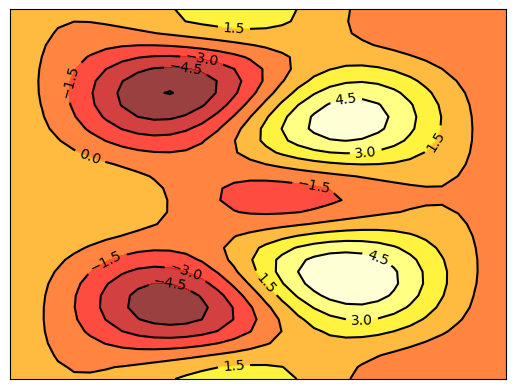

In [628]:
#contour plot of spin function
n = 32
x = np.linspace(0, np.pi, n)
y = np.linspace(0, 2*np.pi, n)
X, Y = np.meshgrid(x, y)

plt.contourf(X, Y, vspin_func_slice(X, Y, a, d=3), 8, alpha=.75, cmap=plt.cm.hot)
C = plt.contour(X, Y, vspin_func_slice(X,Y, a, d=3), 8, colors='black')
plt.clabel(C, inline=1, fontsize=10)
plt.xticks([])
plt.yticks([])

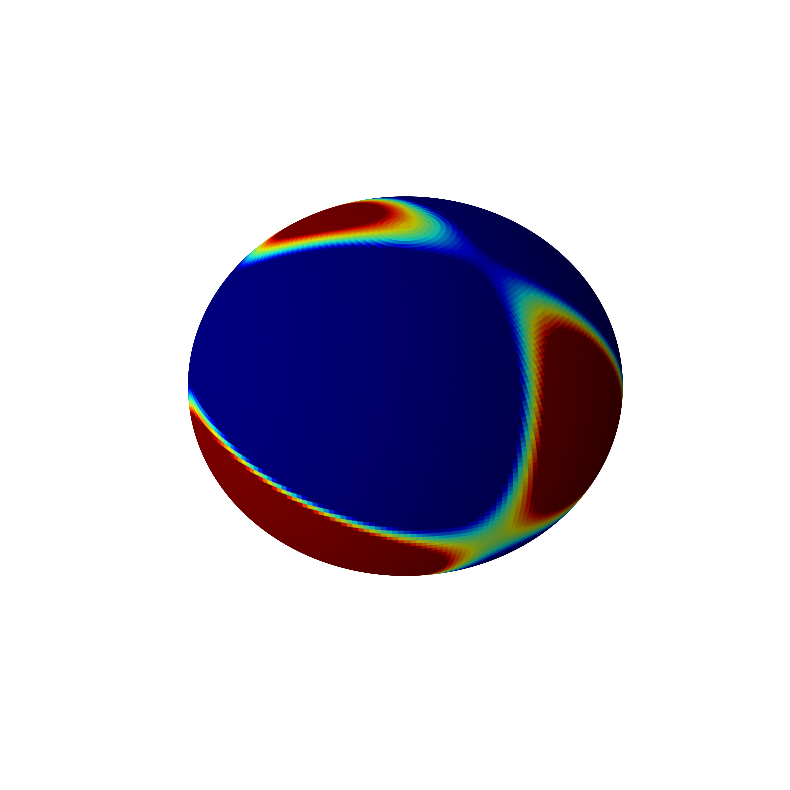

In [812]:
#Heat map (not my code-see below)
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


def random_point( r=1 ):
    ct = 2*np.random.rand() - 1
    st = np.sqrt( 1 - ct**2 )
    phi = 2* np.pi *  np.random.rand()
    x = r * st * np.cos( phi)
    y = r * st * np.sin( phi)
    z = r * ct
    return np.array( [x, y, z ] )

def near( p, pntList, d0 ):
    cnt=0
    for pj in pntList:
        dist=np.linalg.norm( p - pj )
        if dist < d0:
            cnt += 1 - dist/d0
    return cnt


"""
https://stackoverflow.com/questions/22128909/plotting-the-temperature-distribution-on-a-sphere-with-python
"""

pointList = np.array([ random_point( 10.05 ) for i in range( 65 ) ] )

fig = plt.figure(figsize = (10,10)) 
ax = fig.add_subplot(projection='3d')
u = np.linspace( 0, 2 * np.pi, 240)
v = np.linspace( 0, np.pi, 120 )

# create the sphere surface
XX = np.sqrt(3) * np.outer( np.cos( u ), np.sin( v ) )
YY = np.sqrt(3) * np.outer( np.sin( u ), np.sin( v ) )
ZZ = np.sqrt(3) * np.outer( np.ones( np.size( u ) ), np.cos( v ) )

WW = XX.copy()
for i in range( len( XX ) ):
    for j in range( len( XX[0] ) ):
        x = XX[ i, j ]
        y = YY[ i, j ]
        z = ZZ[ i, j ]
        WW[ i, j ] = spin_func(np.array([x, y, z]).reshape(1,3), a)
myheatmap = WW

# ~ ax.scatter( *zip( *pointList ), color='#dd00dd' )
ax.plot_surface( XX, YY,  ZZ, cstride=1, rstride=1, facecolors=cm.jet( myheatmap ) )
m = cm.ScalarMappable(cmap=cm.jet)
m.set_array(myheatmap)
#plt.colorbar(m)
ax.set_axis_off()
plt.savefig("/Users/pantelistassopoulos/Documents/texfiles/Summer-Research-2023/images/3d_spin_sphere_plot_d_3.png")
#Show the plot.
plt.show() 

In [790]:
def neural_net_symm(x, c, z):
    """
    Compute the output of a symmetric neural network for given input and parameters.

    Parameters:
    x (np.ndarray): An input vector of shape (1, d).
    c (np.ndarray): Coefficients of the neural network with shape (1, n).
    z (np.ndarray): Weight matrix with shape (n, d).

    Returns:
    np.ndarray: The output of the symmetric neural network with shape (1, 1).
    """
    z = np.array(z)
    n = z.shape[0]
    d = z.shape[1]
    c = c.reshape(1,n)
    return 1/n*(np.exp(-x@z.T)@c.T).reshape(1,x.shape[0])

def neural_net_slice(X, Y, c, z, d = 5):
    """
    Compute the output of a symmetric neural network for given angles and parameters.

    Parameters:
    X (float): The first angle.
    Y (float): The second angle.
    c (np.ndarray): Coefficients of the neural network with shape (1, n).
    z (np.ndarray): Weight matrix with shape (n, d).
    d (int): The dimensionality of the input vectors (default is 5).

    Returns:
    np.ndarray: The output of the symmetric neural network with shape (1, 1).
    """
    x = np.sqrt(d)*np.array([np.sin(X)*np.cos(Y), np.sin(X)*np.sin(Y), np.cos(X)]).reshape(1,d)
    return neural_net_symm(x, c, z)
vneural_net_slice = np.vectorize(neural_net_slice)
vneural_net_slice.excluded.add(2)
vneural_net_slice.excluded.add(3)

In [791]:
def sample_uniform_sphere(r, d, n):
    """
    Generate random points uniformly distributed on the surface of a d-dimensional sphere with radius 'r'.

    Parameters:
    r (float): The radius of the sphere.
    d (int): The dimensionality of the sphere.
    n (int): The number of points to generate.

    Returns:
    np.ndarray: An array of shape (n, d) containing 'n' random points sampled uniformly on the sphere's surface.
    """
    s = np.random.multivariate_normal(np.zeros(d), np.diag(np.ones(d)), n)
    norm = np.sqrt(np.diag(s@s.T)).reshape(n,1)
    result = r*s/norm
    return result

In [792]:
#Training
def train(d = 5, n = 16, Dt = 1e3, steps = int(2*1e5)):
    """
    Train a neural network with symmetric architecture on a given spin system.

    Parameters:
    d (int): The dimensionality of the spin system (default is 5).
    n (int): The number of neural network units (default is 16).
    Dt (float): Time step for training (default is 1e3).
    steps (int): The number of training steps (default is 200,000).

    Returns:
    tuple: A tuple containing the trained neural network coefficients 'c', the weight matrix 'z',
           and an array of loss values during training.
    """
    
    #initialise parameters
    c = np.random.uniform(-40*d**2, 40*d**2, n).reshape(1,n)
    z = sample_uniform_sphere(np.sqrt(d), d, n).reshape(n,d)
    L = np.zeros(n).reshape(n,1)
    P = int(1e2)
    x = sample_uniform_sphere(np.sqrt(d), d, P).reshape(P,d)
    losses = np.zeros(steps)
    #update step
    for step in trange(steps):
        grad = grad_spin_func(z,a)
        exp = np.exp(-z@z.T)
        #sample points on sphere        
        #exp_x = np.exp(-x@z.T)
        loss = 0.5*np.mean((spin_func(x,a)-neural_net_symm(x,c,z))**2)
        #loss1 = -1/n*c@spin_func(z, a).T+0.5*1/n**2*c@exp@c.T
        #neural_net_symm(z,c,z)
        c_next = c + (spin_func(z, a)-1/n*c@exp)*Dt 
        z_next = z + (c.T*grad+1/n*(c.T*exp)@(c.T*z))*Dt
        #c_next = c + (spin_func(x, a)@exp_x-1/n*c@exp_x.T@exp_x)*Dt/P
        #z_next = z + ((c.T*exp_x.T)@(spin_func(x, a).T*x)-1/n*(c.T*exp_x.T@((exp_x@c.T)*x)))*Dt/P

        #c_next = c + (spin_func(z, a)@exp-1/n*c@exp.T@exp)*Dt/n
        #z_next = z + ((c.T*exp.T)@(spin_func(z, a).T*z)+1/n*(c.T*exp.T@((exp@c.T)*z)))*Dt/n-L*z*Dt
        z_next = z_next*np.sqrt(d)/(np.linalg.norm(z_next, axis = 1).reshape(n,1)+1e-100)
        #L_next = L - (np.linalg.norm(z_next, axis = 1).reshape(n,1)-np.sqrt(d)*np.ones(n).reshape(n,1))*Dt
        z = z_next
        c = c_next
        #L = L_next
                
        losses[step] = loss
        print('loss: {}'.format(loss))
                
    return c,z, losses

In [793]:
#Training
def train_SGD(d = 5, n = 16, Dt = 1e3, steps = int(2*1e5)):
    """
    Train a neural network with symmetric architecture on a given spin system using Stochastic Gradient Descent (SGD).

    Parameters:
    d (int): The dimensionality of the spin system (default is 5).
    n (int): The number of neural network units (default is 16).
    Dt (float): Time step for training (default is 1e3).
    steps (int): The number of training steps (default is 200,000).

    Returns:
    tuple: A tuple containing the trained neural network coefficients 'c', the weight matrix 'z',
           and an array of loss values during training.
    """
    
    #initialise parameters
    c = np.random.uniform(-40*d**2, 40*d**2, n).reshape(1,n)
    z = sample_uniform_sphere(np.sqrt(d), d, n).reshape(n,d)
    losses = np.zeros(steps)
    
    
    #update step
    for step in trange(steps):
        grad = grad_spin_func(z,a)
        exp = np.exp(-z@z.T)
        #sample points on sphere
        P = int(1e2)
        x = sample_uniform_sphere(np.sqrt(d), d, P).reshape(P,d)
        exp_x = np.exp(-x@z.T)

        loss = 0.5*np.mean((spin_func(x,a)-neural_net_symm(x,c,z))**2)
        #c_next = c + neural_net_symm(z,(-spin_func(x, a)+neural_net_symm(x,c,z))/P, x).reshape(1,n)*Dt/n
        #z_next = z + ((neural_net_symm(x,c,z)-spin_func(x,a))*(exp_x*c).T)@x*Dt/n*P
        
        
        c_next = c + (spin_func(x, a)@exp_x-1/n*c@exp_x.T@exp_x)*Dt/P
        z_next = z + (-(c.T*exp_x.T)@(spin_func(x, a).T*x)+1/n*(c.T*exp_x.T@((exp_x@c.T)*x)))*Dt/P
        z_next = z_next*np.sqrt(d)/np.linalg.norm(z_next, axis = 1).reshape(n,1)
        z = z_next
        c = c_next
        
        losses[step] = loss
        print('loss: {}'.format(loss))
                
    return c,z, losses

In [794]:
def train_MF_Hom_SGLD(d = 5, n = 16, steps = 5*1e3, learning_rate = 1e-3, M = 10, tolerance = 1e-2):
    
    #initialise parameters
    c = np.random.uniform(-40*d**2, 40*d**2, n).reshape(1,n)
    z = sample_uniform_sphere(np.sqrt(d), d, n).reshape(n,d)
    losses = np.zeros(steps)
    
    Y_c = 0
    Y_z = 0
        
    for step in trange(steps):
        #update Y
        Y_c_1 = Y_c
        Y_z_1 = Y_z
        
        cal_Y_c = 0
        cal_Y_z = 0
        
        grad = grad_spin_func(z,a)
        exp = np.exp(-z@z.T)
        #sample points on sphere
        P = int(1e2)
        x = sample_uniform_sphere(np.sqrt(d), d, P).reshape(P,d)
        exp_x = np.exp(-x@z.T)

        loss = 0.5*np.mean((spin_func(x,a)-neural_net_symm(x,c,z))**2)
        
        
        for m in range(1,M+1):
            δ = 0.1/20
            γ = 0.05
            β = 0.1
            λ = 0.05
        
            dc = -(spin_func(x, a)@exp_x-1/n*c@exp_x.T@exp_x)/P
            dz = -(-(c.T*exp_x.T)@(spin_func(x, a).T*x)+1/n*(c.T*exp_x.T@((exp_x@c.T)*x)))/P
            
            Y_c_1 = Y_c_1 - δ*(dc-(1/γ)*(c-Y_c_1))\
            + np.sqrt(2*(δ/β))*np.random.normal(0,1)
            Y_z_1 = Y_z_1 - δ*(dz-(1/γ)*(z-Y_z_1))\
            + np.sqrt(2*(δ/β))*np.random.normal(0,1)
            
            cal_Y_c += Y_c_1
            cal_Y_z += Y_z_1
            
        Y_c = Y_c_1
        Y_z = Y_z_1
        
        cal_Y_c /= M
        cal_Y_z /= M
        
        #update model parameters
        Δ = learning_rate
        mu_c = np.mean(c)
        mu_z = np.mean(z, axis = 1).reshape(n,1)
        
        c = c - 1/γ*(c-cal_Y_c)*Δ - λ*(c - mu_c)*Δ
        z = z - 1/γ*(z-cal_Y_z)*Δ - λ*(z - mu_z)*Δ
        z = z*np.sqrt(d)/np.linalg.norm(z, axis = 1).reshape(n,1)

        
        losses[step] = loss
        print('loss: {}'.format(loss))
    

    return c,z, losses

In [795]:
def train_MaSS(d = 3, n = 256, steps = int(5*1e3), Dt = 1e-3, tolerance = 1e-2):
    #With adaptive restart
    #initialise parameters
    c = np.random.uniform(-40*d**2, 40*d**2, n).reshape(1,n)
    z = sample_uniform_sphere(np.sqrt(d), d, n).reshape(n,d)
    losses = np.zeros(steps)
    
    u = c
    v = z
    count = 1
    
    for step in trange(steps):
        
        grad = grad_spin_func(z,a)
        exp = np.exp(-z@z.T)
        #sample points on sphere
        P = int(1e2)
        x = sample_uniform_sphere(np.sqrt(d), d, P).reshape(P,d)
        exp_x = np.exp(-x@z.T)

        loss = 0.5*np.mean((spin_func(x,a)-neural_net_symm(x,c,z))**2)
        
        dc = -(spin_func(x, a)@exp_x-1/n*c@exp_x.T@exp_x)/P
        dz = -(-(c.T*exp_x.T)@(spin_func(x, a).T*x)+1/n*(c.T*exp_x.T@((exp_x@c.T)*x)))/P
        
        m = 10
        eta2 = Dt/m
        
        c_new = u - Dt*dc
        z_new = v - Dt*dz
        
        u = c_new + (count-1)/(count+2)*(c_new-c) + eta2*dc
        v = z_new + (count-1)/(count+2)*(z_new-z) + eta2*dz

        if (dc@(c_new-c).T)[0]+(dz*(z_new-z)).sum()>0: 
            count = 1
        
        c = c_new
        z = z_new
        
        count +=1
        losses[step] = loss
        print('loss: {}'.format(loss))
    
    
    return c,z,losses


In [779]:
#contour plot of neural net reconstruction
c_mass,z_mass,losses_mass = train_MaSS(d = 3, n = 256, Dt = 1e-6, steps = int(1*1e5))

  0%|          | 0/100000 [00:00<?, ?it/s]

loss: 1864.1541760475707
loss: 473.4982739455775
loss: 436.2035333967768
loss: 181.7635875538969
loss: 128.96753561393044
loss: 93.37071068923015
loss: 93.17878873037489
loss: 51.71470282328139
loss: 39.826033800630725
loss: 26.94599482613335
loss: 27.002923691476685
loss: 25.986547111671392
loss: 17.111465328952296
loss: 13.454865369742311
loss: 12.809005028459604
loss: 14.94545424102381
loss: 12.92968892840541
loss: 12.431340640230276
loss: 7.634482079548449
loss: 9.292554245494653
loss: 8.65181309289791
loss: 7.205551255024758
loss: 6.067908510169399
loss: 6.2973380822037175
loss: 6.40301503651139
loss: 5.1000152342882235
loss: 4.1567341829381785
loss: 5.254062608582957
loss: 3.9385066814207046
loss: 2.2824075191000484
loss: 3.826356730963625
loss: 3.5194941985202757
loss: 2.5470814983376293
loss: 1.965890750072235
loss: 1.6087854394325714
loss: 1.631944044898614
loss: 1.6599773002205365
loss: 1.9130131075393737
loss: 1.901879214745592
loss: 1.323069102722678
loss: 1.664005819237849

loss: 0.047949971856123604
loss: 0.03281015595796525
loss: 0.05000466957605567
loss: 0.05147795544617026
loss: 0.04309495331964885
loss: 0.04617333221228953
loss: 0.04264422817189925
loss: 0.04383784549064582
loss: 0.04318307618339788
loss: 0.045006318813899465
loss: 0.05597351836577089
loss: 0.04452967937562465
loss: 0.04873978117058853
loss: 0.0428086075789051
loss: 0.04213898555723304
loss: 0.05318121466214948
loss: 0.0485566105491306
loss: 0.035591292451051235
loss: 0.046210899415523185
loss: 0.04057503303940169
loss: 0.05369867458147609
loss: 0.04327173860826499
loss: 0.044429978240616876
loss: 0.05074548987057786
loss: 0.05430545839032923
loss: 0.04994505978373898
loss: 0.04761382934533536
loss: 0.05341975552911091
loss: 0.04744364548935349
loss: 0.07199295275944699
loss: 0.06116776040934628
loss: 0.04236074793670972
loss: 0.03921566135626429
loss: 0.05227525397341688
loss: 0.06036571795093258
loss: 0.04355840741717004
loss: 0.03931433826972118
loss: 0.04857773276487934
loss: 0.0

loss: 0.036573480362648465
loss: 0.042012499344386785
loss: 0.058000183512203644
loss: 0.05366574629081128
loss: 0.052304791217643726
loss: 0.056567493128868
loss: 0.0502066485574159
loss: 0.04881573869409027
loss: 0.03414610303838849
loss: 0.03944458577382538
loss: 0.04514824901330023
loss: 0.05978606507153311
loss: 0.05968542387736898
loss: 0.04462669896414696
loss: 0.04357095745858132
loss: 0.033062755752925034
loss: 0.035677205906075905
loss: 0.035598190336692134
loss: 0.03576577761754059
loss: 0.04103820214065001
loss: 0.04116283951655395
loss: 0.025153442837655846
loss: 0.025900403904519653
loss: 0.03823645874083051
loss: 0.029656893057008714
loss: 0.039936246807871265
loss: 0.024106177276877215
loss: 0.03018090820721196
loss: 0.029222319911875617
loss: 0.04617265969545616
loss: 0.026317744100619104
loss: 0.036695154571412696
loss: 0.030207954850933506
loss: 0.02877432751845615
loss: 0.03845634172073765
loss: 0.03001828936873316
loss: 0.023896246815841772
loss: 0.0412933603125141

loss: 0.03750676082310521
loss: 0.031191845119193262
loss: 0.029687151799484324
loss: 0.034829673390181906
loss: 0.020819105780962285
loss: 0.028446142662522753
loss: 0.023706333674948996
loss: 0.024215294552557692
loss: 0.02914952106276211
loss: 0.025804534428922228
loss: 0.02520050620190489
loss: 0.026843023968781507
loss: 0.02332734848057443
loss: 0.02287116007033081
loss: 0.023314454114548137
loss: 0.025495440604629452
loss: 0.024973876885741264
loss: 0.024251544707030507
loss: 0.023894070998449445
loss: 0.022707762051533634
loss: 0.021272015267144076
loss: 0.02794852580206283
loss: 0.021545261651213964
loss: 0.026054136478294344
loss: 0.03123833801576701
loss: 0.021669576842911594
loss: 0.02166372159286935
loss: 0.024243618284745066
loss: 0.019737086643003606
loss: 0.02534393473588963
loss: 0.024875644822098177
loss: 0.03097518406013551
loss: 0.018466086484970244
loss: 0.024261511206695858
loss: 0.02526207460210954
loss: 0.025784693862600495
loss: 0.023835486267924807
loss: 0.0237

loss: 0.02414357190626823
loss: 0.02020036958346955
loss: 0.018631793896540513
loss: 0.03301412071882985
loss: 0.02109492803740198
loss: 0.01668217469891222
loss: 0.019205646904965838
loss: 0.018357241992445098
loss: 0.02078597068642398
loss: 0.017260139318531716
loss: 0.01712344786951893
loss: 0.012854437917871149
loss: 0.019427570915118347
loss: 0.02357585962128879
loss: 0.02159481415928052
loss: 0.017604070886470837
loss: 0.0161612757025387
loss: 0.021090199047782022
loss: 0.019718973854625847
loss: 0.018872671866710298
loss: 0.021176588628132893
loss: 0.021577712874869915
loss: 0.02326766192957138
loss: 0.01764119546099796
loss: 0.01940039166693823
loss: 0.02313994083407487
loss: 0.02193717010220001
loss: 0.020688863800926955
loss: 0.020472793376261716
loss: 0.019185865629324256
loss: 0.02126323728997094
loss: 0.019249033168681682
loss: 0.01766882904144097
loss: 0.02032913987088757
loss: 0.016836638138257257
loss: 0.023121651755844037
loss: 0.018492542972856595
loss: 0.022331047057

loss: 0.014656303464012328
loss: 0.014035585935106723
loss: 0.015556574417066406
loss: 0.01619368195666616
loss: 0.016380887628316253
loss: 0.015431735492703477
loss: 0.013198661900236828
loss: 0.012389323531868574
loss: 0.015549021790365285
loss: 0.012185263386634494
loss: 0.012989966309529439
loss: 0.0170754691839334
loss: 0.0183913964612834
loss: 0.01465468277969822
loss: 0.01656478877697043
loss: 0.016196487089947514
loss: 0.016690042899590682
loss: 0.011247314314129836
loss: 0.015237324670573336
loss: 0.011572594829346363
loss: 0.012363682498716784
loss: 0.011064025697951037
loss: 0.01307042087231256
loss: 0.011709555311443784
loss: 0.013807110350295354
loss: 0.015790426687346495
loss: 0.014369793633967945
loss: 0.014441400558552985
loss: 0.011628132928475114
loss: 0.015951266987903265
loss: 0.0134347438178971
loss: 0.017292024471675063
loss: 0.014797786956894576
loss: 0.011491404923283212
loss: 0.015044440936907504
loss: 0.017302766042452275
loss: 0.016540943501013265
loss: 0.011

loss: 0.01147639295957168
loss: 0.011184562878848628
loss: 0.012247471369431509
loss: 0.014333612629352243
loss: 0.011754946998928907
loss: 0.008465874012132396
loss: 0.010174072065263075
loss: 0.011086655987171911
loss: 0.012383313400585873
loss: 0.01099036820608383
loss: 0.011932278594771015
loss: 0.009418714920148064
loss: 0.00761023670569266
loss: 0.010956277211192826
loss: 0.013943438585525911
loss: 0.01076530637377255
loss: 0.01399559162302371
loss: 0.013016093789503375
loss: 0.009591587228749792
loss: 0.009632552008244508
loss: 0.00868317294096235
loss: 0.012442295083427878
loss: 0.010765224485172644
loss: 0.015610908508058218
loss: 0.012654164017940547
loss: 0.014064751788830989
loss: 0.012997135030944334
loss: 0.01030515758350055
loss: 0.01067350035224173
loss: 0.00838619940473426
loss: 0.014081911084307182
loss: 0.013380318042962943
loss: 0.015106684781554696
loss: 0.015684880766603918
loss: 0.012917350291717068
loss: 0.013168946645248179
loss: 0.011689622920733549
loss: 0.01

loss: 0.011169379359390628
loss: 0.00997230362292724
loss: 0.008757732402557512
loss: 0.008085603354332466
loss: 0.012942245027491781
loss: 0.009964223947313075
loss: 0.012300374579600159
loss: 0.011442375972080681
loss: 0.008387639298028143
loss: 0.010083388387452073
loss: 0.011924145894413596
loss: 0.009088065026125853
loss: 0.009418446483136248
loss: 0.012311393587847727
loss: 0.011768887019150858
loss: 0.009966851478254511
loss: 0.01154190789058398
loss: 0.010951317657779134
loss: 0.01119398721253839
loss: 0.008975851819589835
loss: 0.01149334624866608
loss: 0.010617990595248589
loss: 0.010913238432288577
loss: 0.012397615334560838
loss: 0.010226028215860076
loss: 0.012212540491825878
loss: 0.009555759786047115
loss: 0.011697301090647578
loss: 0.012531786286525176
loss: 0.009445633840207543
loss: 0.009599249693005919
loss: 0.008453099818060585
loss: 0.009341080039630262
loss: 0.007662297604207433
loss: 0.011161242660945737
loss: 0.010074389335750944
loss: 0.009533650886223816
loss:

loss: 0.009766052736411063
loss: 0.009976075275344777
loss: 0.011015628043297586
loss: 0.012534754267578274
loss: 0.010698973428191429
loss: 0.010279908377356877
loss: 0.00883870029477867
loss: 0.008940396083208681
loss: 0.01071949539272057
loss: 0.008668217437927972
loss: 0.007064707799790979
loss: 0.006746931913235884
loss: 0.008113719286163161
loss: 0.00918692420983948
loss: 0.007182350609347137
loss: 0.007784189530371477
loss: 0.010399184469062427
loss: 0.008925788008499368
loss: 0.011550005480910588
loss: 0.008864680169344628
loss: 0.010043385534856114
loss: 0.009048354238558064
loss: 0.009934120487310301
loss: 0.009085988095428934
loss: 0.008348629221468699
loss: 0.009022333301984476
loss: 0.008531617241535384
loss: 0.008084432155105072
loss: 0.01187377807805999
loss: 0.007917508449531277
loss: 0.008699207543953053
loss: 0.007833432260498829
loss: 0.008929668173381611
loss: 0.006806059478226729
loss: 0.009900522056535523
loss: 0.009262690674863875
loss: 0.008441073246506753
loss:

loss: 0.006799158756613241
loss: 0.006574547144273995
loss: 0.007770387138235239
loss: 0.0067819506701178285
loss: 0.007269676583660784
loss: 0.008100756271177303
loss: 0.007531058997061854
loss: 0.0071276162601589125
loss: 0.00733571423566716
loss: 0.006641787514441972
loss: 0.006483245299103928
loss: 0.006000626029693233
loss: 0.0077470566259467
loss: 0.006488292907594217
loss: 0.007119885947454687
loss: 0.008700542315807042
loss: 0.006654042711011191
loss: 0.006869619608682958
loss: 0.009075379859916412
loss: 0.008532881597274729
loss: 0.008661097535011923
loss: 0.007949921715308407
loss: 0.008352874534425065
loss: 0.006299673611934422
loss: 0.007054837046612519
loss: 0.008713771312571726
loss: 0.006275711954669936
loss: 0.006441811273443138
loss: 0.008405794125740575
loss: 0.0059408126029036855
loss: 0.005555441714945117
loss: 0.007322770597840192
loss: 0.007394412082476668
loss: 0.00790009197544233
loss: 0.008777271991577667
loss: 0.006783785962303516
loss: 0.006233200323740335
lo

loss: 0.006991645997741506
loss: 0.007115690565782786
loss: 0.006822035237813155
loss: 0.005811569879482742
loss: 0.007067359682722473
loss: 0.006138719101864457
loss: 0.006661317312609413
loss: 0.004527193029960821
loss: 0.008343587085989356
loss: 0.00579380193017172
loss: 0.007897635514561912
loss: 0.007067802084900292
loss: 0.006101025972769688
loss: 0.008454104458234569
loss: 0.007947626050468212
loss: 0.006496394601003195
loss: 0.0075586373032164355
loss: 0.006029817642169911
loss: 0.007366933680163554
loss: 0.007347448011072144
loss: 0.005949551544035569
loss: 0.007607026691934495
loss: 0.005580808297047074
loss: 0.005549282377454256
loss: 0.006874225387409894
loss: 0.006423196874343956
loss: 0.005878931285716502
loss: 0.005864532262049555
loss: 0.006191236444484497
loss: 0.005907163261415809
loss: 0.006022719236246882
loss: 0.006895759026087721
loss: 0.006265472975015055
loss: 0.00453176449152259
loss: 0.005596720308181102
loss: 0.006918585807753175
loss: 0.006463234355653726
lo

loss: 0.0046902433691185415
loss: 0.004355475382480807
loss: 0.006351781308193787
loss: 0.005441230640350663
loss: 0.006128482588715605
loss: 0.006644692549831172
loss: 0.005470347406493069
loss: 0.0068278062103527
loss: 0.005901637811120536
loss: 0.006072580079633125
loss: 0.005087921436578833
loss: 0.005129712470267841
loss: 0.005136787630422701
loss: 0.004591999128238294
loss: 0.005555397882682532
loss: 0.005658835714235105
loss: 0.005277100457838398
loss: 0.005914511559437726
loss: 0.004467878345873587
loss: 0.005214453928547461
loss: 0.0054329168861793654
loss: 0.0042166507729695536
loss: 0.0042237704585170325
loss: 0.006026283974066178
loss: 0.00563510642235485
loss: 0.007234631885256787
loss: 0.00660163917054141
loss: 0.005864515399366933
loss: 0.006414501092288274
loss: 0.005960536081164378
loss: 0.00568172120981498
loss: 0.005687104999008696
loss: 0.005233518738865569
loss: 0.005737727467392662
loss: 0.005335762692348213
loss: 0.004599324221035798
loss: 0.005526908025510875
lo

loss: 0.004133129249882507
loss: 0.005968108249012338
loss: 0.007336831186684859
loss: 0.00452559162785725
loss: 0.006564050464043431
loss: 0.006162964850467364
loss: 0.0052252723304625345
loss: 0.006816123706500446
loss: 0.006225714885279071
loss: 0.004873491335485549
loss: 0.005919622661495989
loss: 0.005175828092069997
loss: 0.004457315148591426
loss: 0.003681900839882808
loss: 0.00489152225632198
loss: 0.0050668966667603565
loss: 0.004508896903794225
loss: 0.004615142309276095
loss: 0.004442289598259985
loss: 0.004538455175956377
loss: 0.004519611487382733
loss: 0.005013388839355817
loss: 0.004586734553694745
loss: 0.006264113472725647
loss: 0.0057758697809025174
loss: 0.00534260518293782
loss: 0.005334051385671185
loss: 0.004237697750470158
loss: 0.004636086411054721
loss: 0.005071089563957528
loss: 0.004638656400753751
loss: 0.005599807542925863
loss: 0.004911033956432378
loss: 0.005714609229521257
loss: 0.004260268658161894
loss: 0.0048420010740891145
loss: 0.005914123813666161


loss: 0.00401108386528418
loss: 0.0045687366443821365
loss: 0.0040306121925279235
loss: 0.004175454914348623
loss: 0.004007568614882962
loss: 0.0036817617531791063
loss: 0.005182282776509046
loss: 0.004131451972681366
loss: 0.00354375877669388
loss: 0.00397731192386966
loss: 0.0039038154849507286
loss: 0.004897156114311051
loss: 0.00524625358436725
loss: 0.00444004978813577
loss: 0.0055221022223509286
loss: 0.004546758603117274
loss: 0.005898306323717911
loss: 0.004395260850991655
loss: 0.00600506477347171
loss: 0.0037006041178645876
loss: 0.0044681820003523364
loss: 0.006330759456047354
loss: 0.004529466943578737
loss: 0.003808322236469211
loss: 0.004952735168827217
loss: 0.004235694234271648
loss: 0.005090191318809975
loss: 0.004756754829493947
loss: 0.004949989195396003
loss: 0.005387182662051633
loss: 0.004432277561524953
loss: 0.0064761168062064875
loss: 0.004576109729302515
loss: 0.005119558029153671
loss: 0.0047561873916368265
loss: 0.0037754398837290793
loss: 0.0051203586533394

loss: 0.003774915574954164
loss: 0.00444370684709204
loss: 0.005374643210544444
loss: 0.004797432764855888
loss: 0.0036550208055995603
loss: 0.004513540496452445
loss: 0.005047249683970351
loss: 0.004392349032208034
loss: 0.00300391849987467
loss: 0.004524653890870645
loss: 0.005558033319815505
loss: 0.003724305585947524
loss: 0.004456183726578617
loss: 0.004426273899166166
loss: 0.003921092183601472
loss: 0.00423346361786285
loss: 0.003827019319273591
loss: 0.004465918003247405
loss: 0.0036194022023081757
loss: 0.004026941444551449
loss: 0.0036780977238550163
loss: 0.004462457849246044
loss: 0.0033784945222918934
loss: 0.0037291385516446474
loss: 0.004366641315022899
loss: 0.0034206261719886134
loss: 0.003996775804723031
loss: 0.0045685944884867186
loss: 0.004317145696388972
loss: 0.003334381994516092
loss: 0.004566894361471217
loss: 0.004315365862223234
loss: 0.00517717391460782
loss: 0.005241740021175917
loss: 0.00565705669417554
loss: 0.004940997603688804
loss: 0.006150395238531271

loss: 0.005573324620892406
loss: 0.004727541711875797
loss: 0.004315080694512881
loss: 0.004473093875617093
loss: 0.004895818096533073
loss: 0.004045572621649879
loss: 0.0043986236963090754
loss: 0.004264165275944893
loss: 0.00439036505624151
loss: 0.0034596455640808193
loss: 0.004474850939434191
loss: 0.005422166893592718
loss: 0.004055196459015604
loss: 0.004549987494002683
loss: 0.004211255538952507
loss: 0.004216618935700313
loss: 0.0039544537521529356
loss: 0.004774024996345205
loss: 0.004279093697160113
loss: 0.004036347521291076
loss: 0.0038363175296663864
loss: 0.004128236604713226
loss: 0.0035012662053522502
loss: 0.0038634017674110156
loss: 0.004490916548227228
loss: 0.004555337037825913
loss: 0.003191559876165062
loss: 0.004148715418896119
loss: 0.00313563143970365
loss: 0.00507560269265344
loss: 0.004117827098342647
loss: 0.004763594692547203
loss: 0.003317918924342844
loss: 0.004056314871609983
loss: 0.004523250910979383
loss: 0.00448019623421183
loss: 0.003016920545777031

loss: 0.003742912325577625
loss: 0.005120615683539814
loss: 0.004195210643290578
loss: 0.004077947534785349
loss: 0.005067453887030709
loss: 0.0028231837983709513
loss: 0.0032984352907751797
loss: 0.004560237399900085
loss: 0.0038462943488340516
loss: 0.003711567147300881
loss: 0.0036763742802775334
loss: 0.0030315077798991823
loss: 0.003801285239636879
loss: 0.003063311905434575
loss: 0.0037279317812310836
loss: 0.0032629736730992783
loss: 0.003707765838822363
loss: 0.003667388277502048
loss: 0.00429590428847226
loss: 0.0038457875645342763
loss: 0.00395430198716098
loss: 0.004049080401349675
loss: 0.003669529642470255
loss: 0.003797821786944271
loss: 0.003296052803106694
loss: 0.004131950539162405
loss: 0.0037190260745838277
loss: 0.003469123555452874
loss: 0.0034468997692779567
loss: 0.0030344071161472826
loss: 0.004390021705547286
loss: 0.003472086302683717
loss: 0.0049429180246392925
loss: 0.0036358621940096726
loss: 0.004363938034954102
loss: 0.003808850105032339
loss: 0.005206081

loss: 0.0028190368656480867
loss: 0.004205359929305027
loss: 0.0026194494360335828
loss: 0.003691306362671832
loss: 0.0032700877858905953
loss: 0.003605435701315193
loss: 0.004229821589860769
loss: 0.0038712705836418905
loss: 0.004046535932398922
loss: 0.0037956556271533737
loss: 0.003956429906840098
loss: 0.005235464210365581
loss: 0.0028552948112277863
loss: 0.0032628308281391393
loss: 0.003681325139843122
loss: 0.003177221281762664
loss: 0.004376688321401672
loss: 0.0034714224297828526
loss: 0.0039987613373436365
loss: 0.0030750045650184987
loss: 0.002933887758041995
loss: 0.0030805258569113992
loss: 0.004228464872891774
loss: 0.0033478198994994226
loss: 0.0034103674537672756
loss: 0.0038834015007710946
loss: 0.0029941011671570706
loss: 0.0036365405325084433
loss: 0.003967408945669833
loss: 0.004568304413377228
loss: 0.004063413585759607
loss: 0.004993813959159363
loss: 0.004493069793450965
loss: 0.004325986855732977
loss: 0.003529682367288514
loss: 0.005205807165860853
loss: 0.0037

loss: 0.0033711655339212125
loss: 0.0035961745953082607
loss: 0.0036939086520485723
loss: 0.0042529443264960574
loss: 0.004574011026074077
loss: 0.003284389608394124
loss: 0.004144504820305106
loss: 0.004360969989691907
loss: 0.003305978781184265
loss: 0.00361900670226207
loss: 0.003540097231796088
loss: 0.003130627173984092
loss: 0.004103076772173329
loss: 0.003974428488077902
loss: 0.003344447806952975
loss: 0.003210396949320039
loss: 0.0047978177095927355
loss: 0.003373306798651936
loss: 0.004043683442675419
loss: 0.00350037692816847
loss: 0.004305607270673333
loss: 0.004347342847582025
loss: 0.0032375434970133786
loss: 0.004007582061572847
loss: 0.004172087487252941
loss: 0.003954789119233329
loss: 0.004008576629193389
loss: 0.0031868749048969075
loss: 0.003229791738765866
loss: 0.0035779358658710562
loss: 0.003991748732484872
loss: 0.004447737369252546
loss: 0.003512128842564902
loss: 0.004487317120407649
loss: 0.0036647639176501977
loss: 0.0036011286866734944
loss: 0.004996025694

loss: 0.0036674092560891667
loss: 0.0026683181452888697
loss: 0.002955457778923327
loss: 0.00397098963188941
loss: 0.002923704145324184
loss: 0.003971292262820657
loss: 0.003522037239278816
loss: 0.003740380261224127
loss: 0.0031649036412400603
loss: 0.003224836725158498
loss: 0.004368500035103894
loss: 0.003151307485985318
loss: 0.0028382010187206126
loss: 0.003338558002023833
loss: 0.0029196225568236295
loss: 0.003507324215333893
loss: 0.0029819562917928048
loss: 0.003098079051885761
loss: 0.003055944289014297
loss: 0.0033585042674543998
loss: 0.0037889763063340015
loss: 0.0032989547970214174
loss: 0.0035070960689970736
loss: 0.002918509359153136
loss: 0.0036341575641321983
loss: 0.0033133340110302017
loss: 0.0029741312922113156
loss: 0.003880041785511666
loss: 0.003225025701810355
loss: 0.0037846519971274097
loss: 0.0031978672257850153
loss: 0.004339171107929277
loss: 0.0037993327008539572
loss: 0.0033809693750347153
loss: 0.00374918106293423
loss: 0.004290045380494699
loss: 0.00392

loss: 0.0031832187512623516
loss: 0.003573304325682121
loss: 0.0035809316278940604
loss: 0.004167406867542555
loss: 0.0028691052118214318
loss: 0.0035652704102999816
loss: 0.0032894850766092124
loss: 0.00306796422042498
loss: 0.0034290007444628813
loss: 0.00208197887865883
loss: 0.0036565338238644914
loss: 0.0027106644493963944
loss: 0.0027996466892645775
loss: 0.004287604054392021
loss: 0.002723602952283013
loss: 0.0033116149390463494
loss: 0.003036837481329251
loss: 0.0033625273503391285
loss: 0.0034097158114845703
loss: 0.003563287393114333
loss: 0.0047187602567521
loss: 0.0030914049622974673
loss: 0.0038834421411268354
loss: 0.0037094203246671132
loss: 0.003907081141756073
loss: 0.003869009352418068
loss: 0.003403449021885045
loss: 0.004900752222733815
loss: 0.003822859817333108
loss: 0.0038880083054497207
loss: 0.0042437447202294115
loss: 0.0048585153137394275
loss: 0.003402863129115467
loss: 0.0034114039665172524
loss: 0.0035956547817473155
loss: 0.004182803078372715
loss: 0.0039

loss: 0.003334546947813468
loss: 0.004082484579576381
loss: 0.0031608881106685847
loss: 0.003186531069845
loss: 0.0035429445048102393
loss: 0.0032298113448709603
loss: 0.003168707633404043
loss: 0.003484150749772202
loss: 0.003191295068016552
loss: 0.003487397890914399
loss: 0.0039702427282218115
loss: 0.003059721955491089
loss: 0.0029530398154077125
loss: 0.004050510267296266
loss: 0.003208669651260254
loss: 0.003310845651632588
loss: 0.0036247960847682194
loss: 0.004289365657832802
loss: 0.0034184473389634496
loss: 0.0035278505865190767
loss: 0.003911358029038964
loss: 0.0035920730950775286
loss: 0.0037224659664203985
loss: 0.0032455434156243856
loss: 0.00306537740377888
loss: 0.0027289226383361165
loss: 0.0029725415957287094
loss: 0.004145395911975456
loss: 0.002943991959604413
loss: 0.00431322795613346
loss: 0.0032116224747348377
loss: 0.003755706829996115
loss: 0.004333640173725787
loss: 0.003209307201858319
loss: 0.003665833439015864
loss: 0.004537307041870069
loss: 0.00471104644

loss: 0.0033975066201104914
loss: 0.004017144865567172
loss: 0.004098709518270882
loss: 0.0040084408780562105
loss: 0.0037783747308691553
loss: 0.004259358314162373
loss: 0.0038141456507802315
loss: 0.0036037279476638013
loss: 0.0035956165119981737
loss: 0.0032989422701361084
loss: 0.003619224451440606
loss: 0.0039596271384073475
loss: 0.004273025874888946
loss: 0.00297157761218715
loss: 0.0027127178440675514
loss: 0.003222828428016109
loss: 0.004116194808214665
loss: 0.003338481525373501
loss: 0.003353455811676535
loss: 0.003314727570382183
loss: 0.0050552148839482225
loss: 0.0031023450077939285
loss: 0.0036986440988757583
loss: 0.0026711064967058396
loss: 0.0032453213239631673
loss: 0.0031522520447771923
loss: 0.002795832070899098
loss: 0.0028755538047196354
loss: 0.002757539303105441
loss: 0.0034925720412537463
loss: 0.003668464402200152
loss: 0.003393267850874698
loss: 0.0030648758110027436
loss: 0.003389167828516953
loss: 0.0033328756271194166
loss: 0.003626489132747341
loss: 0.00

loss: 0.003608162287426217
loss: 0.0028405488359534246
loss: 0.00335268027301905
loss: 0.0031191634087940796
loss: 0.002999117279768331
loss: 0.003008314325797437
loss: 0.003187165419403959
loss: 0.0031917660420295252
loss: 0.003807771219937603
loss: 0.002605476039190278
loss: 0.0035195726394868583
loss: 0.003267461858363163
loss: 0.0027601565843292613
loss: 0.0030035522672404984
loss: 0.003102027671063367
loss: 0.00336717119261728
loss: 0.0035160711164537745
loss: 0.0032119418180178794
loss: 0.0037417492482669785
loss: 0.0033208561874632646
loss: 0.003561908007253689
loss: 0.0033438429616385068
loss: 0.004457276232627577
loss: 0.0029556880575427906
loss: 0.003234153607793351
loss: 0.0035003790469509853
loss: 0.0037767579387981203
loss: 0.0037920000576896523
loss: 0.0037568969809039336
loss: 0.0026501825940804242
loss: 0.0029178611597275544
loss: 0.0030999253242917873
loss: 0.0028764236969313793
loss: 0.002564050490585659
loss: 0.0031461487894682296
loss: 0.002310154132150868
loss: 0.0

loss: 0.003693708043194032
loss: 0.003423097772406679
loss: 0.0035649570819832666
loss: 0.0026956103715664315
loss: 0.0030107492490568906
loss: 0.00323018069496359
loss: 0.003372909583281791
loss: 0.0031901236082753246
loss: 0.0034604637301693824
loss: 0.0034534438781522814
loss: 0.0036426267355248927
loss: 0.0027500206249933285
loss: 0.002572129001969633
loss: 0.003461955523282496
loss: 0.0038970997801069224
loss: 0.00337035587283777
loss: 0.003084117887874299
loss: 0.0036856745626208886
loss: 0.0036695486435469903
loss: 0.0037818527056459657
loss: 0.003984485858803013
loss: 0.003959891662482038
loss: 0.005044579674645846
loss: 0.0033040152616734776
loss: 0.0037115209348370887
loss: 0.004611775334787701
loss: 0.005132706276264636
loss: 0.0043081171112931025
loss: 0.0038729340548190657
loss: 0.005286553050551156
loss: 0.004847493766002637
loss: 0.0048152797223441676
loss: 0.004375320760554851
loss: 0.004426080447673542
loss: 0.004683564365077433
loss: 0.005897077455659633
loss: 0.00549

loss: 0.0025057805362427316
loss: 0.0025715144290118664
loss: 0.0034332703935871763
loss: 0.002633228391851668
loss: 0.0028841375415158466
loss: 0.004516039885843182
loss: 0.004301487990932074
loss: 0.003989528400854123
loss: 0.004143177024019688
loss: 0.0034782694036249668
loss: 0.0032965765507914197
loss: 0.0038865748448977376
loss: 0.002504340909817639
loss: 0.003025642472131853
loss: 0.003234216672713671
loss: 0.003967173286381
loss: 0.0031242240968955477
loss: 0.002126743446720787
loss: 0.0030118708072240357
loss: 0.0038436673894330126
loss: 0.002848378525169371
loss: 0.002957124700777684
loss: 0.0028908402661511835
loss: 0.0034786822679382743
loss: 0.0029682794279498326
loss: 0.002864395383317298
loss: 0.0022991246839590353
loss: 0.0029927509243237293
loss: 0.003358661023011836
loss: 0.003336047037449078
loss: 0.003223165748828331
loss: 0.0029706198081355067
loss: 0.0033390885308830316
loss: 0.002534954151429436
loss: 0.002768872499738057
loss: 0.0031021027128865127
loss: 0.00322

loss: 0.0027967835990004874
loss: 0.0022350215296377237
loss: 0.0024000327229310083
loss: 0.002480741031304111
loss: 0.0032520915084258907
loss: 0.0031376849534447125
loss: 0.0030461951808961403
loss: 0.0029697213979781715
loss: 0.003596081383773886
loss: 0.002977018842138535
loss: 0.003426527569899032
loss: 0.003065913652299263
loss: 0.0028001173954255525
loss: 0.00363243915217095
loss: 0.004477650415831854
loss: 0.002924407580073206
loss: 0.0033050697208309083
loss: 0.0031559824190329653
loss: 0.003322962583830639
loss: 0.0034271571228127666
loss: 0.0036260407072898804
loss: 0.0032958240994342956
loss: 0.0035674708965261256
loss: 0.0031149691611769602
loss: 0.002621476378384614
loss: 0.0033213989214412264
loss: 0.003944746678058927
loss: 0.003362700634666724
loss: 0.003557123529639489
loss: 0.004627752616827277
loss: 0.0035657132969177698
loss: 0.004587842326975356
loss: 0.002468354339797121
loss: 0.002911644118405941
loss: 0.0032404701735854243
loss: 0.0030782668644953985
loss: 0.00

loss: 0.0028886399577719114
loss: 0.0034755985122993083
loss: 0.003809078067299971
loss: 0.0029040559913122528
loss: 0.0033248873867369726
loss: 0.0028423118185734466
loss: 0.00304154859989315
loss: 0.00433156649264278
loss: 0.00350264126642644
loss: 0.003315793797600878
loss: 0.0022129055217833477
loss: 0.004033548606164596
loss: 0.0038381518516454063
loss: 0.00290500328315756
loss: 0.003236095266818173
loss: 0.0023375415876712904
loss: 0.0033132102343454424
loss: 0.002866666697463575
loss: 0.002717939410723906
loss: 0.0024362048899071497
loss: 0.002091970516927397
loss: 0.0031505897616836386
loss: 0.002604131559366136
loss: 0.00284599552010989
loss: 0.003907194002477404
loss: 0.002161168497970582
loss: 0.002894535004260472
loss: 0.0031592584842614147
loss: 0.0031061997295525083
loss: 0.0025290429960934026
loss: 0.003506603397435768
loss: 0.0038865023758881856
loss: 0.0031878745391165616
loss: 0.0024111176922615917
loss: 0.003190796825399125
loss: 0.0037877884479535096
loss: 0.0035311

loss: 0.0031792010839640154
loss: 0.004199718845371969
loss: 0.0032297080404517214
loss: 0.004126884192166443
loss: 0.0033934206980730836
loss: 0.002737684741937355
loss: 0.0032502254926483455
loss: 0.0038626522517032193
loss: 0.00352403677972539
loss: 0.003660702895256058
loss: 0.0025543520686111317
loss: 0.0027072783749293645
loss: 0.0031154136358800544
loss: 0.002760775207592175
loss: 0.0036221186187866015
loss: 0.0025222726845592204
loss: 0.0021021939357789552
loss: 0.0030040168614626508
loss: 0.0027928870045560556
loss: 0.002276409575034288
loss: 0.003989138808216202
loss: 0.003038184591365378
loss: 0.002678870398165381
loss: 0.0036755772321571695
loss: 0.0027242249956869707
loss: 0.0029157689122917617
loss: 0.002820507631115218
loss: 0.0025607422721580305
loss: 0.003839588496032024
loss: 0.0026465109992873897
loss: 0.0033043053887033607
loss: 0.002777062775619637
loss: 0.0030023523340550074
loss: 0.002513174381855848
loss: 0.003059046848846432
loss: 0.0020882838680813904
loss: 0.

loss: 0.003143016060995403
loss: 0.002224340080894088
loss: 0.00375499627659082
loss: 0.0032850398776050204
loss: 0.0030337357726707708
loss: 0.0030032273216045223
loss: 0.003848019583158557
loss: 0.0028315083006213615
loss: 0.0032840513420800905
loss: 0.0029025683054301394
loss: 0.003404135404622634
loss: 0.003153913040100204
loss: 0.0035863950892422902
loss: 0.0036335785444907283
loss: 0.002731075948403692
loss: 0.0033227354209228125
loss: 0.0032789199865692568
loss: 0.0032201166622653943
loss: 0.0030131611936563478
loss: 0.002380371503067534
loss: 0.004232746278966581
loss: 0.003472409872696024
loss: 0.0030622379191681125
loss: 0.0024699712308643286
loss: 0.0035172956233334705
loss: 0.002348714271346915
loss: 0.003463590174012981
loss: 0.0037932520513394687
loss: 0.0031441512412088324
loss: 0.0030290988671550327
loss: 0.0034139008564969854
loss: 0.004389810412382008
loss: 0.004103257348281081
loss: 0.0027344029183864133
loss: 0.002967844733751799
loss: 0.003315275679108009
loss: 0.0

loss: 0.0033876728926613368
loss: 0.0019766053988040755
loss: 0.002841553875905076
loss: 0.002889919690606315
loss: 0.003010848582098838
loss: 0.0033362128873955905
loss: 0.0036902660302432187
loss: 0.002685332828841996
loss: 0.002720049812329225
loss: 0.003210754092516999
loss: 0.002967496542603476
loss: 0.0033447768822050788
loss: 0.0024102427454202355
loss: 0.003613766162409102
loss: 0.002358443015619871
loss: 0.00256401955835582
loss: 0.002915037895586901
loss: 0.0037666007500863534
loss: 0.0029378231556382657
loss: 0.0022996875229196927
loss: 0.0035572241150416085
loss: 0.0025547526160093594
loss: 0.002398705442100038
loss: 0.003842088740215588
loss: 0.0032685997837382796
loss: 0.0033422973953880384
loss: 0.0026631254777780395
loss: 0.002520077902137717
loss: 0.0019202875290428164
loss: 0.0028117867152503916
loss: 0.002531063407530131
loss: 0.0031372803847054837
loss: 0.0027534957745975488
loss: 0.002420419015687414
loss: 0.0025742601649738086
loss: 0.003315124671173375
loss: 0.00

loss: 0.002757189866692773
loss: 0.0029101626931330713
loss: 0.0025260519775916397
loss: 0.0036928113119736833
loss: 0.0036045038765764865
loss: 0.0023568923428431325
loss: 0.0029905587594732013
loss: 0.0031499918040423956
loss: 0.0033343806920425032
loss: 0.0023785795033630175
loss: 0.0027140111416912847
loss: 0.0034058623516188056
loss: 0.003539782110403597
loss: 0.002396207514716699
loss: 0.003169993850518406
loss: 0.002617633899722057
loss: 0.0026655060099962423
loss: 0.0028551994057350112
loss: 0.0024532836683979556
loss: 0.0029328538751603483
loss: 0.003074412381159194
loss: 0.002866038240274641
loss: 0.0028321572475474765
loss: 0.0026891569103345316
loss: 0.002620187505035353
loss: 0.0027074897073249
loss: 0.0024806507975890556
loss: 0.0032425440886559957
loss: 0.004117742516340682
loss: 0.0028464870093960954
loss: 0.0030065144667536375
loss: 0.002539844816241466
loss: 0.0029515205808799422
loss: 0.002675028584283764
loss: 0.00263643102024934
loss: 0.0026521708488176183
loss: 0.

loss: 0.0022759207755142156
loss: 0.0024556107000286874
loss: 0.002538158728722609
loss: 0.002500961101183214
loss: 0.0037603434076065676
loss: 0.002386009419003214
loss: 0.0021945618719444128
loss: 0.0030994588213992345
loss: 0.002977509814383423
loss: 0.003040197353536534
loss: 0.003539507733410687
loss: 0.002839602357728873
loss: 0.002175499815448964
loss: 0.0021502625175788244
loss: 0.0028389979003751297
loss: 0.0027702435376966606
loss: 0.002600832910912567
loss: 0.003042564955970975
loss: 0.0026422533984852953
loss: 0.0031270813734646454
loss: 0.0019746967091559538
loss: 0.0025645050108561262
loss: 0.0028162626154814674
loss: 0.003492397709542949
loss: 0.002886737070476179
loss: 0.002591221950515734
loss: 0.0028670020016091074
loss: 0.002775156261988215
loss: 0.0026021771096562314
loss: 0.003164362649428947
loss: 0.0023711458310293754
loss: 0.003282444076714807
loss: 0.003009095738779654
loss: 0.0025087655673856906
loss: 0.002474186529250521
loss: 0.002579428689517812
loss: 0.002

loss: 0.004332261183724835
loss: 0.004021101081033379
loss: 0.0043558824822711815
loss: 0.0025838361191783165
loss: 0.003056103717412043
loss: 0.002862591799681337
loss: 0.003481576592865168
loss: 0.0028539718896706343
loss: 0.0043475613939605974
loss: 0.003245002742398726
loss: 0.002940042342046185
loss: 0.004186795582847949
loss: 0.0035464093696966066
loss: 0.003774327107484033
loss: 0.0031844047795168717
loss: 0.003570437947646411
loss: 0.0033083645197348227
loss: 0.00395752849308753
loss: 0.00405199036359255
loss: 0.0035116454267684017
loss: 0.0030357797599582553
loss: 0.0032785572796503086
loss: 0.0049681372382371245
loss: 0.0038209532380321515
loss: 0.0033176053990887377
loss: 0.003687313493960289
loss: 0.0027368300861577597
loss: 0.0027601176944644546
loss: 0.0031529399544588197
loss: 0.00337287479407903
loss: 0.0031126384657279176
loss: 0.002892604081319347
loss: 0.0027987310226831987
loss: 0.002191035338099965
loss: 0.0024681368835306732
loss: 0.00284694446201858
loss: 0.00270

loss: 0.00244961795315016
loss: 0.002543238117710541
loss: 0.0027517613100384265
loss: 0.0030401266383378437
loss: 0.0030041600237622782
loss: 0.0029153367148243747
loss: 0.0027002564016587243
loss: 0.002740595163514709
loss: 0.0027901022172621874
loss: 0.002820186131726957
loss: 0.0034182481843601704
loss: 0.0029208754291448554
loss: 0.0030173656521713665
loss: 0.003481901178952888
loss: 0.0031043378796945286
loss: 0.0025792218353725294
loss: 0.0027550305395658394
loss: 0.002570663362593807
loss: 0.002414456934555059
loss: 0.0023816883813846963
loss: 0.0029042532617026585
loss: 0.0020171400265851496
loss: 0.0022720026470303013
loss: 0.0028585138838667632
loss: 0.0026801101348559063
loss: 0.003294549302745491
loss: 0.002595168033338607
loss: 0.002533254534693504
loss: 0.0023214712547457196
loss: 0.0029121237695833146
loss: 0.0025795014272925187
loss: 0.0028224682559414445
loss: 0.003306410675524454
loss: 0.0028017374656478743
loss: 0.0031329577509923647
loss: 0.002788407431299773
loss:

loss: 0.002502689751086955
loss: 0.00240559922174182
loss: 0.0023414546006922444
loss: 0.0022270546356901386
loss: 0.0023096738280300212
loss: 0.002889920561629078
loss: 0.002933830180156236
loss: 0.0027692520485219285
loss: 0.002194212005678313
loss: 0.001962656359142949
loss: 0.0036949413150336326
loss: 0.0026240153560129686
loss: 0.0025844879328383273
loss: 0.002742542579634077
loss: 0.0026704787111355944
loss: 0.002217050231687049
loss: 0.003083400239189402
loss: 0.0024548053034988953
loss: 0.003236979948717625
loss: 0.002888828376155987
loss: 0.002574176386229368
loss: 0.0026342164623488636
loss: 0.002888572852125499
loss: 0.002906788233390809
loss: 0.0027029542035333807
loss: 0.002128952895329192
loss: 0.0021064253136503256
loss: 0.00280059556795156
loss: 0.00248218747223188
loss: 0.0024284648075371517
loss: 0.003342295302865147
loss: 0.0030724855872855507
loss: 0.0023737677275993507
loss: 0.0023544630051634536
loss: 0.002637521404680297
loss: 0.002427441916548679
loss: 0.0029344

loss: 0.00367586462768483
loss: 0.0032840281903433305
loss: 0.0033664677054620613
loss: 0.0034039484237975977
loss: 0.0032496688563243546
loss: 0.00307508075812773
loss: 0.0040977346521087685
loss: 0.0030444757985000096
loss: 0.0037744478919797043
loss: 0.0031219139372419867
loss: 0.002622527420237975
loss: 0.003832044154329976
loss: 0.003339518140908528
loss: 0.002851864242809948
loss: 0.0028382901174175755
loss: 0.0026615074295325302
loss: 0.0021490268349172947
loss: 0.0030994760531508547
loss: 0.002300556303363388
loss: 0.0019567832470897602
loss: 0.0026907247781196224
loss: 0.002930120133662878
loss: 0.00233795540421669
loss: 0.0025876379177489674
loss: 0.002748550690848102
loss: 0.0030432253196544658
loss: 0.0027672974053227395
loss: 0.002681235369628897
loss: 0.0029458578297337713
loss: 0.00271829536269989
loss: 0.0029937633621304506
loss: 0.0028274997717034757
loss: 0.002821517654708095
loss: 0.002764827749927602
loss: 0.002780769867101629
loss: 0.002727084260361677
loss: 0.0032

loss: 0.002801244288828234
loss: 0.002055182450392644
loss: 0.002674528002664079
loss: 0.002548772338982177
loss: 0.0023907561984672487
loss: 0.00212849732292315
loss: 0.002830335163844558
loss: 0.0028721977465690374
loss: 0.002270577969905462
loss: 0.0026813991401089397
loss: 0.0030224462151071164
loss: 0.002533508071098295
loss: 0.002244084614571231
loss: 0.002812069338901497
loss: 0.0027561163378985935
loss: 0.002316665248743536
loss: 0.0028419582723624827
loss: 0.0027877522009244053
loss: 0.0023080033326697666
loss: 0.0023092741509881773
loss: 0.003158995021330548
loss: 0.0022088677786830492
loss: 0.0027286968563026044
loss: 0.0030630779420627962
loss: 0.0022999331089270172
loss: 0.0028426556581242365
loss: 0.002507569199685483
loss: 0.003140154733536133
loss: 0.002705929386461135
loss: 0.0026946152684506138
loss: 0.002851076197472274
loss: 0.0021785410729613353
loss: 0.00220822724913746
loss: 0.002100781255331263
loss: 0.0033822984244979044
loss: 0.0020883760242603275
loss: 0.0032

loss: 0.0023928634276505238
loss: 0.0018046302294896215
loss: 0.002433861471589303
loss: 0.0018069648501717226
loss: 0.0025136702925191486
loss: 0.0022166215282414963
loss: 0.002005759442653866
loss: 0.0019485298874077905
loss: 0.0025547974219038566
loss: 0.0025710029251316533
loss: 0.0022543760806526215
loss: 0.002186636233048725
loss: 0.002437031436587465
loss: 0.0026849498182829295
loss: 0.0023129510671916252
loss: 0.002451124983660372
loss: 0.0029694958290908823
loss: 0.002421634552940354
loss: 0.0023044869707372047
loss: 0.002923117096637772
loss: 0.0026062485765139935
loss: 0.0030061499042779317
loss: 0.0029442856067766867
loss: 0.002245605764941844
loss: 0.002512221904803247
loss: 0.002294876516410911
loss: 0.003306354690388922
loss: 0.0024164033245074002
loss: 0.0024926334283557334
loss: 0.0028090041331115
loss: 0.002439875227448299
loss: 0.002335500452102045
loss: 0.002388954498829415
loss: 0.0027316243468254427
loss: 0.002693691064264623
loss: 0.0028686197973848437
loss: 0.00

loss: 0.0024020039541721217
loss: 0.0019997773977626647
loss: 0.002679618045549872
loss: 0.0023657839396268665
loss: 0.002076291634254718
loss: 0.0024282119731378077
loss: 0.002766770299061958
loss: 0.0022359891153579605
loss: 0.0025088183561048504
loss: 0.002379771314375036
loss: 0.002123144413895354
loss: 0.002200630230235852
loss: 0.0023935425585667617
loss: 0.002175195577519713
loss: 0.0026026164602718817
loss: 0.0023264420132890393
loss: 0.0025584439987174695
loss: 0.0025855324613126185
loss: 0.0031133078137883376
loss: 0.002974348313082718
loss: 0.002241124487175676
loss: 0.0021647098405403902
loss: 0.0028896369396767645
loss: 0.002686083284497284
loss: 0.0025397386950508204
loss: 0.0027387012168916497
loss: 0.0027873478627881347
loss: 0.002918194766058969
loss: 0.0022356845711328445
loss: 0.002356971663980302
loss: 0.0034516230650804163
loss: 0.0024614335930678763
loss: 0.0027232996680733
loss: 0.002324966142483684
loss: 0.003030749696443925
loss: 0.003390787898276995
loss: 0.00

loss: 0.002734008516616309
loss: 0.0022974384658247444
loss: 0.0024742802413470896
loss: 0.002213836125530381
loss: 0.0021813887374494555
loss: 0.0021878112313798532
loss: 0.0019179930091039149
loss: 0.0021636348667225433
loss: 0.0023494396537437658
loss: 0.0018231965705642291
loss: 0.002044944979057644
loss: 0.002696508676910054
loss: 0.0022210191907436273
loss: 0.0023735924469874764
loss: 0.0022213868985199864
loss: 0.0023153062514433805
loss: 0.002380442280964097
loss: 0.0020415356475674954
loss: 0.0026328459991003124
loss: 0.002420182387767949
loss: 0.002754765038613089
loss: 0.00214935927876416
loss: 0.0026122470124721247
loss: 0.0019852398838640962
loss: 0.003128260800430577
loss: 0.0031104734732080924
loss: 0.0025330733579606753
loss: 0.0026419959199900068
loss: 0.0024772830581334536
loss: 0.003227862396261885
loss: 0.0024405334172078698
loss: 0.003549463321688902
loss: 0.0025203486592104045
loss: 0.002770196648767006
loss: 0.0031548138059864367
loss: 0.0030611824755362067
loss:

loss: 0.0022556881604036886
loss: 0.002425974436337373
loss: 0.002348544700993167
loss: 0.0022362582184272182
loss: 0.0022782063017523484
loss: 0.003093147742645552
loss: 0.0021537245247448124
loss: 0.002744868698466861
loss: 0.0024692051246718535
loss: 0.002290515815739974
loss: 0.0023799841893441644
loss: 0.002290451904154391
loss: 0.0024752534998828245
loss: 0.002897821019479676
loss: 0.001640095562030819
loss: 0.0021587340195938333
loss: 0.0023310965178580906
loss: 0.00282709703744052
loss: 0.00278266913753376
loss: 0.0026975752922823587
loss: 0.0023418407440352067
loss: 0.0023047692874820194
loss: 0.003048569521820657
loss: 0.002083067121869724
loss: 0.0028931614412398988
loss: 0.0032256673373211838
loss: 0.0024663298052301037
loss: 0.0023898282812280635
loss: 0.0034095933333554034
loss: 0.002179269462217449
loss: 0.0035489171804310975
loss: 0.002496282171047113
loss: 0.0028855161357146993
loss: 0.0023981472444611057
loss: 0.0017538721965587286
loss: 0.0028444279087083495
loss: 0.

loss: 0.0033597143588791917
loss: 0.003293741893616084
loss: 0.003015953059576949
loss: 0.001998352068172119
loss: 0.002895222349957556
loss: 0.0037097251370801308
loss: 0.0023504126016994104
loss: 0.002644320963185258
loss: 0.0027685157343670186
loss: 0.0036306120485704867
loss: 0.0027505178726809436
loss: 0.0020579517928745413
loss: 0.0027912687086663157
loss: 0.0037386309473869724
loss: 0.0028502513907127185
loss: 0.002888695896212617
loss: 0.0023788736662634603
loss: 0.0016362839150799596
loss: 0.0020642145227317524
loss: 0.0022921730806976987
loss: 0.002322724947831317
loss: 0.0023195725453922108
loss: 0.0018911038826320014
loss: 0.0020030846759368356
loss: 0.0023710788323506315
loss: 0.0018614565797945202
loss: 0.0021118719881203763
loss: 0.002723130262185326
loss: 0.002268839084551636
loss: 0.002303610374252154
loss: 0.0024777075412679246
loss: 0.0020221883596454257
loss: 0.0026305293715277005
loss: 0.002286040782079589
loss: 0.002063919231009068
loss: 0.0023681813945729503
loss

loss: 0.00216220422569783
loss: 0.0022165466037483796
loss: 0.0024687657583232388
loss: 0.0025937259218990227
loss: 0.0028708312352589273
loss: 0.0020124196622842354
loss: 0.0028804748215923493
loss: 0.0022729186097380032
loss: 0.0028708137653180575
loss: 0.0022314989719497418
loss: 0.002335347292208717
loss: 0.002186671561651346
loss: 0.0016637511446931901
loss: 0.0022892458004114837
loss: 0.002467882459082812
loss: 0.002064585267951891
loss: 0.0023823057552765387
loss: 0.002802127753824614
loss: 0.0029295843455966297
loss: 0.0025056743149957715
loss: 0.0020762609737573225
loss: 0.0023991336455873725
loss: 0.002159264308887991
loss: 0.0025018820718479187
loss: 0.002942481362560292
loss: 0.002770061917558292
loss: 0.0022533814069565818
loss: 0.002375400930050829
loss: 0.002512518589527471
loss: 0.0026794489328759497
loss: 0.0024598349281862494
loss: 0.002206015725216067
loss: 0.002311275302962373
loss: 0.0017257043790180765
loss: 0.0026532162858015377
loss: 0.002960399015238857
loss: 0

loss: 0.00234476281088835
loss: 0.0020101229083125745
loss: 0.002283445743257757
loss: 0.002217605833139327
loss: 0.0019523783969592296
loss: 0.0019855413581503062
loss: 0.001871741434894431
loss: 0.002037156671490283
loss: 0.002337951252428168
loss: 0.0019107544592314653
loss: 0.0018770391105921722
loss: 0.0017839831161447803
loss: 0.001836555506550504
loss: 0.0027318166608029486
loss: 0.0019955054933808083
loss: 0.002315012977852435
loss: 0.002374192864191964
loss: 0.0022897408054788986
loss: 0.0021422501956812135
loss: 0.002285669019353162
loss: 0.0025649582489567805
loss: 0.0030031942102832325
loss: 0.002241394722721744
loss: 0.0025025322846237534
loss: 0.002630392457186424
loss: 0.0025389982660968353
loss: 0.0024678977108857393
loss: 0.002136691481373637
loss: 0.0022364227995442447
loss: 0.002348421842694901
loss: 0.0027453074083316174
loss: 0.0024408319133137984
loss: 0.002317085778687316
loss: 0.002797284101314278
loss: 0.0024288914310124097
loss: 0.002462465841046387
loss: 0.00

loss: 0.002087086899694709
loss: 0.0021779378639016915
loss: 0.0022621206160858926
loss: 0.0023314336350428425
loss: 0.002159164034643228
loss: 0.0020458932343259996
loss: 0.0028810240322301953
loss: 0.002545927464957813
loss: 0.0017905473318797392
loss: 0.002403268944458244
loss: 0.0025543537191894754
loss: 0.0022944017233258673
loss: 0.0020512047069194857
loss: 0.0016853513637435811
loss: 0.0020056369382767934
loss: 0.0023074213257291538
loss: 0.0021586187355514545
loss: 0.0022830222855148687
loss: 0.002069479404622239
loss: 0.0024715713645912744
loss: 0.002098945531218755
loss: 0.00204360367692668
loss: 0.001926572819187178
loss: 0.002137512754141958
loss: 0.002267885548064565
loss: 0.001943505682387611
loss: 0.0023145828913467255
loss: 0.0018210872530448315
loss: 0.0016573928736489274
loss: 0.0023288333144112815
loss: 0.002271438608087782
loss: 0.002457923988112749
loss: 0.0018905534086351842
loss: 0.002248561381650065
loss: 0.0017601112227664225
loss: 0.002640124499620908
loss: 0.

loss: 0.002329484318247567
loss: 0.0026946040705711277
loss: 0.0025333889560420226
loss: 0.0030340494999139054
loss: 0.0035292108234744844
loss: 0.001920843257579497
loss: 0.0021479472776225568
loss: 0.002587638123660085
loss: 0.00262319990456825
loss: 0.002274946611130772
loss: 0.001972994783693226
loss: 0.0017079533009732228
loss: 0.0017746237165254285
loss: 0.0019998403327098893
loss: 0.0021200631575454855
loss: 0.002076436648342995
loss: 0.0021654748886424002
loss: 0.0023372165871778498
loss: 0.0022295438306287
loss: 0.0018977391840771726
loss: 0.0020360181358721674
loss: 0.0021546192685739465
loss: 0.0026219435963369675
loss: 0.001587283261946031
loss: 0.0023850009504455833
loss: 0.001808027682108767
loss: 0.002462908267446507
loss: 0.0020717674017888335
loss: 0.002486755426206891
loss: 0.0021485536880738757
loss: 0.0025857952380106525
loss: 0.00256675629901694
loss: 0.0025704720387486526
loss: 0.002422581314281617
loss: 0.0020993422975525058
loss: 0.002276129341931083
loss: 0.002

loss: 0.001939754332499191
loss: 0.0019595326020810473
loss: 0.001993809793924108
loss: 0.0026310872403292173
loss: 0.0021889890186993955
loss: 0.0019257132138891567
loss: 0.002267505758725118
loss: 0.0018471352629916592
loss: 0.0020280095981631274
loss: 0.0019563014814903542
loss: 0.0014378944161504508
loss: 0.0025868115393890318
loss: 0.0026160272015381
loss: 0.0021781500226402905
loss: 0.002394279841546933
loss: 0.0017471144036122065
loss: 0.0022588052353985344
loss: 0.0025265204756985547
loss: 0.0020715109127330427
loss: 0.002739359677939976
loss: 0.002159716436924708
loss: 0.0025580780277423363
loss: 0.0022820617540460753
loss: 0.0024871935097408736
loss: 0.0023377686606990107
loss: 0.0019172881846509669
loss: 0.0024794806358036502
loss: 0.0018253408167653706
loss: 0.0021227854093045285
loss: 0.002549689507342014
loss: 0.002095655832268449
loss: 0.003123672476812797
loss: 0.002389914271586313
loss: 0.0029104215922049633
loss: 0.0027089687055666264
loss: 0.0028873253917953818
loss:

loss: 0.0016660579991817268
loss: 0.0019119862570315387
loss: 0.001991535196815625
loss: 0.0020822227601814043
loss: 0.00176246776247832
loss: 0.002485146339235543
loss: 0.002477108075181585
loss: 0.002164824457618389
loss: 0.002075675977804438
loss: 0.0026761972825792655
loss: 0.0022012755539709385
loss: 0.002810291042750547
loss: 0.0025621663032476217
loss: 0.002565265793344195
loss: 0.0022678141789743145
loss: 0.0019509836073716832
loss: 0.002013826199011019
loss: 0.0019345733881802624
loss: 0.0014396376229951346
loss: 0.0020006044190199876
loss: 0.0019466237898893403
loss: 0.002112647241494729
loss: 0.002132728886176273
loss: 0.002234758044819729
loss: 0.0020049843211967845
loss: 0.0023911888520374495
loss: 0.0022196252799373223
loss: 0.0020809597295248544
loss: 0.0023184782557464484
loss: 0.00256004524119266
loss: 0.0022668011405000067
loss: 0.0022687935411873105
loss: 0.002184384934509406
loss: 0.0026122712415874304
loss: 0.002517096744976035
loss: 0.0023220977668959543
loss: 0.0

loss: 0.0018772766147244848
loss: 0.002432759473131785
loss: 0.002833301916194062
loss: 0.002952962388981028
loss: 0.0023005199870100557
loss: 0.0021513310355133004
loss: 0.002428679789528835
loss: 0.0030787914421513502
loss: 0.00290709308621215
loss: 0.002251960765427761
loss: 0.0025299885172916804
loss: 0.0034012313239861263
loss: 0.002138131279852298
loss: 0.002727655171735849
loss: 0.0022880614579628227
loss: 0.002335937658715129
loss: 0.0026873688297086125
loss: 0.0021867575191335782
loss: 0.0025149548205128406
loss: 0.0025987683457118368
loss: 0.0034827047693352436
loss: 0.0022912358735478044
loss: 0.002314505355321484
loss: 0.002886313116214316
loss: 0.002155825371605335
loss: 0.0015238435645419629
loss: 0.002799874543347771
loss: 0.0019771245896267374
loss: 0.0020990619414681558
loss: 0.001979757034659091
loss: 0.0020493388607860023
loss: 0.0022899138535692975
loss: 0.0018431270545562338
loss: 0.002256382697411213
loss: 0.0025550213621754864
loss: 0.002593175526199108
loss: 0.0

loss: 0.002138887111554426
loss: 0.001945490853033607
loss: 0.0021623595240560303
loss: 0.0022000021410434317
loss: 0.0030152969123995606
loss: 0.0019358082904608635
loss: 0.0018815078032431121
loss: 0.001821320921989133
loss: 0.002282013944287739
loss: 0.0029619799741798115
loss: 0.002093381146491011
loss: 0.0027039880350035305
loss: 0.002737647133110872
loss: 0.002136204213537483
loss: 0.002270900790168185
loss: 0.0023499784762562865
loss: 0.0031813389885204115
loss: 0.0027994796732803214
loss: 0.0026061176322864747
loss: 0.0017401698025768528
loss: 0.0025906026333103933
loss: 0.002463378522863447
loss: 0.0029692704028862534
loss: 0.0027408715743698496
loss: 0.0027799112488324767
loss: 0.002186366941270306
loss: 0.0024003860196536064
loss: 0.0030127774109121558
loss: 0.0021668000713855346
loss: 0.0024097402261957206
loss: 0.0020532049974567247
loss: 0.0020047544000398117
loss: 0.002163803877968685
loss: 0.0019945052060337466
loss: 0.0019104578953469751
loss: 0.001983405114304886
loss

loss: 0.0022243383709503444
loss: 0.0023358962488392422
loss: 0.0026527404413054178
loss: 0.002477228499634985
loss: 0.002759270380396586
loss: 0.002638839056848583
loss: 0.002286927022226752
loss: 0.002147506442943529
loss: 0.0023505247402629643
loss: 0.0014922465336685764
loss: 0.0020099514430292845
loss: 0.0019797786169103914
loss: 0.002156148569487261
loss: 0.0019679678086987696
loss: 0.0019034006426674813
loss: 0.0022365110155758527
loss: 0.002245508921424678
loss: 0.0021373549338930997
loss: 0.0019112540066238274
loss: 0.0018987307324163105
loss: 0.0026277013510332113
loss: 0.0018843627654192407
loss: 0.0018604902621751807
loss: 0.0017227034580565865
loss: 0.0025571981855004077
loss: 0.0024700327451332225
loss: 0.002443588568180429
loss: 0.0022859723266134475
loss: 0.0019553549305498558
loss: 0.0022161821180119766
loss: 0.0021083266090674967
loss: 0.001780413107173159
loss: 0.0018889376433592116
loss: 0.0018109505619359615
loss: 0.002183578101510117
loss: 0.0019106802042461626
lo

loss: 0.0027495179309861032
loss: 0.002090034241018039
loss: 0.0018313170062137121
loss: 0.0025390604065770096
loss: 0.0019146944047425056
loss: 0.00277467169227497
loss: 0.0025810057813727494
loss: 0.0026362742410706735
loss: 0.0022206865847570543
loss: 0.0020384171143655455
loss: 0.0021340912418894064
loss: 0.0025063172856491906
loss: 0.0022298137941972242
loss: 0.0025276531234193532
loss: 0.0020065447460469532
loss: 0.0022109246726383833
loss: 0.001991393691245693
loss: 0.002142463523454441
loss: 0.002572928127783587
loss: 0.001980801393302797
loss: 0.0020685556208518622
loss: 0.0018960297387726754
loss: 0.0018398054378049775
loss: 0.0018405155971609715
loss: 0.0017523278454527746
loss: 0.0020940480462440856
loss: 0.001771840715346284
loss: 0.0023654741243580952
loss: 0.0021976627900900194
loss: 0.0017557454310095184
loss: 0.0018438314275496554
loss: 0.001603641095820663
loss: 0.0023250666448673954
loss: 0.00224140514519479
loss: 0.0015091148937764387
loss: 0.0015812818198606858
los

loss: 0.0019621523073802536
loss: 0.0015045671917207118
loss: 0.0018166585302279304
loss: 0.00177659161217755
loss: 0.0015190633533249103
loss: 0.00204104380473697
loss: 0.002231898044765042
loss: 0.0022993710332080684
loss: 0.002228878067392449
loss: 0.0020660014440798077
loss: 0.001858170163461344
loss: 0.0019322909842009633
loss: 0.0021510275740107662
loss: 0.002318146683064558
loss: 0.0018885960738586616
loss: 0.001724822603237549
loss: 0.0017745808740686534
loss: 0.0018872282565077305
loss: 0.001580838006677975
loss: 0.002297503061431441
loss: 0.0021859090106704196
loss: 0.0019195223279899602
loss: 0.0016759839281569003
loss: 0.0021467063671872567
loss: 0.0027635716533970425
loss: 0.0019928119809659185
loss: 0.002288858897285077
loss: 0.0016063582910382777
loss: 0.0016921013933936541
loss: 0.0016789116044181565
loss: 0.001972348529194875
loss: 0.0022244591157500175
loss: 0.0023901069367604968
loss: 0.0019214135260211716
loss: 0.001840251395705719
loss: 0.0017171346209698653
loss: 

loss: 0.0022160055027514005
loss: 0.0018955247429696758
loss: 0.0018516149847059827
loss: 0.00182500257400812
loss: 0.0019199488440690775
loss: 0.0020732211532720896
loss: 0.0019032076127333505
loss: 0.0022267560183532355
loss: 0.0016586527066652559
loss: 0.0019191941529218025
loss: 0.0021055564584601806
loss: 0.0028836163008996323
loss: 0.0022045090314548816
loss: 0.0021895858047750213
loss: 0.0014558251423884118
loss: 0.0018529100886055347
loss: 0.0018954903824554953
loss: 0.002362060999894336
loss: 0.0017548959769785686
loss: 0.002264765462408202
loss: 0.001647365981541814
loss: 0.0018516156209514168
loss: 0.0019532275308047236
loss: 0.002023296521533419
loss: 0.0021995171399478808
loss: 0.0016159632474845474
loss: 0.0016692124510959765
loss: 0.0016501703096209873
loss: 0.0014264663635835425
loss: 0.001961816571915232
loss: 0.002454201521975812
loss: 0.0017736735366760176
loss: 0.002160621748094282
loss: 0.0014329996563878938
loss: 0.0016676754259678341
loss: 0.0018614507756209752
l

loss: 0.0015889589741343631
loss: 0.002213870800176828
loss: 0.001700017931020452
loss: 0.0017614141208946237
loss: 0.001989862548061666
loss: 0.002060035573063568
loss: 0.0021816328141134214
loss: 0.0023500233172170366
loss: 0.0019187315595880227
loss: 0.002105921137225148
loss: 0.0019165400293470448
loss: 0.002263797082495333
loss: 0.0021088392436673315
loss: 0.0016922515755907247
loss: 0.0016664068173443502
loss: 0.0018564277751157464
loss: 0.0015357253916689728
loss: 0.00187535793264838
loss: 0.0015799519434252767
loss: 0.0017073818172494023
loss: 0.00195596197877782
loss: 0.0016495514195125041
loss: 0.0019489405480543004
loss: 0.001843290046003857
loss: 0.0019068505322764192
loss: 0.002542892942017632
loss: 0.0016072565953338639
loss: 0.0022711844215288087
loss: 0.0027037362582903123
loss: 0.0016777824464685495
loss: 0.001974295454620008
loss: 0.0018289140518019463
loss: 0.0018086573280350956
loss: 0.001874107971625596
loss: 0.002198895004285964
loss: 0.0024094171813599822
loss: 0

loss: 0.001616502539361459
loss: 0.0016475596961154557
loss: 0.0022126210288175834
loss: 0.0013778093118937745
loss: 0.0018533202021235018
loss: 0.0022031772267040815
loss: 0.002159725090596828
loss: 0.0019046163243797063
loss: 0.001525678808069181
loss: 0.0021083760572426498
loss: 0.0017093395106811868
loss: 0.0016739500143450874
loss: 0.001913346894543723
loss: 0.0019848251371772543
loss: 0.0015221355512308593
loss: 0.002255936174250624
loss: 0.0022100672074082425
loss: 0.0020024019157498783
loss: 0.0023405718304168785
loss: 0.002209878572066881
loss: 0.0016635844659471425
loss: 0.0017333333117448585
loss: 0.002165124182917773
loss: 0.0020694937581128576
loss: 0.001969296221054345
loss: 0.0023188102150967986
loss: 0.0022350488571173453
loss: 0.0025186496269025993
loss: 0.0024384174835892125
loss: 0.0020844298339026913
loss: 0.002119833020528937
loss: 0.0015010037930365879
loss: 0.0019034390024130177
loss: 0.0015312525072976718
loss: 0.0014222326533763511
loss: 0.001722934841262211
lo

loss: 0.001967516208646391
loss: 0.002123523998147483
loss: 0.0017217114610325313
loss: 0.002242293926754806
loss: 0.0020243685427400117
loss: 0.002076524274968272
loss: 0.0021555301617453126
loss: 0.002848396261608643
loss: 0.0019862918633186235
loss: 0.001783251666116428
loss: 0.002084613332045992
loss: 0.0023655733454381513
loss: 0.002390982957942649
loss: 0.0021731638507119584
loss: 0.0017176444970900722
loss: 0.0017413886715990517
loss: 0.0018635532458654727
loss: 0.0019936417350450925
loss: 0.0016889719963244887
loss: 0.0016853362366839489
loss: 0.001740758626495313
loss: 0.0014816523874333837
loss: 0.0022548059281477534
loss: 0.001849248343591068
loss: 0.0018107990381817682
loss: 0.0015108179828482746
loss: 0.0017910048280826824
loss: 0.0019268979210516825
loss: 0.0015316936042099503
loss: 0.0017224105793369106
loss: 0.0017009354086536118
loss: 0.0020045545078511058
loss: 0.0019087995301823519
loss: 0.0018593223988957225
loss: 0.0017262870691425144
loss: 0.0015031624351168906
lo

loss: 0.0023325980669645073
loss: 0.0017604756045614522
loss: 0.0017516843968830309
loss: 0.0015970121188906567
loss: 0.0019732461141892033
loss: 0.0016364548729618795
loss: 0.0018044422676840991
loss: 0.0021374253132183827
loss: 0.0017900736548492828
loss: 0.0011872689364214413
loss: 0.0015002396018879956
loss: 0.0015340972134230961
loss: 0.002081870048952435
loss: 0.0016152159123647809
loss: 0.0019980758258439126
loss: 0.001452131645721996
loss: 0.001966066338835079
loss: 0.0014067699535606837
loss: 0.0020138850785797018
loss: 0.0016273361836226625
loss: 0.0015471639292994677
loss: 0.0022716154903695412
loss: 0.0013444736144922374
loss: 0.0020242922221792186
loss: 0.0016637596535090974
loss: 0.0017591833573595201
loss: 0.002426969587552391
loss: 0.002142214310622136
loss: 0.0023518291061529616
loss: 0.0022693668648486277
loss: 0.002137297503136496
loss: 0.0018183057352763677
loss: 0.002165927695639439
loss: 0.0025273173555594953
loss: 0.0016885788742438072
loss: 0.0019561866339276447

loss: 0.0017617291981146738
loss: 0.0020974748611731183
loss: 0.002041276692858715
loss: 0.00224322591493224
loss: 0.002218860855993224
loss: 0.0011879760268556532
loss: 0.002263975956612738
loss: 0.0022059126026533647
loss: 0.002095048908108846
loss: 0.0016554570781283627
loss: 0.0019849122639963033
loss: 0.0016700429725037328
loss: 0.0012860326765763012
loss: 0.0016584093889778775
loss: 0.0014591974270711397
loss: 0.001920602730191561
loss: 0.0019171877276685512
loss: 0.002072781090479064
loss: 0.0017365378284849532
loss: 0.0017094217846925067
loss: 0.0016439419255123717
loss: 0.0016034214716051463
loss: 0.001412143356190581
loss: 0.0013886113843424044
loss: 0.0018488402207435387
loss: 0.0022638104158329096
loss: 0.002277931265768552
loss: 0.0022757318423203246
loss: 0.0016590670884457667
loss: 0.0020567351578170685
loss: 0.001444435762910356
loss: 0.0015270420752143915
loss: 0.0019871702080056933
loss: 0.0015641322041885807
loss: 0.0017637389072973698
loss: 0.0021966910263841437
los

loss: 0.0019172509374844279
loss: 0.0016579286939437975
loss: 0.0022817579599963837
loss: 0.0024230936425934766
loss: 0.002036616556757068
loss: 0.0019335677600734935
loss: 0.0023116296730584305
loss: 0.0018082924261451645
loss: 0.0018540717849602247
loss: 0.002449801434360698
loss: 0.0019227611650957902
loss: 0.0018601335006710126
loss: 0.001827468545797202
loss: 0.002105347084889261
loss: 0.001593463733515942
loss: 0.001915458518289098
loss: 0.002631364619842421
loss: 0.0017598791717345172
loss: 0.0020041458468980627
loss: 0.0017366175941862954
loss: 0.002013468493030655
loss: 0.0018015423399345477
loss: 0.0018896796607545071
loss: 0.0019428542406840377
loss: 0.0016371997284452952
loss: 0.0014117652435336819
loss: 0.001440829352347011
loss: 0.0017688510711316328
loss: 0.001575509130631093
loss: 0.0015691203779830882
loss: 0.0019400729893407423
loss: 0.0016462347834524246
loss: 0.0016109648181545644
loss: 0.0019044447232989862
loss: 0.0015889417581177985
loss: 0.001569754032866812
los

loss: 0.001391071263726322
loss: 0.0021718667308497377
loss: 0.002170785138880089
loss: 0.001708563782609197
loss: 0.0016669643486543673
loss: 0.0016308814300344749
loss: 0.0018354082787894784
loss: 0.001971855112121993
loss: 0.0018257503545502276
loss: 0.0014808979627089014
loss: 0.0018138872234243894
loss: 0.0019073730569880668
loss: 0.0017128892881619377
loss: 0.0017582779212719057
loss: 0.0016413108076894542
loss: 0.0016861963720487129
loss: 0.001523698809181307
loss: 0.001656933929086179
loss: 0.0016425124792532248
loss: 0.001717064813360876
loss: 0.0016795748212779195
loss: 0.001998193101612387
loss: 0.0014555080319273617
loss: 0.0016075367039505466
loss: 0.0016832159108304103
loss: 0.00212250652940289
loss: 0.00153128579577065
loss: 0.0015807388683823475
loss: 0.001538526724053992
loss: 0.0017550688753432409
loss: 0.0013980402070257981
loss: 0.0020757762497288757
loss: 0.001794466905964882
loss: 0.0018862972730190539
loss: 0.001975897033658619
loss: 0.002114215062600078
loss: 0.

loss: 0.0015170580534245948
loss: 0.001745866967388054
loss: 0.001591334234583069
loss: 0.0013462094162139714
loss: 0.001556546822976161
loss: 0.0011485054696580347
loss: 0.0015744643863514283
loss: 0.0016141222614848778
loss: 0.001335518001207285
loss: 0.002090377474857769
loss: 0.001573679244130701
loss: 0.0014068801987281803
loss: 0.001439268509647115
loss: 0.001779435109387241
loss: 0.0015206139503350848
loss: 0.0017015963500627519
loss: 0.0018662399381172237
loss: 0.0015662767575203363
loss: 0.0015213278116610312
loss: 0.0013853984155743817
loss: 0.001457745603660787
loss: 0.0015459224709124019
loss: 0.0016224082065917763
loss: 0.0022229497537818894
loss: 0.0014731833393811814
loss: 0.0015686430238685254
loss: 0.0017133935533493775
loss: 0.0016305374230021308
loss: 0.0018148571676633554
loss: 0.0018525457058922018
loss: 0.0009981505340308449
loss: 0.00151372271381936
loss: 0.001996922369179864
loss: 0.001358179663889616
loss: 0.0016325811388930736
loss: 0.0017140334893804706
loss:

loss: 0.0019332894470121148
loss: 0.0016680337085089381
loss: 0.0018258472392416012
loss: 0.0017281914455499303
loss: 0.0013439901489483933
loss: 0.0017682729478244472
loss: 0.0019989756264767156
loss: 0.001534776249360267
loss: 0.0017315705880590348
loss: 0.001458309162329255
loss: 0.0013187028807989023
loss: 0.0014337110871824018
loss: 0.0016826005489656195
loss: 0.0013122809671058042
loss: 0.0016138225812574764
loss: 0.0017513156932813473
loss: 0.0019879801813498855
loss: 0.001348433109545896
loss: 0.0014958934174920658
loss: 0.0016848339851334672
loss: 0.0020560661822292855
loss: 0.0016330198660553879
loss: 0.001550846865298538
loss: 0.0014538925344963036
loss: 0.0013816813632700348
loss: 0.0014278885527882219
loss: 0.0013987682596989174
loss: 0.0016624757893660565
loss: 0.0020193462099402358
loss: 0.0017329101736200678
loss: 0.0018136049238997303
loss: 0.0015804504317802736
loss: 0.0017647636341698747
loss: 0.0019524038066872985
loss: 0.0015191870991967582
loss: 0.0017333505314567

loss: 0.0013470244892832748
loss: 0.0018980761975757327
loss: 0.0012010136774816009
loss: 0.0016639731585268236
loss: 0.0016455888006430817
loss: 0.0018084002329173021
loss: 0.0016064987315185582
loss: 0.00128208445545024
loss: 0.0019050558479419
loss: 0.0017036551170886932
loss: 0.0015324920231901086
loss: 0.0016003922541505302
loss: 0.002128523750363699
loss: 0.0018354511137190846
loss: 0.001772597593418468
loss: 0.0017732279652162863
loss: 0.001659177396797689
loss: 0.0018128342686374835
loss: 0.0017333843658008017
loss: 0.0016363874048073183
loss: 0.0012204295658817283
loss: 0.0018363437889588122
loss: 0.0017596699459019038
loss: 0.001917027407494852
loss: 0.001798978921176968
loss: 0.0020335562949900686
loss: 0.002338132596622089
loss: 0.0012867909766055877
loss: 0.0020187654899056673
loss: 0.0017440551859522057
loss: 0.002065421156034733
loss: 0.0018456225977073954
loss: 0.0019808025242049766
loss: 0.002113511752496439
loss: 0.0016169679266394093
loss: 0.0018949912651339642
loss:

loss: 0.0015070756392195953
loss: 0.0011579384023720728
loss: 0.001463917998793439
loss: 0.0016306084933076215
loss: 0.0013628641150428458
loss: 0.001620505291455484
loss: 0.001296599906109201
loss: 0.001437990427093566
loss: 0.0018483423500086332
loss: 0.001549769953965162
loss: 0.0017076746845110038
loss: 0.0016899300867054623
loss: 0.001635211305974483
loss: 0.0014906123661871733
loss: 0.0014403205729177928
loss: 0.002079186088247826
loss: 0.0015517322013812334
loss: 0.0014065976610118838
loss: 0.0019072712829441372
loss: 0.0015306039458037645
loss: 0.0013468066266640558
loss: 0.001849102659038919
loss: 0.0023652603330396546
loss: 0.0018473982632173514
loss: 0.0013741635353151807
loss: 0.001600254201765988
loss: 0.0017810934785605535
loss: 0.0014412349385502143
loss: 0.0014938513967852076
loss: 0.0014555531291126367
loss: 0.0018130082297761127
loss: 0.0016277659566230303
loss: 0.0014145357014353102
loss: 0.001493035285952981
loss: 0.0014191555700823885
loss: 0.0015775587480160037
lo

loss: 0.0017398969248631111
loss: 0.0016741258262329911
loss: 0.0016141127032383502
loss: 0.0016328413969842884
loss: 0.0016687985230256566
loss: 0.0013109055658697174
loss: 0.0011202362446616782
loss: 0.0015403106761137893
loss: 0.0014605135481755127
loss: 0.0017566028670316673
loss: 0.0014753157846109383
loss: 0.0015163555824479877
loss: 0.0016358952152912623
loss: 0.001165358541248034
loss: 0.001389320947671646
loss: 0.001724693368994569
loss: 0.0016694913612617507
loss: 0.001616403304198717
loss: 0.0015445226386851245
loss: 0.0017842054057560358
loss: 0.0022067999091602668
loss: 0.001106103061234439
loss: 0.001622580736701528
loss: 0.0018619734138246638
loss: 0.0014645866624651246
loss: 0.0014035380375373619
loss: 0.001584661588665655
loss: 0.002020125001781121
loss: 0.0016143888447931265
loss: 0.0015058129643781737
loss: 0.0015462355255570594
loss: 0.0013779984861013884
loss: 0.0015969234030855787
loss: 0.0015518659829016413
loss: 0.00199446050641121
loss: 0.0012529976981001934
lo

loss: 0.0017095289807091132
loss: 0.0013204597348237454
loss: 0.0017787629920108384
loss: 0.002125605139961402
loss: 0.0017500198807356747
loss: 0.0015421433477989064
loss: 0.0019284660083313976
loss: 0.0017256576905456656
loss: 0.001572468779302378
loss: 0.001451823402045125
loss: 0.001605408750967883
loss: 0.0014211383529975743
loss: 0.001559219231403322
loss: 0.0013738772077813578
loss: 0.001791031988540935
loss: 0.001795867632204111
loss: 0.0013736491792466895
loss: 0.0019771162346295984
loss: 0.001796535907738662
loss: 0.0013550170861246977
loss: 0.001723717689755624
loss: 0.002336092339976898
loss: 0.001599041240596593
loss: 0.001458722969929286
loss: 0.0012042562262780737
loss: 0.0014972147065476097
loss: 0.0011959247387894397
loss: 0.0016295212709905554
loss: 0.0012552992436045318
loss: 0.0014576926639424575
loss: 0.0014870732776313244
loss: 0.0013230406968395786
loss: 0.0015054898285882406
loss: 0.001425345234327844
loss: 0.0017118059222062275
loss: 0.0019045907927228926
loss:

loss: 0.0014602819551974514
loss: 0.0016701401868337742
loss: 0.0014366644150256213
loss: 0.0014497822351278542
loss: 0.0018900899393217408
loss: 0.0017862409349731117
loss: 0.0015673227937850881
loss: 0.001723287537826946
loss: 0.0015250701020823655
loss: 0.0016621932886296967
loss: 0.0014236428154666195
loss: 0.001330327715587629
loss: 0.0017925588226928484
loss: 0.0016454473323741265
loss: 0.0017108299633563399
loss: 0.0012404763799133617
loss: 0.0012211368597158353
loss: 0.001565373340310937
loss: 0.001922840170765296
loss: 0.0016996986740867857
loss: 0.0017210856916980257
loss: 0.0015435648070436692
loss: 0.0015717548677236892
loss: 0.001743502211053306
loss: 0.0014617211922897725
loss: 0.0014030827088654643
loss: 0.001563772280454349
loss: 0.0021450962786633532
loss: 0.001933378172423132
loss: 0.001290617092461075
loss: 0.0013682575138812855
loss: 0.0013375374352723357
loss: 0.0016170804790247512
loss: 0.0010676576513191632
loss: 0.0020083141371196774
loss: 0.0017660813942812772


loss: 0.0013947840292409055
loss: 0.0012906270089124822
loss: 0.0013347991740302128
loss: 0.0015755136694181283
loss: 0.001220937247937126
loss: 0.0019448291494346672
loss: 0.0016022979803602148
loss: 0.0016467209956782863
loss: 0.002014254276176762
loss: 0.0017229945452789746
loss: 0.0017512500145824917
loss: 0.0013823528713330486
loss: 0.001713543107525183
loss: 0.001409897067549017
loss: 0.001166199911030225
loss: 0.001759155768600539
loss: 0.0019719828890717578
loss: 0.001890774647169287
loss: 0.0015293465083679647
loss: 0.0016077159012032535
loss: 0.001500701123176932
loss: 0.0014909594871722837
loss: 0.001815991858430569
loss: 0.001853763116577299
loss: 0.0015200748240925298
loss: 0.0019719723785597567
loss: 0.0016918846895851577
loss: 0.0013492046959032802
loss: 0.00138421091219465
loss: 0.001455357774207352
loss: 0.00180256384380234
loss: 0.0015543401792803468
loss: 0.0019632076770516975
loss: 0.0014706272122463747
loss: 0.001461050389845119
loss: 0.0012945047015098495
loss: 0.

loss: 0.0015382720480127446
loss: 0.0014735101480078778
loss: 0.0016823635031199776
loss: 0.001644540073448219
loss: 0.0015661268855586274
loss: 0.001315334656094567
loss: 0.0013686515861037387
loss: 0.00212143688783132
loss: 0.0022934006204615915
loss: 0.0013486844534924308
loss: 0.0015554084023434174
loss: 0.0018620914443381472
loss: 0.0018454724820659565
loss: 0.001905014899077081
loss: 0.0017418398718540688
loss: 0.0012960550846272034
loss: 0.0014986532715471565
loss: 0.0014646741325790766
loss: 0.0012213383517666989
loss: 0.0015646882089842247
loss: 0.0017121270914217666
loss: 0.0016969136995987116
loss: 0.00122047136984857
loss: 0.0015174673809332966
loss: 0.0015372931959578653
loss: 0.001497846377284584
loss: 0.0013618859098617298
loss: 0.0015266617421956239
loss: 0.0014881103583186165
loss: 0.001544456931186995
loss: 0.0018674807887868385
loss: 0.0015707898438850688
loss: 0.0017400602779779708
loss: 0.0013584818928442923
loss: 0.0015977142924945855
loss: 0.0015032974647335789
l

loss: 0.0013094044653680396
loss: 0.0014102445170868635
loss: 0.0016138992135186498
loss: 0.0015482622173738914
loss: 0.001406606846407319
loss: 0.0013571754882244062
loss: 0.0016467541776767284
loss: 0.0014076995962305793
loss: 0.0015298194480111579
loss: 0.0018784891500353918
loss: 0.0016075339988261706
loss: 0.0015389070230742655
loss: 0.0015900703047098208
loss: 0.0015213322426999717
loss: 0.0014304091793518046
loss: 0.0018353834103640816
loss: 0.0014217093017491426
loss: 0.0016341453552449058
loss: 0.0016442011767957836
loss: 0.0015864033558781437
loss: 0.0012896661513286487
loss: 0.0017890317277568415
loss: 0.0017030794831858166
loss: 0.0014147582654484678
loss: 0.0012134249403032264
loss: 0.001425065239336655
loss: 0.0013489590764124942
loss: 0.0025012999454804884
loss: 0.0018369662729896131
loss: 0.0016784968091971622
loss: 0.0014216857382475928
loss: 0.0019152365552698042
loss: 0.0015624514880394108
loss: 0.002187796375375392
loss: 0.0014552828849782053
loss: 0.001210633294115

loss: 0.001180797500340779
loss: 0.0014318993303963409
loss: 0.001503233154587359
loss: 0.0017030090621464348
loss: 0.0014448253946853945
loss: 0.0014464608224599468
loss: 0.0012516492763910577
loss: 0.001850155579473963
loss: 0.0017359213702039314
loss: 0.0016979557477369417
loss: 0.0015788722516885865
loss: 0.0014504587259848982
loss: 0.0017028310884783493
loss: 0.0011960065980213051
loss: 0.001747632839304354
loss: 0.0012385869662334893
loss: 0.001814371549034644
loss: 0.0012026265669301546
loss: 0.0014699162463958288
loss: 0.0013909400683580072
loss: 0.0014747168460154006
loss: 0.0016439345112976421
loss: 0.0017231709313231688
loss: 0.0015333366815023916
loss: 0.0016082362871552894
loss: 0.00115424284236105
loss: 0.00137535645586118
loss: 0.0015590320110496344
loss: 0.0015929598411481053
loss: 0.001460902404216031
loss: 0.0015478683447064266
loss: 0.001551566148489588
loss: 0.0013037000212272913
loss: 0.0016292745872979997
loss: 0.0017630821650490521
loss: 0.0013598488491973492
los

loss: 0.0017081840106978026
loss: 0.0020825378193471697
loss: 0.0016069220927545469
loss: 0.0018871899018057842
loss: 0.001461556216567589
loss: 0.0015839780203242978
loss: 0.0013446905693567817
loss: 0.00107993785044164
loss: 0.001362928854361589
loss: 0.0012626475294143
loss: 0.0012608256263650153
loss: 0.0011298721202931531
loss: 0.0014345886664736988
loss: 0.0013804089978796548
loss: 0.0014288703836123414
loss: 0.0015506358238722654
loss: 0.0016821714354107278
loss: 0.0014146067241010759
loss: 0.0015533847969440252
loss: 0.0016640873197350345
loss: 0.0011638622319598293
loss: 0.0019046356155980049
loss: 0.0014140876847590236
loss: 0.0018256728603734868
loss: 0.0012541201658311963
loss: 0.0015585419623781625
loss: 0.001338379603375319
loss: 0.0015250115874162525
loss: 0.0012771423577046103
loss: 0.0017084295363619139
loss: 0.0013749489472855154
loss: 0.0019218247678605726
loss: 0.0017750308724871044
loss: 0.001521041237625882
loss: 0.0020241845812116466
loss: 0.0015779407662937248
l

loss: 0.001875914222758
loss: 0.0015574658274844413
loss: 0.0013895031324870511
loss: 0.0016002290175624846
loss: 0.001471105794281839
loss: 0.0018959686373081037
loss: 0.001418353626352232
loss: 0.0015949621360125089
loss: 0.001433030314943534
loss: 0.00137683459795417
loss: 0.0017378381896520436
loss: 0.001327730033333477
loss: 0.001606204664379157
loss: 0.0014794431995895176
loss: 0.001460172192226157
loss: 0.00132366030863771
loss: 0.00218661105379545
loss: 0.0013654175370486988
loss: 0.0016682053637290081
loss: 0.0014404152134946144
loss: 0.0017153342304062366
loss: 0.0015270791917522425
loss: 0.0019161728799723377
loss: 0.0011931440174952658
loss: 0.001742034616731199
loss: 0.002180614283362134
loss: 0.0015434933763761051
loss: 0.0014718244252253
loss: 0.001351477206583164
loss: 0.0011402221872739186
loss: 0.0014737501940707632
loss: 0.0011506924669463384
loss: 0.0016364567701406948
loss: 0.001326870928222716
loss: 0.0012739558638411891
loss: 0.001757516886847979
loss: 0.00135228

loss: 0.0013310198589421456
loss: 0.0014925619414926333
loss: 0.001555111432635811
loss: 0.0016852001302591066
loss: 0.0014858543081402668
loss: 0.0012870551445801663
loss: 0.0014230627815875522
loss: 0.0015169153601242802
loss: 0.0018527171759848047
loss: 0.0013844857619623816
loss: 0.0014901826399897115
loss: 0.0010226251359868072
loss: 0.001596190144290683
loss: 0.001327005742882646
loss: 0.0015855723664534452
loss: 0.0013172806103267348
loss: 0.0017333191465277462
loss: 0.0014114131119328773
loss: 0.0013833084714687477
loss: 0.0013164572661739816
loss: 0.001356693197721039
loss: 0.0012844299019864342
loss: 0.0013552561600264092
loss: 0.0014987931477729122
loss: 0.0013956343895524814
loss: 0.0011991351282272563
loss: 0.001771112547635266
loss: 0.0015485694435181207
loss: 0.0016294189145888655
loss: 0.0015179269095477424
loss: 0.0012806655436385758
loss: 0.0012891630999648312
loss: 0.0015722610563637287
loss: 0.0016638790645449714
loss: 0.0013066325744563708
loss: 0.00177505611034583

loss: 0.0013113058626579158
loss: 0.0017270623257636735
loss: 0.0012762691290821432
loss: 0.0016787016239713346
loss: 0.0016636142600568984
loss: 0.0014216468633060492
loss: 0.0014792740177266292
loss: 0.001556250478582532
loss: 0.0021710807042214634
loss: 0.0019738672785899157
loss: 0.0009546497589194551
loss: 0.0018054077991473008
loss: 0.002629777254599977
loss: 0.0016966348997783547
loss: 0.0014476179638137148
loss: 0.0017917730854626398
loss: 0.0016170184546714223
loss: 0.002008823969789742
loss: 0.0015983664733663194
loss: 0.0019755962830839695
loss: 0.0015555576493857999
loss: 0.0016662497341714039
loss: 0.0016621553662345481
loss: 0.0014762581621447887
loss: 0.0017717007248422725
loss: 0.0019253257354251432
loss: 0.0012316531310019212
loss: 0.0020363377545242214
loss: 0.0018601421159497216
loss: 0.0021254547027228024
loss: 0.0014908461286867877
loss: 0.0016473655683826708
loss: 0.0019925309700669766
loss: 0.001823045815791901
loss: 0.0017160025774773744
loss: 0.0015019363593209

loss: 0.00141397165024749
loss: 0.0011698670948427003
loss: 0.00142265221243425
loss: 0.0015541479382412703
loss: 0.00104403163024461
loss: 0.0010357192572152101
loss: 0.0012217075048804394
loss: 0.0012887721668202465
loss: 0.0010959585664015615
loss: 0.001502651146301247
loss: 0.0012951360845158924
loss: 0.0011460203049743363
loss: 0.0014070315018955015
loss: 0.0013847644636482664
loss: 0.0016737616099335962
loss: 0.001447027915882556
loss: 0.0014026173790717628
loss: 0.001353525929653768
loss: 0.0012964346016381264
loss: 0.0013837628022597259
loss: 0.0014151684414552682
loss: 0.0010908516102256503
loss: 0.0015378691715008939
loss: 0.0010163060007562614
loss: 0.0013527189070584136
loss: 0.0016177370641582837
loss: 0.0011052892415799518
loss: 0.0011596135953806882
loss: 0.0014358861670876024
loss: 0.0012179494802687738
loss: 0.0012100854609562951
loss: 0.0009247242485878208
loss: 0.0015254362148890551
loss: 0.0014264579331551832
loss: 0.0011785942496632725
loss: 0.001474833164377086
lo

loss: 0.0009816414788390057
loss: 0.0012707088355433014
loss: 0.0015301741131524397
loss: 0.0012716760865924064
loss: 0.0013266937384359561
loss: 0.0014714515210466842
loss: 0.0013575275732014233
loss: 0.001396826774596592
loss: 0.0015569512076339545
loss: 0.0009489804792352033
loss: 0.0012494710086304803
loss: 0.0010763072425829167
loss: 0.0013593563881807585
loss: 0.0012812937446629263
loss: 0.0014528299417314596
loss: 0.0013817948233920156
loss: 0.0011198108518046855
loss: 0.0017274214730841925
loss: 0.0014616540871704108
loss: 0.0014122135661691656
loss: 0.001202721114536002
loss: 0.0012474719109587477
loss: 0.0011422931220974504
loss: 0.0011722047935491951
loss: 0.0013829501856894657
loss: 0.0011812635378856257
loss: 0.0009649629610054014
loss: 0.0013857041450599506
loss: 0.0012788291899055006
loss: 0.0013286746937416773
loss: 0.0012375052796256166
loss: 0.0014259355566784051
loss: 0.0013185697482368953
loss: 0.0012217424867956655
loss: 0.0013716773180058653
loss: 0.00129940877798

loss: 0.0015525755679018877
loss: 0.0016554244307108628
loss: 0.001446656634121143
loss: 0.0013134722216192104
loss: 0.0013012266745405015
loss: 0.001644010182886008
loss: 0.0018967602375011092
loss: 0.00165992640349967
loss: 0.0013941165859719076
loss: 0.0015287632468610982
loss: 0.0015548224156373036
loss: 0.001345240194144183
loss: 0.001477873214846533
loss: 0.001685928254854614
loss: 0.0013383094079887992
loss: 0.0020030462585215276
loss: 0.0016841582234805022
loss: 0.001464535997652275
loss: 0.0017974525464434998
loss: 0.001973955289830587
loss: 0.00125095642993137
loss: 0.0016268423238856183
loss: 0.0013453321106900848
loss: 0.0017006001671522797
loss: 0.0010687990948130585
loss: 0.0011653417976089562
loss: 0.0008718355118274703
loss: 0.0011151654532967482
loss: 0.0012860847968977655
loss: 0.001570603749669276
loss: 0.001322259370383685
loss: 0.00147181152378485
loss: 0.001150962452741515
loss: 0.001204041440944232
loss: 0.001049159061521214
loss: 0.0013645449995068062
loss: 0.00

loss: 0.001390453674742371
loss: 0.0012782567576705088
loss: 0.0015129662352204973
loss: 0.001530244644507033
loss: 0.0015937783417269103
loss: 0.0016227232583987362
loss: 0.0011432716063931978
loss: 0.0016965147176020887
loss: 0.0017953930170526305
loss: 0.0011019142660203011
loss: 0.0011886894343318534
loss: 0.0013540288947189946
loss: 0.0017675280587990216
loss: 0.001442710419076331
loss: 0.0012171177682425058
loss: 0.0012444749648240017
loss: 0.0016378411081738238
loss: 0.001310728054420792
loss: 0.0015381246522218014
loss: 0.0013554167395958391
loss: 0.0017360567452070002
loss: 0.001407763903970612
loss: 0.0015410304409873906
loss: 0.0011818963623293985
loss: 0.0015424460502082454
loss: 0.001827188346113674
loss: 0.0010463583473350284
loss: 0.001078707194156369
loss: 0.0012499243780060816
loss: 0.0011484463982717713
loss: 0.0013492567365264855
loss: 0.0014167056139521392
loss: 0.0012921408400308932
loss: 0.0011039816729459116
loss: 0.0012633915965510661
loss: 0.0010682583597797126

loss: 0.0013631402249319078
loss: 0.0016520438687304484
loss: 0.001370806493977916
loss: 0.0014303684836102367
loss: 0.001204311922336007
loss: 0.0010516508747776376
loss: 0.0011530445886110236
loss: 0.0016029155168388281
loss: 0.0014172135958159158
loss: 0.001399964521771089
loss: 0.0012351309686395617
loss: 0.001170019263985257
loss: 0.0012526259106163983
loss: 0.0009249320593372682
loss: 0.0017532534135434748
loss: 0.0012865131422540278
loss: 0.0012802678275045242
loss: 0.0012675489213499313
loss: 0.001180465312143718
loss: 0.0011252701803359337
loss: 0.001214270430182534
loss: 0.001014747780851136
loss: 0.0011767615409569519
loss: 0.0013318610840751457
loss: 0.0013183154918264355
loss: 0.0011142224986025685
loss: 0.0012148127467391354
loss: 0.0013910834603109792
loss: 0.0017701054204018222
loss: 0.0014665804820127226
loss: 0.0015252421145749684
loss: 0.001221978208713683
loss: 0.0015182318065847925
loss: 0.001539934980597705
loss: 0.0012519304991559443
loss: 0.0012559533088909182
l

loss: 0.0011213206889334752
loss: 0.001762754530985947
loss: 0.0014945470642606326
loss: 0.0011093057330966278
loss: 0.0010790924481759458
loss: 0.0011282162113840396
loss: 0.0011475705879101404
loss: 0.0014131073842660298
loss: 0.0012587112469685643
loss: 0.0011726570940510529
loss: 0.001434755871792148
loss: 0.0012427487700061315
loss: 0.0016189690244409977
loss: 0.0013509838406075899
loss: 0.0012101376346694336
loss: 0.0015636908959805451
loss: 0.0011358942721701926
loss: 0.0013379622656018717
loss: 0.0011956847592384775
loss: 0.0012889802892674562
loss: 0.001416082538363872
loss: 0.0014424814214083553
loss: 0.0014949405101335536
loss: 0.0013963346050556325
loss: 0.0015090573309666047
loss: 0.0011296097213165442
loss: 0.0014538304030603773
loss: 0.000991751562291607
loss: 0.0009608946928180404
loss: 0.0015063356196856612
loss: 0.001287724747462271
loss: 0.0013980804024388452
loss: 0.0016460585988805156
loss: 0.000943690674321911
loss: 0.0015778523098910165
loss: 0.001021933178230187

loss: 0.0011355155309762327
loss: 0.0017003170070001175
loss: 0.001398844629997128
loss: 0.0015819441812845567
loss: 0.0014525111612425198
loss: 0.0015914510819466199
loss: 0.0010715589981332048
loss: 0.0012278062492814567
loss: 0.0013079947323393246
loss: 0.001179782855526556
loss: 0.0012388269849654154
loss: 0.0011677527058740539
loss: 0.0010881757676316445
loss: 0.001008885890005091
loss: 0.0016077069481387873
loss: 0.00127236696642996
loss: 0.0014592630055612916
loss: 0.0012990457904630604
loss: 0.0013059450633252897
loss: 0.00159183100884414
loss: 0.001452383508933641
loss: 0.001142990885216363
loss: 0.0012893234102453162
loss: 0.0015727972006232814
loss: 0.0011800819082824364
loss: 0.001492057080953351
loss: 0.001286406973063207
loss: 0.0012724670800419516
loss: 0.0012791298261829898
loss: 0.001133643222002669
loss: 0.0015137310977593236
loss: 0.001644126737662355
loss: 0.00129744162624314
loss: 0.0011802340256985221
loss: 0.0013669753081905387
loss: 0.002192758075387454
loss: 0.

loss: 0.0012987965569356739
loss: 0.001423232983256019
loss: 0.0013010965041695757
loss: 0.0011124453167158752
loss: 0.0010009081641781854
loss: 0.001306820671021898
loss: 0.001025932453860103
loss: 0.000852704819429858
loss: 0.00124550537438577
loss: 0.001035870543841278
loss: 0.0010561140540076694
loss: 0.0010963261241786126
loss: 0.001200795694637217
loss: 0.0012406366827033865
loss: 0.0012236923593887
loss: 0.0011640704094238435
loss: 0.0012207827832365647
loss: 0.0011911818249446822
loss: 0.001187270228237278
loss: 0.001548050934701119
loss: 0.0009891563525162754
loss: 0.0012041489855096827
loss: 0.001287748556134942
loss: 0.0012354366803705133
loss: 0.0011181866450786662
loss: 0.0012656904519071002
loss: 0.0013096768255454845
loss: 0.001459675054479808
loss: 0.0012515239894839078
loss: 0.0014281976727991105
loss: 0.0013578746453501644
loss: 0.001267918549693593
loss: 0.0009839996133917763
loss: 0.0013113198637458284
loss: 0.0013097638215435092
loss: 0.00150736068276767
loss: 0.00

loss: 0.0014884805168949805
loss: 0.0012250951365339242
loss: 0.001257052561115424
loss: 0.0018314059258412504
loss: 0.0013278810112251436
loss: 0.0017458060832281693
loss: 0.0012504505940371085
loss: 0.0016043718661705986
loss: 0.0013857862873932522
loss: 0.001526007300201998
loss: 0.0018223474477230528
loss: 0.0009997607795042723
loss: 0.001429844323613498
loss: 0.0019156533794296865
loss: 0.002149625942149622
loss: 0.00148192196087883
loss: 0.0016625434018607476
loss: 0.001798034506376593
loss: 0.0016661407533479864
loss: 0.0012467102953466161
loss: 0.0011067403364619535
loss: 0.0012282326077642793
loss: 0.0009865290048901186
loss: 0.0010070982149716489
loss: 0.0012608990031861443
loss: 0.00104313152815595
loss: 0.0014757460498308877
loss: 0.001451143582698644
loss: 0.0014474922628765344
loss: 0.001424098835164552
loss: 0.001390150249982641
loss: 0.001438848181740248
loss: 0.0013075061261305751
loss: 0.0014192469742152155
loss: 0.0012117998078364548
loss: 0.0011778880699823049
loss:

loss: 0.0009324636395977478
loss: 0.001289701701582391
loss: 0.001233636885099744
loss: 0.0013758496938264708
loss: 0.0013328488699389282
loss: 0.0014212786528016057
loss: 0.001315719891085523
loss: 0.001536328456552987
loss: 0.0010514799978052092
loss: 0.0012201227262883573
loss: 0.0014052166302049333
loss: 0.0011521391041911387
loss: 0.0011059888412479205
loss: 0.0010371836320365575
loss: 0.001570062185457667
loss: 0.0010147157027562165
loss: 0.0015006608734779716
loss: 0.0013690550947722557
loss: 0.0010983666060217607
loss: 0.001764713466478058
loss: 0.0017065349338058072
loss: 0.0015401807732395875
loss: 0.0012772953246334138
loss: 0.001553346963986304
loss: 0.0014756127134426214
loss: 0.0010490093456529002
loss: 0.0011037691196054676
loss: 0.0014229532350840963
loss: 0.0011678865390559096
loss: 0.001184818299207976
loss: 0.0012463591901054906
loss: 0.0009284077472545816
loss: 0.001199230364427127
loss: 0.0009269417780854983
loss: 0.0012695834468057685
loss: 0.0011593817138921996
l

loss: 0.0011684966312804725
loss: 0.0011733801274505277
loss: 0.0014900347267001123
loss: 0.0011581179386489647
loss: 0.0013383895033389644
loss: 0.001183879722490886
loss: 0.0014312580680878176
loss: 0.0011647705703295844
loss: 0.0011557156516090227
loss: 0.0010497040806499375
loss: 0.0009327965452321696
loss: 0.0011009250088842438
loss: 0.0013658506872534794
loss: 0.00132977128369042
loss: 0.0010382001785453551
loss: 0.0014649398815997582
loss: 0.0011572800974708032
loss: 0.0010540840358399283
loss: 0.001038309288652397
loss: 0.0014233674194581742
loss: 0.0012703260377419508
loss: 0.001133715206105388
loss: 0.000988256226240686
loss: 0.0012527013978713278
loss: 0.0012722431413236038
loss: 0.0013278016624302712
loss: 0.0011471879298808343
loss: 0.0011099618317474806
loss: 0.0010381809053074639
loss: 0.001378917456818527
loss: 0.0009172754021306905
loss: 0.0013919154485705991
loss: 0.0012770490261112516
loss: 0.001295615074514952
loss: 0.0012808334612615052
loss: 0.0011594742995982093


loss: 0.0010544259000362152
loss: 0.0010345746882997333
loss: 0.0010481780587232943
loss: 0.0014293622913210304
loss: 0.0009589518351731271
loss: 0.0009885931745119358
loss: 0.0010233984951072653
loss: 0.001196717530706469
loss: 0.0012651984949598682
loss: 0.0013027213124749517
loss: 0.0009425931363998176
loss: 0.001216821858924333
loss: 0.0014700276462437823
loss: 0.0010537192139800314
loss: 0.0011745182499669756
loss: 0.0011558477747850872
loss: 0.0009914149155074445
loss: 0.0011135552069374346
loss: 0.0011511937524089902
loss: 0.0016331504854669384
loss: 0.0010375523552878258
loss: 0.0011475585798413161
loss: 0.0014112528819350447
loss: 0.0014655141229259262
loss: 0.001088695503074162
loss: 0.001332250628572387
loss: 0.0010328294412747941
loss: 0.0013548025401046747
loss: 0.001034883944626767
loss: 0.0016921089149766267
loss: 0.0015130180675815208
loss: 0.0012637358965629395
loss: 0.0014925276850876208
loss: 0.0012459763236394492
loss: 0.0010589105812197845
loss: 0.00163851925847994

loss: 0.0012382968411396445
loss: 0.0010525444270889012
loss: 0.0015326565985466928
loss: 0.0012591724937253954
loss: 0.001125637527043122
loss: 0.0012589091927307468
loss: 0.0012197875023611058
loss: 0.0011817320701423331
loss: 0.0014115063310747252
loss: 0.0015955006200196818
loss: 0.0012539555386628667
loss: 0.0011396223551947172
loss: 0.0012893936284816166
loss: 0.0011344180782073662
loss: 0.0013037084732033253
loss: 0.0013271760532052998
loss: 0.001138661423860091
loss: 0.0014840418455936244
loss: 0.0014905389816164726
loss: 0.0011950287849455464
loss: 0.0011876679395756502
loss: 0.0014295944444111897
loss: 0.0012588380423760423
loss: 0.0015432271611211068
loss: 0.0011660266115044594
loss: 0.0012417710229328139
loss: 0.001208121556558774
loss: 0.0014367203082328098
loss: 0.0008224472970563397
loss: 0.0010872311296401755
loss: 0.0012617533140255666
loss: 0.0015037346762223182
loss: 0.0011885616125987028
loss: 0.001044342721418937
loss: 0.0010814620819913888
loss: 0.0010225002283699

loss: 0.0011206585606439912
loss: 0.0012294591908515856
loss: 0.0010852304708059753
loss: 0.0012599155588812088
loss: 0.0013025563010362867
loss: 0.0011006361542915772
loss: 0.000992436560259894
loss: 0.001009137979985312
loss: 0.0014714466922500155
loss: 0.0010495302220126606
loss: 0.001027077674958615
loss: 0.0011017231218530372
loss: 0.0013635677646187524
loss: 0.0009945881146427506
loss: 0.001281654151811419
loss: 0.0012993567844398835
loss: 0.0011321295203114193
loss: 0.0012936286887906428
loss: 0.0013498178298423033
loss: 0.0009792574281778385
loss: 0.0011457634451672051
loss: 0.001264446568984125
loss: 0.0009609112439109504
loss: 0.0011765873138619447
loss: 0.0009202341846307887
loss: 0.0010726577218041565
loss: 0.001025988836677693
loss: 0.0015450547600879085
loss: 0.0010895016736037308
loss: 0.001209483449527747
loss: 0.0011974126666588342
loss: 0.0010386574506869094
loss: 0.0010111847477941287
loss: 0.001197312690125892
loss: 0.0011273578850783412
loss: 0.0011283368045682445


loss: 0.0009264635299841312
loss: 0.0010330551502425408
loss: 0.001208161933458439
loss: 0.0011321413867564894
loss: 0.001297239229198048
loss: 0.0010231304537624845
loss: 0.0009508174770370825
loss: 0.0009933717959374735
loss: 0.0011540851757122273
loss: 0.0015030504336477901
loss: 0.001351109907992326
loss: 0.0010260087668236243
loss: 0.0012428236151501332
loss: 0.0015681192468165175
loss: 0.001234271845347071
loss: 0.0011938151912285922
loss: 0.0010222159680259306
loss: 0.0013902117690625382
loss: 0.0009633873259466795
loss: 0.0009440518941187688
loss: 0.0010107735823653501
loss: 0.0012829729429140672
loss: 0.001214395770721981
loss: 0.0012066394575839152
loss: 0.0009352843485053847
loss: 0.0013444345057550848
loss: 0.0009069804624431074
loss: 0.0012989930167659819
loss: 0.0011032058706284382
loss: 0.0010396798753011796
loss: 0.0010695220916847699
loss: 0.0010662527283514475
loss: 0.0009044481897209792
loss: 0.0010027559499446049
loss: 0.0009375940027402926
loss: 0.00115040066753021

loss: 0.0008242281529766712
loss: 0.0011890862736114128
loss: 0.0011688468428491983
loss: 0.001155255455028484
loss: 0.0012255735766130529
loss: 0.0011498769144010286
loss: 0.0013901933043499555
loss: 0.0013899001610069876
loss: 0.00141363435695228
loss: 0.00139527640749689
loss: 0.0013460256021168167
loss: 0.0015327623991731936
loss: 0.0020422347026090738
loss: 0.0014954776548007857
loss: 0.001270652786664197
loss: 0.0010217614393110465
loss: 0.0010132782790630945
loss: 0.000800861830299019
loss: 0.0011863307956875477
loss: 0.0011566521891763196
loss: 0.0012287296218021547
loss: 0.0010250110112049106
loss: 0.0012071312164693728
loss: 0.0010654337936266563
loss: 0.0010683705774472733
loss: 0.0011235050537970197
loss: 0.0012555900264447591
loss: 0.0012151344843075835
loss: 0.0010056813916045756
loss: 0.0011922812751747733
loss: 0.0010930974323699163
loss: 0.0016038026360837736
loss: 0.0012149281816772148
loss: 0.0011344979147796706
loss: 0.0010800367477685612
loss: 0.0010211915757084478

loss: 0.001375010408335452
loss: 0.001030101253137997
loss: 0.0011313401638897488
loss: 0.0011719214405058243
loss: 0.0010862484893877982
loss: 0.001252273612260165
loss: 0.0011062273252811943
loss: 0.0012984602265300605
loss: 0.0007876366383839313
loss: 0.0009687483420227022
loss: 0.0010881368431835845
loss: 0.0009509601940763593
loss: 0.0009451786613491526
loss: 0.000906101451791262
loss: 0.0009438022425776491
loss: 0.0012018340844274983
loss: 0.0011427313648546464
loss: 0.0010153983244737996
loss: 0.0010096779319186506
loss: 0.0010463796175686673
loss: 0.0013256206479979875
loss: 0.0011664565598271301
loss: 0.0015468675100722535
loss: 0.0015953747588147704
loss: 0.0012381177927126223
loss: 0.0008339055232866926
loss: 0.0013032774087290107
loss: 0.00081421590206537
loss: 0.0011490857347419463
loss: 0.0010491525396536965
loss: 0.0009388416843779183
loss: 0.0012857577242302446
loss: 0.0010254239544160771
loss: 0.0012056362767170052
loss: 0.000986010230578578
loss: 0.0012474797179999415

loss: 0.0009286417964334081
loss: 0.0011248748682313044
loss: 0.001006564027841442
loss: 0.0008508013557744959
loss: 0.0013912531100959446
loss: 0.0012110613435994378
loss: 0.0012058911638730505
loss: 0.0011172250373006603
loss: 0.0012758113049893191
loss: 0.0011581739538964575
loss: 0.0018209721585244702
loss: 0.0011899991570626278
loss: 0.0009222418986857481
loss: 0.001325514221264026
loss: 0.0014599601736030876
loss: 0.0010341850963577132
loss: 0.0010967499788067318
loss: 0.0008796894033429506
loss: 0.000956650196272776
loss: 0.0009159077254086951
loss: 0.0008944335763054889
loss: 0.0009307521469780061
loss: 0.001031780029155705
loss: 0.001323726849751206
loss: 0.0011680823731604834
loss: 0.001228938283532361
loss: 0.0012272393041931069
loss: 0.0010740461599166903
loss: 0.0012178834478545476
loss: 0.0010184090004811527
loss: 0.0013463652817880401
loss: 0.0010458108267535383
loss: 0.0009495490502985316
loss: 0.001248321652086528
loss: 0.000961446472099669
loss: 0.0011066092763049255


loss: 0.0008835394584090863
loss: 0.0011058475472538077
loss: 0.0011108582782439018
loss: 0.000981174165981923
loss: 0.0011104027657762741
loss: 0.0015067253962211908
loss: 0.0012671467671530772
loss: 0.0010956813922198818
loss: 0.0010733347305843825
loss: 0.0009778922786810884
loss: 0.0011574838703568686
loss: 0.0011607131921482368
loss: 0.00103576063804111
loss: 0.0013915523871688492
loss: 0.0011034945292096733
loss: 0.0009343827892307745
loss: 0.001078194383593327
loss: 0.001037943455645968
loss: 0.0009983702220775945
loss: 0.0008777469286432132
loss: 0.0010110593899066293
loss: 0.0008931344190106748
loss: 0.0009266764926032306
loss: 0.0009467876250625998
loss: 0.0012148853602282205
loss: 0.0008609517127623891
loss: 0.0010794632589089547
loss: 0.0009474135669067723
loss: 0.0011034429686040022
loss: 0.0009452004280161708
loss: 0.0010264325497884883
loss: 0.001064523385591522
loss: 0.0012568403868508274
loss: 0.0010193990341969066
loss: 0.0009329862580962972
loss: 0.001143251551052465

loss: 0.0009586759794935418
loss: 0.0009761383161492869
loss: 0.0012582547038082381
loss: 0.0010403745772804742
loss: 0.0011854898593392713
loss: 0.0011053750615825024
loss: 0.0012646094402168318
loss: 0.0010764183841440913
loss: 0.0012575574809649559
loss: 0.0010762005942907818
loss: 0.0009175369684287546
loss: 0.001013967828804207
loss: 0.0010537502006464296
loss: 0.0010783875902162622
loss: 0.001138389763934312
loss: 0.0010931914122359052
loss: 0.0010709975739820936
loss: 0.0008624797331876784
loss: 0.000994020905992824
loss: 0.001012877651802902
loss: 0.0010939587040087616
loss: 0.0010064602087447997
loss: 0.0010598985808701993
loss: 0.001434320677092734
loss: 0.0012543202235909023
loss: 0.0009313744670997331
loss: 0.00104745307235103
loss: 0.0013244554342553166
loss: 0.0014926086753988795
loss: 0.0012731468688019618
loss: 0.0009349813830162689
loss: 0.0009515346552953572
loss: 0.0016239050546258457
loss: 0.001114002325362515
loss: 0.0009656026168921225
loss: 0.001262254141772567
l

loss: 0.0011277793077169996
loss: 0.0008934542409851727
loss: 0.0010110645128549392
loss: 0.0010416207195547763
loss: 0.0010596619361434845
loss: 0.001114791119774033
loss: 0.001083036428013985
loss: 0.0010620067160179642
loss: 0.0010666591008340273
loss: 0.0011523010788177903
loss: 0.0009644778642882514
loss: 0.001052009140114737
loss: 0.0010440322958494334
loss: 0.0009205352179864108
loss: 0.001201157019144964
loss: 0.0009100585635318463
loss: 0.0010156754566513612
loss: 0.0010930596396605216
loss: 0.0009406705798412813
loss: 0.0011472950399762725
loss: 0.0009306474126661618
loss: 0.0009627940769051986
loss: 0.0009698971011984824
loss: 0.0013118386701663329
loss: 0.000951254712713051
loss: 0.0009675103684163944
loss: 0.0010915463075430087
loss: 0.0010351895201534947
loss: 0.0010179976975725135
loss: 0.0011018665878225736
loss: 0.000955882400019475
loss: 0.0008794711227458435
loss: 0.0011886673404239848
loss: 0.0009546409954555228
loss: 0.0009853618287818337
loss: 0.001206194523587683

loss: 0.0010352011610869015
loss: 0.001141903052408623
loss: 0.0012637060775933994
loss: 0.0012146334688730952
loss: 0.001106622278160927
loss: 0.0010369147647548568
loss: 0.0008905304975236028
loss: 0.0010514935575698554
loss: 0.000901583524322163
loss: 0.0007408340580121537
loss: 0.001353775592006962
loss: 0.0010940042283255876
loss: 0.0010003164022332437
loss: 0.001041804013595949
loss: 0.0010719823800533364
loss: 0.0011124790128043175
loss: 0.0012529985201151928
loss: 0.001346064442707976
loss: 0.0009597312343184345
loss: 0.0011208235860488479
loss: 0.0012492153282135413
loss: 0.000972108108938429
loss: 0.0013647386899209844
loss: 0.0010722993880371368
loss: 0.0010503094872819708
loss: 0.0011833930055721994
loss: 0.001367466297624937
loss: 0.0011050625970263927
loss: 0.0012546255729987748
loss: 0.001021416749279797
loss: 0.0010736837959985578
loss: 0.0008793477496416288
loss: 0.001166730910061522
loss: 0.000825389099555526
loss: 0.0009647310395785218
loss: 0.000850102530000981
loss

loss: 0.0010671878276387991
loss: 0.0009427781080358197
loss: 0.0009351384350851137
loss: 0.0009447150228948782
loss: 0.0011201126840808065
loss: 0.0010675422835590563
loss: 0.0010144016331239231
loss: 0.0009627892931640818
loss: 0.0009008919342294547
loss: 0.0010489832105079388
loss: 0.0009943135568353575
loss: 0.0012015921336489348
loss: 0.0009433844307409648
loss: 0.0011199559461781549
loss: 0.0011471842011926447
loss: 0.0011576232466118338
loss: 0.0009649065239501094
loss: 0.0010926578371981026
loss: 0.0009383762952193739
loss: 0.0011386748103001728
loss: 0.000984961856959254
loss: 0.0010840232272741784
loss: 0.0012091934450475597
loss: 0.0011885477591865041
loss: 0.0016064953806752865
loss: 0.0012706248663464674
loss: 0.0011159115900494982
loss: 0.0007671981013583333
loss: 0.0010909053423791763
loss: 0.001250020049616003
loss: 0.001108834638714677
loss: 0.0010382215491467276
loss: 0.0010200827272547584
loss: 0.0009422146201192841
loss: 0.0011345025770526282
loss: 0.001016230167791

loss: 0.0009393347998404044
loss: 0.00104578957944511
loss: 0.0009906489240967702
loss: 0.001027106554562328
loss: 0.0010468872690543424
loss: 0.0009244395545031822
loss: 0.0008642143754242948
loss: 0.0009099674269309127
loss: 0.001091509513220435
loss: 0.0011331314604157926
loss: 0.0009943773862158077
loss: 0.0009130660623541086
loss: 0.0008149424252170555
loss: 0.0010787905573721433
loss: 0.0009369795935520431
loss: 0.0010760991701613488
loss: 0.0010298622671170074
loss: 0.0009724214098128404
loss: 0.0006667050099391186
loss: 0.000878421966691911
loss: 0.0007083481079438757
loss: 0.0007973256030450747
loss: 0.0009089742857688391
loss: 0.001018351578543074
loss: 0.0009681671833317695
loss: 0.0012493012221750823
loss: 0.001069822977823109
loss: 0.0007622351580220766
loss: 0.0011371175762293789
loss: 0.0010973722088917011
loss: 0.0010215255927599459
loss: 0.0012393552992368282
loss: 0.000983690140253392
loss: 0.0008419383567385757
loss: 0.0010286377426612417
loss: 0.0012183936065064827


loss: 0.0010651283913197674
loss: 0.0013787162560903946
loss: 0.0012267388137078602
loss: 0.001132818912569529
loss: 0.0011522562802589876
loss: 0.001057632425387518
loss: 0.0009956300087435234
loss: 0.0013078608944339042
loss: 0.0013761676633778685
loss: 0.0009491678321811094
loss: 0.0011047885773706793
loss: 0.0007309336238572688
loss: 0.0006921208988099542
loss: 0.0010066751280415414
loss: 0.0008628658291338543
loss: 0.0008629729948422425
loss: 0.0009445802556084214
loss: 0.0007748067383886229
loss: 0.001001869245870061
loss: 0.0009056243890655977
loss: 0.0011497953470841116
loss: 0.0008857512416407867
loss: 0.0009870255729066645
loss: 0.0010872122176280924
loss: 0.0010776344241511216
loss: 0.0009272364433465448
loss: 0.0008973970175887567
loss: 0.0009521765895060784
loss: 0.0009048215126006451
loss: 0.0011990294455197666
loss: 0.0009773027043650986
loss: 0.0008344793047898465
loss: 0.0010757532084760123
loss: 0.0008712635283239237
loss: 0.0008651726396892683
loss: 0.001006775201211

loss: 0.0010738718631974715
loss: 0.0011594315949307568
loss: 0.0017258975121251228
loss: 0.0011780751220974205
loss: 0.0012280714846657562
loss: 0.0013427591425791596
loss: 0.000952209349187098
loss: 0.0013358502848114366
loss: 0.0010485342441825319
loss: 0.0010263013802862238
loss: 0.0012488485841935012
loss: 0.0009843726243818943
loss: 0.0012195148585595124
loss: 0.0009739916245273349
loss: 0.0012925757418435805
loss: 0.0011660288144000296
loss: 0.0010771841690575643
loss: 0.0008235945322882694
loss: 0.0009915105092793911
loss: 0.0008202237019695096
loss: 0.0009168970021157302
loss: 0.0008048606661979399
loss: 0.0009101812468007623
loss: 0.0010035852979705705
loss: 0.0008331852274446049
loss: 0.001049858579285492
loss: 0.0008468902828960025
loss: 0.0009349637112522921
loss: 0.0007181279986723524
loss: 0.001224178594137001
loss: 0.001087524025638048
loss: 0.0009041501047599544
loss: 0.0009421652584831712
loss: 0.0007928488524760579
loss: 0.0008260629150989742
loss: 0.0011767721018794

loss: 0.000861480817715409
loss: 0.001274786747937443
loss: 0.0007636598660862245
loss: 0.0008878908205271449
loss: 0.0009918104978134427
loss: 0.0007516386278818673
loss: 0.0010631484538994342
loss: 0.0009915040538703622
loss: 0.0009337560492194863
loss: 0.0009427578929203507
loss: 0.0011974761283201159
loss: 0.0009270057614785582
loss: 0.0009384419063158847
loss: 0.00079158653597548
loss: 0.0008420465729190991
loss: 0.0008152384373893846
loss: 0.0009910614306595019
loss: 0.0010280222003058773
loss: 0.0008042925698066499
loss: 0.0009620491276175073
loss: 0.0009021245986417713
loss: 0.000733307376660865
loss: 0.0013603043914895744
loss: 0.0010093219672056416
loss: 0.0010795154535318116
loss: 0.0011512430517527988
loss: 0.0012742718388093124
loss: 0.001085652756522454
loss: 0.0012867198866116372
loss: 0.0008949247285838509
loss: 0.0008623250961574222
loss: 0.0010031109816720227
loss: 0.0011796748606402985
loss: 0.0009435585101014384
loss: 0.001014851927315667
loss: 0.0010003475783578644

loss: 0.001073513212954346
loss: 0.001177629078579399
loss: 0.0009711106986320424
loss: 0.0007750933694900913
loss: 0.0011071656291691088
loss: 0.001159402551148921
loss: 0.0008908107103384488
loss: 0.0012012804192323518
loss: 0.0009247390612910663
loss: 0.0010709168172985317
loss: 0.0017532790816939291
loss: 0.0010069021372938905
loss: 0.000978699810963885
loss: 0.001321293361671731
loss: 0.0013293803752799668
loss: 0.0012421705965883585
loss: 0.0008822406566312024
loss: 0.0009328571383229529
loss: 0.0010010341091463083
loss: 0.0008749737691430792
loss: 0.0009476547935148218
loss: 0.0009533001227999238
loss: 0.0009485957583911588
loss: 0.0008935237392485762
loss: 0.000882168279778748
loss: 0.0008811141930405139
loss: 0.000876713561761127
loss: 0.0007136229003262961
loss: 0.0010683476942862876
loss: 0.000979101804175382
loss: 0.001019444452382382
loss: 0.0008072117371211999
loss: 0.0010123877623764777
loss: 0.0010078237703452242
loss: 0.0010985368714700185
loss: 0.0009004080380143847
l

loss: 0.0011014476051611122
loss: 0.0013127563648939755
loss: 0.0009121635774354884
loss: 0.0010934978318708265
loss: 0.000925848335920346
loss: 0.0010176237687233621
loss: 0.001163071810417721
loss: 0.001201153060462457
loss: 0.001036608017919661
loss: 0.0009553905560104454
loss: 0.001710026421173943
loss: 0.0010407896762176698
loss: 0.0009562515492181968
loss: 0.0009172692394754755
loss: 0.001222972405886389
loss: 0.00102469221904667
loss: 0.0009747125986959196
loss: 0.0009947272659967302
loss: 0.0011284787090327887
loss: 0.0009430373690656464
loss: 0.0009060199595250874
loss: 0.0006049478787776205
loss: 0.0010406664501847027
loss: 0.0010009578890659047
loss: 0.0008395543876349387
loss: 0.0007441861055329736
loss: 0.0009206671426557822
loss: 0.00082243649041536
loss: 0.0008427057136763123
loss: 0.0009456130102565678
loss: 0.0009127738409954985
loss: 0.0009538488025933233
loss: 0.0009317039399135418
loss: 0.0007702081547550584
loss: 0.0009305453309667676
loss: 0.0010282563602641334
lo

loss: 0.000987232404990197
loss: 0.0011974957830919175
loss: 0.0010418422736288252
loss: 0.0009985585175433548
loss: 0.0009902032296635662
loss: 0.0007936084853735384
loss: 0.0015460735827729228
loss: 0.001068391880657035
loss: 0.0013452940882704525
loss: 0.0012000584139487769
loss: 0.0009996206422007423
loss: 0.0009352051701692071
loss: 0.0008969747878718583
loss: 0.001108331310447206
loss: 0.0009185285591883738
loss: 0.0014654448029938713
loss: 0.0013254243893403995
loss: 0.0013031553366688545
loss: 0.0009583531062887724
loss: 0.0006723227029552046
loss: 0.0009787426997630432
loss: 0.0009392077502054833
loss: 0.0008153504647906227
loss: 0.0009152875302193711
loss: 0.0012061044488863913
loss: 0.0009619152581431082
loss: 0.0010093672690550104
loss: 0.0009019696540234209
loss: 0.0009832853234850746
loss: 0.0009287041587542949
loss: 0.0006701963517982902
loss: 0.0008556546652850693
loss: 0.0007673755988848749
loss: 0.0006771663381042319
loss: 0.0013893473728607902
loss: 0.000937231903859

loss: 0.0010463150000918093
loss: 0.0011268915137632588
loss: 0.0008061008121696249
loss: 0.000872816203218962
loss: 0.0009194977886972466
loss: 0.0008334119528880326
loss: 0.0010813277070930852
loss: 0.0011754795050430188
loss: 0.0009138196094734172
loss: 0.0007866134744400944
loss: 0.0010348950380592034
loss: 0.0008842589368026062
loss: 0.000832221388889299
loss: 0.0008958142274133883
loss: 0.0009528642900750444
loss: 0.0007676341275685918
loss: 0.0011563892681401608
loss: 0.0008463275578645109
loss: 0.000848527644638452
loss: 0.0010764786800487069
loss: 0.0013478470219821974
loss: 0.0008664802376569067
loss: 0.001139275085745361
loss: 0.0008752021617342658
loss: 0.0008989201330535102
loss: 0.0009827236469851838
loss: 0.0010509028612132028
loss: 0.0009076406378627301
loss: 0.0012009164045247754
loss: 0.0009651921920017822
loss: 0.0010218032605879624
loss: 0.0009769785833437887
loss: 0.0008661519440810253
loss: 0.0009815985196659658
loss: 0.0007716560055512843
loss: 0.0011247378527874

loss: 0.0010554972124988576
loss: 0.0009289967079402488
loss: 0.000931243005252348
loss: 0.0007710641778099728
loss: 0.0009515328084870346
loss: 0.000685565366833235
loss: 0.0007656653676922272
loss: 0.0010762420799720238
loss: 0.0010419694419841815
loss: 0.0008772863587174004
loss: 0.0008475449579965554
loss: 0.0007646846751864357
loss: 0.000952658132306798
loss: 0.0008745456475076254
loss: 0.000724540650346334
loss: 0.0009207802599298718
loss: 0.0011331412145816197
loss: 0.0009270419150398538
loss: 0.0009353275180585408
loss: 0.0009224705312693599
loss: 0.0007805869442379745
loss: 0.0008884585990359409
loss: 0.0011126521935337747
loss: 0.0006553487889592045
loss: 0.0010700171750462246
loss: 0.0008556645874030474
loss: 0.0010062620962276118
loss: 0.0009020069714032858
loss: 0.0009583378188255714
loss: 0.0008658221965722992
loss: 0.000996723703520065
loss: 0.0009728053309735409
loss: 0.000841988399985626
loss: 0.0012631332145552053
loss: 0.0008419126804033658
loss: 0.000887916675329537

loss: 0.0009751955842976207
loss: 0.0010130113772327995
loss: 0.0008814018519333313
loss: 0.0007970797756292648
loss: 0.0008745651310117736
loss: 0.000901679338848266
loss: 0.0007608559349617128
loss: 0.000991915893714454
loss: 0.001012379716201498
loss: 0.0008335886469614659
loss: 0.001086711366021213
loss: 0.0008341999307224146
loss: 0.0008409818745145215
loss: 0.0007262262936680957
loss: 0.0007343478921934423
loss: 0.0008926080272298827
loss: 0.000966226910189583
loss: 0.0007037094408854238
loss: 0.000660377405403409
loss: 0.0008504546408434112
loss: 0.0007204883159598142
loss: 0.001075162436771616
loss: 0.0008180027632372845
loss: 0.0010375215371362589
loss: 0.0012556603300627348
loss: 0.0009856007604173579
loss: 0.0008705469935593051
loss: 0.0008837464393655472
loss: 0.0009619847954170293
loss: 0.0009599676306937061
loss: 0.0008813963694530764
loss: 0.0008552789397948695
loss: 0.0009133437834204951
loss: 0.0009835729794973388
loss: 0.0009783028309534136
loss: 0.0008422632228860426

loss: 0.0008742141833575981
loss: 0.0008452474569726428
loss: 0.0007473876787346781
loss: 0.0007796807672518087
loss: 0.001041503584453876
loss: 0.0007635261964406223
loss: 0.0009101560140848148
loss: 0.0009826977532850921
loss: 0.0010086372160346086
loss: 0.0010298129048049083
loss: 0.0006812453337746121
loss: 0.000808292354816767
loss: 0.001022803137866936
loss: 0.0010536578923116065
loss: 0.0011853424453597294
loss: 0.0008918467247597746
loss: 0.0007710862885491353
loss: 0.0010149104285387127
loss: 0.0012415422516900013
loss: 0.0009451374086965325
loss: 0.0009087595033278946
loss: 0.0010067632110183696
loss: 0.0009953761077455873
loss: 0.00097679066284779
loss: 0.0008705555032070762
loss: 0.0009786525281168105
loss: 0.0008949106063496488
loss: 0.0007471486425919391
loss: 0.0010448169495733324
loss: 0.0010963100933234406
loss: 0.000757951672440468
loss: 0.0008160943512249568
loss: 0.0009984853460455964
loss: 0.0008792755782593731
loss: 0.0008006927787606906
loss: 0.000976192357005242

loss: 0.0007025402364701157
loss: 0.00096901321795269
loss: 0.0007186618579780902
loss: 0.0007182328280364968
loss: 0.0010959068950320077
loss: 0.0008297561135433745
loss: 0.0008955912944216215
loss: 0.00078456680062893
loss: 0.0009722162802239626
loss: 0.0009448354087116133
loss: 0.0007998012062337274
loss: 0.0007248618832134859
loss: 0.0009623747039306269
loss: 0.001158371137319058
loss: 0.0010190817520780635
loss: 0.001009235065590929
loss: 0.0009752636268197326
loss: 0.0007983382709149598
loss: 0.0009213225857205284
loss: 0.0008462530917171268
loss: 0.0011064332941705468
loss: 0.0007554943190278377
loss: 0.0008214183888117163
loss: 0.0008503201720888293
loss: 0.0010545804500563245
loss: 0.001298801213487272
loss: 0.000840901820963708
loss: 0.001011816502181334
loss: 0.000924672835434066
loss: 0.0008782111525956766
loss: 0.0008456862457012831
loss: 0.0008302818880156835
loss: 0.0009406392946833924
loss: 0.001251505553395733
loss: 0.0008430772761659261
loss: 0.0008170155791973585
los

loss: 0.0007892656501937152
loss: 0.0009038240575446891
loss: 0.0008131638925320128
loss: 0.0009075472702456048
loss: 0.0007307434840227709
loss: 0.0005834284201922549
loss: 0.0008153866719982092
loss: 0.0007514986897978918
loss: 0.0008100355788502069
loss: 0.0007119650821553628
loss: 0.0011339944911631622
loss: 0.0009462476247155384
loss: 0.000668867748583042
loss: 0.001143840070462991
loss: 0.0009415414594304007
loss: 0.0008515989105396253
loss: 0.0008174872786336277
loss: 0.0009759429615897691
loss: 0.0008308463266201151
loss: 0.0010241942167279138
loss: 0.0009046342497420343
loss: 0.0010074805208094267
loss: 0.0009288815437280011
loss: 0.0010463988998404724
loss: 0.0009046051858406265
loss: 0.0009698747442712599
loss: 0.0009542023650227405
loss: 0.0009826061492698556
loss: 0.0007821681778891219
loss: 0.001006736589565159
loss: 0.0009021848092776979
loss: 0.0011465459839328485
loss: 0.0007992194484729401
loss: 0.0007580439372242916
loss: 0.0009293129662989008
loss: 0.000718349154591

loss: 0.0008886756460964617
loss: 0.0011384853447789609
loss: 0.0009424125782727271
loss: 0.0010385037553717784
loss: 0.0009893969549264854
loss: 0.0008410989966926265
loss: 0.0008363515713456791
loss: 0.0007521023457787994
loss: 0.0009813401873235658
loss: 0.0007606672212433869
loss: 0.000859164469197438
loss: 0.0008263062855026071
loss: 0.000798056761635787
loss: 0.0007537086605411334
loss: 0.0008546028055855257
loss: 0.0009017504138864587
loss: 0.0009467197785578425
loss: 0.0008393460163554094
loss: 0.001181744832188279
loss: 0.0009679101422084428
loss: 0.0009156340448102916
loss: 0.0009033321485604818
loss: 0.0007681053976440788
loss: 0.0007482831618112543
loss: 0.0007711562683722189
loss: 0.0008980867368311937
loss: 0.0008113851603883645
loss: 0.0007151870745677886
loss: 0.000826726904096267
loss: 0.0009041062261204812
loss: 0.0011229424838323037
loss: 0.001192669319509181
loss: 0.000899824436179204
loss: 0.0009741866453172952
loss: 0.0009523052931137976
loss: 0.000757652527416373

loss: 0.0008184396249953642
loss: 0.0008540473949651627
loss: 0.0007642498447512483
loss: 0.0008536200156902262
loss: 0.0006531206648109886
loss: 0.0008554088616386557
loss: 0.0008521442974747181
loss: 0.0009366734804312998
loss: 0.0007920630189139757
loss: 0.0008049293673618492
loss: 0.0009142597531508049
loss: 0.0008098283221054533
loss: 0.0009817881147521528
loss: 0.0009665129708798875
loss: 0.0011255537830870397
loss: 0.0006487535893459114
loss: 0.0009884184838962252
loss: 0.0008588321062187213
loss: 0.00087133774285179
loss: 0.0012013435432229225
loss: 0.0007693544622604003
loss: 0.0008671673544118706
loss: 0.0008633134588282302
loss: 0.0012273090498540402
loss: 0.0007983045825649111
loss: 0.0008312400454434654
loss: 0.0006781631084894613
loss: 0.0008983848279948736
loss: 0.0010257196808220604
loss: 0.0007517081684893596
loss: 0.0008373808232621606
loss: 0.0008232652560607268
loss: 0.0008924346185368696
loss: 0.000833899833436032
loss: 0.0008455007101416351
loss: 0.000694175614897

loss: 0.0009253077175984102
loss: 0.0009303681492079033
loss: 0.0007374504365529933
loss: 0.0008468763112312778
loss: 0.0008536035079094496
loss: 0.0009204777469193929
loss: 0.0006846956786081146
loss: 0.0009992347830147285
loss: 0.0009371905441566405
loss: 0.0008320581057196874
loss: 0.0006085721355695919
loss: 0.000929259093869926
loss: 0.0006818171148783363
loss: 0.0007550717781952239
loss: 0.0007864821508707181
loss: 0.0008256957141889574
loss: 0.0007220040329345271
loss: 0.0007903557361939114
loss: 0.0007295732694750208
loss: 0.0007229429576639618
loss: 0.000769895751560737
loss: 0.000823917495934174
loss: 0.0008808675767497916
loss: 0.0010035018254848176
loss: 0.0008625931090800246
loss: 0.000658134824324364
loss: 0.0008692761992665398
loss: 0.0006958895348352422
loss: 0.000799345386563181
loss: 0.0007513286616391891
loss: 0.0008474740251405695
loss: 0.000693887671898457
loss: 0.0009810405029273544
loss: 0.0007512376923288433
loss: 0.0009132186093863244
loss: 0.001157472221385589

loss: 0.0006478763525214219
loss: 0.0009129136315801025
loss: 0.0005981802994554457
loss: 0.0007076741446630543
loss: 0.0005786249087784667
loss: 0.0006648213278731308
loss: 0.0008312367245601872
loss: 0.0007018793480776623
loss: 0.0007285668082095753
loss: 0.0006421496080728792
loss: 0.0007950091022564566
loss: 0.0007959436201283429
loss: 0.001097568741470214
loss: 0.0007671734979449786
loss: 0.0007276383639761907
loss: 0.0008762211099656892
loss: 0.0008003336749587599
loss: 0.0011245599837518294
loss: 0.0008896897798702964
loss: 0.0005795449042597884
loss: 0.0006793972094343426
loss: 0.000713359319974956
loss: 0.0007057308636952742
loss: 0.0007584639927996124
loss: 0.0008765904716772953
loss: 0.000909581225127897
loss: 0.001036156901584046
loss: 0.0009913955712658644
loss: 0.0008947487556599599
loss: 0.0007808647199899093
loss: 0.0010608891602066225
loss: 0.0007315055007960331
loss: 0.0010291752435704414
loss: 0.0008443730109651056
loss: 0.001008203110874884
loss: 0.00086145000501097

loss: 0.0006035655817948072
loss: 0.0008250230569416407
loss: 0.0008747996661108494
loss: 0.0007131150611465089
loss: 0.0007255941614193216
loss: 0.0006513668461552067
loss: 0.0007634075080948238
loss: 0.000697849078856503
loss: 0.000844843419435646
loss: 0.0009247772635266506
loss: 0.000597197999119223
loss: 0.0008660653296014692
loss: 0.0008390390828397856
loss: 0.0008862202996720119
loss: 0.0008192814136359377
loss: 0.0007505387268581079
loss: 0.0009575519620951931
loss: 0.0010679893994745358
loss: 0.0006707082713691926
loss: 0.0007086931289828143
loss: 0.0009187545796340022
loss: 0.0008615434509558851
loss: 0.0008375094569768486
loss: 0.0006498241841075706
loss: 0.0007321030313253029
loss: 0.0009107892744762778
loss: 0.00085062221452052
loss: 0.0006407823672953197
loss: 0.0008498428655946837
loss: 0.0007857976499766131
loss: 0.0007055464294685549
loss: 0.0010130230837457133
loss: 0.0008157123709473084
loss: 0.0008966400941145115
loss: 0.0007665246703787671
loss: 0.00077438424039055

loss: 0.0008324753926199223
loss: 0.0007812910316003973
loss: 0.0007183279451984326
loss: 0.0005633913603258074
loss: 0.0010098156169217277
loss: 0.0007596851456040635
loss: 0.0005505524041310425
loss: 0.0006526940157584111
loss: 0.000793705313984462
loss: 0.0006819781107952307
loss: 0.0007433056348928285
loss: 0.0006478615360303974
loss: 0.0007792478804456894
loss: 0.0007513570229020118
loss: 0.0008458101798868649
loss: 0.0006581196497068352
loss: 0.0008518103499698389
loss: 0.0007146834753878537
loss: 0.0007559155653927849
loss: 0.0008257056808132811
loss: 0.0006963304464199198
loss: 0.0006552572395312805
loss: 0.0007377826062116669
loss: 0.0009641447401033278
loss: 0.0008368763268311276
loss: 0.0007837701151047642
loss: 0.0010343917465631019
loss: 0.0009055053125712766
loss: 0.0006900550193986524
loss: 0.0008008487597631808
loss: 0.0008487567483024058
loss: 0.0011512264725704157
loss: 0.0007414591453174659
loss: 0.0011374031458381664
loss: 0.0012581030437318513
loss: 0.0009138789019

loss: 0.0007436611567100671
loss: 0.0008381146907049068
loss: 0.0008022958887542082
loss: 0.0009184184784052789
loss: 0.000801536218237666
loss: 0.000629497054093414
loss: 0.0008637909563238045
loss: 0.0008213119782895511
loss: 0.000653173130826019
loss: 0.0005833205189550114
loss: 0.0007416001952139871
loss: 0.0007607601454976266
loss: 0.0007550291199872788
loss: 0.0007817943802762653
loss: 0.0007680206784983525
loss: 0.0006954116489291008
loss: 0.0010910331060072689
loss: 0.0007206676526948615
loss: 0.0008310624857837456
loss: 0.0008696269669977495
loss: 0.0008024133139012921
loss: 0.000750606929154473
loss: 0.0009630787297496656
loss: 0.0008515264984022098
loss: 0.0010610790810108772
loss: 0.0010522217471410913
loss: 0.0009014108683017231
loss: 0.0008824921819522115
loss: 0.0011331915800110164
loss: 0.000955381102536387
loss: 0.0009620457674019981
loss: 0.0007339541578057907
loss: 0.0008686309989636069
loss: 0.0008753097736916393
loss: 0.000782037488379481
loss: 0.000936090874083030

loss: 0.0010333236593037653
loss: 0.000744306049072517
loss: 0.001144820358026981
loss: 0.0009393085220568252
loss: 0.001123533941705503
loss: 0.0009257992489601539
loss: 0.0010547883741103615
loss: 0.0011502369077242643
loss: 0.0006878531447443131
loss: 0.0009761816209680415
loss: 0.0012454367821071435
loss: 0.0013096248167584477
loss: 0.0007513134168449753
loss: 0.0008541678143819235
loss: 0.0008067720220504003
loss: 0.0006854185034349645
loss: 0.0008037778580979047
loss: 0.000714399551283279
loss: 0.0008599949478423019
loss: 0.0006128908140990947
loss: 0.0009757921356449399
loss: 0.0008522861689851516
loss: 0.0007964455787363568
loss: 0.0009411921319236693
loss: 0.0007372446526661366
loss: 0.000621466318249684
loss: 0.0007594375015521885
loss: 0.000720149871408354
loss: 0.0008182060511628614
loss: 0.0007343699884824364
loss: 0.0007496484562654579
loss: 0.0006626893090662733
loss: 0.0007251658261705402
loss: 0.0007866713984661848
loss: 0.0007318360376332057
loss: 0.000908187652388402

loss: 0.0007885802527902685
loss: 0.000620079794793208
loss: 0.0007055575109073566
loss: 0.0007696591691950948
loss: 0.0006761827822585679
loss: 0.0008306357484488197
loss: 0.0008851524556813322
loss: 0.0009202537568822027
loss: 0.000776067580206433
loss: 0.0005879911730540228
loss: 0.0011603250539646275
loss: 0.0009795457448361004
loss: 0.0009651983521707405
loss: 0.0006983216069905063
loss: 0.0007961719857072037
loss: 0.000767200620628582
loss: 0.0007887835459358725
loss: 0.0007497575578269752
loss: 0.0009396472281877861
loss: 0.0009208459535285893
loss: 0.0007230018415037753
loss: 0.0009172906216598138
loss: 0.000851412586133564
loss: 0.0007434831672832157
loss: 0.0007405877437675845
loss: 0.0008723586218130938
loss: 0.0004796991325164738
loss: 0.0007763006572596511
loss: 0.0007163226642160532
loss: 0.000648589312295549
loss: 0.0006133681157753954
loss: 0.0008373958929547841
loss: 0.0006504372963562582
loss: 0.0006463479381556435
loss: 0.0006845090927089243
loss: 0.00068940308134416

loss: 0.000971143089836896
loss: 0.0006903360837373407
loss: 0.0006125591237746997
loss: 0.0007110961669967204
loss: 0.0008885662435142031
loss: 0.0008413167841666147
loss: 0.0007368823668098987
loss: 0.000799353364979754
loss: 0.000591365476843319
loss: 0.0007259599512686528
loss: 0.0007867385770148848
loss: 0.000831528470223086
loss: 0.0007869611330551424
loss: 0.0009378007585371755
loss: 0.0009800373808167338
loss: 0.0007275558063190717
loss: 0.0008664419936712964
loss: 0.0007419605898555661
loss: 0.0005837586889125758
loss: 0.0010628664185570926
loss: 0.0006830468319131889
loss: 0.0008758884702549946
loss: 0.0007035727305578555
loss: 0.0006598479377067858
loss: 0.000851991201850881
loss: 0.0007805887144027121
loss: 0.0007684331027943386
loss: 0.0007441577576750609
loss: 0.0006827995267751058
loss: 0.0006911471660368726
loss: 0.0008175550197518922
loss: 0.0007260629956730987
loss: 0.0007611314266103345
loss: 0.0007707567379277421
loss: 0.0008111174485013314
loss: 0.00084699120399438

loss: 0.0007516816876678282
loss: 0.0007803927393446687
loss: 0.0006365971771523243
loss: 0.0008212077216972891
loss: 0.0006881191140175328
loss: 0.0007538507030086695
loss: 0.0007539122992828211
loss: 0.0006389186891513735
loss: 0.0007648180886521211
loss: 0.0008317863828108361
loss: 0.000653980148386583
loss: 0.0008020167943642954
loss: 0.0008141552878468554
loss: 0.0007935678403719851
loss: 0.0007741164655475603
loss: 0.0007047033317181802
loss: 0.00060692618355732
loss: 0.0009691921566939194
loss: 0.000913739931631127
loss: 0.001010660076890023
loss: 0.0009112930573787998
loss: 0.0008431007844886676
loss: 0.0008399156276095314
loss: 0.0007181267595703014
loss: 0.0008215023593934127
loss: 0.0007312079480096788
loss: 0.0006260022546003011
loss: 0.0009606875392862415
loss: 0.0005063647119055097
loss: 0.0007580762238661112
loss: 0.0007558486733152314
loss: 0.0008618951742890467
loss: 0.0006992353006566073
loss: 0.0005771703265559668
loss: 0.0007684393026589391
loss: 0.00062175397089802

loss: 0.0007718845203784807
loss: 0.0009174308992521978
loss: 0.0008179796499930006
loss: 0.0007167267001588232
loss: 0.0007004763240893145
loss: 0.0009223244336607113
loss: 0.0007679348222806786
loss: 0.0008864521036555688
loss: 0.000690533212304516
loss: 0.0007318520778338963
loss: 0.000885933174386352
loss: 0.000688348700727343
loss: 0.0005573859665965455
loss: 0.0006446135851590033
loss: 0.0006743277185449402
loss: 0.000977030571122247
loss: 0.0007921768154738358
loss: 0.0006636168978681725
loss: 0.0005887065706575573
loss: 0.0006715592791137551
loss: 0.0007507018956436737
loss: 0.0007485775990238204
loss: 0.0008497063777154802
loss: 0.0007148666962879273
loss: 0.0007622239124831736
loss: 0.0008750016712442883
loss: 0.0007612158288231862
loss: 0.0006432706597313243
loss: 0.0007737860662479995
loss: 0.0008429373915387662
loss: 0.0006943097344326983
loss: 0.0007620311267400004
loss: 0.000800050022375359
loss: 0.0007374734309479282
loss: 0.0007087780579843306
loss: 0.00081000535622086

loss: 0.0006430516520104037
loss: 0.0007170892852286505
loss: 0.0008851312112345555
loss: 0.0007585349592720322
loss: 0.0008432103229449331
loss: 0.0007247083957525217
loss: 0.0009036117670069726
loss: 0.0005746230793042455
loss: 0.0006599442581307992
loss: 0.0007230737695506179
loss: 0.000794413389380216
loss: 0.0009267471894995903
loss: 0.0007479138452593533
loss: 0.0006486879853227762
loss: 0.0007883097938915934
loss: 0.0008090927905253909
loss: 0.0007600201245671005
loss: 0.0005847045645908656
loss: 0.0007183099746555619
loss: 0.0008595528103211268
loss: 0.0008133934317563089
loss: 0.0006898193628810366
loss: 0.0007637814133004011
loss: 0.0006403637873497113
loss: 0.0006025798365285756
loss: 0.0007277178974741965
loss: 0.000924869873039624
loss: 0.0008408967179300117
loss: 0.0007189654001612603
loss: 0.0008342296452278546
loss: 0.0007141518406410008
loss: 0.0007082726534940937
loss: 0.0007382449316316858
loss: 0.0007764111978015327
loss: 0.0005997389636385648
loss: 0.00082799597506

loss: 0.0008976851224290364
loss: 0.000904413245636345
loss: 0.000771406113908303
loss: 0.0006654288921840348
loss: 0.0009354820145452061
loss: 0.0006083845694705881
loss: 0.0006623868656590262
loss: 0.0008303227699998202
loss: 0.0007687609691311187
loss: 0.0006581675749069075
loss: 0.0006018604584731507
loss: 0.0006019242130911182
loss: 0.0007024211726448913
loss: 0.0008669553561727943
loss: 0.0007266887962843597
loss: 0.0008486776242925707
loss: 0.0010002909989369386
loss: 0.0007032198429318563
loss: 0.0009031302356566878
loss: 0.0011595322785764289
loss: 0.0008784501973904511
loss: 0.0009023383487069454
loss: 0.0010274411899668507
loss: 0.0009745696044610899
loss: 0.0009536102742758951
loss: 0.0006761519305328841
loss: 0.0007030188035373702
loss: 0.000994428626751965
loss: 0.0007810898157025315
loss: 0.0007019780472972558
loss: 0.0009600356489380634
loss: 0.0007636600082903965
loss: 0.0006284644231816434
loss: 0.0008285117764607378
loss: 0.0008718502914890755
loss: 0.000676218151265

loss: 0.0007201222229179987
loss: 0.0008427231179812661
loss: 0.0008234924934043199
loss: 0.0006175631156322048
loss: 0.0006400026488043303
loss: 0.0007988249087833883
loss: 0.0006933212508769507
loss: 0.0008354141367874977
loss: 0.0008544594234515252
loss: 0.0007795245653930685
loss: 0.0005139501944570816
loss: 0.0007519977539971601
loss: 0.0005890037101104615
loss: 0.0007958032422384183
loss: 0.000884203071303127
loss: 0.000792445749585513
loss: 0.001111129552555116
loss: 0.0009097866669152126
loss: 0.000979227373758422
loss: 0.0007436265279769055
loss: 0.0007902113002890732
loss: 0.0007619844696828882
loss: 0.0006975501087756034
loss: 0.0008676674827389863
loss: 0.0006665609570751534
loss: 0.0008808185934584846
loss: 0.0007647845800306144
loss: 0.0009673341428407972
loss: 0.0008874260024041808
loss: 0.0006357018719735405
loss: 0.0008261251659928462
loss: 0.0008894696183792211
loss: 0.0008615078422623317
loss: 0.0006782391395046461
loss: 0.0007639011880848462
loss: 0.0005865140107617

loss: 0.0007779374201320416
loss: 0.0006792083116173234
loss: 0.000829626472381758
loss: 0.0008810167110051445
loss: 0.0006366944875793382
loss: 0.0006808099724866278
loss: 0.0008836358692701906
loss: 0.0007708814770111936
loss: 0.0008507885962067863
loss: 0.0007980411818563151
loss: 0.0007397542952973775
loss: 0.0009259364899906214
loss: 0.0008395784070964038
loss: 0.0007560162406209777
loss: 0.0005710298445780378
loss: 0.0008261312012981624
loss: 0.0004958804055273472
loss: 0.0006769480487116032
loss: 0.0007553643799004774
loss: 0.000892207600088317
loss: 0.000715862971066931
loss: 0.0008228515244221629
loss: 0.0006495160636087768
loss: 0.0007820893084070625
loss: 0.0005253214199569045
loss: 0.0006936089086183709
loss: 0.0006350640966210034
loss: 0.0007813844918000016
loss: 0.0005813035424655759
loss: 0.000691418396921039
loss: 0.0004941341214532105
loss: 0.0007378726881942222
loss: 0.0006015853700159202
loss: 0.0008117848567768626
loss: 0.0008457979710311714
loss: 0.0007777195570992

loss: 0.0006008150414207333
loss: 0.0009070117272145404
loss: 0.0006341811120884765
loss: 0.0008790957415800001
loss: 0.0007125081691742162
loss: 0.0006691647665063346
loss: 0.0009709265494409925
loss: 0.0005717106005108724
loss: 0.0008592349334723182
loss: 0.0005551715496678477
loss: 0.0008260829260759634
loss: 0.0007376888302812647
loss: 0.0006082632733050686
loss: 0.00075104991483982
loss: 0.0005783101254057417
loss: 0.0005902658239228973
loss: 0.0009343136922972646
loss: 0.0008816799728711237
loss: 0.0007871109564621247
loss: 0.0007076086105912233
loss: 0.0009510184079596307
loss: 0.0007187950050446677
loss: 0.000651371456904387
loss: 0.0007427610721853635
loss: 0.0009183797652953561
loss: 0.000675313072192871
loss: 0.0007856812588834663
loss: 0.000603738897059187
loss: 0.000733653753349782
loss: 0.0008210016787083674
loss: 0.000635123714789009
loss: 0.0006525729910336035
loss: 0.0006872967751374867
loss: 0.0006899065187592258
loss: 0.0006224762505198419
loss: 0.0006363805315418244

loss: 0.0006068938288054617
loss: 0.0007803288308801008
loss: 0.0005872088841141421
loss: 0.0006586593224664702
loss: 0.0007614523345280344
loss: 0.000881771707702744
loss: 0.0008092937821637619
loss: 0.0008246002963080985
loss: 0.0006931958913396352
loss: 0.0008248151867429213
loss: 0.0007430968092771509
loss: 0.000806374585624553
loss: 0.000754105944442201
loss: 0.0009000824487115745
loss: 0.0006307704329411471
loss: 0.0006319238685101379
loss: 0.0006440783424367747
loss: 0.0010688001195504645
loss: 0.0007339129819573769
loss: 0.0008113493879375237
loss: 0.0008919348727572235
loss: 0.0008064182267872301
loss: 0.000702146719315824
loss: 0.0006042942661010533
loss: 0.0008032072775694772
loss: 0.0008467014778489494
loss: 0.0008029732698043323
loss: 0.0008280563588070292
loss: 0.0005902603158036521
loss: 0.0007921626251930741
loss: 0.0006328031282903462
loss: 0.0007609459219235959
loss: 0.0008170200566692573
loss: 0.0008888998616134621
loss: 0.0005998956827791943
loss: 0.0007511288472041

loss: 0.0007448879532002341
loss: 0.0006409565849938812
loss: 0.0006811112378231032
loss: 0.0006287396177131263
loss: 0.0006474203376488062
loss: 0.0005832011113270749
loss: 0.0005532167692884808
loss: 0.0006420610038075732
loss: 0.0006303178645894964
loss: 0.0007074640215312131
loss: 0.0008673539812791438
loss: 0.0006268444279325713
loss: 0.0008137869608672238
loss: 0.0005083399168633885
loss: 0.0006526330083423156
loss: 0.0007719495271384801
loss: 0.0006374010460378681
loss: 0.0006486310458506052
loss: 0.0006252335302670408
loss: 0.00064919700209895
loss: 0.0007050820926941563
loss: 0.0007233197686864284
loss: 0.0007054343394219114
loss: 0.0006640240601731891
loss: 0.0007574357168554785
loss: 0.0006741251167742044
loss: 0.0007128169634037532
loss: 0.0007622653717906526
loss: 0.0006346287707011158
loss: 0.0007520139709311999
loss: 0.0006827228798575927
loss: 0.0007459389519134745
loss: 0.0006637328604172281
loss: 0.0007248686003110281
loss: 0.0007801764023990897
loss: 0.00091786225701

loss: 0.0007753178719502268
loss: 0.0007729579214767514
loss: 0.0007969685257219386
loss: 0.0007498590715746573
loss: 0.0007108319453911955
loss: 0.000859560490594326
loss: 0.0008125801283687243
loss: 0.000793172563853889
loss: 0.0005563804149677204
loss: 0.0005689298724806248
loss: 0.0007553176228377504
loss: 0.0006984298093164953
loss: 0.0006343014256813783
loss: 0.0005651657519983426
loss: 0.0009016107677982644
loss: 0.0006382710384202922
loss: 0.0007933817214315092
loss: 0.0006609180870537732
loss: 0.0005092343494337668
loss: 0.0008882731590522737
loss: 0.0009019754659199705
loss: 0.0007352990224287843
loss: 0.00052258619001212
loss: 0.0007735379472709782
loss: 0.0010518959527448526
loss: 0.0007947704746750594
loss: 0.0009052744144472151
loss: 0.0007740158777860601
loss: 0.0008755276991115824
loss: 0.0007008678671686364
loss: 0.0008251924961583283
loss: 0.0014897630143493462
loss: 0.000838058194855509
loss: 0.000708032377269991
loss: 0.0006938919327725482
loss: 0.000840482940335521

loss: 0.0005985222379117049
loss: 0.0008435493794685743
loss: 0.0007025583730347738
loss: 0.0005659661172203291
loss: 0.00053180523016298
loss: 0.0005880411099355337
loss: 0.0007528852082297328
loss: 0.0004782650462313214
loss: 0.0005347161150868437
loss: 0.0006356155647945313
loss: 0.0006654193502134024
loss: 0.0006673833343007899
loss: 0.0006762692730115193
loss: 0.0008356715674488798
loss: 0.0006384194196009243
loss: 0.0006066205683804909
loss: 0.0006020143887114924
loss: 0.0006413333298551702
loss: 0.0005507509810493988
loss: 0.0006335985923823744
loss: 0.000695417061391173
loss: 0.000695218148749691
loss: 0.0007712551064608913
loss: 0.0008231833653004102
loss: 0.0007475263299545635
loss: 0.0005956820944079604
loss: 0.0005713878565970073
loss: 0.0007274253106882179
loss: 0.0007569807779096703
loss: 0.000640348870582782
loss: 0.0007590973825927092
loss: 0.0008148177062618892
loss: 0.0008827120354871357
loss: 0.0005604971637539107
loss: 0.0007820774430078478
loss: 0.00080772540055123

loss: 0.0007810582465770299
loss: 0.0007857798196047741
loss: 0.0005786842818158662
loss: 0.0007154531251858309
loss: 0.0006936787344668511
loss: 0.0006571124258681044
loss: 0.0006708133623431685
loss: 0.0005174795461627441
loss: 0.0006875037578238027
loss: 0.0006109271516782283
loss: 0.0004837604045184992
loss: 0.0006388041494042951
loss: 0.0008132558853974931
loss: 0.0008716379938054539
loss: 0.0006508940731459994
loss: 0.0006780993461745334
loss: 0.0006220404294361173
loss: 0.0005929527706910632
loss: 0.0007459524526725043
loss: 0.0005800534426450406
loss: 0.0005753815379360407
loss: 0.0007755390961887337
loss: 0.0004450788079341881
loss: 0.0007403746447033477
loss: 0.000551299082432198
loss: 0.0005557490044660299
loss: 0.0006506876798322742
loss: 0.0007398433617902769
loss: 0.0006325584751484786
loss: 0.0007215324688271582
loss: 0.0006690914470564015
loss: 0.000541620031115303
loss: 0.0006905586872144747
loss: 0.0006637591937686443
loss: 0.0006879288672036652
loss: 0.00064934634240

loss: 0.0006398712086019616
loss: 0.0006843983319958879
loss: 0.0006601193114692181
loss: 0.0005775938659777616
loss: 0.0006630126395059724
loss: 0.0008594928202980727
loss: 0.0007962810026944469
loss: 0.0006006300351238517
loss: 0.0008268250665269267
loss: 0.0006285018084223455
loss: 0.0007640526517516306
loss: 0.0006641149778747246
loss: 0.000695544058751664
loss: 0.0008005672269851548
loss: 0.0007091154561543926
loss: 0.0006432416098044915
loss: 0.0006317550685952685
loss: 0.0006927392040374035
loss: 0.0005775489426972189
loss: 0.0007601343822353869
loss: 0.0006751626022546583
loss: 0.000590660766620578
loss: 0.0006503234000846109
loss: 0.0008312437137928581
loss: 0.0005781011338618062
loss: 0.0007435255953017503
loss: 0.0007175043186365025
loss: 0.0006602120559143479
loss: 0.0008387750568099181
loss: 0.0005567631958120079
loss: 0.0007461902952743098
loss: 0.0007475397712858423
loss: 0.0007070068727219637
loss: 0.0007649589192751542
loss: 0.0006924033080530105
loss: 0.00067423813532

loss: 0.0007129113288953403
loss: 0.00045690064762603753
loss: 0.0006579024087037824
loss: 0.000459573751471467
loss: 0.0007584014773976082
loss: 0.0006466198802890431
loss: 0.0007129239847793695
loss: 0.0008850148733788184
loss: 0.0007812405888711481
loss: 0.0006756216656346084
loss: 0.0005612968085446195
loss: 0.0006575914978388485
loss: 0.0008192373289838733
loss: 0.000816536361747082
loss: 0.0007568714089015756
loss: 0.0006165198537032364
loss: 0.0005117259223911575
loss: 0.0005734288416495896
loss: 0.0006008984031824091
loss: 0.0007042975318717039
loss: 0.0007411980472338805
loss: 0.0006478186729399238
loss: 0.0005681687823596306
loss: 0.0005528228698491409
loss: 0.0006388899983602328
loss: 0.0008980255971158639
loss: 0.0006788803138642096
loss: 0.0007697313362291218
loss: 0.0008102102286801567
loss: 0.0006959637038846001
loss: 0.000635732533785055
loss: 0.0005685690623837929
loss: 0.0006764542509591055
loss: 0.0007145979936971434
loss: 0.000833783782580164
loss: 0.000758430400104

loss: 0.0007190888933056998
loss: 0.0007465733395831599
loss: 0.0004973046716746124
loss: 0.0005574779361787078
loss: 0.0007861525802496451
loss: 0.0007263245070290661
loss: 0.0012592585886350002
loss: 0.0006435671511224042
loss: 0.0008478950562244844
loss: 0.0006577037892647726
loss: 0.000571622639560622
loss: 0.0009471518266967851
loss: 0.0006498429263638621
loss: 0.000717586880308535
loss: 0.0007524618945253719
loss: 0.000821453957328987
loss: 0.000785457079419949
loss: 0.0007411925491913266
loss: 0.0009900622333439528
loss: 0.0008662752724908689
loss: 0.0007288583021467114
loss: 0.0006277378817229573
loss: 0.0007799308309960977
loss: 0.000877383253558281
loss: 0.0007083910651054476
loss: 0.0006379446039638456
loss: 0.0008014174384328692
loss: 0.0007486364288882165
loss: 0.0008485319168640818
loss: 0.0006701486212570589
loss: 0.0006520302982982976
loss: 0.0007038119461550145
loss: 0.0005782567614817813
loss: 0.000872703453555019
loss: 0.0008845921118569755
loss: 0.000665441525125515

loss: 0.0007098113660304029
loss: 0.0006340407295439422
loss: 0.0007554107420975549
loss: 0.0006882542319593843
loss: 0.000645979285534197
loss: 0.0007811947264060713
loss: 0.0007723096614054832
loss: 0.0006826286708764379
loss: 0.0006267960895011632
loss: 0.000589776246683824
loss: 0.0007635622052039694
loss: 0.0006722252163920622
loss: 0.0007103856831630738
loss: 0.0007076281638192936
loss: 0.0006377200805028288
loss: 0.0006239544345660731
loss: 0.0007594878135290014
loss: 0.0007156175574301357
loss: 0.0007626009397185198
loss: 0.0008301892237775981
loss: 0.0008509788744873982
loss: 0.000687969027766658
loss: 0.0007536801567452623
loss: 0.0007638098503848288
loss: 0.0006665798701088553
loss: 0.0006020519032631475
loss: 0.0007304090121209826
loss: 0.0007821127374364168
loss: 0.0010000247181022478
loss: 0.0008593319123101654
loss: 0.0008031697595238529
loss: 0.0007504153109254688
loss: 0.000872869792178304
loss: 0.0008375342892953748
loss: 0.0008157387715311264
loss: 0.0010585120044358

loss: 0.0004821297489621889
loss: 0.0004998735261521913
loss: 0.0006675999858079832
loss: 0.0005405298843319176
loss: 0.0007006192958417713
loss: 0.0005791482175624753
loss: 0.0005563072441009931
loss: 0.0007345661643800727
loss: 0.0005540800230730467
loss: 0.0006332305628263985
loss: 0.0006221424424756147
loss: 0.0006810890396580283
loss: 0.0007535689974023452
loss: 0.0006313177259146752
loss: 0.0008468107385844827
loss: 0.0005762113265581848
loss: 0.000644635213151688
loss: 0.0007686470432067701
loss: 0.0005790543075690299
loss: 0.0006695377333150593
loss: 0.0007458275908196875
loss: 0.0006189746710168841
loss: 0.0005920247171439458
loss: 0.0006471013656170767
loss: 0.0005422562875656866
loss: 0.0007282371916066041
loss: 0.0007052165307758699
loss: 0.000817533013285941
loss: 0.0006658606453190065
loss: 0.0007586178788987704
loss: 0.0006679123376121531
loss: 0.0006789652145957879
loss: 0.0007177405350047593
loss: 0.0007889347465715379
loss: 0.0007392052516189668
loss: 0.00048586352710

loss: 0.0006200028955715303
loss: 0.0005922200518303784
loss: 0.0005960690752258135
loss: 0.0005285471628887236
loss: 0.0005483873861299013
loss: 0.0005810611849717688
loss: 0.0006691087227792557
loss: 0.0005031951710861923
loss: 0.0005482787845167119
loss: 0.0005450775223272355
loss: 0.0005512760936523521
loss: 0.0005182521189581029
loss: 0.0006597527255185333
loss: 0.0006751198069789653
loss: 0.0005649448426118185
loss: 0.0005398532714017928
loss: 0.0006694347716297353
loss: 0.0006597661853049359
loss: 0.0006597480936651345
loss: 0.0006031696259635257
loss: 0.0006025092974839996
loss: 0.0006340725759055871
loss: 0.0005887274312019492
loss: 0.0006075266630185232
loss: 0.0005288011127712909
loss: 0.000624312926822353
loss: 0.0006647126721644493
loss: 0.0006494346316386678
loss: 0.00047233724900176514
loss: 0.0006057790265565564
loss: 0.0006946413287389842
loss: 0.0006840658330600321
loss: 0.0005145571013888678
loss: 0.0006663756078639292
loss: 0.0007268127083968097
loss: 0.000603957358

loss: 0.0006120767677279006
loss: 0.0006188494943712171
loss: 0.0004935846127130969
loss: 0.0007374724846750135
loss: 0.0006100220531266193
loss: 0.0006182341033987279
loss: 0.0006325598390947686
loss: 0.0007296039321972171
loss: 0.0006243130863096299
loss: 0.0007868608446554918
loss: 0.0006200578386333584
loss: 0.000640225866361821
loss: 0.0006140318071683491
loss: 0.0005540217850227435
loss: 0.0006858921146596828
loss: 0.0006119023754925541
loss: 0.0006549508227971253
loss: 0.0007038149217559008
loss: 0.0005652011826940734
loss: 0.0007112016344453554
loss: 0.0006144917047066013
loss: 0.0006639977423098846
loss: 0.0007678775919272848
loss: 0.0005637910948781959
loss: 0.0005527745634440104
loss: 0.000642730505384392
loss: 0.0005657015206355611
loss: 0.0006250925841898107
loss: 0.0004980650644340536
loss: 0.0006800048085687624
loss: 0.0007169517969132674
loss: 0.000664640888675383
loss: 0.00046438989108967704
loss: 0.0007401326092489496
loss: 0.0007755669584505555
loss: 0.00061277640426

loss: 0.0005198553775149856
loss: 0.000583646539350078
loss: 0.0005780699309278607
loss: 0.0006004536037389242
loss: 0.000659048683295623
loss: 0.00043840853627410097
loss: 0.0005404547025263212
loss: 0.0005592567571300994
loss: 0.0007160189701621817
loss: 0.0006185512872890343
loss: 0.0004972415271399725
loss: 0.0007680980775918233
loss: 0.0005807537322308194
loss: 0.0006330400974432548
loss: 0.000531347930498171
loss: 0.0007516849381344579
loss: 0.0006030755271724751
loss: 0.00047116297837335316
loss: 0.0005656559819597122
loss: 0.000587374551241314
loss: 0.0006431567065986551
loss: 0.0006934769869006048
loss: 0.0006151950062991109
loss: 0.0005633532111823537
loss: 0.0006667434556634021
loss: 0.0005777118672195925
loss: 0.0006606091663974309
loss: 0.0006994035603173969
loss: 0.0007299496248401612
loss: 0.0005466955061427105
loss: 0.0005283101032752309
loss: 0.0007437214274819874
loss: 0.0007275675662329087
loss: 0.0006775291535618195
loss: 0.000556261035182109
loss: 0.000587666949241

loss: 0.0005895718527132456
loss: 0.0006178513608815967
loss: 0.0009055856956460417
loss: 0.000616641957834506
loss: 0.0006610739951079851
loss: 0.0007723841883288876
loss: 0.0006998312479405293
loss: 0.0007403766739101693
loss: 0.0006804001079655504
loss: 0.0006668513977863093
loss: 0.0007776422346265636
loss: 0.0005564112867989396
loss: 0.0007099240946948087
loss: 0.0005681468322002591
loss: 0.0006500769660103511
loss: 0.0007092895521661565
loss: 0.0007321313037831196
loss: 0.0007573193150086857
loss: 0.0008724954555645258
loss: 0.0005133817139173322
loss: 0.0006572537943721446
loss: 0.0006037063375256388
loss: 0.0005066908735655208
loss: 0.0005939436405774832
loss: 0.000643651408000514
loss: 0.0005273724304150207
loss: 0.0006192661800890987
loss: 0.0006272236515415213
loss: 0.000575130464072353
loss: 0.0005531050448404597
loss: 0.0005379714507515625
loss: 0.0006040684624766925
loss: 0.0006458145273651111
loss: 0.0004202326513597264
loss: 0.0007408131463776818
loss: 0.000617668498112

loss: 0.0004473321094380614
loss: 0.0004660481246287618
loss: 0.000691047213868467
loss: 0.0004816257170756492
loss: 0.0006108221864356402
loss: 0.0005590876989298787
loss: 0.000739462199681203
loss: 0.0006182098449552324
loss: 0.0006308032514533965
loss: 0.0005982115948207656
loss: 0.0006586591042733612
loss: 0.0006680214731344922
loss: 0.00058203405833253
loss: 0.0005679263964761264
loss: 0.0005580452620801255
loss: 0.0005057813860977135
loss: 0.0005219865895225794
loss: 0.0006253884032365753
loss: 0.0006051523054288706
loss: 0.0007406779363963927
loss: 0.0005157561126572989
loss: 0.0006415444849905215
loss: 0.0005692143848617139
loss: 0.00052257834964162
loss: 0.0006854230274810319
loss: 0.0004796518853437948
loss: 0.0005998567802414129
loss: 0.0006458274162210701
loss: 0.0004984488539200618
loss: 0.000772037044839587
loss: 0.0006690943639674775
loss: 0.0006840456215482252
loss: 0.0007598880580067975
loss: 0.000763073109641889
loss: 0.0005963764390689363
loss: 0.0008866625857526708


loss: 0.0006653424618619087
loss: 0.0006876856547916468
loss: 0.0005722341660287035
loss: 0.0007732513875913465
loss: 0.0004303638050210227
loss: 0.0006364402571930893
loss: 0.0007743880183824439
loss: 0.0003582789388439947
loss: 0.0006687647104758977
loss: 0.000498075266085216
loss: 0.00046520590248026077
loss: 0.0005033563275920592
loss: 0.0005829832451274124
loss: 0.0006174587234497999
loss: 0.0006006576618700464
loss: 0.0006146637179693662
loss: 0.0007347254331097243
loss: 0.0005108526919423425
loss: 0.0005297925590526175
loss: 0.0005352797852659141
loss: 0.000593141629279086
loss: 0.0004990737813122634
loss: 0.0004408595690149933
loss: 0.0004829173375120429
loss: 0.0005581433934130728
loss: 0.0006413494565031729
loss: 0.0006131051532481943
loss: 0.0003945085238617077
loss: 0.0006329328400435106
loss: 0.0004770388990311847
loss: 0.0005477223280378087
loss: 0.0005237972332514909
loss: 0.0005938917235830265
loss: 0.0006290634176975945
loss: 0.0005954617583925268
loss: 0.0005540446793

loss: 0.0006562432360530949
loss: 0.000568288649428515
loss: 0.000666232023168985
loss: 0.0005582638148393612
loss: 0.000569996322652212
loss: 0.0006112777554522887
loss: 0.0007758009477662201
loss: 0.0005377748368852151
loss: 0.0004447351250875009
loss: 0.0005087419811919311
loss: 0.0006773713149881289
loss: 0.0006861449586909697
loss: 0.0006027391790288758
loss: 0.0005421120814396452
loss: 0.0005878327913000055
loss: 0.0005123532903436594
loss: 0.000629183348625544
loss: 0.0006189730191882873
loss: 0.0005482809029607959
loss: 0.00046226397078285913
loss: 0.0005741600608870167
loss: 0.0004574254877640059
loss: 0.000531493393090957
loss: 0.0003963952145691045
loss: 0.0005459225487768299
loss: 0.0005221808665300386
loss: 0.0005111452544319046
loss: 0.0005296591101963651
loss: 0.0005377924567035792
loss: 0.0006210916987192485
loss: 0.0005145106044835278
loss: 0.0006764989217152255
loss: 0.0007440554074221638
loss: 0.0006288706476323018
loss: 0.00044323313875942655
loss: 0.000497640815206

loss: 0.0007563767148747516
loss: 0.0005629094805113276
loss: 0.0005716683652763943
loss: 0.0005906056164525414
loss: 0.0006643471615950003
loss: 0.0006298767196577861
loss: 0.00042654775469358865
loss: 0.0005154896013859222
loss: 0.0006522468987421815
loss: 0.0006670783407750708
loss: 0.0006496111678573716
loss: 0.000665607857213287
loss: 0.0005621255701681474
loss: 0.0005919527795396809
loss: 0.0006343966764773852
loss: 0.0007125847001241587
loss: 0.0006891541179354187
loss: 0.0007734341739416745
loss: 0.0006861718852096599
loss: 0.0005508890102678001
loss: 0.0007160523666920625
loss: 0.0005361067632800961
loss: 0.0005003921859150332
loss: 0.0006139359974269301
loss: 0.0006673122205066094
loss: 0.00043085955757859193
loss: 0.0005598329815800861
loss: 0.0005456784069972822
loss: 0.0005530196173795495
loss: 0.0005599435673432089
loss: 0.00047451445375995777
loss: 0.00042568811540964925
loss: 0.0005704438708272871
loss: 0.0006018631111209794
loss: 0.0006366532210138955
loss: 0.000634219

loss: 0.000604610378294376
loss: 0.0007102277813248101
loss: 0.0005532593163734869
loss: 0.0006081350472835007
loss: 0.0005180438514629293
loss: 0.0005774720515213864
loss: 0.00055773062624438
loss: 0.0006077269519810469
loss: 0.0005289632621499309
loss: 0.0006441333933673863
loss: 0.0009036341135398767
loss: 0.0006573233727826226
loss: 0.00048562420584376373
loss: 0.0004920339551782608
loss: 0.0005273725547573845
loss: 0.0006331770800106589
loss: 0.0005720147998922269
loss: 0.0006720537622474844
loss: 0.0007026829238237095
loss: 0.0006344994556575814
loss: 0.00061751148138536
loss: 0.0007185414326681215
loss: 0.0006262243717778151
loss: 0.0006122597593167972
loss: 0.0005054022911233383
loss: 0.0007633157701169691
loss: 0.0006688163840464309
loss: 0.0005514986767861496
loss: 0.0006434052203972157
loss: 0.0005688118043038481
loss: 0.0005612207088249859
loss: 0.00047206380718490816
loss: 0.0005674776939382604
loss: 0.0006416198339655124
loss: 0.0006934274410377668
loss: 0.000570210728033

loss: 0.0004706435824537221
loss: 0.0005698309460451148
loss: 0.0005509178979007276
loss: 0.0005888954022195133
loss: 0.0005997276754337462
loss: 0.000532849118111426
loss: 0.0005780295428431144
loss: 0.0006403437827291523
loss: 0.0005933538977011789
loss: 0.0004564689706209693
loss: 0.00047225726958133855
loss: 0.00046408367618916804
loss: 0.000597009637526705
loss: 0.0005120107147861773
loss: 0.000609299444614853
loss: 0.0005339532061826529
loss: 0.0006031800719361107
loss: 0.0005882510471038119
loss: 0.00046063069676856186
loss: 0.0004041646787186596
loss: 0.0006366918048804147
loss: 0.0005053340343386941
loss: 0.0005281209556737096
loss: 0.0007669493381540349
loss: 0.0006291795562162325
loss: 0.0005682917285949733
loss: 0.000591889360438649
loss: 0.0005015901220810762
loss: 0.0006754814263061993
loss: 0.0004299165234675899
loss: 0.000575568852160683
loss: 0.0005548709747330107
loss: 0.0005724360973605524
loss: 0.0007296925456102256
loss: 0.0005621563456346735
loss: 0.00064852414202

loss: 0.0007301428799398558
loss: 0.000424071541319383
loss: 0.0005836836382971918
loss: 0.0007830431085295818
loss: 0.0006011110823382727
loss: 0.0006505322163094147
loss: 0.0006987703689604086
loss: 0.0006497701999078852
loss: 0.0005867029112522423
loss: 0.0006417224553652572
loss: 0.0006471434246577231
loss: 0.0006437370396881552
loss: 0.0006668164665566443
loss: 0.0006134399653178725
loss: 0.000582023050255952
loss: 0.0006998194385104507
loss: 0.0005488241754780317
loss: 0.00044019139947517867
loss: 0.0005834148966708164
loss: 0.0006656258603326671
loss: 0.0006583738572493218
loss: 0.0006026971047289693
loss: 0.0005309171378846627
loss: 0.0005492598187893191
loss: 0.00042678808813140066
loss: 0.0007398005469013169
loss: 0.0006086454044068764
loss: 0.0005736837450859275
loss: 0.00046838504786518966
loss: 0.0006666290022458249
loss: 0.00036241263044907933
loss: 0.0004078659609628201
loss: 0.0004476371169177756
loss: 0.0005348531916156476
loss: 0.0005141018425560518
loss: 0.0006780146

loss: 0.0004742559221183423
loss: 0.0006116834363076699
loss: 0.0005343975117010462
loss: 0.0004953435099815076
loss: 0.0004430031335658415
loss: 0.0005929288731994962
loss: 0.000448099262228108
loss: 0.0005789821934060356
loss: 0.0005880823448758638
loss: 0.0005503923416911877
loss: 0.00061430004932775
loss: 0.000428643810453739
loss: 0.0005420540636007244
loss: 0.0005753734522525164
loss: 0.0004559997929172989
loss: 0.0006081732154667609
loss: 0.0005622571063266877
loss: 0.0006155373447807917
loss: 0.0006102889021536425
loss: 0.0005470222206569437
loss: 0.0006086653025793323
loss: 0.000565997527550703
loss: 0.0005426808766428545
loss: 0.0005577791996252122
loss: 0.0005219881219481214
loss: 0.00048584346281849036
loss: 0.0006307599942077199
loss: 0.0006265714167749943
loss: 0.0007185823048772777
loss: 0.0006100589005968653
loss: 0.0005927552139762084
loss: 0.000522231082726224
loss: 0.0005533824551250254
loss: 0.0006504992112734788
loss: 0.000781197474052269
loss: 0.00050442702691776


loss: 0.0005434767273752045
loss: 0.0006172882565606495
loss: 0.0006087117957661673
loss: 0.0003427781998166196
loss: 0.0006416925642448182
loss: 0.0005979356361883819
loss: 0.0005565133954585599
loss: 0.0005050840952462398
loss: 0.00045628764419765745
loss: 0.0005049693005892353
loss: 0.0005029711679815639
loss: 0.0005887987389810286
loss: 0.0006108166327628595
loss: 0.00048742977995736567
loss: 0.0006269016638360814
loss: 0.00045463607809246334
loss: 0.0004455352318588705
loss: 0.0006329585676552921
loss: 0.00040489577810622854
loss: 0.0005943257684968483
loss: 0.0005735542412093327
loss: 0.0006120538270734074
loss: 0.0005969929157733443
loss: 0.00046798182920436415
loss: 0.0006320592600934995
loss: 0.0005524504465924365
loss: 0.0005127096974211328
loss: 0.0003858620386764266
loss: 0.00048717731703305117
loss: 0.0005267460186278429
loss: 0.0003966013887314914
loss: 0.0006481959246651449
loss: 0.0006619370856532179
loss: 0.0005593674157492404
loss: 0.0006446883500603151
loss: 0.000457

loss: 0.00046544274613451143
loss: 0.0005623163549406756
loss: 0.0004105189973545243
loss: 0.00046124057588770083
loss: 0.0006148233388721475
loss: 0.0004988465406254659
loss: 0.0005112689718167321
loss: 0.0005516803039394431
loss: 0.000651834754446359
loss: 0.0005474594557676029
loss: 0.0005985749444572202
loss: 0.00048714016261124977
loss: 0.0005091359412037956
loss: 0.0005339590343804053
loss: 0.00040246666542691017
loss: 0.0004945543039061743
loss: 0.0005117763050128847
loss: 0.000506753068526276
loss: 0.000399928072551961
loss: 0.00041101757420517024
loss: 0.00041086667956383117
loss: 0.00044498666222858715
loss: 0.0005709932296129894
loss: 0.0005512704204503422
loss: 0.00043500551919069876
loss: 0.000620298928206144
loss: 0.00048365045544816884
loss: 0.0004253178208518673
loss: 0.00041284657198789625
loss: 0.0005698511628697188
loss: 0.0004660091355050339
loss: 0.00045045353912243015
loss: 0.00036736767735435236
loss: 0.0005005531468416427
loss: 0.0005742584775102303
loss: 0.0006

loss: 0.0004518925326245702
loss: 0.0004831953739401428
loss: 0.0006526510714758283
loss: 0.0004992273988016812
loss: 0.0006232451526912628
loss: 0.0004971659575719905
loss: 0.0006571080798996161
loss: 0.000563749698741601
loss: 0.0004901975821015231
loss: 0.0004493540451446437
loss: 0.0006901342018133759
loss: 0.0005198161373645315
loss: 0.00046613720561233444
loss: 0.0005436601562603178
loss: 0.0005180625724278247
loss: 0.0005653798284778493
loss: 0.000546360488180291
loss: 0.0006443104403013123
loss: 0.00042190204148875914
loss: 0.00040525700819065563
loss: 0.0004549133671562784
loss: 0.0007133287983483036
loss: 0.0005304089611983799
loss: 0.00048169812424252666
loss: 0.0006513361646279365
loss: 0.0005220971267529968
loss: 0.0006070106806982688
loss: 0.00050036660688325
loss: 0.0006198811249080957
loss: 0.0006062480444529139
loss: 0.000612097044483305
loss: 0.000512410274019016
loss: 0.0004846026137748977
loss: 0.0005370681108585877
loss: 0.0005972376948224764
loss: 0.00073921554857

loss: 0.0006593875870742493
loss: 0.000600483078062569
loss: 0.000609257374410763
loss: 0.0008903497064287025
loss: 0.0005234431734648509
loss: 0.0006293029547499137
loss: 0.0005927434576537028
loss: 0.000562864981187871
loss: 0.0008857080642054934
loss: 0.000683217050567738
loss: 0.0007375636094041706
loss: 0.0006217885935275401
loss: 0.0005428109533051746
loss: 0.0008490472143500071
loss: 0.000834324533442948
loss: 0.0012585010050489326
loss: 0.0006545820338575303
loss: 0.0007996050588620925
loss: 0.0009248591031914147
loss: 0.0005897202604725738
loss: 0.0007553803313700261
loss: 0.0008599588991182452
loss: 0.0008447268008485681
loss: 0.0005439104453263922
loss: 0.0006353218654434655
loss: 0.0008270389877632066
loss: 0.0006938794640814354
loss: 0.0005788777102799227
loss: 0.0006945132119616841
loss: 0.0007634148025242142
loss: 0.00045716560166922724
loss: 0.0006546864012677182
loss: 0.0005537655501176331
loss: 0.000665789321047396
loss: 0.0006714803938417575
loss: 0.00056815369174850

loss: 0.0005746538352106803
loss: 0.0005701841369433672
loss: 0.00048558546921779745
loss: 0.0006200970119251687
loss: 0.0005254637935913834
loss: 0.0006356251104314584
loss: 0.0006400127323542857
loss: 0.0006435913536659641
loss: 0.0006441073815662542
loss: 0.0005165171142835489
loss: 0.0007196929360751306
loss: 0.0005519809525360539
loss: 0.0005604344905846324
loss: 0.0005323169507659726
loss: 0.0005399421257525518
loss: 0.0005179484089702299
loss: 0.0005309655297937106
loss: 0.0004260623715329496
loss: 0.0006332642757174863
loss: 0.0006051283120774609
loss: 0.0007602124619808772
loss: 0.0007329069938781374
loss: 0.0005326953880314282
loss: 0.0004904324488649838
loss: 0.0006098666052168092
loss: 0.0005395017735613579
loss: 0.000575158508637604
loss: 0.000603458635853649
loss: 0.0005881121723450132
loss: 0.0005724572098790745
loss: 0.000669472152881117
loss: 0.0005663977932836118
loss: 0.00046395776406570706
loss: 0.00046803097868563875
loss: 0.0006276632928622347
loss: 0.000647292693

loss: 0.0004360560962743168
loss: 0.0004005426585694629
loss: 0.000429231261550485
loss: 0.0005372896410014964
loss: 0.0004765343108485417
loss: 0.0006332487056617018
loss: 0.000518797655578112
loss: 0.00045930085450101936
loss: 0.0005351621128036919
loss: 0.0005435719051628449
loss: 0.0005058550820550223
loss: 0.00039236350880059666
loss: 0.0004633233994925938
loss: 0.0003442712250390214
loss: 0.0005777408394760257
loss: 0.0004705546832817197
loss: 0.0004818207819436516
loss: 0.0006009877555802431
loss: 0.000571711888880976
loss: 0.0004976253572366697
loss: 0.0005001695993521365
loss: 0.0004886630994971991
loss: 0.0005911159440317416
loss: 0.00046541107464744653
loss: 0.0004704259230564932
loss: 0.0005905087558988256
loss: 0.0006188068678963575
loss: 0.000575976482762956
loss: 0.0004766112799294982
loss: 0.0006159885087662048
loss: 0.0005732597046627492
loss: 0.0005403019926004362
loss: 0.00047562671800215165
loss: 0.0005761120376849878
loss: 0.0004463832495229567
loss: 0.000642119748

loss: 0.0003710709333100893
loss: 0.0005732699106638275
loss: 0.0003456329382568333
loss: 0.0004930218977269103
loss: 0.00041818079834244265
loss: 0.0005084579682030415
loss: 0.00046123617142135884
loss: 0.0004545611470490009
loss: 0.0005830621765364205
loss: 0.0006348835576635967
loss: 0.0005451985168318989
loss: 0.0006499019084599756
loss: 0.00047415315161362026
loss: 0.0005597728343882003
loss: 0.00048381774954904923
loss: 0.0004264755935326534
loss: 0.0005526900578557252
loss: 0.0005546494339747626
loss: 0.0004412635848987894
loss: 0.0006559593414270172
loss: 0.0006054055707487956
loss: 0.0007373052727951408
loss: 0.0006769623470470504
loss: 0.00056568598025772
loss: 0.00048562132689169936
loss: 0.0004895294059573756
loss: 0.0005959201569166231
loss: 0.0006259389200667841
loss: 0.0004871764695472026
loss: 0.0005225109911213869
loss: 0.0006447396250907057
loss: 0.0005823821771091822
loss: 0.00043072561865572677
loss: 0.0005902574576402131
loss: 0.0005013632336782032
loss: 0.00046055

loss: 0.0006426111213126264
loss: 0.0005757740295917061
loss: 0.0005098706620708735
loss: 0.0004102655757174746
loss: 0.0005249947192988417
loss: 0.00048400962487523286
loss: 0.000433961393534575
loss: 0.0004565507203206601
loss: 0.00046735913642524446
loss: 0.0005120320753791725
loss: 0.0005273345487515165
loss: 0.0004697208711791877
loss: 0.0005372774495998436
loss: 0.000534661112659684
loss: 0.0005946773962013066
loss: 0.0004910981890888974
loss: 0.00048114474969161497
loss: 0.00046418902285492026
loss: 0.00044105648952355483
loss: 0.0006430756351365901
loss: 0.0004225915146959406
loss: 0.0005567776774757055
loss: 0.0004655672260797479
loss: 0.0004673644007252141
loss: 0.0004622702811484188
loss: 0.0004613917542621644
loss: 0.000602768790479388
loss: 0.0006152857338394849
loss: 0.00035177847397517553
loss: 0.0005668951383190692
loss: 0.00047433003844986533
loss: 0.0005088961578833616
loss: 0.0004931596651960076
loss: 0.0004284874341697001
loss: 0.0005867065226545372
loss: 0.00048376

loss: 0.00047597102666998154
loss: 0.0005523892410807523
loss: 0.0004876969384806132
loss: 0.0004362017484955465
loss: 0.0005345205845614271
loss: 0.0005380557287388582
loss: 0.00036503097169279303
loss: 0.00043034662594339056
loss: 0.0005159891764777359
loss: 0.00043996328405220003
loss: 0.0004618787174002479
loss: 0.000454333464767419
loss: 0.00041782020209936503
loss: 0.0004591742616510983
loss: 0.000494930349712194
loss: 0.0005441297696863567
loss: 0.00037996145850539153
loss: 0.0004781172626931528
loss: 0.0004957882981869663
loss: 0.000571994825522038
loss: 0.0005019048587180713
loss: 0.00042377997523132207
loss: 0.0004843173163662554
loss: 0.0006566715798060901
loss: 0.0005123719144865847
loss: 0.0005946113110752373
loss: 0.0006412370757220554
loss: 0.0005853291841094279
loss: 0.0005820116699097782
loss: 0.0005026936461524934
loss: 0.0008137448974421135
loss: 0.000556461345711825
loss: 0.0005005954309216177
loss: 0.0004830201039169124
loss: 0.00048022779928731066
loss: 0.00049669

loss: 0.000724725234955169
loss: 0.000704836686495112
loss: 0.00043187129358095996
loss: 0.0005614435114408654
loss: 0.000526061530409584
loss: 0.0006527061288845061
loss: 0.00042390273208068127
loss: 0.0005215598533679953
loss: 0.000458687019379342
loss: 0.0005586324529750531
loss: 0.0007752316556457756
loss: 0.0005301081176365295
loss: 0.0005603840494770831
loss: 0.0005485203694727649
loss: 0.0006269086386767589
loss: 0.0006656721389159774
loss: 0.0005399014811623898
loss: 0.0005316945088067319
loss: 0.0005744815868689262
loss: 0.0005893515591427309
loss: 0.0005147863576486236
loss: 0.0004327455818956627
loss: 0.00044024784892205613
loss: 0.0004932663219713606
loss: 0.0004672216516624351
loss: 0.0005536217978626564
loss: 0.00047723840665353864
loss: 0.00044452774729993277
loss: 0.0004306961615394208
loss: 0.0003492419637936951
loss: 0.00046314860588810106
loss: 0.00045221402706547507
loss: 0.0005271675578906916
loss: 0.000527824296575426
loss: 0.00044244137704686147
loss: 0.000478612

loss: 0.0004898099774763804
loss: 0.0005246670738110945
loss: 0.0004966621113272539
loss: 0.0004593986584483904
loss: 0.00045751720670012414
loss: 0.0005204798594277657
loss: 0.0004587152708337666
loss: 0.0005038935858387083
loss: 0.0005121826319780596
loss: 0.0005006609470618579
loss: 0.0003830069824268816
loss: 0.0005124796340470984
loss: 0.000424390467450174
loss: 0.0004267795502420819
loss: 0.00048624459350624956
loss: 0.0005457774952560685
loss: 0.0004887140720130751
loss: 0.0005111136136818154
loss: 0.0005750191364091315
loss: 0.0003601244078312518
loss: 0.0005822340605284192
loss: 0.0005044030684937026
loss: 0.0005647850854458389
loss: 0.00044266087564421913
loss: 0.0004992005251425773
loss: 0.0005263337744691974
loss: 0.0004921438289596865
loss: 0.00043906653313744326
loss: 0.0006705052996857937
loss: 0.00048660253304948003
loss: 0.0004790816685300734
loss: 0.000565043285550704
loss: 0.00044521231965883803
loss: 0.00042023379176882097
loss: 0.0004335834943058802
loss: 0.0003938

loss: 0.0005573534455271126
loss: 0.00048703394509642435
loss: 0.000515494075983185
loss: 0.00044618374904789907
loss: 0.0006513009944297043
loss: 0.0004395072029754357
loss: 0.00046499900236119664
loss: 0.0005207978942601605
loss: 0.00048588509475389134
loss: 0.0004743403404077725
loss: 0.0004216943367094699
loss: 0.00042441698134537914
loss: 0.000512922131885851
loss: 0.000441123200967299
loss: 0.0004670612291592251
loss: 0.0005352975850018689
loss: 0.0004930738640477933
loss: 0.0005355602479197951
loss: 0.0006562724192632723
loss: 0.0004679710332474674
loss: 0.0005154251055657412
loss: 0.0004458103884402577
loss: 0.0004857710582577831
loss: 0.0003133619273519143
loss: 0.00046863320681710916
loss: 0.00036871153948081346
loss: 0.0004961887387399244
loss: 0.00032509548532431125
loss: 0.0006355350870686137
loss: 0.00039557349549924475
loss: 0.00042370803767998073
loss: 0.0004393510873789721
loss: 0.0005252030877339897
loss: 0.00037301755242006527
loss: 0.000560396862195451
loss: 0.00048

loss: 0.0006470030953966841
loss: 0.00043946040684083763
loss: 0.0004350392882086346
loss: 0.0005340362825854635
loss: 0.0006287162042464792
loss: 0.0006846823457428147
loss: 0.0005046446769018698
loss: 0.0005660523186278462
loss: 0.0003921646891060613
loss: 0.00046805487749280853
loss: 0.0004867538447147637
loss: 0.0005304779094362489
loss: 0.0003532793267706718
loss: 0.0004150197965130085
loss: 0.0005209302478586557
loss: 0.00046527463737350906
loss: 0.0003436635229088314
loss: 0.0005195881079524092
loss: 0.0005646831894959858
loss: 0.0005977118918845742
loss: 0.0004973180058210926
loss: 0.0004532677463584933
loss: 0.00046982434587598674
loss: 0.0004836648198248059
loss: 0.0004684625193811156
loss: 0.0005192917508311852
loss: 0.0005704268652950127
loss: 0.0005032847605725474
loss: 0.0003877940715117323
loss: 0.0004653138747867952
loss: 0.000435848535151478
loss: 0.0005369518381478208
loss: 0.0004897202783741487
loss: 0.0004952492020003525
loss: 0.00039678824680472436
loss: 0.00045365

loss: 0.000489731425134833
loss: 0.0005391514539347651
loss: 0.0003824330324646403
loss: 0.00046076539847083193
loss: 0.000578224439180742
loss: 0.0004331558492387656
loss: 0.0004114204759452228
loss: 0.0004208179058751225
loss: 0.0006052667782889073
loss: 0.0004717894424727164
loss: 0.0003959744069223369
loss: 0.0005993676283706655
loss: 0.00041593712481591684
loss: 0.0006707619466503716
loss: 0.00043756388026573284
loss: 0.00041920210531835313
loss: 0.000495279838897185
loss: 0.0005404568872286239
loss: 0.0005330740017101875
loss: 0.0005937401194238641
loss: 0.0004834366137812233
loss: 0.000557928193092883
loss: 0.00037945746513988904
loss: 0.000443211825057023
loss: 0.0005038402856497154
loss: 0.00043356600939377995
loss: 0.0004341470989921476
loss: 0.00043572033611021356
loss: 0.000485756195269563
loss: 0.0004966828705092309
loss: 0.00046419680228010395
loss: 0.0005135655533832735
loss: 0.00039803708076167747
loss: 0.0005634607436264574
loss: 0.0004426086783494895
loss: 0.000488187

loss: 0.0004154013514830267
loss: 0.000437648681474157
loss: 0.00033188411863749356
loss: 0.0005295797427122784
loss: 0.0005741833594849653
loss: 0.00032595426186607276
loss: 0.0004259187057079908
loss: 0.00042002162204097707
loss: 0.0005099444800504782
loss: 0.0004237429521037352
loss: 0.0004472345957661123
loss: 0.0005132245915120538
loss: 0.00045436620874634984
loss: 0.0005377470238944402
loss: 0.0003683796614836653
loss: 0.00048045052143514853
loss: 0.0006174947132521188
loss: 0.00047905946584067847
loss: 0.0005704473722523214
loss: 0.0004479141632046529
loss: 0.0004013625997067595
loss: 0.00042784304582604973
loss: 0.000687592444220112
loss: 0.00041543511476297643
loss: 0.0004430041690534041
loss: 0.0005430160392365027
loss: 0.0004897168632461762
loss: 0.0005169715656686505
loss: 0.0005807412006500419
loss: 0.0005694575268479071
loss: 0.0005031139480084009
loss: 0.0004943772422947656
loss: 0.00043497264854355945
loss: 0.0004810420154962708
loss: 0.0005882480358796098
loss: 0.00051

loss: 0.0005807530797922237
loss: 0.00042907509163518214
loss: 0.00044378088369760463
loss: 0.0004505667579094458
loss: 0.0004069057220968017
loss: 0.0004142227560027453
loss: 0.0004741334646292519
loss: 0.000382953441950135
loss: 0.00043850463999851234
loss: 0.00039647891269340715
loss: 0.00031638855722023655
loss: 0.00036279744601060295
loss: 0.0003803356892860216
loss: 0.0004664179122457066
loss: 0.0003742954550425061
loss: 0.00036587469983995327
loss: 0.00043386517846544833
loss: 0.00046036711970461123
loss: 0.0004380302898852122
loss: 0.0003077636176709445
loss: 0.0004551885585992911
loss: 0.0005256027063349604
loss: 0.0005249914263812521
loss: 0.0004926953653225638
loss: 0.00046317266066058183
loss: 0.0004351994839866268
loss: 0.00034577610748088775
loss: 0.0004890137703626041
loss: 0.00040324369955298803
loss: 0.0004601212984694403
loss: 0.0003388334035223431
loss: 0.0004965043020296967
loss: 0.0005031750943185389
loss: 0.0005294456286425524
loss: 0.000466332155048561
loss: 0.00

loss: 0.00047995638087372635
loss: 0.000386547775459031
loss: 0.0004645356394593401
loss: 0.0003233198583533314
loss: 0.0003802138860014877
loss: 0.0005018647638007615
loss: 0.000528981971364927
loss: 0.00043438552699898663
loss: 0.00039079919335551405
loss: 0.0006299721867880413
loss: 0.0004511263973703638
loss: 0.00038785603294535544
loss: 0.00035211746170746137
loss: 0.000330275268151742
loss: 0.00046056253274174175
loss: 0.0005275737301050992
loss: 0.00049028838413905
loss: 0.00044198468307153843
loss: 0.0004472478391582704
loss: 0.00047730335902848386
loss: 0.00047019250952476654
loss: 0.0005149870265905656
loss: 0.0003874723670732349
loss: 0.0003572808248528621
loss: 0.00039482293953983956
loss: 0.0005722227512062735
loss: 0.0003901088948239013
loss: 0.0005646405493180598
loss: 0.00037175953614437937
loss: 0.0004520733065296819
loss: 0.000583567261174768
loss: 0.0005251083875651223
loss: 0.00046817560970598376
loss: 0.0006638483028216572
loss: 0.0003630352941928837
loss: 0.000422

loss: 0.00042333967631427526
loss: 0.0005296214729198328
loss: 0.00045462473144238576
loss: 0.0004107570736343662
loss: 0.0005049659235814685
loss: 0.0003862205691236209
loss: 0.00040594672818979326
loss: 0.0004918277431597578
loss: 0.00048206017156449116
loss: 0.00042089920197011617
loss: 0.00047801529682829354
loss: 0.0004084775209228603
loss: 0.0004286477087262622
loss: 0.00043063205378522656
loss: 0.0004502442337665916
loss: 0.0004159746131379284
loss: 0.0005710877369014523
loss: 0.000497851480428776
loss: 0.00041972118452241196
loss: 0.00035920650481851657
loss: 0.0006396356198521035
loss: 0.0004023703173520942
loss: 0.00033888688190132686
loss: 0.0004044953311698354
loss: 0.00036036236815873416
loss: 0.00044194770303893424
loss: 0.0005285803907289934
loss: 0.00045046958403131956
loss: 0.00039075853998619194
loss: 0.0004728265576254783
loss: 0.0004221001550864485
loss: 0.0003454285672759265
loss: 0.00042646155880099316
loss: 0.0004296117062054601
loss: 0.0005315417601176643
loss: 

loss: 0.0005481786784905189
loss: 0.0003634515203224657
loss: 0.0005305690293313758
loss: 0.0005416042525490166
loss: 0.0005492166196926329
loss: 0.0004878748555976662
loss: 0.0006068190283141837
loss: 0.000481394507759462
loss: 0.0004250762940827273
loss: 0.0005434018743629106
loss: 0.0005747979248248469
loss: 0.0005987029797080243
loss: 0.0004425966781510781
loss: 0.0005355304099251134
loss: 0.00041803661082049926
loss: 0.0005257051707620037
loss: 0.0005479680978600737
loss: 0.00039168580502185936
loss: 0.00046802454330458127
loss: 0.0005004731192707767
loss: 0.0005041427897371759
loss: 0.00040386204215292097
loss: 0.0004663715112050272
loss: 0.0005705224172494667
loss: 0.0004476212165538125
loss: 0.0004645878679744509
loss: 0.00040357047215016533
loss: 0.00047576650581177953
loss: 0.0005274213472838792
loss: 0.00047524176348587543
loss: 0.0004186728850385578
loss: 0.0004215343246076926
loss: 0.0005699632783331324
loss: 0.0005301074081030433
loss: 0.0004966661403387904
loss: 0.000457

loss: 0.00042082263486843875
loss: 0.00045450734678753824
loss: 0.00046218266860659647
loss: 0.0004707854384766081
loss: 0.0005225864769544781
loss: 0.0005169105521809468
loss: 0.0004985106771054139
loss: 0.0006082073751829961
loss: 0.0005194495291994921
loss: 0.0005150140393570285
loss: 0.00038421509831999595
loss: 0.0005195057540120827
loss: 0.0005239133757176774
loss: 0.0005474265922430706
loss: 0.0005673917116182197
loss: 0.0004747098673289624
loss: 0.00042156067999439903
loss: 0.0005498164205494517
loss: 0.0006374306534021617
loss: 0.0004681255111603039
loss: 0.0006629573748819074
loss: 0.00046979929461092975
loss: 0.0004898452805347108
loss: 0.0005184455415840668
loss: 0.0006387557957599263
loss: 0.0005578023063165328
loss: 0.0005766076831472472
loss: 0.0006601446579979694
loss: 0.0006518583375964417
loss: 0.00045777590941991394
loss: 0.0004199702560880046
loss: 0.0004184529244329667
loss: 0.0004312930089057304
loss: 0.0003717398475657061
loss: 0.0003427484249568706
loss: 0.00041

loss: 0.0005629066458255353
loss: 0.000476520120381951
loss: 0.00039909850045622254
loss: 0.0004208400252821246
loss: 0.0004018254835656825
loss: 0.0004132095865977514
loss: 0.0004445287863064422
loss: 0.00039274247243015
loss: 0.0004480694213320423
loss: 0.00043465171165411583
loss: 0.0004764195968870064
loss: 0.00043155932416462947
loss: 0.0005102363053690775
loss: 0.0006139467973005525
loss: 0.0005516366974434754
loss: 0.0005780600138189461
loss: 0.0006243030104511621
loss: 0.0005049652480187358
loss: 0.0005417567895678814
loss: 0.0005606686150830982
loss: 0.0005117341353288204
loss: 0.00038865893837868536
loss: 0.0007021879291498063
loss: 0.00040281478210382765
loss: 0.0005803029542071501
loss: 0.0003971762578873826
loss: 0.000616550584722779
loss: 0.0004924524103160996
loss: 0.0004283274952666031
loss: 0.0005042080270746967
loss: 0.0003319157977447046
loss: 0.00047897573695892084
loss: 0.0005623999261908791
loss: 0.0005878439672871902
loss: 0.000398898258257032
loss: 0.00039806683

loss: 0.0005672336774976969
loss: 0.0004678821703294838
loss: 0.0005672256528289816
loss: 0.0004193438254052007
loss: 0.000543822506522872
loss: 0.0005031341018761445
loss: 0.00044809740114617287
loss: 0.0004545611996051865
loss: 0.00039793000084126755
loss: 0.00040553492816395003
loss: 0.0005216812589599871
loss: 0.0003734546324622199
loss: 0.00038517909080189804
loss: 0.0005204671834964449
loss: 0.00046917271746072675
loss: 0.00038051676707216714
loss: 0.00048527513581345154
loss: 0.0005238468403040806
loss: 0.0005897748972317395
loss: 0.0005209528117074493
loss: 0.0004271254714326624
loss: 0.00044215995255939884
loss: 0.00041866853842977665
loss: 0.0004687963091661684
loss: 0.00046732901973045164
loss: 0.0006183364295486876
loss: 0.0006073571348830954
loss: 0.0004765758763351008
loss: 0.00046959810025568667
loss: 0.00036585462821582315
loss: 0.0005677204644093415
loss: 0.0005118081411454441
loss: 0.0005673584797560922
loss: 0.000545694280020733
loss: 0.0003474585917783947
loss: 0.00

loss: 0.00040668443175840256
loss: 0.0003857554657669508
loss: 0.0004307160739265573
loss: 0.0004299095476838614
loss: 0.000499652198048228
loss: 0.00043796063624041516
loss: 0.0003723515358983066
loss: 0.0003914350742037245
loss: 0.0005399538729851977
loss: 0.0004150173778757737
loss: 0.00041844450177633177
loss: 0.00037618412804460113
loss: 0.000403983759702569
loss: 0.0004851579992465112
loss: 0.0004856071299491439
loss: 0.0004448475170574062
loss: 0.000366662145844047
loss: 0.00035638246285366564
loss: 0.00045272709370513
loss: 0.0003837878395286046
loss: 0.00038822550223367014
loss: 0.0005303132050242778
loss: 0.00036712564839869557
loss: 0.0005473077314586105
loss: 0.000398291593312199
loss: 0.000352054464533475
loss: 0.00037850335110164735
loss: 0.00046648110173969705
loss: 0.00041986274115912985
loss: 0.0005403932483492903
loss: 0.00040533753424010634
loss: 0.00047680943766929764
loss: 0.0005415167815127163
loss: 0.0006041446448870863
loss: 0.0005369137081394674
loss: 0.0004275

loss: 0.00040728159305178347
loss: 0.0003979822869695906
loss: 0.0004934789763338737
loss: 0.00041371003983184905
loss: 0.00035156295798300025
loss: 0.0004136120583075747
loss: 0.0003880299621472609
loss: 0.00036584827856692647
loss: 0.00048201910170572715
loss: 0.00044043871204377076
loss: 0.0004420024356902939
loss: 0.0003527725902690799
loss: 0.0004659182923164217
loss: 0.0004035847389211365
loss: 0.0003788612889983012
loss: 0.0004600379914282683
loss: 0.00036487382704536913
loss: 0.00041630891741507295
loss: 0.0003922447389153945
loss: 0.0004658150948342628
loss: 0.0004362387591374487
loss: 0.00039434099574908493
loss: 0.0003751910715294614
loss: 0.0004411759975263913
loss: 0.0004616832871561681
loss: 0.0005192785322736243
loss: 0.00047781968943589643
loss: 0.0005592188714510153
loss: 0.00047735754462265815
loss: 0.00046227105083493163
loss: 0.00036425243691184494
loss: 0.0004296128408261669
loss: 0.00034779697006104905
loss: 0.000399823653602385
loss: 0.0003531851560095398
loss: 0

loss: 0.000404984540137373
loss: 0.00046373889341276125
loss: 0.0004963333363056158
loss: 0.0005793794710541498
loss: 0.00030139893685414393
loss: 0.0004468599000496453
loss: 0.00037550510619052576
loss: 0.00043512801869611444
loss: 0.00043195148778707747
loss: 0.00034720491340495306
loss: 0.00044610414460452135
loss: 0.0004597871241010565
loss: 0.00035113476257564365
loss: 0.000326218851205074
loss: 0.0003737171113614315
loss: 0.00036878119487144574
loss: 0.0003597614634364626
loss: 0.00035484986648249515
loss: 0.0003989151562661358
loss: 0.00038084634741950897
loss: 0.00038269898230193256
loss: 0.0003632878370522099
loss: 0.0004883438892374242
loss: 0.0004910980383572471
loss: 0.0005253438203243709
loss: 0.00046497339571674847
loss: 0.00041214331833985346
loss: 0.0005335545688353546
loss: 0.0003461225247741372
loss: 0.00042318712005159784
loss: 0.0004140696948862376
loss: 0.00042461275911574454
loss: 0.00044646812903511657
loss: 0.00038375116205907915
loss: 0.0003694090195094156
loss

loss: 0.00037031565914217966
loss: 0.0003800008587903334
loss: 0.00035089833677596203
loss: 0.00047193541996227496
loss: 0.0004052049229630019
loss: 0.0004497350462332402
loss: 0.00040521142785394183
loss: 0.00046806154751246053
loss: 0.0003698851387207231
loss: 0.0004539928664457124
loss: 0.00044169130091025876
loss: 0.0005199374528546821
loss: 0.00043911683946244604
loss: 0.0005287522858613727
loss: 0.0005210163878306012
loss: 0.0004495171676727239
loss: 0.00043937857230205837
loss: 0.00038826064881935336
loss: 0.0004093867456015632
loss: 0.0005140747911580033
loss: 0.000475037757645135
loss: 0.00034856041859607424
loss: 0.0005240990493643136
loss: 0.00040891215543066963
loss: 0.0003879876020636538
loss: 0.0003636283399716105
loss: 0.0005937717269607179
loss: 0.0006521726748991684
loss: 0.0004910944938036642
loss: 0.0004972003629613416
loss: 0.0006291799108444435
loss: 0.0005050717480873435
loss: 0.0005296954050492169
loss: 0.000487787741561971
loss: 0.00040132993585256175
loss: 0.00

loss: 0.00045126265674566807
loss: 0.0003875601632992151
loss: 0.0004443990133234496
loss: 0.0003787752502338788
loss: 0.0004913779444191719
loss: 0.00032043127682073374
loss: 0.00044929487265819005
loss: 0.000421166368234824
loss: 0.0004385192891550232
loss: 0.00039784976801569795
loss: 0.00042924174629847746
loss: 0.00042212551689160805
loss: 0.0003073703197169282
loss: 0.0005671460026719188
loss: 0.0004754007094571736
loss: 0.00040851502527278856
loss: 0.0003528681892685943
loss: 0.00040412627486934423
loss: 0.00037114734228482993
loss: 0.00044368257095760144
loss: 0.0005153958305097874
loss: 0.0003163309031849832
loss: 0.0006190474777077285
loss: 0.000501909196442505
loss: 0.0004101167118122747
loss: 0.0003673970589643033
loss: 0.00034608469612415564
loss: 0.00038401394019233794
loss: 0.0004154305005092056
loss: 0.0005634961277533261
loss: 0.0003177681195019899
loss: 0.0003512817919709159
loss: 0.00035803725077857896
loss: 0.0004400019379542192
loss: 0.0003593433454819724
loss: 0.0

loss: 0.0003618491477323298
loss: 0.0004130824530795986
loss: 0.0004032227650450471
loss: 0.0002821745834059542
loss: 0.0004849468108475547
loss: 0.00045698331864747895
loss: 0.00036107936812395996
loss: 0.00028825715860016326
loss: 0.00044434434686147005
loss: 0.0003430165691460557
loss: 0.00035136932248683577
loss: 0.0003806787484465571
loss: 0.0004516585408333428
loss: 0.0003612224418473921
loss: 0.0003998184129187756
loss: 0.00034148690390884605
loss: 0.00037384801114364685
loss: 0.00037462632338298345
loss: 0.00032724638119575823
loss: 0.00040752498801095076
loss: 0.0003854137096226978
loss: 0.0003500839335356346
loss: 0.0003813382870469488
loss: 0.0004619932104135069
loss: 0.0002780745123924789
loss: 0.0004533682125213629
loss: 0.0003420325214855699
loss: 0.0005357176167183804
loss: 0.0004266293063140511
loss: 0.00041246316574974207
loss: 0.0005340866971063246
loss: 0.00032789079549618174
loss: 0.0004141616761538408
loss: 0.00037558566558926106
loss: 0.0003872116153149168
loss: 0

loss: 0.000425663202148386
loss: 0.00044833592839692624
loss: 0.0003774455420796754
loss: 0.00039500477591153984
loss: 0.00033214620459637767
loss: 0.0003261283854310136
loss: 0.000310041229101622
loss: 0.0004048375664634391
loss: 0.0003641165832912557
loss: 0.0003242642144893875
loss: 0.0005275252210131232
loss: 0.0004060249794585319
loss: 0.00036570595503651994
loss: 0.00039503584009799043
loss: 0.0003621227470529474
loss: 0.0003634151736090406
loss: 0.00033678055864986255
loss: 0.0005013435184423951
loss: 0.00039632351390990174
loss: 0.0003543894514049006
loss: 0.000421549689103131
loss: 0.0003703258994953685
loss: 0.00036863720606348474
loss: 0.0004168364680669458
loss: 0.0003724528152989613
loss: 0.0003421044750130495
loss: 0.00035605083535880167
loss: 0.00042114458462261614
loss: 0.0003254035227220908
loss: 0.0004703027321105947
loss: 0.0003975937656170964
loss: 0.0004836328430465003
loss: 0.0003867452573276927
loss: 0.00034571862819398924
loss: 0.0004639076120202723
loss: 0.0004

loss: 0.0003804556810710364
loss: 0.000408832145376821
loss: 0.0005314106007023242
loss: 0.0005724780265460979
loss: 0.00046973882116237625
loss: 0.0004757169638817961
loss: 0.000499361688466526
loss: 0.0005363578245168931
loss: 0.0004464879578404761
loss: 0.0004913603027504499
loss: 0.00037902949721757985
loss: 0.00041300433157884594
loss: 0.0004079571099075114
loss: 0.0003892222463569225
loss: 0.0003213658597403159
loss: 0.00035306227799491644
loss: 0.00044907080731216854
loss: 0.00034948128260069074
loss: 0.0004004105835440666
loss: 0.0003229765020850398
loss: 0.000390509717181102
loss: 0.00033169736094932516
loss: 0.0004004398753753076
loss: 0.0004370453736973277
loss: 0.00040685361206893545
loss: 0.0003894183553926367
loss: 0.0004207522038337453
loss: 0.0003029370456490461
loss: 0.000327910302423057
loss: 0.00035468635840568507
loss: 0.00047002200460215796
loss: 0.000476628765143429
loss: 0.000390913103963997
loss: 0.00040269117402057133
loss: 0.00047289862562008007
loss: 0.000502

loss: 0.0005647857335352812
loss: 0.000390509197150477
loss: 0.0003791305608354157
loss: 0.00047750831094240255
loss: 0.0004457398117018252
loss: 0.0004921076220777566
loss: 0.00038160385900596645
loss: 0.0004023485353801788
loss: 0.00032028610212719725
loss: 0.0004759360671163997
loss: 0.0004049237758924816
loss: 0.00044614565910907266
loss: 0.0003823948419522092
loss: 0.0002782790643638583
loss: 0.00043937511885067533
loss: 0.0004721688768280717
loss: 0.0003700347548110712
loss: 0.0003884573510117913
loss: 0.00033698479791719686
loss: 0.0003529165323554997
loss: 0.0003406605131244923
loss: 0.0003364643019697147
loss: 0.0003942648368969134
loss: 0.00043182667436578973
loss: 0.00039438611241818326
loss: 0.0003330192595283696
loss: 0.0004565108253292554
loss: 0.0003777545453356381
loss: 0.0004451405676643795
loss: 0.0005445217527512502
loss: 0.00046140477243859725
loss: 0.00041071498714699073
loss: 0.0004656766560264046
loss: 0.0004534598611380654
loss: 0.00041622440894705285
loss: 0.00

loss: 0.00046109712936452093
loss: 0.0003316902985538082
loss: 0.0004169368987855537
loss: 0.0004261788115703096
loss: 0.0004092603404411497
loss: 0.00037500653728834266
loss: 0.0004101421830169645
loss: 0.0004046028021578741
loss: 0.00044628637310530983
loss: 0.0003243896888706773
loss: 0.0005212168680643484
loss: 0.000508028244167392
loss: 0.00041366147182082363
loss: 0.0003601532158897124
loss: 0.0006007687945405392
loss: 0.0005040286963353302
loss: 0.0005174521497680263
loss: 0.000443837978949117
loss: 0.0005232106121598222
loss: 0.0005858235598850312
loss: 0.0004957276554124348
loss: 0.0004594301409360563
loss: 0.0003517464250958145
loss: 0.000602677527993826
loss: 0.0005041097016457567
loss: 0.0004643098452196855
loss: 0.0004269720933207664
loss: 0.00036591703987310905
loss: 0.00037505156453607457
loss: 0.00040708873806655194
loss: 0.00042722036485740245
loss: 0.0003649563474499269
loss: 0.0003712372828929182
loss: 0.00040510154857731
loss: 0.0003843435511366441
loss: 0.000395483

loss: 0.0003594016228661684
loss: 0.0003384878791815844
loss: 0.0004926966015556366
loss: 0.00035414242654613126
loss: 0.00044778723707219873
loss: 0.0005106712207948742
loss: 0.0003560984349812697
loss: 0.0005176053745016041
loss: 0.0004264782324770959
loss: 0.00039906396723534646
loss: 0.00039244064461402766
loss: 0.0004811024157029322
loss: 0.000395955427122103
loss: 0.00043354162524875014
loss: 0.0004232147277008954
loss: 0.0003791523110933394
loss: 0.0005119221488772373
loss: 0.00042766855590548964
loss: 0.0003456608704939129
loss: 0.0003425491790227904
loss: 0.00043680738492592734
loss: 0.00047635918963452167
loss: 0.000342355090612266
loss: 0.0004747484896460133
loss: 0.00039714489084302076
loss: 0.00041489568297256086
loss: 0.0004951418001647427
loss: 0.0003415880696425328
loss: 0.00030517891209373444
loss: 0.0003594581335758012
loss: 0.00044830327024054884
loss: 0.0004568597656741439
loss: 0.0003157859562204218
loss: 0.00038943463361401946
loss: 0.0004342032749676796
loss: 0.0

loss: 0.00034392596541536047
loss: 0.0003555411822785688
loss: 0.0004721094800494333
loss: 0.00037610685384097163
loss: 0.0003560608026334712
loss: 0.0003958716690300829
loss: 0.0003526311482574081
loss: 0.00028222977279317467
loss: 0.00042210967986553376
loss: 0.0003666270622927207
loss: 0.0003567405945246762
loss: 0.0004115596062608279
loss: 0.00040854343655388585
loss: 0.00047690833357001065
loss: 0.000351726912926075
loss: 0.00030824564857371623
loss: 0.00031750699369310307
loss: 0.00026949041443139333
loss: 0.0003532537790340125
loss: 0.00031855278587019004
loss: 0.00036655051548271445
loss: 0.0004617533228641682
loss: 0.0003975513442780935
loss: 0.00035832139650486647
loss: 0.00028055664241403397
loss: 0.00038718828002097083
loss: 0.0004161506187209076
loss: 0.0004174129066929927
loss: 0.0004974064967226076
loss: 0.00033439894175918563
loss: 0.00045820833968342065
loss: 0.00039655977940506896
loss: 0.0003955503742301286
loss: 0.0004882124086797375
loss: 0.0004830523487212398
loss

loss: 0.0003281039202839241
loss: 0.000350119815094129
loss: 0.0004287464477009425
loss: 0.0003285893912198444
loss: 0.000435690759604755
loss: 0.0002533018543394915
loss: 0.00044277310475129345
loss: 0.0004353182511351689
loss: 0.0003444865636602497
loss: 0.0003938072968622372
loss: 0.0004333016924474434
loss: 0.0004681349675580476
loss: 0.0002966381910987393
loss: 0.00034223232882622784
loss: 0.000362765386968158
loss: 0.00046924711059228777
loss: 0.00042221386421226604
loss: 0.00037246494905425237
loss: 0.00038201110363893177
loss: 0.0003554871062721249
loss: 0.0003737068704210304
loss: 0.0004305361597133439
loss: 0.00036857700235220603
loss: 0.00029689460408059373
loss: 0.0004032678487861784
loss: 0.0004212482173601924
loss: 0.0004791832834730339
loss: 0.0003873578503902318
loss: 0.00040061681534023686
loss: 0.00045631938954181114
loss: 0.0005067798051200723
loss: 0.0004549518296781866
loss: 0.0003608388128872444
loss: 0.00033735588996647146
loss: 0.00031306392422678775
loss: 0.000

loss: 0.0002949521693627788
loss: 0.00037230823161383804
loss: 0.0004290964109525556
loss: 0.0003271262435630819
loss: 0.000393732387030757
loss: 0.0003820387139033461
loss: 0.0003115285034907892
loss: 0.0002883365651754877
loss: 0.00030906122092002925
loss: 0.0003901038565228338
loss: 0.00030871795040268707
loss: 0.0003250983122573925
loss: 0.00038692931567325077
loss: 0.00033399298632154047
loss: 0.0003062225955319683
loss: 0.0003309144444355048
loss: 0.00042220873703869373
loss: 0.00031186127524502206
loss: 0.0004516587059798792
loss: 0.00033722628341972946
loss: 0.0004270469924052986
loss: 0.00033554182591184344
loss: 0.0003042485960026182
loss: 0.0004793886776309905
loss: 0.0003519998766874645
loss: 0.0003658620531202141
loss: 0.0003651115693805016
loss: 0.00046695740626252963
loss: 0.00026854454981824265
loss: 0.00034128520292333713
loss: 0.00042865691338135587
loss: 0.0003726264470221913
loss: 0.0003758149301250211
loss: 0.00029693870705983685
loss: 0.0002914078691293817
loss: 0

loss: 0.0003458130611680044
loss: 0.00036196157115740897
loss: 0.0003999694975212108
loss: 0.00041360404886086846
loss: 0.0003434412674963848
loss: 0.00033396832245932343
loss: 0.00042407916490505863
loss: 0.00044524366774366213
loss: 0.0003147123993038571
loss: 0.0004157788982045589
loss: 0.00037703048750263146
loss: 0.0004151513864173274
loss: 0.00047066739135522283
loss: 0.0003078152132281985
loss: 0.0003454988764231545
loss: 0.0004384384691988495
loss: 0.000386834907640696
loss: 0.00031353548572183665
loss: 0.00043689097547337845
loss: 0.0003136003620202389
loss: 0.00042806791457942236
loss: 0.00033008472634711046
loss: 0.000311727044354492
loss: 0.00040639169614923383
loss: 0.00032183675333908847
loss: 0.0003375908236887447
loss: 0.0003536853817606319
loss: 0.00045969957240016686
loss: 0.0003317912803247928
loss: 0.00040383647949722673
loss: 0.0004033436240050826
loss: 0.00041120405999787107
loss: 0.00041205765820855246
loss: 0.0004096722635551676
loss: 0.0004292911848335086
loss:

loss: 0.0003131074903247615
loss: 0.0003911146516130782
loss: 0.00034487026865573546
loss: 0.00046717609993188175
loss: 0.0004686066936472967
loss: 0.00027839795065361605
loss: 0.0004162810842498833
loss: 0.0003221635655425935
loss: 0.00044284767653306986
loss: 0.00035363055528254945
loss: 0.00039243006661255774
loss: 0.00029384215328722503
loss: 0.00036735502393708515
loss: 0.0004312632213554304
loss: 0.00043032269915862733
loss: 0.00042864997271238966
loss: 0.0002881291531729385
loss: 0.00032888402945037046
loss: 0.00027793596309683816
loss: 0.00032630011797592847
loss: 0.00036146618481296746
loss: 0.0003237370385353469
loss: 0.0005092783254402549
loss: 0.0005214279907910266
loss: 0.00033292333087082704
loss: 0.0005089794695765788
loss: 0.00042493136381978775
loss: 0.0003089787970807045
loss: 0.0003997909645891993
loss: 0.0005882622046938068
loss: 0.0004184554397510254
loss: 0.0004959447643984755
loss: 0.0004997751080600308
loss: 0.0005478094046941442
loss: 0.00039646818994012843
los

loss: 0.0004868488547594655
loss: 0.0005072158676903808
loss: 0.00041192904225442186
loss: 0.0002949460716695755
loss: 0.0003674563100427998
loss: 0.0002910055438988351
loss: 0.0003209199932785523
loss: 0.00036218394244703293
loss: 0.0004422012627207679
loss: 0.00040991411667689
loss: 0.00032463368680661164
loss: 0.0003135171789584639
loss: 0.00029843996399068785
loss: 0.0004065964489425562
loss: 0.000361824914417953
loss: 0.0003274173981056549
loss: 0.0003497271495679855
loss: 0.00042093772890764764
loss: 0.0002902224053669198
loss: 0.0003753399561138798
loss: 0.0004065742682497503
loss: 0.00034284787840315037
loss: 0.00033868286334720046
loss: 0.0004491847434086439
loss: 0.00029876629200473436
loss: 0.000395968353383697
loss: 0.00032432531613731835
loss: 0.0003447758224369707
loss: 0.0003451544774898329
loss: 0.00036405396931213244
loss: 0.00038136689106734367
loss: 0.0003724796611938683
loss: 0.00032301312787037117
loss: 0.0003156135104934503
loss: 0.0003705172258924488
loss: 0.0003

loss: 0.0003586273947710101
loss: 0.0004062033508408287
loss: 0.00041509583405192093
loss: 0.00040468076113057397
loss: 0.0003995317350701464
loss: 0.00045745786825062014
loss: 0.00039974608834440826
loss: 0.00042377200021684916
loss: 0.00047642257430003385
loss: 0.000555410389188852
loss: 0.000678440928218956
loss: 0.00037426807946172895
loss: 0.00048595403493918916
loss: 0.0004594403207841995
loss: 0.0005289820635651508
loss: 0.000507344724139061
loss: 0.0004533683162252338
loss: 0.0003886333650245549
loss: 0.00043504326401709223
loss: 0.0003773674021773896
loss: 0.0003981749141824833
loss: 0.0004976747464420033
loss: 0.0003976931986348516
loss: 0.00043591026526870996
loss: 0.00044025642352195116
loss: 0.0003301260690011277
loss: 0.0005044130403810228
loss: 0.0003918384489814202
loss: 0.0003886575147576413
loss: 0.00033560348743203854
loss: 0.0003540728489221156
loss: 0.000340174216304949
loss: 0.00046110965858682447
loss: 0.0003261772993755252
loss: 0.00036168949853240156
loss: 0.00

loss: 0.00028960718079324837
loss: 0.0003946899021079877
loss: 0.00037010696833475
loss: 0.0003706928743065064
loss: 0.0003054639452260214
loss: 0.0003914220504235283
loss: 0.0003778697784559195
loss: 0.00042520005699277295
loss: 0.0002853888727053288
loss: 0.00048496315464064034
loss: 0.00036314212743058047
loss: 0.0005430507391658491
loss: 0.00031256157827531196
loss: 0.000430143639923107
loss: 0.00045434692451026907
loss: 0.0003155094137412616
loss: 0.00035188238392134163
loss: 0.0003710395291148562
loss: 0.00041904579016136456
loss: 0.00047919326833600076
loss: 0.0004746206612839797
loss: 0.00041249490278167663
loss: 0.00042234490492771843
loss: 0.0004676195031086499
loss: 0.00041159358077020816
loss: 0.00033823300440107235
loss: 0.0005215576607330767
loss: 0.00037093963302719835
loss: 0.0003782535652889811
loss: 0.0003617317374204889
loss: 0.00034062881957899727
loss: 0.00033713183530120755
loss: 0.00034373468797163924
loss: 0.0003641188777628803
loss: 0.00042477147711519496
loss:

loss: 0.00032582034390965156
loss: 0.00043259135012436165
loss: 0.00029808189367599405
loss: 0.0002799130281127207
loss: 0.00036885646095041074
loss: 0.0002915137998186589
loss: 0.0003935939905591161
loss: 0.00034306821036060505
loss: 0.00027297180725684275
loss: 0.000383994721861061
loss: 0.0003169317540113474
loss: 0.0003763069784038529
loss: 0.00034228920373458564
loss: 0.0004398076687199802
loss: 0.00037996576766453704
loss: 0.00029823655543896816
loss: 0.0004134537753721786
loss: 0.00036904485523380924
loss: 0.0003801143190459329
loss: 0.00028444157753004107
loss: 0.000263894483664569
loss: 0.00025761096994785323
loss: 0.0003805831573787582
loss: 0.00030881039696578063
loss: 0.0003706291017373666
loss: 0.0005020471462379699
loss: 0.00041303216289551476
loss: 0.00036709263190135894
loss: 0.0002935699730599732
loss: 0.0004119497368418646
loss: 0.0004306328145835497
loss: 0.0003236599273596852
loss: 0.0002489361636462235
loss: 0.0003733459392227588
loss: 0.00043422139479614477
loss: 

loss: 0.00034997357993698944
loss: 0.0003610653189633165
loss: 0.0003405722434583844
loss: 0.0003203356469362203
loss: 0.0004188826012515115
loss: 0.0003500912538871841
loss: 0.0003461450493200005
loss: 0.00045521782196144943
loss: 0.0003512383378137864
loss: 0.0002847131920870644
loss: 0.0003594577491549372
loss: 0.0003776005903636635
loss: 0.0003830876754255372
loss: 0.00033274595469858626
loss: 0.0002596076184530322
loss: 0.0003787021968077186
loss: 0.0004040434757346328
loss: 0.00044037537322205505
loss: 0.00030561696378140606
loss: 0.0004021417629392403
loss: 0.00030386935297838015
loss: 0.00027951797668816786
loss: 0.0003653043808804378
loss: 0.00037492191859880245
loss: 0.00027924498268936017
loss: 0.00046837437720603325
loss: 0.0002905521642486897
loss: 0.000327077918581543
loss: 0.00041017799149549753
loss: 0.0003340762486682329
loss: 0.0003325119125987095
loss: 0.0003452763025964824
loss: 0.00042097237621565095
loss: 0.00030597440877029597
loss: 0.00042889081730419114
loss: 0

loss: 0.0003672130260294354
loss: 0.0004206607094998066
loss: 0.000389523625017205
loss: 0.0003436685321401049
loss: 0.0002838158390656957
loss: 0.0003660756720586997
loss: 0.00037531884072814723
loss: 0.0003118668868742612
loss: 0.0002954075395246321
loss: 0.000290938085713371
loss: 0.0003389390187900717
loss: 0.0003410823392407169
loss: 0.00040386438699733113
loss: 0.00032541452990054515
loss: 0.0003615785413613026
loss: 0.0003327683188294955
loss: 0.0004173383591747644
loss: 0.000343718480432833
loss: 0.0003971722029204766
loss: 0.00034121933817457805
loss: 0.00042269421508326943
loss: 0.0003273360264670817
loss: 0.0004362626599006158
loss: 0.00046327139756073473
loss: 0.0005119764284690658
loss: 0.00036536701124458243
loss: 0.0003346265844230617
loss: 0.0003838277704403566
loss: 0.00036695714490900694
loss: 0.0003267598439322015
loss: 0.0003627660262991794
loss: 0.00043428303361171616
loss: 0.0004234627519897935
loss: 0.0004781013258275791
loss: 0.00035085869497253715
loss: 0.00039

loss: 0.00034285437373707457
loss: 0.00029291608487519666
loss: 0.000314823496223619
loss: 0.00028560100098513663
loss: 0.0002747185690988498
loss: 0.0003581597415761534
loss: 0.00033046810818476317
loss: 0.00040146195927471927
loss: 0.00041594341363030774
loss: 0.0003229589586828189
loss: 0.0003438733194720537
loss: 0.0003835120854061489
loss: 0.00036768969089066275
loss: 0.0003598425610993701
loss: 0.00031308574132079035
loss: 0.00027864495789390627
loss: 0.00033176951682392544
loss: 0.0003331852096875226
loss: 0.0002882518080399405
loss: 0.0003499906911912383
loss: 0.0003403074504838207
loss: 0.0003128425031382966
loss: 0.0003499215667736046
loss: 0.0002460100288792449
loss: 0.00034099522795711225
loss: 0.0002934288259959539
loss: 0.00040492932915288697
loss: 0.000370842225547295
loss: 0.0004477077378961508
loss: 0.00041735898184234646
loss: 0.00040771455339088064
loss: 0.000483907169458413
loss: 0.0004893076522182696
loss: 0.00035003965603903176
loss: 0.0003174199921968908
loss: 0.

loss: 0.00030810579448853565
loss: 0.00035894610801579234
loss: 0.00046139776569043743
loss: 0.0003457610841405149
loss: 0.00027431716861150973
loss: 0.0004674289529268432
loss: 0.00037031172589413594
loss: 0.0003164700750110252
loss: 0.00034077533133755367
loss: 0.0004151750432604627
loss: 0.0003379020911898768
loss: 0.0003971206258261036
loss: 0.0003674124628102765
loss: 0.0003644860095825705
loss: 0.0002918008590591747
loss: 0.0003351775594610269
loss: 0.0002925401519737177
loss: 0.00038890482769560094
loss: 0.00033224974820743656
loss: 0.0003319193862178544
loss: 0.00028710506970993017
loss: 0.00043196810141368406
loss: 0.00033757160976529294
loss: 0.0003087104305839675
loss: 0.0003757102713105409
loss: 0.0003941718814712333
loss: 0.0003845703032969238
loss: 0.0004687053645899458
loss: 0.0002852494898637639
loss: 0.0004622208371900891
loss: 0.00034478462981914996
loss: 0.0003954730650722455
loss: 0.0004082156954287812
loss: 0.00038836062673274434
loss: 0.00038572362593858713
loss: 

loss: 0.00034005758218234704
loss: 0.0003309915400487385
loss: 0.0003162788440055273
loss: 0.00039694542023055
loss: 0.00029016061334438404
loss: 0.0003103661659445984
loss: 0.00039726469592650114
loss: 0.00039789287782282664
loss: 0.00044739248181114986
loss: 0.00034943434715028294
loss: 0.0003830222011487984
loss: 0.00032824071400434495
loss: 0.0002887780041990082
loss: 0.0003544413741530134
loss: 0.0002929307279463868
loss: 0.00038212341516111284
loss: 0.00037442199022687516
loss: 0.0003189668146869452
loss: 0.0003732500102867209
loss: 0.00029059303604936636
loss: 0.00041458132719628983
loss: 0.00040500649185807236
loss: 0.00029998165715743784
loss: 0.0003863896156358713
loss: 0.0002900108226874772
loss: 0.0003915757011113282
loss: 0.0003376597078983229
loss: 0.00025539478471625827
loss: 0.00032033612490535326
loss: 0.0003383962387607691
loss: 0.00027080481253303785
loss: 0.000305843300023718
loss: 0.00041657689806144996
loss: 0.0003391749426028223
loss: 0.0003724881423359233
loss: 

loss: 0.0003067315818799821
loss: 0.0002752608323230881
loss: 0.00039220060022122417
loss: 0.00030035924783105075
loss: 0.0002875986204020116
loss: 0.0003236098637009788
loss: 0.0004025928927664601
loss: 0.00033634862719503266
loss: 0.0002975575860568554
loss: 0.00030844702899410084
loss: 0.00037694584219769006
loss: 0.0003135112749094235
loss: 0.0003195963757001229
loss: 0.0003018407796048138
loss: 0.0003914172586175446
loss: 0.0004033689259947768
loss: 0.00039614522784089224
loss: 0.00033937182553015816
loss: 0.0003561699186939996
loss: 0.0003621270571664665
loss: 0.00031888686828516685
loss: 0.0003390576156319956
loss: 0.0004480779093478179
loss: 0.0004125860492029392
loss: 0.00047118526426227314
loss: 0.00038934103215247716
loss: 0.0004206978432663488
loss: 0.00046291849515689464
loss: 0.0003988456471129683
loss: 0.0004075296623422878
loss: 0.00036130087861339525
loss: 0.00040345812410568573
loss: 0.00039942963572317796
loss: 0.00038436069147943327
loss: 0.00038726550307493
loss: 0

loss: 0.0003148341623392069
loss: 0.00031054930224815416
loss: 0.00041509384068135006
loss: 0.0003708783622457435
loss: 0.00024285182984046017
loss: 0.00032240468932190727
loss: 0.00040127778400483795
loss: 0.00027191725807264766
loss: 0.0002734394748035125
loss: 0.00030995421884871517
loss: 0.0002393683124940031
loss: 0.000263928727493009
loss: 0.0002572103896589092
loss: 0.000301863922812143
loss: 0.00033429069038098534
loss: 0.0003135921723424446
loss: 0.0002656904641305982
loss: 0.00027543189250604625
loss: 0.0003547801764623745
loss: 0.0002765911151077599
loss: 0.00023756844875383803
loss: 0.0003162378318020732
loss: 0.0004383182123329955
loss: 0.0003768841951086406
loss: 0.0003130295229715776
loss: 0.00029350122952658886
loss: 0.00038055385233462226
loss: 0.0003515426129351885
loss: 0.00036849106474275725
loss: 0.0003655250106747167
loss: 0.00023320466980412277
loss: 0.00034808501624785965
loss: 0.0003185287137350977
loss: 0.0004106031608878507
loss: 0.00034828189347344154
loss: 

loss: 0.0002706519321198046
loss: 0.0002635497587512378
loss: 0.0002578105274125925
loss: 0.00046018102667097526
loss: 0.0003441443887477456
loss: 0.00031081628143323316
loss: 0.0003306766279962046
loss: 0.00030928523885268537
loss: 0.00034156767040783675
loss: 0.0002931988797951169
loss: 0.000332527365838897
loss: 0.0002671159623769954
loss: 0.0004737298179912599
loss: 0.000353881190161519
loss: 0.00029464929342698954
loss: 0.0003891267447749285
loss: 0.000299553922249042
loss: 0.000286524781168182
loss: 0.00027281055086455597
loss: 0.0003014558867502018
loss: 0.0003040302520559866
loss: 0.0003639462609101651
loss: 0.000270370266408518
loss: 0.0002828756841446124
loss: 0.000313031511224754
loss: 0.00039332213139942773
loss: 0.0003206602777217721
loss: 0.00034904140805213057
loss: 0.00027465847702832775
loss: 0.00031330392938278017
loss: 0.0003069514288779874
loss: 0.0003117366949433252
loss: 0.00032287243826536414
loss: 0.00030724478344767216
loss: 0.00028065123382707633
loss: 0.00035

loss: 0.0003678488943054275
loss: 0.00031111350551935214
loss: 0.0003526835583167558
loss: 0.0003112676857555832
loss: 0.000321332005857278
loss: 0.00035473018401186677
loss: 0.00021298428776171617
loss: 0.0003613100905688139
loss: 0.0003284777104904161
loss: 0.0003529862432620688
loss: 0.0003226666030043542
loss: 0.0003692156574307674
loss: 0.00029489268810905183
loss: 0.0002616876747756452
loss: 0.0003457045965763282
loss: 0.00033309392808739173
loss: 0.0003834857329929864
loss: 0.0002687023784966914
loss: 0.0002551459004863919
loss: 0.00029367530716038195
loss: 0.00039908589704383866
loss: 0.00028696965161260576
loss: 0.0003889661044493951
loss: 0.0003440028174348913
loss: 0.0003951284942350285
loss: 0.0003571052105560415
loss: 0.0004381085516720564
loss: 0.00030583429877374885
loss: 0.00036830175925678816
loss: 0.0004280488356691419
loss: 0.00035392683275555707
loss: 0.000392487131806743
loss: 0.0004255722071288739
loss: 0.0002680048645310428
loss: 0.00034304490906661385
loss: 0.00

loss: 0.0003781497704212966
loss: 0.0003415746022059433
loss: 0.00040060244453723315
loss: 0.00028633678930512125
loss: 0.0002772286143395358
loss: 0.00032253963178641674
loss: 0.0004485577620023117
loss: 0.00042486839511317846
loss: 0.0003381944344327282
loss: 0.00033700103811430985
loss: 0.00036648641692631087
loss: 0.0003268048943906609
loss: 0.0003736771639315233
loss: 0.0003469836119686294
loss: 0.00034292562058943704
loss: 0.0004370123378802658
loss: 0.0003010425022558236
loss: 0.0003434501430568057
loss: 0.0003709352892139148
loss: 0.00045400993228995873
loss: 0.0003138943144916498
loss: 0.00031415232340573584
loss: 0.00039919138879996485
loss: 0.0004688429840037933
loss: 0.0003468106383205785
loss: 0.00031559373772014086
loss: 0.00035064301467451777
loss: 0.00033802415071553025
loss: 0.0003351038635157998
loss: 0.00034637560664035346
loss: 0.0004027568476880013
loss: 0.00034434363244322474
loss: 0.00038121523085422643
loss: 0.00036401683552831347
loss: 0.0004860510860911615
los

loss: 0.0003529699303715369
loss: 0.0003275390623951667
loss: 0.0003890589389662129
loss: 0.00038287841355296663
loss: 0.0003425468455422524
loss: 0.0003928329066645794
loss: 0.00031969986657156684
loss: 0.0002574269102735891
loss: 0.00021845130405076052
loss: 0.0003454515903162919
loss: 0.00023194007861188887
loss: 0.0003770463429107273
loss: 0.00032281946066955433
loss: 0.0002669111804932147
loss: 0.00038643647360569924
loss: 0.00020159308111271097
loss: 0.000252702831889669
loss: 0.0003499220027493422
loss: 0.0004137572739856958
loss: 0.00035254272992785385
loss: 0.0003215612156001213
loss: 0.00036200717313622266
loss: 0.0002256625738526599
loss: 0.00035138397550175325
loss: 0.0004291534276834619
loss: 0.00034879214327525934
loss: 0.0003020667788178874
loss: 0.00031596960314402266
loss: 0.0003329631961448262
loss: 0.00038099139949551985
loss: 0.00032253378575861004
loss: 0.0004220823532403835
loss: 0.00031659745583620077
loss: 0.0004003360128518899
loss: 0.000421578446662391
loss: 0

loss: 0.0002830350546103182
loss: 0.00029004083486633143
loss: 0.00035301841712714237
loss: 0.00031161961412961366
loss: 0.0003445630010921803
loss: 0.00036448743575775896
loss: 0.000307900496749619
loss: 0.0003197297572633119
loss: 0.00032806589435641645
loss: 0.0003667266446046843
loss: 0.00032627333198249594
loss: 0.00030163674859414965
loss: 0.0003563812725178931
loss: 0.0003081576430348791
loss: 0.00027600452615109854
loss: 0.0002602575660317494
loss: 0.0002902420428025473
loss: 0.0004296633925457487
loss: 0.00026029453116208876
loss: 0.00035427372380494084
loss: 0.00037113807408887444
loss: 0.0002896128022583503
loss: 0.0003136324598831176
loss: 0.0003262236680031032
loss: 0.0003272639464326352
loss: 0.0002692308524977316
loss: 0.0002594790709856512
loss: 0.00033278493218437714
loss: 0.00032175244681392464
loss: 0.00034663929808730493
loss: 0.0003691337360277651
loss: 0.0003909798128806991
loss: 0.0002602510556721273
loss: 0.0003057616087416516
loss: 0.00030042058902092473
loss: 

loss: 0.0003458184374694376
loss: 0.00031370177015367396
loss: 0.00032095730535412813
loss: 0.0003346753709544505
loss: 0.00033656250857680696
loss: 0.00036949523791495554
loss: 0.0002776383136404836
loss: 0.00023421526302559975
loss: 0.0002923993737688344
loss: 0.00035787608216504465
loss: 0.00029978666279373506
loss: 0.0003299671774619781
loss: 0.00032019094242708075
loss: 0.00045514918830027063
loss: 0.0003829101430062175
loss: 0.0002900809833607782
loss: 0.00029170488379584006
loss: 0.00032422606697251195
loss: 0.00037855266070849095
loss: 0.0002644939362981672
loss: 0.00029727905432642797
loss: 0.00031790680136540607
loss: 0.0002842021980743076
loss: 0.00033866476070294743
loss: 0.0002922640227199263
loss: 0.00031652332566896584
loss: 0.0004028977593741714
loss: 0.00035758474912788455
loss: 0.00038564538971625753
loss: 0.0004045018611261527
loss: 0.0003717834093164206
loss: 0.0003250752389355694
loss: 0.0003028965461347207
loss: 0.00028805577140329596
loss: 0.0003082078441778004
l

loss: 0.0002874025039809657
loss: 0.0003708789777865532
loss: 0.00023469093894815674
loss: 0.0003018166886414868
loss: 0.0003560769875067837
loss: 0.000295683278410392
loss: 0.0003079079555649613
loss: 0.00031619035164562873
loss: 0.0003151448290283625
loss: 0.00032856647328988306
loss: 0.0003179800095183801
loss: 0.0003162865645157311
loss: 0.0003036510265687967
loss: 0.0002729306846973967
loss: 0.00028455625508685907
loss: 0.0003848076461950596
loss: 0.00031013054348787345
loss: 0.0003617416977835936
loss: 0.00034647015264467195
loss: 0.0003052859605968753
loss: 0.00022857328986596015
loss: 0.0003413230623018465
loss: 0.00029841841628488243
loss: 0.0003007977089602427
loss: 0.0003400465206124072
loss: 0.00031388529994319357
loss: 0.00034982219841868926
loss: 0.00026901126493361605
loss: 0.0002796276847374813
loss: 0.00034678326120431634
loss: 0.00035340979442695716
loss: 0.00030450476872878813
loss: 0.00030078781059118505
loss: 0.0003096859159878905
loss: 0.0002888271004138058
loss: 

loss: 0.0003831338022873923
loss: 0.000359686018034724
loss: 0.00029356081258666777
loss: 0.00034850486486892666
loss: 0.00029323072736752803
loss: 0.00027872937592879126
loss: 0.00025628967887729144
loss: 0.00035522077771229274
loss: 0.0002972005729195962
loss: 0.0003954703136077615
loss: 0.00023251395170848207
loss: 0.00025380700694529275
loss: 0.00031295161016186126
loss: 0.0002857936215922201
loss: 0.00027192347864374837
loss: 0.0002916309850368174
loss: 0.0004249081033844287
loss: 0.00031384284161098256
loss: 0.0002929805596401291
loss: 0.0003644986672505502
loss: 0.0002797271930951043
loss: 0.00039545560408204276
loss: 0.00035701241926534226
loss: 0.00022384010123627804
loss: 0.0003439494586784255
loss: 0.00028896666263571527
loss: 0.00029779649209332493
loss: 0.0002705069880493402
loss: 0.00020265124868600444
loss: 0.0003612832357763088
loss: 0.00032146304108747367
loss: 0.0003162939072470133
loss: 0.00034150129826480556
loss: 0.00024580561538813583
loss: 0.000268643493871423
lo

loss: 0.00033209349324642265
loss: 0.00024446879937562414
loss: 0.0003253154084408916
loss: 0.0002855812065377478
loss: 0.000320828202605781
loss: 0.0003125983942681865
loss: 0.0002569316955916356
loss: 0.00026441740879282893
loss: 0.00036780439187156596
loss: 0.0003037373340262991
loss: 0.00025542023344635347
loss: 0.0002566771977025908
loss: 0.0002694652780241904
loss: 0.0002512045232128073
loss: 0.0003072292008370367
loss: 0.00025061790101089476
loss: 0.0003389874141269454
loss: 0.0002245409049364834
loss: 0.00029995314320359226
loss: 0.0002532328782617054
loss: 0.0002916316136285937
loss: 0.0003277526430496419
loss: 0.0003827402788103819
loss: 0.0002992904541810268
loss: 0.00038750168862440343
loss: 0.00030676445010090816
loss: 0.00031302833375474874
loss: 0.00045032260078472385
loss: 0.000384332875380712
loss: 0.0003080230670411417
loss: 0.0003177315072101854
loss: 0.0003178017510113491
loss: 0.00036594209654607085
loss: 0.000305871827837516
loss: 0.00037395203624974267
loss: 0.00

loss: 0.00020147748515101472
loss: 0.0002794285889075566
loss: 0.0002668719146511255
loss: 0.00036323238748968347
loss: 0.0003528201366649313
loss: 0.00030462882897342017
loss: 0.0003352676872322228
loss: 0.00033748944518752823
loss: 0.0003143927841058627
loss: 0.0003124113666931654
loss: 0.00027512675350347077
loss: 0.00029719704711770223
loss: 0.00030404493848148437
loss: 0.0002190824590008013
loss: 0.00027655546806277154
loss: 0.00032102655204894836
loss: 0.0003311936184180669
loss: 0.0003813287444494299
loss: 0.00023076431671323255
loss: 0.00028948995678834086
loss: 0.00030580914347810026
loss: 0.00040797399035773425
loss: 0.00021126042170025935
loss: 0.00021097027368452838
loss: 0.00032762970547058
loss: 0.000329760999877277
loss: 0.00031908673445893703
loss: 0.0002875296810617899
loss: 0.0002810877967805671
loss: 0.00031630111564357014
loss: 0.00034274378373699144
loss: 0.00037436386444751656
loss: 0.00030336411911204583
loss: 0.0002927148201352166
loss: 0.0002856624347875833
los

loss: 0.0003984903725034529
loss: 0.00038780572387589273
loss: 0.0004134169726668154
loss: 0.00042410498169719366
loss: 0.0003281177950042421
loss: 0.00034477905006223287
loss: 0.0002961955375156599
loss: 0.00042727450833021717
loss: 0.00032219489189834157
loss: 0.00027695792787138784
loss: 0.0004596990860660613
loss: 0.0003100278743297761
loss: 0.00031725030030005255
loss: 0.00027252977707873543
loss: 0.00024305392156921915
loss: 0.0002930708912192703
loss: 0.00026686003038072994
loss: 0.0003090046996058885
loss: 0.0003486836013943735
loss: 0.00029838120276129377
loss: 0.00029893998964635246
loss: 0.00020305442535903438
loss: 0.0003053619069952212
loss: 0.00028714369340723073
loss: 0.0002789853964613816
loss: 0.00031051784042934895
loss: 0.00031411576265661436
loss: 0.0002982811112427836
loss: 0.00032292614354809254
loss: 0.0003071800647547059
loss: 0.0003186428577161708
loss: 0.00027578870280571354
loss: 0.0004515386652966183
loss: 0.00044536123783243606
loss: 0.00030913944186434584


loss: 0.00029455840813996393
loss: 0.0003517723885845135
loss: 0.00030389885561975163
loss: 0.00029273871436980486
loss: 0.00029299546913595995
loss: 0.00024352193991583767
loss: 0.00026775601380168296
loss: 0.00031172335210028873
loss: 0.0002863599317994923
loss: 0.00026539410947528915
loss: 0.00033235327499651137
loss: 0.0003189955393342963
loss: 0.00031363172447625897
loss: 0.0003453715720292853
loss: 0.00032059367472446866
loss: 0.0003367224809839358
loss: 0.00038157836350865665
loss: 0.00030497487347878557
loss: 0.00027184898051830684
loss: 0.00033729819556050186
loss: 0.0002610184035143357
loss: 0.0003509530741869444
loss: 0.0003269632565452897
loss: 0.000295051270610586
loss: 0.0003114244036048661
loss: 0.00032071744022970527
loss: 0.0003029329950728903
loss: 0.0003190653750757145
loss: 0.0002686323906233725
loss: 0.0003047781863199637
loss: 0.000349140111265169
loss: 0.00027960431716565434
loss: 0.0003437962215301111
loss: 0.000266766782532814
loss: 0.0003216153006814957
loss: 

loss: 0.0003631251419508731
loss: 0.00028665568298604795
loss: 0.0003444392935600453
loss: 0.00028276459017599577
loss: 0.00033915978361988037
loss: 0.00026634776618216573
loss: 0.00030977937458916474
loss: 0.0002827956825408483
loss: 0.00032237251213345237
loss: 0.0003300693268823035
loss: 0.0003663152244247348
loss: 0.00030056152320376105
loss: 0.00027133534608265504
loss: 0.0002740156072455796
loss: 0.0003420982438318322
loss: 0.00027526083145670117
loss: 0.0002610243213294898
loss: 0.0003118999804773389
loss: 0.0002818883700627314
loss: 0.0003139082347415745
loss: 0.000307684334730102
loss: 0.00028850440208857286
loss: 0.00031853682809816986
loss: 0.0002247782784710881
loss: 0.0002938371313082904
loss: 0.0002823458617981312
loss: 0.00028377727184752667
loss: 0.00021141442071405218
loss: 0.0003028075142017066
loss: 0.0003560124542419888
loss: 0.00028800517952893656
loss: 0.00026120559528221445
loss: 0.00039378897254973026
loss: 0.0003055692711139766
loss: 0.0002699566276827686
loss:

loss: 0.0002852682669906859
loss: 0.00040712621309642766
loss: 0.00030658034165364416
loss: 0.0003245435145956012
loss: 0.00037070622150317295
loss: 0.0004079821268860498
loss: 0.0003302063898546908
loss: 0.00035038899010825
loss: 0.00047732100994879277
loss: 0.00029176625481847556
loss: 0.00034339540071486643
loss: 0.0003289219209159254
loss: 0.0002480120971868673
loss: 0.0003024049247631746
loss: 0.0003448885283831604
loss: 0.00037351881119599453
loss: 0.00029047828810702385
loss: 0.000329922070895539
loss: 0.0003469568112022108
loss: 0.0002424366547514683
loss: 0.00039662880185824554
loss: 0.0003029064931728226
loss: 0.0002899748771773637
loss: 0.00023498167312859805
loss: 0.0003153413125376729
loss: 0.00044104455227509195
loss: 0.00029904944938441007
loss: 0.0003360889526350096
loss: 0.0003988085784518513
loss: 0.0002863668821581827
loss: 0.00030448292987206494
loss: 0.00039255705035514337
loss: 0.0002569870197894982
loss: 0.00026066694961170497
loss: 0.000356835838315459
loss: 0.0

loss: 0.00025449644544696225
loss: 0.00029666781817756115
loss: 0.0003158262517702387
loss: 0.0003267200032570163
loss: 0.0002455123736512714
loss: 0.0003233034507626231
loss: 0.0002775832691217105
loss: 0.00030633743712348775
loss: 0.00027153883052449156
loss: 0.0002603216919979266
loss: 0.0003531780155362851
loss: 0.00028207328785712034
loss: 0.00028478265318616143
loss: 0.00025281225830988405
loss: 0.0002399214619573053
loss: 0.00032140764292644646
loss: 0.00023591803061730567
loss: 0.00026083728613951316
loss: 0.00026392524277114187
loss: 0.00031954973944871594
loss: 0.00034220131189205237
loss: 0.00028612096853183135
loss: 0.0002948705339121153
loss: 0.0002972152053634856
loss: 0.0002202697015180206
loss: 0.0003389293590269083
loss: 0.00033209271407910697
loss: 0.0003575198400448713
loss: 0.00028083005948952266
loss: 0.0002718796983730909
loss: 0.00038944620041803476
loss: 0.00027148735587880516
loss: 0.00035705378549933195
loss: 0.00024244248352661222
loss: 0.0003662258610871932


loss: 0.0002663038761564573
loss: 0.0003236725228095842
loss: 0.0003172668626946925
loss: 0.0002896251967878937
loss: 0.0002940560135249585
loss: 0.00029075985718456326
loss: 0.00032772252580621537
loss: 0.00026266151949502027
loss: 0.0003206920303561106
loss: 0.0003358851075490163
loss: 0.0002277935797253758
loss: 0.0003563088764818381
loss: 0.000338974419782875
loss: 0.00034274622498903223
loss: 0.00025080381922629923
loss: 0.00029317160508243923
loss: 0.00031078188316682856
loss: 0.0003091706120938574
loss: 0.00035203749126443346
loss: 0.00027457135590160526
loss: 0.000296042487965319
loss: 0.0003212683966313443
loss: 0.00036840447310484037
loss: 0.00030337631054413495
loss: 0.0003115569066255449
loss: 0.0003449022283227889
loss: 0.00038565854946042284
loss: 0.00035466831719772554
loss: 0.00042691926997809993
loss: 0.0003623072050158361
loss: 0.0003624022804284365
loss: 0.0003569294449628029
loss: 0.00035144454617267395
loss: 0.00044652576082641963
loss: 0.0003139282586728441
loss: 

loss: 0.0003836146340007907
loss: 0.00029292947905894024
loss: 0.00036254601974247403
loss: 0.0003602352282646026
loss: 0.00026964802940571554
loss: 0.0003075483402770971
loss: 0.0002561989641303016
loss: 0.0003318367789831221
loss: 0.00023639436343747585
loss: 0.00035532453511577457
loss: 0.0002851694977924248
loss: 0.0002438421102547806
loss: 0.00029396249624960005
loss: 0.0003860165140056126
loss: 0.00031576093365228076
loss: 0.00031848985764763496
loss: 0.000403042633729103
loss: 0.00027321826713950294
loss: 0.000330172032652103
loss: 0.0005090157940926631
loss: 0.00032291065803615506
loss: 0.000347582645482229
loss: 0.00038392985978460926
loss: 0.00034578389715690346
loss: 0.00033577557639113314
loss: 0.0003866201937635773
loss: 0.0003787372114783803
loss: 0.00028863856625254276
loss: 0.00036127039964649636
loss: 0.00027276875595064193
loss: 0.0002635846835152548
loss: 0.00027090881154685537
loss: 0.000274724163244459
loss: 0.00029718023383456263
loss: 0.0002909893570251318
loss: 

loss: 0.0002673761530319768
loss: 0.00034689913661773174
loss: 0.00031624429438869276
loss: 0.0002661430960678948
loss: 0.0002636086386753248
loss: 0.0003253315351454541
loss: 0.0002916329638126376
loss: 0.00026352883586274156
loss: 0.000307718055201937
loss: 0.0002831625148871528
loss: 0.0003068782704224271
loss: 0.00027982567466257996
loss: 0.00032968389416644504
loss: 0.0003659186301164108
loss: 0.00038046729219551594
loss: 0.0002281248252238066
loss: 0.0002995696628697176
loss: 0.0002985174577521706
loss: 0.00033855907745454364
loss: 0.0002967044828094369
loss: 0.00033992467806768373
loss: 0.0003439301207373189
loss: 0.00034737899229540597
loss: 0.0003013256333226693
loss: 0.00024738428594102565
loss: 0.00031220455951526215
loss: 0.00034753293979141364
loss: 0.0003290846455249459
loss: 0.0002847131935494922
loss: 0.00026616089814316454
loss: 0.00027108501051450925
loss: 0.00038853153836488757
loss: 0.00039289293889689886
loss: 0.0003645319421555634
loss: 0.0003991593060935536
loss:

loss: 0.0003083031020679805
loss: 0.000286354370133845
loss: 0.0002837063578747365
loss: 0.00027845668109043693
loss: 0.0003360663121723611
loss: 0.00028623165030221384
loss: 0.00023819783061300743
loss: 0.00021851085949063867
loss: 0.00024924424316911313
loss: 0.00023432290363719743
loss: 0.00031962516525836404
loss: 0.00026824087474796373
loss: 0.0002452626081566158
loss: 0.00030294520874071134
loss: 0.0002684279500922736
loss: 0.0002699102043912731
loss: 0.00020299176991488501
loss: 0.0002801877936465889
loss: 0.0003642395918091862
loss: 0.0003555356761912505
loss: 0.00029028439937669933
loss: 0.0003457422887698569
loss: 0.00031134297354377954
loss: 0.00029148154577389907
loss: 0.0003224634177919937
loss: 0.00029090768535770155
loss: 0.00031308528650686056
loss: 0.0002909373816092422
loss: 0.00037127548747830405
loss: 0.00031893089873826934
loss: 0.0002408759366641809
loss: 0.00027333876083952976
loss: 0.00027048913451392897
loss: 0.0003065667504242736
loss: 0.0002624069433334192
lo

loss: 0.00023059461250076406
loss: 0.0003097626556250498
loss: 0.00026719587201455845
loss: 0.0002684779988146324
loss: 0.0001949476755256985
loss: 0.0003019652193577068
loss: 0.0003251486688417811
loss: 0.0002709020649466699
loss: 0.0002678266947041586
loss: 0.00026476942768101304
loss: 0.00031956766735202107
loss: 0.0002911877780553615
loss: 0.0002734739466743316
loss: 0.00025050488373925514
loss: 0.0002832848072413375
loss: 0.000283460429231744
loss: 0.000295555063851812
loss: 0.00025615920329563624
loss: 0.00036014597191321996
loss: 0.00023589930866368483
loss: 0.00029991117640886645
loss: 0.00028792690310763683
loss: 0.0003096184462241442
loss: 0.00032411967431787833
loss: 0.00022383605640132183
loss: 0.00031628008622472235
loss: 0.00030117212995970115
loss: 0.00020834456576055265
loss: 0.00027317029780382835
loss: 0.0002995444814075173
loss: 0.00027212145130774015
loss: 0.0003660207866404268
loss: 0.0002699122084099554
loss: 0.0002681984702660471
loss: 0.0003477373687519995
loss:

loss: 0.0003033129716554485
loss: 0.0002342869650074731
loss: 0.0002918677953875975
loss: 0.0002842481072252576
loss: 0.0002492350567076439
loss: 0.0002812820020334351
loss: 0.0002736290056036334
loss: 0.00027862400299136057
loss: 0.0002920496802910658
loss: 0.0002980530706063973
loss: 0.0003051685279064615
loss: 0.0002175084585489105
loss: 0.0002969687214262006
loss: 0.00034254277066615
loss: 0.00037661909960004844
loss: 0.0003262926504216592
loss: 0.00021236878614885635
loss: 0.00027757046232262684
loss: 0.00029720208261293715
loss: 0.0002738626054020307
loss: 0.00036572407340160033
loss: 0.0002669383811608647
loss: 0.0002343355106195931
loss: 0.0003379528607490776
loss: 0.00025799519567155997
loss: 0.00029957174728353035
loss: 0.00021947282407639722
loss: 0.00022207529983542905
loss: 0.0003197395010408654
loss: 0.00037230057724952433
loss: 0.00033326096787942016
loss: 0.00038697070293556446
loss: 0.00037451457364443095
loss: 0.0002704267236537384
loss: 0.0003469168461999912
loss: 0.

loss: 0.000235078319218813
loss: 0.00027480852179478433
loss: 0.0002605321842208503
loss: 0.0002360531706489638
loss: 0.00028944991195237223
loss: 0.00032491500162476353
loss: 0.0002868437228009649
loss: 0.0002945994321494432
loss: 0.0003411107568829391
loss: 0.00032789539683851466
loss: 0.0002708009042333223
loss: 0.00031992275677152467
loss: 0.0003588911355971313
loss: 0.00032329445116099226
loss: 0.0003203684930381003
loss: 0.00027451320514227957
loss: 0.0003404366192875706
loss: 0.0003212061744897096
loss: 0.00027845325329936793
loss: 0.0004012379583015926
loss: 0.00023995189417480066
loss: 0.0003346395010649967
loss: 0.0002636900619563914
loss: 0.00036614571157444364
loss: 0.00027997985539636244
loss: 0.0002581645349529127
loss: 0.0003181691959563904
loss: 0.00021671494850898507
loss: 0.0002712250680144837
loss: 0.00030402510533754373
loss: 0.0003087685892689063
loss: 0.0002678874996723996
loss: 0.00025334708784671933
loss: 0.0002522250696062115
loss: 0.00027808807293140377
loss: 

loss: 0.00026527358608245227
loss: 0.00028774656672529513
loss: 0.0002608684833117415
loss: 0.0003158665765137094
loss: 0.00027976378210363894
loss: 0.0002783446438325342
loss: 0.00024317165959352428
loss: 0.0002802256849318858
loss: 0.00026889811818094403
loss: 0.0002584147581326031
loss: 0.0002804856884955032
loss: 0.0003299764788290252
loss: 0.0003577233632912478
loss: 0.00027896911958234365
loss: 0.0002555785889039611
loss: 0.00032462004658213796
loss: 0.0003185947837610017
loss: 0.0002993590218015623
loss: 0.00035392967754031336
loss: 0.0003274550199375264
loss: 0.00027996730871286576
loss: 0.0003217985318264929
loss: 0.00037011907125157693
loss: 0.0002481482606678667
loss: 0.00036198631939230537
loss: 0.0002943649716862165
loss: 0.00030596189386249384
loss: 0.0002820116565071828
loss: 0.0004219968163832813
loss: 0.0003133070249045816
loss: 0.00035463235602332195
loss: 0.0003696966432127191
loss: 0.0003652545220615015
loss: 0.00026329070035027556
loss: 0.0003163621112487321
loss: 

loss: 0.0003163012709840608
loss: 0.00037869730984366434
loss: 0.0002861240183875332
loss: 0.00034439259454337856
loss: 0.0002527584721528994
loss: 0.0002885788228224178
loss: 0.00044553568905163936
loss: 0.0003929156102423499
loss: 0.00032434363365003554
loss: 0.0002742962281812257
loss: 0.0002115758188967642
loss: 0.0002813299614401175
loss: 0.0002501162861174813
loss: 0.00023315725872474928
loss: 0.00034376527014383937
loss: 0.00025024807902345266
loss: 0.0002886643000330368
loss: 0.00026052476497545255
loss: 0.0002680846122163602
loss: 0.00022524999766583255
loss: 0.00026358592529216276
loss: 0.00022892736582449534
loss: 0.0002495201420446849
loss: 0.0003421701243827513
loss: 0.00024089694417013608
loss: 0.00023181245854854955
loss: 0.00024391572619135833
loss: 0.0002604793090247027
loss: 0.0002885501849041183
loss: 0.00025891708503912104
loss: 0.0002971363772581819
loss: 0.00023797334174497712
loss: 0.00026561941289630594
loss: 0.000249304765034135
loss: 0.0002694245503679319
loss

loss: 0.0003060661857338352
loss: 0.0002432535184521701
loss: 0.00037554544022301903
loss: 0.00024940099995853177
loss: 0.00024694593887154506
loss: 0.0002675966690346616
loss: 0.0002908664943506677
loss: 0.0002807067240432559
loss: 0.00025024102561681016
loss: 0.00031190378089573174
loss: 0.00018618915262493378
loss: 0.0002144500219128606
loss: 0.00031415444557935735
loss: 0.00021836841522197609
loss: 0.00026684635796272115
loss: 0.00024037752645823216
loss: 0.0002688112062685511
loss: 0.0002915782281173659
loss: 0.0003092733141978029
loss: 0.0002766167259883798
loss: 0.0002412996838947261
loss: 0.00026303574331197496
loss: 0.00026700136356726885
loss: 0.0003011098097753958
loss: 0.00028977159158693425
loss: 0.00025902001035146957
loss: 0.00024980618046055735
loss: 0.0003076862047929128
loss: 0.0003394943391552551
loss: 0.00021830993844347243
loss: 0.0002157076708458138
loss: 0.000203715330069478
loss: 0.00025981931778706056
loss: 0.00031637366782449395
loss: 0.0002659647010571507
los

loss: 0.0002795060262739743
loss: 0.00032205148427888605
loss: 0.0003008906045296537
loss: 0.0002314807500624247
loss: 0.00026043287625798035
loss: 0.0002395272670164535
loss: 0.0002529408721788987
loss: 0.00025477865047160734
loss: 0.00019194895321290477
loss: 0.00029839706170368746
loss: 0.0002834314356910923
loss: 0.0002480971212022877
loss: 0.0002147269991720542
loss: 0.00026551898844002624
loss: 0.000249683836473719
loss: 0.0003070392320169955
loss: 0.0002334228035666958
loss: 0.0002989243054285542
loss: 0.0002761143208881176
loss: 0.0002168405655905792
loss: 0.00028262575510355916
loss: 0.0002789840751930365
loss: 0.00024413970586716703
loss: 0.0002571605668137553
loss: 0.0002908615916872126
loss: 0.00027814765816326344
loss: 0.00026879918095985193
loss: 0.00023545139184041986
loss: 0.00025796855428639973
loss: 0.00027882641102933104
loss: 0.00032542908389082833
loss: 0.00025956506486469533
loss: 0.0002403534827856311
loss: 0.0002017724732405757
loss: 0.00020640759192495236
loss:

loss: 0.00028850899271519627
loss: 0.0002220101042200208
loss: 0.00033533528182300333
loss: 0.0002772787861401425
loss: 0.0002821486432642143
loss: 0.0002787318077443511
loss: 0.00027725315324088
loss: 0.000194175890117386
loss: 0.0002705808406455194
loss: 0.00035552856127106817
loss: 0.00026193802578968264
loss: 0.0002335735186497179
loss: 0.0002453776069121893
loss: 0.0002982946172901945
loss: 0.00029351199374408023
loss: 0.0002466549258405
loss: 0.00026041820063345137
loss: 0.0002695354477559482
loss: 0.0003107979639646027
loss: 0.00028515727220530405
loss: 0.0003357789364378897
loss: 0.00025999166342756245
loss: 0.0002992178380271926
loss: 0.0002722253652474995
loss: 0.00022204371564957611
loss: 0.00024216883589309797
loss: 0.00029827249735732
loss: 0.00027355185831257485
loss: 0.00028396942558180056
loss: 0.0002985122134296578
loss: 0.00027674873849532663
loss: 0.000269608279133723
loss: 0.0003615786070935072
loss: 0.0003459042490679011
loss: 0.00022933873946797442
loss: 0.0003444

loss: 0.0002800763548867775
loss: 0.0002583823536991145
loss: 0.00024613353585900837
loss: 0.00021548417827994246
loss: 0.0002403580770833704
loss: 0.0001740663716408445
loss: 0.0003018671907537121
loss: 0.0003347960650101863
loss: 0.00030305601861267944
loss: 0.0002781823196117904
loss: 0.00034573560342792526
loss: 0.0002935090628601997
loss: 0.0002052635064841261
loss: 0.000361509567156901
loss: 0.00031920705744020684
loss: 0.0002410046727082891
loss: 0.0003201267022620864
loss: 0.00024866215911335614
loss: 0.00029391657817865135
loss: 0.000378665881212371
loss: 0.00028468327467420123
loss: 0.0003291760738524028
loss: 0.00030725371727810974
loss: 0.000258005566429835
loss: 0.00029209865515387
loss: 0.00026857874183650667
loss: 0.00031735497661389864
loss: 0.0004103682808379937
loss: 0.00023178863206135058
loss: 0.00028621117087842407
loss: 0.0002633477354462971
loss: 0.0002505150379125546
loss: 0.00031178744104204013
loss: 0.0002210630338974533
loss: 0.00018732379584182932
loss: 0.00

loss: 0.00025563759129993205
loss: 0.00018105370439221936
loss: 0.000279331788307838
loss: 0.0002469281669937372
loss: 0.00024225552094399937
loss: 0.00026005194459299325
loss: 0.0002248849819318163
loss: 0.00025150443034837813
loss: 0.00025702010278851365
loss: 0.00026341765310959055
loss: 0.0003424095568666703
loss: 0.00026363796304347607
loss: 0.00029302375346947925
loss: 0.000350438522977281
loss: 0.0003474366689995176
loss: 0.0002642717386657265
loss: 0.0003294631142842511
loss: 0.0003718659110557368
loss: 0.0002888975124904247
loss: 0.0002718823599899005
loss: 0.00026776657372299046
loss: 0.00029688958006277835
loss: 0.0002811991565012326
loss: 0.0002658101402956967
loss: 0.0002589197247589951
loss: 0.000209358952477247
loss: 0.00022003920562091913
loss: 0.0002812271251019502
loss: 0.00021831379487754674
loss: 0.0002387285573651468
loss: 0.00030912602204831723
loss: 0.000291915879746114
loss: 0.0002760141520795171
loss: 0.0003165032624403873
loss: 0.0002182991754985052
loss: 0.00

loss: 0.00025629149832200347
loss: 0.0002484525527202042
loss: 0.0003286915462246223
loss: 0.00027858471061023034
loss: 0.00029972031165360983
loss: 0.00030907879595823423
loss: 0.00034674333753188216
loss: 0.00021881668687061853
loss: 0.00039471304572741376
loss: 0.00031668962535253873
loss: 0.0002607651405529919
loss: 0.0003033115776615316
loss: 0.00030873731931971955
loss: 0.00034886680564737165
loss: 0.00026920991152227115
loss: 0.00026440425030227797
loss: 0.000339166813267861
loss: 0.00025871213272334764
loss: 0.0002686211752241209
loss: 0.00025415988307674417
loss: 0.00026736538845106026
loss: 0.000319804770409731
loss: 0.00019941823173783574
loss: 0.0002549947281221172
loss: 0.00029130361021109864
loss: 0.00023318331126812204
loss: 0.00026515671885044814
loss: 0.0002308719846755539
loss: 0.00026887283557556726
loss: 0.0002790626783493783
loss: 0.00024252735508611885
loss: 0.00024507960314452124
loss: 0.00022651636451039638
loss: 0.00030020087498625796
loss: 0.000290406107541522

loss: 0.0002844105181737028
loss: 0.0002647173255814638
loss: 0.0002467773688415521
loss: 0.0003358708385032252
loss: 0.0003493049593263224
loss: 0.0003000729912524254
loss: 0.00026620571268280306
loss: 0.0002155554577133776
loss: 0.0003425568362655964
loss: 0.00031002259924577574
loss: 0.0002789563536995578
loss: 0.00028047120067615605
loss: 0.00031030426236946585
loss: 0.000351318364044606
loss: 0.0003228270488563903
loss: 0.00031123399265711276
loss: 0.00038874389745989334
loss: 0.00024968081285419455
loss: 0.0002967825050099477
loss: 0.00025741869127179765
loss: 0.00023937224538476943
loss: 0.00025714850476053893
loss: 0.00024965965148218623
loss: 0.00025837521543962434
loss: 0.0003073387596421664
loss: 0.00024086878034136272
loss: 0.00035330290390021016
loss: 0.0003428043343454206
loss: 0.00024305638740567109
loss: 0.0003050830670807356
loss: 0.00029345820720251873
loss: 0.0002529264999584522
loss: 0.00036232990231890855
loss: 0.0002964517021229184
loss: 0.0003244542412600967
loss

loss: 0.00023056799540980218
loss: 0.00025528189195597696
loss: 0.00023817147053354745
loss: 0.0002409597736677332
loss: 0.0002608011920912937
loss: 0.00031040749740653367
loss: 0.0002639460546467094
loss: 0.00028198917587749227
loss: 0.00024891301569169997
loss: 0.0002225107500400431
loss: 0.0002392403984402117
loss: 0.00028306487134544466
loss: 0.0002658589885745182
loss: 0.00031213302992763223
loss: 0.0002522695364542643
loss: 0.0003890588866064697
loss: 0.00023095123976373655
loss: 0.0003567123501303477
loss: 0.0003204478690481229
loss: 0.0003105245678536804
loss: 0.0002976613646938785
loss: 0.0002796898154877119
loss: 0.00023243604188558027
loss: 0.00027929108884307133
loss: 0.00028680887226665864
loss: 0.0002457582512124396
loss: 0.0002777709928420307
loss: 0.0002973186552555995
loss: 0.0002790518112263847
loss: 0.00022391884273168617
loss: 0.00022506608889185102
loss: 0.0003077110726124694
loss: 0.00020293463377110986
loss: 0.0003644055450129003
loss: 0.00036772037367447145
loss

loss: 0.00033214772144459783
loss: 0.0003021022159551631
loss: 0.00029234820065857916
loss: 0.00034279317027603604
loss: 0.0003477163738937197
loss: 0.00026268044462451163
loss: 0.0003697364559514581
loss: 0.00028009960184955936
loss: 0.00029518507888142776
loss: 0.0002565182796723707
loss: 0.0003035304666655193
loss: 0.00031594048690697125
loss: 0.00028991675785628715
loss: 0.0002129135888920443
loss: 0.0003607859062274684
loss: 0.0003350819434526703
loss: 0.0002132305152940542
loss: 0.0002563483085318976
loss: 0.0004033662126211003
loss: 0.000227744723744504
loss: 0.00023698250657652086
loss: 0.00021753888534755954
loss: 0.00020183749046967072
loss: 0.0002849280476224501
loss: 0.00023499594091916961
loss: 0.0003128770457002409
loss: 0.00028081451785638993
loss: 0.0002542602197480509
loss: 0.0002608358579988933
loss: 0.00021449272634264021
loss: 0.0002821473852476763
loss: 0.0002838505222019724
loss: 0.00023244276123509977
loss: 0.00024790100993888947
loss: 0.00027276892901543164
loss

loss: 0.0002331713955037118
loss: 0.00024909029052476716
loss: 0.0002940402314460525
loss: 0.0002743933031923063
loss: 0.0003944502976199974
loss: 0.00026808043044840145
loss: 0.00031150853420074164
loss: 0.00038147143614971913
loss: 0.0003136386106034991
loss: 0.00033271521048049396
loss: 0.00035305419663450105
loss: 0.00033921003766804484
loss: 0.0003421937954959631
loss: 0.00021749561576855502
loss: 0.0003031387495564229
loss: 0.0002795201996703854
loss: 0.0003152861437534692
loss: 0.00036991997853286646
loss: 0.0002830360196469563
loss: 0.0003257454863594563
loss: 0.0003360144588495903
loss: 0.00033535112481674413
loss: 0.00030728785206185846
loss: 0.0003817283689596637
loss: 0.0003399438250401843
loss: 0.00025137997453052527
loss: 0.0004095327873920097
loss: 0.0003619550799913956
loss: 0.0003561341323074671
loss: 0.00034171536792478876
loss: 0.00039851264229481766
loss: 0.0003161365689332074
loss: 0.00031300791822256446
loss: 0.0002513303219394932
loss: 0.00035953124938825913
loss

loss: 0.00019062284017107997
loss: 0.000258169721162509
loss: 0.0002723374706981356
loss: 0.00020478391810409798
loss: 0.00018171426702086823
loss: 0.00022287661321143288
loss: 0.00022582657566738528
loss: 0.0002445576712611285
loss: 0.00035411140228536984
loss: 0.00023162093341446438
loss: 0.00033366431979587024
loss: 0.000180391545669455
loss: 0.0002738494636785806
loss: 0.00024579874384559003
loss: 0.00033852751095862673
loss: 0.00023035333933075523
loss: 0.0002566117461771113
loss: 0.0001895265306401293
loss: 0.00027481563423057336
loss: 0.0002677086794220947
loss: 0.00020012282799767534
loss: 0.0002069543703364998
loss: 0.00024632847464274625
loss: 0.00022718537671115297
loss: 0.00027316621447857404
loss: 0.00028214889446446454
loss: 0.0003246123717126432
loss: 0.00027022635724586433
loss: 0.00030396585723345795
loss: 0.0002905880535676078
loss: 0.0002274468636456373
loss: 0.000275870887635691
loss: 0.00026318056278096263
loss: 0.000277455626277313
loss: 0.00023085792901754792
los

loss: 0.00027923263250659953
loss: 0.00034885497428341345
loss: 0.0003083271244777575
loss: 0.0002531841635663176
loss: 0.00024945653957721776
loss: 0.0002707545516872966
loss: 0.00025379116826765356
loss: 0.00028836585481012075
loss: 0.0002334431448922357
loss: 0.0002596533032914946
loss: 0.0003635015024375778
loss: 0.0002650860969925147
loss: 0.0002237734267525277
loss: 0.00023795882900537818
loss: 0.00031675433108618254
loss: 0.00026373620627766567
loss: 0.00023489691023090487
loss: 0.00026312705364079216
loss: 0.0002457557206142485
loss: 0.00032986965590753385
loss: 0.0002997157068194947
loss: 0.00026473997392012104
loss: 0.0003107710453297299
loss: 0.00021052961111200525
loss: 0.00021700539633536596
loss: 0.0003131068897552463
loss: 0.0003123859169795625
loss: 0.0003243872995705927
loss: 0.00026620470951154904
loss: 0.00021296222931820077
loss: 0.0002366199309742692
loss: 0.000330568771577801
loss: 0.0003726716722099402
loss: 0.00029081508111778836
loss: 0.00024993136902921474
los

loss: 0.0002444167592598791
loss: 0.0003535440349308822
loss: 0.0003629773319204167
loss: 0.0001881564340456052
loss: 0.0002633943372603151
loss: 0.0003316206411891453
loss: 0.0002923894268563828
loss: 0.0003129365975565652
loss: 0.0002867690641980368
loss: 0.00029205967655507515
loss: 0.0003284258109074025
loss: 0.00029579134668420787
loss: 0.00026180564930330176
loss: 0.00024320938004059606
loss: 0.00023115117441186505
loss: 0.0002868497839248719
loss: 0.00031367099559369526
loss: 0.00032325124138631083
loss: 0.00021966907348658276
loss: 0.00023283332683094094
loss: 0.00022204055194305437
loss: 0.00024794444075056164
loss: 0.0002381248720409403
loss: 0.0002774427735567708
loss: 0.0002037988178781492
loss: 0.0002760443662683918
loss: 0.0002201421439556684
loss: 0.00032188123692137834
loss: 0.00024048689591434902
loss: 0.00033842833311307537
loss: 0.0003352897228550698
loss: 0.00019571655613818481
loss: 0.0003127502113081972
loss: 0.0002813175157804138
loss: 0.00021787747579354608
loss

loss: 0.000292263410973988
loss: 0.0002253484822817372
loss: 0.000248618777773882
loss: 0.0002533920097413428
loss: 0.00023635593222645138
loss: 0.0002921074558070197
loss: 0.0002711695003592585
loss: 0.00024873401849995685
loss: 0.0002450050568773125
loss: 0.00027016590278837357
loss: 0.0002579590707884942
loss: 0.00019306514503911323
loss: 0.00020819508851820288
loss: 0.0002728013992293831
loss: 0.0002863940196420755
loss: 0.0002416696316572196
loss: 0.0002726888103796782
loss: 0.0002493304152639284
loss: 0.00022706242853674894
loss: 0.00023373034665069404
loss: 0.0002372495592981853
loss: 0.00017130238062079228
loss: 0.0002362465977988591
loss: 0.00022869383952027635
loss: 0.00029522470622837956
loss: 0.0002690584842918522
loss: 0.00022632134379210237
loss: 0.00026291952370406055
loss: 0.00019600924768043383
loss: 0.0002708350326771884
loss: 0.00027129975452785075
loss: 0.0002641232679610679
loss: 0.0003413917708145403
loss: 0.0002788828864618632
loss: 0.00028233525925963317
loss: 0

loss: 0.00024654274236021544
loss: 0.00024855208314886196
loss: 0.00027318230543708834
loss: 0.00020670653490523336
loss: 0.00029424356667283514
loss: 0.000293119992278417
loss: 0.0002728345886608798
loss: 0.00027143010137042054
loss: 0.000199262229030662
loss: 0.00021564794942172157
loss: 0.00028807353306409196
loss: 0.00025363391962093026
loss: 0.00022006328103465174
loss: 0.0002422540156924795
loss: 0.000246331718712523
loss: 0.00027388492592933777
loss: 0.00027263983809847943
loss: 0.00023827666064060065
loss: 0.00025361292100821323
loss: 0.0002113077621214511
loss: 0.00020381852676555834
loss: 0.0002189243259768517
loss: 0.0002819802577235134
loss: 0.00021568552319607486
loss: 0.000283198196900673
loss: 0.00027830238355640286
loss: 0.00024343573072731204
loss: 0.0002739775897481254
loss: 0.00022719346130036487
loss: 0.00025189621050913626
loss: 0.00020270683341116222
loss: 0.00023695974969116423
loss: 0.00022538844640129186
loss: 0.00027863848585742905
loss: 0.00029808368944618047

loss: 0.00029835211908053384
loss: 0.0002724208873765305
loss: 0.00023887978631119847
loss: 0.00025799340455176446
loss: 0.00031075855720162757
loss: 0.00036157607633040837
loss: 0.00023807469393986782
loss: 0.00027688065217542143
loss: 0.000352922120240125
loss: 0.00039029292364395395
loss: 0.00036269220766052367
loss: 0.00028554727913659614
loss: 0.000260890721595299
loss: 0.00037683872712465844
loss: 0.0002963512781362398
loss: 0.0003578630526626093
loss: 0.0002195948824227262
loss: 0.00032973260960019477
loss: 0.00024569616049421633
loss: 0.0002062061697651121
loss: 0.0002507577179837902
loss: 0.00023622669247807575
loss: 0.00023399655695120202
loss: 0.00020929992072818998
loss: 0.00026580201140096723
loss: 0.0003171425905166687
loss: 0.0002283797030125116
loss: 0.0002138164209140951
loss: 0.00017986800118644338
loss: 0.0002252200573572791
loss: 0.00023359457458538069
loss: 0.00019757689126108336
loss: 0.00026672524347578873
loss: 0.00022382629890309774
loss: 0.0002376960600299476


loss: 0.0002471403950815033
loss: 0.0002943486274499768
loss: 0.0001767572185892264
loss: 0.0001691302582088888
loss: 0.0002205305102822101
loss: 0.00021869783813761398
loss: 0.0002521882950258158
loss: 0.00024385376487835752
loss: 0.00024295018118015743
loss: 0.00028882056394423004
loss: 0.0003051608037629545
loss: 0.0002494621974914112
loss: 0.0002211147733822177
loss: 0.00025067992690808866
loss: 0.0002445283352887294
loss: 0.000251329036018316
loss: 0.00035119357725264274
loss: 0.00021272244977201354
loss: 0.0002304905356241045
loss: 0.00030104375707191153
loss: 0.0002360611506126155
loss: 0.000250151161358324
loss: 0.00024091458192554996
loss: 0.00027957316078753723
loss: 0.000253660436282249
loss: 0.00031178590093473434
loss: 0.0002381276447757704
loss: 0.0003130939335303058
loss: 0.0003242344810573525
loss: 0.00031286868189792853
loss: 0.00032646755057234606
loss: 0.00030169266274649164
loss: 0.00019767233552199298
loss: 0.00024243319426466326
loss: 0.0005582250010551995
loss: 0

loss: 0.000269390962864788
loss: 0.00019917705269210917
loss: 0.00020373215928802692
loss: 0.00021789071532958757
loss: 0.0002572090284285989
loss: 0.00022133671619996447
loss: 0.00019668550105387067
loss: 0.00015537319118872714
loss: 0.00021916488665546088
loss: 0.0002617477273157946
loss: 0.00021404618663671562
loss: 0.0002626073903140675
loss: 0.00020382802221582876
loss: 0.00028725226637823083
loss: 0.0002671538743273994
loss: 0.00021883741414785804
loss: 0.00025080016735098623
loss: 0.00020281097864869696
loss: 0.00018858169601763987
loss: 0.000296620018034753
loss: 0.00022647643409927007
loss: 0.00023585701507851606
loss: 0.0001931962517765324
loss: 0.00024316416773836007
loss: 0.00021720419342427023
loss: 0.00021704920718370054
loss: 0.00023718438756318474
loss: 0.00017720899349523648
loss: 0.0002598792277228253
loss: 0.0002156460111864389
loss: 0.0002447412347564784
loss: 0.0002032338293876194
loss: 0.0002500179062555494
loss: 0.00020925556870560327
loss: 0.00026232122023006664

loss: 0.0002410340384814773
loss: 0.00022488751409511942
loss: 0.00020824160397369583
loss: 0.00023505656501142432
loss: 0.00018978023490805274
loss: 0.000301549371123168
loss: 0.00018395198961250968
loss: 0.00029331697057656173
loss: 0.0002487264068321999
loss: 0.00032179631266403166
loss: 0.0002301603317534117
loss: 0.000193149348831912
loss: 0.00031416344705963406
loss: 0.0002702927085224499
loss: 0.0002556049983434064
loss: 0.00025221986957868795
loss: 0.00027934004220891225
loss: 0.00024433078219393914
loss: 0.00029253654743905706
loss: 0.00020190936507156278
loss: 0.0002394463051076564
loss: 0.00026338396643213935
loss: 0.0002357582310217537
loss: 0.00023039341982380605
loss: 0.00022142622832197793
loss: 0.00019755073818950605
loss: 0.00021701425564504942
loss: 0.00023248337725870492
loss: 0.0002215118001911132
loss: 0.00023991626662187918
loss: 0.00023622762501195578
loss: 0.00019957486479790679
loss: 0.00022837800758997796
loss: 0.00020666210492316028
loss: 0.000245009286669640

loss: 0.0003818522355232131
loss: 0.00025308107954498046
loss: 0.0003187177214849978
loss: 0.0002068866701686345
loss: 0.00023318676281861342
loss: 0.0003335473418349165
loss: 0.00022795274683357265
loss: 0.00022833301010543022
loss: 0.00031353355344805
loss: 0.0003170237233682363
loss: 0.0003137792571089199
loss: 0.0003093324148505403
loss: 0.0003130614791749222
loss: 0.0003311088758828872
loss: 0.0003012633370252683
loss: 0.0002900913123733028
loss: 0.00038162794229509953
loss: 0.0003008073662606057
loss: 0.0002483329297731544
loss: 0.00025065612972086874
loss: 0.00025663779859938615
loss: 0.0001880890044243345
loss: 0.00026701409839854364
loss: 0.00020564415282837558
loss: 0.00021564042147449142
loss: 0.0002686980138835563
loss: 0.00026778698323897364
loss: 0.0002475068587413634
loss: 0.00022115447569441638
loss: 0.00022519518248053345
loss: 0.00018715254644307522
loss: 0.00027217836628626085
loss: 0.00020894158782552407
loss: 0.0002417532777984034
loss: 0.00023198050364586168
loss:

loss: 0.0003228135236199182
loss: 0.00031266871661835417
loss: 0.0002402279091552454
loss: 0.0003285807235170882
loss: 0.0003005333193104749
loss: 0.00024962120860150846
loss: 0.00027375729473778443
loss: 0.0002668756597563642
loss: 0.00021505574774535602
loss: 0.00023540367250102196
loss: 0.0002912102331738279
loss: 0.00015974032397187785
loss: 0.0002719531575530913
loss: 0.00023988666641925943
loss: 0.0002544823455407888
loss: 0.0002510265492383062
loss: 0.00017977524854480512
loss: 0.00022669059430655163
loss: 0.0002119762235217531
loss: 0.00018232327983856155
loss: 0.00024829764659922823
loss: 0.0001922487607614463
loss: 0.00021647181649201778
loss: 0.00023391142061672312
loss: 0.00024596182873524097
loss: 0.00024437496022875545
loss: 0.00023733344150226625
loss: 0.00017026362782097818
loss: 0.00023076640306000806
loss: 0.00022322770106549737
loss: 0.00020559336170144284
loss: 0.0002182950842222986
loss: 0.00030467735611457267
loss: 0.0002539623527676517
loss: 0.0002399303655786363

loss: 0.0002395032501410048
loss: 0.0003231801886550152
loss: 0.0002506653144952746
loss: 0.00023404517517544804
loss: 0.0002509913547832794
loss: 0.00026457853356206764
loss: 0.000259983678745796
loss: 0.0003363409356294625
loss: 0.0002741775675460054
loss: 0.0003631276801964945
loss: 0.0002964665450679687
loss: 0.00016656774089302828
loss: 0.0002053055420066215
loss: 0.00023380944491575772
loss: 0.0002634863102320788
loss: 0.00025085488612714275
loss: 0.0002592319280053169
loss: 0.00017873743039660157
loss: 0.0002377361643431385
loss: 0.00024179942498754023
loss: 0.0002087422055410172
loss: 0.00024963711159423676
loss: 0.00016794382653724773
loss: 0.00025590558007994047
loss: 0.00023863916060678638
loss: 0.00021883591103501375
loss: 0.0002758157584323601
loss: 0.00019422023508937014
loss: 0.00022397448947954353
loss: 0.00029484589731698007
loss: 0.0002471782554273317
loss: 0.00017133209791872232
loss: 0.00019752143276206548
loss: 0.00019764734553738819
loss: 0.00022661680409890152
lo

loss: 0.00020956818157742978
loss: 0.0002181618049615076
loss: 0.000246840259119414
loss: 0.0003038400528083474
loss: 0.0002494394051497435
loss: 0.00019733474574068304
loss: 0.00030149057814457195
loss: 0.0001757077213490879
loss: 0.00025767074655703623
loss: 0.00023941421991734526
loss: 0.00023695297408115847
loss: 0.00020908523429778765
loss: 0.00027668641809744816
loss: 0.0003039306587590562
loss: 0.00029725693464902384
loss: 0.000254471154302327
loss: 0.00029542604794417164
loss: 0.00030541384619878995
loss: 0.00027916881747522076
loss: 0.00026419938887512346
loss: 0.0001948544993124365
loss: 0.0002369701371368084
loss: 0.00022939948749843363
loss: 0.00027428243367612674
loss: 0.00020390704318369823
loss: 0.0001975872413277446
loss: 0.0003018072682090529
loss: 0.000320063697824096
loss: 0.0002277785540506286
loss: 0.00020857790176503368
loss: 0.00023482650547958033
loss: 0.000192646897134344
loss: 0.00023634304823248582
loss: 0.0002315637561418011
loss: 0.0002604390246701176
loss:

In [822]:
#contour plot of neural net reconstruction
c_hom,z_hom,losses_hom = train_MF_Hom_SGLD(d = 3, n = 256, learning_rate = 1e-6, steps = int(1*1e5))

  0%|          | 0/100000 [00:00<?, ?it/s]

loss: 11875.819771339964
loss: 8300.593436073963
loss: 8993.56453362645
loss: 8210.465577095967
loss: 6547.236628200048
loss: 6510.852361600122
loss: 6182.193693108903
loss: 6045.8405068092225
loss: 5353.825224901973
loss: 5660.310783768477
loss: 4699.864934531563
loss: 4856.759952234468
loss: 5146.222653138022
loss: 4771.254876988972
loss: 4620.416187095538
loss: 4825.857076067516
loss: 4889.753604902263
loss: 4954.5902957307235
loss: 4830.970211696413
loss: 4794.045480805313
loss: 4872.339656443023
loss: 4820.703549139396
loss: 4619.769468926731
loss: 4620.316605751604
loss: 4706.912048511473
loss: 4661.925237884228
loss: 4844.162272033069
loss: 4601.178390346692
loss: 4991.760872642887
loss: 4619.431154974108
loss: 4722.145885215882
loss: 4651.717960056559
loss: 4777.164367190925
loss: 4726.872199408143
loss: 4948.331760059941
loss: 4722.869629368334
loss: 4707.568855276625
loss: 4778.841165529067
loss: 4667.687422537384
loss: 4716.915724075626
loss: 4677.023629347172
loss: 4696.828

loss: 4795.267634402837
loss: 4671.961009119992
loss: 4547.703048564811
loss: 4778.204330925479
loss: 4722.257249130734
loss: 4662.570177805586
loss: 4661.607367080138
loss: 4719.566052287335
loss: 4717.6349670029185
loss: 4733.623486718498
loss: 4641.516188008418
loss: 4553.826437774363
loss: 4709.762671914237
loss: 4483.522935088483
loss: 4590.044926984123
loss: 4705.9689279030645
loss: 4664.658375992586
loss: 4695.737379664963
loss: 4579.049456601678
loss: 4838.340391584658
loss: 4866.4526612126065
loss: 4764.005396498198
loss: 4590.6446708367075
loss: 4764.65551987884
loss: 4787.168579705119
loss: 4650.843733203354
loss: 4752.894371445832
loss: 4697.304913365129
loss: 4645.735226411168
loss: 4679.917903610167
loss: 4578.282206780252
loss: 4627.459038114864
loss: 4685.337347500643
loss: 4621.765984039774
loss: 4664.789592911895
loss: 4812.587760650578
loss: 4696.390242032041
loss: 4764.507848530722
loss: 4663.507720001785
loss: 4636.146795349527
loss: 4623.141788005154
loss: 4670.09

loss: 4689.833010126478
loss: 4749.636044678576
loss: 4618.44847653426
loss: 4706.246103783229
loss: 4632.997541241263
loss: 4725.49242335663
loss: 4619.762523558792
loss: 4702.284947041093
loss: 4788.721740762361
loss: 4628.690089188767
loss: 4723.236361041415
loss: 4619.061233262422
loss: 4639.098653521044
loss: 4602.1463592701875
loss: 4582.963004146292
loss: 4615.844011975313
loss: 4570.042415553591
loss: 4640.329171570237
loss: 4633.401214398645
loss: 4799.70455157068
loss: 4674.696193635416
loss: 4620.863754238989
loss: 4732.250760934301
loss: 4668.579521261959
loss: 4565.779386574641
loss: 4538.851969128947
loss: 4706.138449308838
loss: 4683.016784159862
loss: 4699.241473912652
loss: 4638.330790909732
loss: 4629.355816116637
loss: 4623.0699672224055
loss: 4625.005603381872
loss: 4566.685856479646
loss: 4719.625956280303
loss: 4613.555576838294
loss: 4628.628169650756
loss: 4574.67134792303
loss: 4691.491120401999
loss: 4774.3414835682715
loss: 4612.903399552488
loss: 4607.552218

loss: 4593.249801488117
loss: 4661.936111405523
loss: 4730.7212566950275
loss: 4626.471757608519
loss: 4617.165026747526
loss: 4591.619573723636
loss: 4633.461653909594
loss: 4480.964283186218
loss: 4635.942367869765
loss: 4750.186129965598
loss: 4568.587461481076
loss: 4604.642839050623
loss: 4631.815821324012
loss: 4617.241731029178
loss: 4599.771712904194
loss: 4672.339460389993
loss: 4562.015920874869
loss: 4578.482660440727
loss: 4586.859431035334
loss: 4659.95576110067
loss: 4695.75785345087
loss: 4564.400833759597
loss: 4697.792872023393
loss: 4561.344157485075
loss: 4497.24062393919
loss: 4575.288627965918
loss: 4640.041542911906
loss: 4556.044443562194
loss: 4523.680504240016
loss: 4677.368290584466
loss: 4911.483252151006
loss: 4676.503015045137
loss: 4634.772988358544
loss: 4562.026337038769
loss: 4584.163466710132
loss: 4615.338045779831
loss: 4631.640711142167
loss: 4611.394863881063
loss: 4421.677183320821
loss: 4613.93482849466
loss: 4660.14007975518
loss: 4610.597124660

loss: 4660.555768125946
loss: 4523.410808278685
loss: 4616.449020056829
loss: 4510.653940234465
loss: 4481.728504951701
loss: 4685.568402773511
loss: 4587.486435528635
loss: 4312.478807279575
loss: 4712.900831804751
loss: 4516.093779114677
loss: 4506.291563040102
loss: 4510.239040044282
loss: 4500.360724040507
loss: 4669.087550422153
loss: 4475.827331661123
loss: 4581.646740750502
loss: 4447.75378483311
loss: 4437.222147438956
loss: 4636.1848400750805
loss: 4554.321599028583
loss: 4562.082611800135
loss: 4717.428737148215
loss: 4627.286464709631
loss: 4652.653877235388
loss: 4575.87344136996
loss: 4544.123499351463
loss: 4457.1708546446325
loss: 4486.228216371575
loss: 4736.096217969225
loss: 4643.326911764976
loss: 4528.6676030866065
loss: 4576.332382438186
loss: 4626.82203573812
loss: 4538.092566921751
loss: 4664.032937866735
loss: 4437.810218843512
loss: 4751.76550033341
loss: 4578.983053978536
loss: 4429.265871657019
loss: 4558.4379385697375
loss: 4608.4748624423855
loss: 4446.2417

loss: 4589.752308525429
loss: 4590.29159925453
loss: 4451.221257955804
loss: 4529.541232729915
loss: 4620.845078098501
loss: 4479.592591309856
loss: 4613.416095015485
loss: 4479.09688344425
loss: 4514.923960912151
loss: 4466.755768621674
loss: 4507.180159541146
loss: 4484.472545352983
loss: 4541.2066597880075
loss: 4671.1228789970555
loss: 4514.86179315041
loss: 4596.76137479317
loss: 4515.347014029017
loss: 4497.43283722335
loss: 4447.291395894601
loss: 4654.800988726749
loss: 4400.8687898852195
loss: 4637.435085985171
loss: 4596.879041117097
loss: 4587.121882962202
loss: 4485.008798384381
loss: 4508.41646083014
loss: 4560.93249003882
loss: 4521.064828809844
loss: 4609.199878731914
loss: 4514.246678143298
loss: 4462.570794037243
loss: 4481.272791871804
loss: 4597.950968786029
loss: 4531.935162829
loss: 4662.528637424183
loss: 4509.6674882245825
loss: 4558.694731937822
loss: 4524.570588639983
loss: 4442.6165412025575
loss: 4552.019321311615
loss: 4615.417737722204
loss: 4576.3701919480

loss: 4523.50688514384
loss: 4374.971551712032
loss: 4532.5111034229785
loss: 4616.908717327725
loss: 4476.714489000549
loss: 4508.081842565687
loss: 4563.151664912756
loss: 4609.897600689399
loss: 4509.42996415625
loss: 4560.095184353314
loss: 4402.2255802193895
loss: 4490.87359444546
loss: 4496.568114662411
loss: 4500.444347751912
loss: 4421.148296274713
loss: 4599.48083894205
loss: 4429.2606346813
loss: 4421.638519611393
loss: 4700.738307664323
loss: 4383.688883408442
loss: 4539.420015383719
loss: 4541.090276582071
loss: 4467.89237983214
loss: 4436.304521015023
loss: 4498.034907477608
loss: 4475.393442201417
loss: 4466.976422075472
loss: 4454.95959313388
loss: 4308.174530557413
loss: 4530.465461595931
loss: 4553.812748614159
loss: 4552.3403646881825
loss: 4503.716677953899
loss: 4533.061166005422
loss: 4490.253133770655
loss: 4478.6091083914325
loss: 4499.464566495083
loss: 4591.540765034394
loss: 4435.025911786555
loss: 4590.485973512865
loss: 4549.205699362346
loss: 4678.689673251

loss: 4454.09319317859
loss: 4356.87519023422
loss: 4416.8721058699275
loss: 4419.770550387253
loss: 4447.819971634277
loss: 4613.545716990713
loss: 4586.762344688556
loss: 4481.885257748474
loss: 4500.363361728142
loss: 4454.19556970652
loss: 4449.361539127003
loss: 4493.0760207133035
loss: 4405.129449453335
loss: 4258.046672410077
loss: 4443.692629605589
loss: 4577.998358410755
loss: 4536.119102388229
loss: 4384.484064919767
loss: 4399.129093158962
loss: 4508.139821646466
loss: 4493.6882003935025
loss: 4530.767748947972
loss: 4449.853944023993
loss: 4562.896132676771
loss: 4383.624905231223
loss: 4466.842438212738
loss: 4457.031926713264
loss: 4451.436654006741
loss: 4404.857802949456
loss: 4529.138380456853
loss: 4472.954257583683
loss: 4460.225389702496
loss: 4462.697345943703
loss: 4414.486409786248
loss: 4494.94598699007
loss: 4540.040347904607
loss: 4358.093040838182
loss: 4421.13577489529
loss: 4591.810549064583
loss: 4606.711857604778
loss: 4433.917182877779
loss: 4452.1146134

loss: 4412.350797500394
loss: 4444.633637555932
loss: 4415.610638199512
loss: 4410.836685636407
loss: 4458.335023055149
loss: 4425.493139413162
loss: 4444.013012790823
loss: 4424.536731242459
loss: 4371.1269807240515
loss: 4425.882734193358
loss: 4467.262622880247
loss: 4518.159125239405
loss: 4469.38735193663
loss: 4401.976438174531
loss: 4390.473968847244
loss: 4470.89242576721
loss: 4426.000686956552
loss: 4381.56079472173
loss: 4373.943599301275
loss: 4362.148969850386
loss: 4434.178683221056
loss: 4345.305373609514
loss: 4415.973417808922
loss: 4507.620468101496
loss: 4558.123688594031
loss: 4389.753955267619
loss: 4399.106449965459
loss: 4440.551881875904
loss: 4514.182493770984
loss: 4357.475736759052
loss: 4551.754319640046
loss: 4389.265245110413
loss: 4507.400090518297
loss: 4459.980967256732
loss: 4459.423546257618
loss: 4457.492515044579
loss: 4417.926784860668
loss: 4437.076955620516
loss: 4432.920249604411
loss: 4338.264626056096
loss: 4406.599339712024
loss: 4485.0643266

loss: 4431.566820195839
loss: 4432.705883205111
loss: 4370.2033027841335
loss: 4366.350888884408
loss: 4381.966986721169
loss: 4439.539198771428
loss: 4443.6499574547415
loss: 4286.639734671751
loss: 4242.254423277555
loss: 4393.793364046097
loss: 4274.895505626406
loss: 4416.554606761209
loss: 4388.25548101501
loss: 4521.072429955301
loss: 4364.126795608271
loss: 4265.62222414731
loss: 4287.322711165101
loss: 4431.470478094126
loss: 4481.416676418357
loss: 4296.364136123178
loss: 4407.289623582361
loss: 4559.368850211001
loss: 4416.278050987217
loss: 4344.050072811642
loss: 4512.490005747252
loss: 4333.422815034307
loss: 4565.821324296472
loss: 4477.938148792325
loss: 4329.565485814363
loss: 4389.141598828461
loss: 4336.72515430034
loss: 4424.1814112242755
loss: 4385.565761732535
loss: 4321.111219184582
loss: 4364.496308848025
loss: 4442.619060787858
loss: 4395.325787422781
loss: 4371.033211241704
loss: 4427.692109202029
loss: 4410.068264341809
loss: 4366.816513528578
loss: 4331.47202

loss: 4430.379222481045
loss: 4332.853248070649
loss: 4334.239395891281
loss: 4403.172887332776
loss: 4278.764523904165
loss: 4553.106079437275
loss: 4330.1908397340285
loss: 4262.967771070673
loss: 4356.653563845147
loss: 4420.179307759146
loss: 4454.438433407256
loss: 4362.100697451287
loss: 4334.226596866161
loss: 4302.694548147616
loss: 4358.894793542201
loss: 4252.630060145169
loss: 4321.605800711599
loss: 4369.9272389067155
loss: 4546.383240167648
loss: 4377.837172344895
loss: 4376.162584259863
loss: 4490.962332248118
loss: 4318.841593132773
loss: 4340.29342028152
loss: 4459.171867834457
loss: 4359.253353414282
loss: 4414.877440855272
loss: 4390.768863274532
loss: 4446.198612494731
loss: 4271.284792487955
loss: 4391.077490443572
loss: 4484.0941895621145
loss: 4381.459722310052
loss: 4263.265525886266
loss: 4326.319105297223
loss: 4232.170694113101
loss: 4267.747164356054
loss: 4474.638362396393
loss: 4456.490142509709
loss: 4296.9140266711065
loss: 4241.677153011086
loss: 4205.92

loss: 4233.993403705412
loss: 4388.5738784668165
loss: 4357.512846775778
loss: 4402.588423247796
loss: 4235.122590690879
loss: 4361.511248723946
loss: 4257.820578459849
loss: 4431.962823248255
loss: 4348.328590694638
loss: 4305.1328881412965
loss: 4250.746806459457
loss: 4288.811275083223
loss: 4371.834552693755
loss: 4490.083300880683
loss: 4328.502668333341
loss: 4377.816101547244
loss: 4381.6933718445525
loss: 4344.569155376154
loss: 4323.016427524144
loss: 4251.632065348422
loss: 4264.211292212531
loss: 4239.841211339522
loss: 4332.938821676743
loss: 4311.604643952186
loss: 4347.916748703851
loss: 4375.486669620825
loss: 4482.063461662542
loss: 4377.7333468227935
loss: 4322.135005027955
loss: 4350.729820470465
loss: 4391.983627372908
loss: 4357.015965755143
loss: 4285.538039177998
loss: 4302.113882764179
loss: 4313.299594177987
loss: 4383.027460729471
loss: 4289.476330475718
loss: 4401.41129087661
loss: 4361.103580295167
loss: 4278.391834442731
loss: 4308.274741115817
loss: 4311.53

loss: 4224.0565927108
loss: 4333.83187737777
loss: 4237.690530578513
loss: 4223.644206946748
loss: 4228.710596285591
loss: 4182.503255964871
loss: 4318.831910348649
loss: 4397.894992196084
loss: 4304.988799792886
loss: 4366.334276682105
loss: 4226.19144057345
loss: 4155.626545149891
loss: 4321.7108341422445
loss: 4272.0137909348705
loss: 4279.196126008852
loss: 4175.51697506047
loss: 4325.505217485819
loss: 4381.230137587854
loss: 4318.896491267344
loss: 4384.193451005643
loss: 4276.004495729872
loss: 4231.284952704184
loss: 4218.890761941759
loss: 4256.845456094052
loss: 4224.8003490467145
loss: 4299.02468756641
loss: 4118.408965295606
loss: 4185.246749479097
loss: 4340.767390795581
loss: 4242.892001498151
loss: 4286.029575802961
loss: 4547.766633920596
loss: 4344.394737496806
loss: 4362.543139275523
loss: 4223.369100544182
loss: 4258.013380332998
loss: 4306.859577288842
loss: 4380.645491512995
loss: 4276.770263772293
loss: 4289.61153762066
loss: 4327.269374037204
loss: 4360.647041157

loss: 4265.619374815564
loss: 4213.354674481444
loss: 4208.478836971494
loss: 4272.611055224232
loss: 4419.336019463634
loss: 4178.212719029693
loss: 4143.862264762103
loss: 4338.981675745808
loss: 4314.794375273628
loss: 4259.051660063441
loss: 4231.322683759263
loss: 4332.437602981279
loss: 4264.1907979081825
loss: 4231.884778311467
loss: 4305.2984237647115
loss: 4318.996149726223
loss: 4370.573554033518
loss: 4172.086757566224
loss: 4233.62731747937
loss: 4308.958647318195
loss: 4217.908135595625
loss: 4053.4059561888703
loss: 4161.943825982282
loss: 4226.942330950776
loss: 4481.341902802072
loss: 4299.45103384224
loss: 4245.667172177681
loss: 4318.731964844654
loss: 4317.039862475961
loss: 4209.0370205308855
loss: 4206.337933688419
loss: 4200.147859493682
loss: 4370.882022557357
loss: 4260.649425118615
loss: 4203.0061318701355
loss: 4376.548240584508
loss: 4231.596336252387
loss: 4199.948200154887
loss: 4180.464687185876
loss: 4233.460117792224
loss: 4217.071597954312
loss: 4261.68

loss: 4112.185808929468
loss: 4358.745767556895
loss: 4350.1455878665265
loss: 4278.177072916311
loss: 4204.212355576194
loss: 4170.289011222661
loss: 4306.416681533385
loss: 4254.190113849767
loss: 4294.097476617086
loss: 4216.152394595747
loss: 4251.950003778986
loss: 4210.5837968371015
loss: 4199.343294217928
loss: 4212.087760099701
loss: 4306.419832924505
loss: 4109.358807660501
loss: 4306.434267970585
loss: 4308.731465653942
loss: 4185.783216802298
loss: 4372.3435352753395
loss: 4293.963736447507
loss: 4259.584853701365
loss: 4225.070857251133
loss: 4219.605205184796
loss: 4258.8550815505205
loss: 4159.4517254413795
loss: 4309.017673419833
loss: 4242.9216465264035
loss: 4197.867326886832
loss: 4122.221571033897
loss: 4046.748929230398
loss: 4143.446534188654
loss: 4206.063015405227
loss: 4230.260558218222
loss: 4171.428973942114
loss: 4322.9137479684605
loss: 4141.095194376873
loss: 4214.488096069483
loss: 4242.086865727402
loss: 4202.016879861228
loss: 4243.486402205407
loss: 409

loss: 4226.211705563719
loss: 4131.815368569019
loss: 4186.429761139445
loss: 4135.123063855901
loss: 4214.042410822235
loss: 4289.812759686107
loss: 4240.316760331414
loss: 4219.290138494203
loss: 4137.616158596519
loss: 4257.828163209215
loss: 4144.02808999465
loss: 4177.329888437017
loss: 4229.476115156265
loss: 4108.730014821398
loss: 4110.145405232618
loss: 4168.663153518393
loss: 4180.97890968957
loss: 4103.321347563699
loss: 4465.141271497151
loss: 4197.155665828272
loss: 4377.393966318014
loss: 4269.643669588686
loss: 4113.490410270827
loss: 4155.547151289235
loss: 4218.65761012566
loss: 4117.7298179174495
loss: 4140.27940249605
loss: 4172.500282929137
loss: 4125.463802759837
loss: 4317.621049378974
loss: 4300.755098609635
loss: 4118.298955279379
loss: 4241.091949215181
loss: 4244.54015867005
loss: 4265.243010380997
loss: 4239.205274392224
loss: 4090.7210428973867
loss: 4255.1998794040965
loss: 4140.674772925978
loss: 4160.55387543375
loss: 4178.747911673054
loss: 4233.75589132

loss: 4236.641937216537
loss: 4339.475645134044
loss: 4055.5095259989293
loss: 4249.207677557579
loss: 4193.101672611054
loss: 4167.110393702622
loss: 4018.727522146942
loss: 4147.695015386854
loss: 4240.901882213921
loss: 4150.9476082969895
loss: 4175.517877311922
loss: 4250.631223519599
loss: 4155.475558612986
loss: 4199.99839189356
loss: 4215.000166138245
loss: 4114.925365831191
loss: 4251.135283006958
loss: 4087.3354757333436
loss: 4257.009517510173
loss: 4097.036006534547
loss: 4140.897291007972
loss: 4208.348465440985
loss: 4089.0666706259344
loss: 4202.590324491484
loss: 4107.9682151477045
loss: 4154.5868839583545
loss: 4191.380716475892
loss: 4177.3786088335655
loss: 4134.914208956781
loss: 4176.092327547815
loss: 4109.665758188113
loss: 4204.941115374746
loss: 4116.221709663188
loss: 4037.6099893755654
loss: 4278.003671093531
loss: 4048.192704475924
loss: 4120.543086979917
loss: 4203.104040252681
loss: 4146.682920366801
loss: 4257.703466509287
loss: 4105.542484020911
loss: 412

loss: 4062.751899416672
loss: 4080.6970052565275
loss: 4084.9893389278477
loss: 4251.164818914712
loss: 4160.323579181921
loss: 4087.6218442962163
loss: 4123.620061464292
loss: 4088.4120629837894
loss: 4106.516494162389
loss: 4108.073385677407
loss: 4128.198039023879
loss: 4179.793176825929
loss: 4018.247535184885
loss: 4046.6859236852038
loss: 4204.991090125432
loss: 4175.6813230169655
loss: 4122.239860504243
loss: 4135.338756669571
loss: 4192.115699252435
loss: 4008.428649735498
loss: 4124.371800582205
loss: 4030.6086052020732
loss: 4181.960172703206
loss: 4278.121334267325
loss: 4094.1403476227692
loss: 4130.60218929792
loss: 4018.5277541662927
loss: 4122.604586036725
loss: 4135.740225472615
loss: 4065.5551493707094
loss: 4107.499646346878
loss: 4164.058247585954
loss: 4054.325337605407
loss: 4149.925408485348
loss: 4202.044051943734
loss: 4044.7448978294233
loss: 4093.1066807548377
loss: 4225.970882635951
loss: 4167.323013331316
loss: 4118.8105278298335
loss: 4141.554603638384
loss

loss: 4166.613922521738
loss: 4131.314004053811
loss: 4112.241861722999
loss: 4057.8222979170787
loss: 4057.6762893785663
loss: 4061.433479359034
loss: 4046.8124637906544
loss: 4113.74174288485
loss: 4162.951086028465
loss: 4083.918135859946
loss: 3969.5272494956253
loss: 4119.284915538207
loss: 4157.676041561226
loss: 4111.598227971823
loss: 4039.6587155016746
loss: 4113.967474893375
loss: 4165.060539818122
loss: 4085.9361866048885
loss: 4015.082327282784
loss: 4083.8676197789714
loss: 4079.490685987019
loss: 4159.20161729141
loss: 4075.061667157637
loss: 4095.4378646505447
loss: 4088.271369012461
loss: 4104.819973406924
loss: 4090.7653949415
loss: 4099.926101301371
loss: 4149.596125974197
loss: 4039.648687028704
loss: 4174.093745259082
loss: 4073.7959080367377
loss: 4078.7939848529613
loss: 4127.43835795406
loss: 3981.579964087124
loss: 4021.892126781421
loss: 4074.4583286938864
loss: 4112.82611335697
loss: 4151.211640800105
loss: 4073.7528989311854
loss: 4079.2970423221395
loss: 404

loss: 4010.0150410410547
loss: 4065.110657587765
loss: 4166.65992108822
loss: 4048.586925795831
loss: 4069.844980215097
loss: 3986.1546476062003
loss: 4147.629261593454
loss: 4102.4283424908535
loss: 4000.2660884194447
loss: 4025.365211812023
loss: 4051.963803116632
loss: 4077.260317258155
loss: 4024.6898981892355
loss: 4018.108624782582
loss: 4158.4618873281115
loss: 4079.2276985243866
loss: 4036.6667097351014
loss: 4129.925978248581
loss: 3979.075591953238
loss: 3992.1119078405186
loss: 4156.679604834048
loss: 4191.855495626538
loss: 4011.2038721398144
loss: 4032.4955666791316
loss: 4062.4914771564054
loss: 4151.0780533871675
loss: 4086.2811335613064
loss: 4100.184242965938
loss: 4094.824307349961
loss: 4073.815036329488
loss: 3978.6036233745876
loss: 4033.5648324007175
loss: 4027.1124138838168
loss: 4127.96616891434
loss: 4251.067985129491
loss: 4125.189596490298
loss: 4001.48216749472
loss: 4003.466747390312
loss: 4113.85685192901
loss: 3987.3995643116596
loss: 3979.324588168337
lo

loss: 3999.25387421467
loss: 4192.495589491896
loss: 4060.901105760921
loss: 4103.881595337716
loss: 3939.893047544679
loss: 4035.6616675877713
loss: 4013.5063573366724
loss: 4008.8394647180626
loss: 4034.7358494181262
loss: 4065.3270565445855
loss: 4030.380131616745
loss: 3994.6349538409368
loss: 4066.3244176912413
loss: 4107.689305515149
loss: 3949.302441881918
loss: 4051.83570711448
loss: 3984.2330725997654
loss: 4002.6469002737763
loss: 4080.437542022239
loss: 4010.736495362662
loss: 3993.641392228908
loss: 4007.164894047032
loss: 4004.8477793587717
loss: 4092.92912110003
loss: 4035.2180316836043
loss: 4052.942526456333
loss: 3976.8880209421
loss: 3961.612055016348
loss: 3995.2847836949672
loss: 3959.524894218572
loss: 3979.1866856890265
loss: 4071.394679129789
loss: 4164.698693746102
loss: 3902.7841985778673
loss: 4042.2172498187733
loss: 3888.8791385741733
loss: 3997.037528689184
loss: 4106.103422302632
loss: 4042.591564831317
loss: 3995.923639952253
loss: 4019.492473626752
loss:

loss: 3917.991867727217
loss: 4101.665881040066
loss: 3971.626529355382
loss: 3969.467200125414
loss: 4011.190411139931
loss: 3978.2590017957345
loss: 3924.695377154702
loss: 3979.382851388322
loss: 3999.731729641013
loss: 4029.286859934218
loss: 3971.5443634520298
loss: 3851.548537128104
loss: 3901.30673007338
loss: 4006.850990278208
loss: 4035.09301698061
loss: 4026.822273451873
loss: 4024.3521145550335
loss: 3976.9039971452526
loss: 3971.5892939535797
loss: 4058.965973898603
loss: 4048.5398391260974
loss: 4060.1092876321122
loss: 4031.536313292704
loss: 4062.456745612765
loss: 3978.686566105241
loss: 3944.506509579371
loss: 3976.5743147150856
loss: 3978.1605776249307
loss: 3927.696711049465
loss: 3930.3388599098403
loss: 4008.213130309087
loss: 3874.0292363648105
loss: 4090.128018620699
loss: 4042.048809185238
loss: 4240.49886558298
loss: 3966.968387299098
loss: 3908.564655638247
loss: 3947.75411986417
loss: 3887.3381137592364
loss: 4054.5322139940517
loss: 4030.123708340503
loss: 3

loss: 4044.4246690028026
loss: 3970.847669775059
loss: 3855.6545313772017
loss: 3946.0141186335177
loss: 3971.335523797885
loss: 4011.870203699557
loss: 3893.4196064546577
loss: 4004.044565714516
loss: 3916.180626967419
loss: 4023.0032601337134
loss: 3882.5323527057267
loss: 3947.141089495749
loss: 3983.785445883716
loss: 4002.0132274750817
loss: 4030.6751742075485
loss: 3934.9700952426588
loss: 3962.9082514783186
loss: 3944.744337970898
loss: 3987.112916145774
loss: 3902.705398978726
loss: 3966.1542760945076
loss: 3953.685401579925
loss: 3992.4949209464144
loss: 3976.8217357901685
loss: 3965.0266989855545
loss: 3988.116297275439
loss: 3979.531982358055
loss: 3880.496050421406
loss: 4060.810562696447
loss: 3920.221341374528
loss: 4013.619512596038
loss: 3953.106684894838
loss: 3981.6642889899354
loss: 4028.5813174546765
loss: 3919.689667774768
loss: 3961.212259345332
loss: 3910.518765037706
loss: 3898.5788742604577
loss: 3946.533521978565
loss: 4067.9552569712587
loss: 3987.98678826722

loss: 3893.3704622549685
loss: 3863.14529284039
loss: 3861.129793780498
loss: 3913.5103532131975
loss: 4137.254820384482
loss: 4007.7611097754398
loss: 3993.9626314965026
loss: 3890.540510166973
loss: 3962.2451320524624
loss: 3953.14252473051
loss: 3908.577545230232
loss: 3930.290765196651
loss: 3913.4644855275947
loss: 3933.2856083382544
loss: 3876.32173533457
loss: 3880.8655174779333
loss: 3879.2637955592018
loss: 3871.90989851201
loss: 3920.767700716117
loss: 3931.1902891591085
loss: 3914.2076074893994
loss: 3937.532078709906
loss: 3915.268640969774
loss: 3915.956990040354
loss: 4039.878508451757
loss: 3861.6176698142895
loss: 3893.840778568537
loss: 3853.2265558161876
loss: 3924.775514179304
loss: 3834.1671096216833
loss: 3962.932984564246
loss: 3967.4606033738855
loss: 3929.529070607929
loss: 3822.7015619043987
loss: 4136.88607256345
loss: 4018.049849307974
loss: 3928.477396456785
loss: 3968.655996778697
loss: 3809.881072650676
loss: 4008.100866312891
loss: 4002.2567872371183
loss

loss: 3866.3962376070167
loss: 3996.460070135204
loss: 4172.538503427184
loss: 3931.892952800571
loss: 3947.662159596851
loss: 3809.7657641998185
loss: 3976.8362996557557
loss: 3944.4882620788385
loss: 3905.6376566459458
loss: 3857.945424743224
loss: 3904.492238387668
loss: 3919.4537307092514
loss: 3966.6441482673404
loss: 3938.51025655617
loss: 3931.180804736915
loss: 3936.247279996728
loss: 3935.7815038478752
loss: 3935.748779532911
loss: 3862.409994419718
loss: 3815.355710892072
loss: 3977.2882654394234
loss: 3896.091320879501
loss: 3811.6651369009887
loss: 3857.768876156213
loss: 3867.4310348168283
loss: 3908.4699249505993
loss: 3878.6791579397254
loss: 3854.7253526402433
loss: 3865.904224319957
loss: 4064.144200559365
loss: 3772.8267585607377
loss: 3903.3311285211216
loss: 3892.828588815549
loss: 3915.0437346914296
loss: 3922.697337472848
loss: 3914.548097035613
loss: 4083.938966299848
loss: 4023.871194102378
loss: 3958.529829288424
loss: 3857.0261957955386
loss: 3926.483738035299

loss: 3935.1398808113618
loss: 3893.275735997578
loss: 3838.5256783181876
loss: 3945.1776748279863
loss: 3815.1412651850205
loss: 3860.917787603914
loss: 3847.58524456197
loss: 3933.537172352091
loss: 3746.115098221543
loss: 3946.43686323434
loss: 3828.2621376606944
loss: 3881.507101297265
loss: 3923.9212051067852
loss: 3803.230594549919
loss: 3927.505455584294
loss: 3880.4095488766216
loss: 3806.561098157661
loss: 3950.3598469263234
loss: 3894.4998640292297
loss: 3737.467625480865
loss: 3870.5553796468507
loss: 3803.7200408879166
loss: 3794.868433578912
loss: 3918.574805417078
loss: 3975.2423028719218
loss: 3867.297641433075
loss: 3872.339487340414
loss: 3918.656099453743
loss: 3879.4053590837098
loss: 3758.725601119595
loss: 3877.987755093922
loss: 3904.0281316008027
loss: 3813.303976120134
loss: 3773.9531996793708
loss: 3964.0871474405717
loss: 3944.522065950371
loss: 3797.762996907069
loss: 3895.2986633085034
loss: 3917.063122551019
loss: 3889.335277358743
loss: 3924.622015643021
l

loss: 3829.4520190737057
loss: 3852.2609294887434
loss: 3831.2628167756025
loss: 3853.008499485602
loss: 3880.600914337338
loss: 3832.437772759496
loss: 3830.9688849486015
loss: 3847.2761112789235
loss: 3822.5258143700053
loss: 3767.7425388641072
loss: 3836.279439923914
loss: 3760.943114636569
loss: 3813.4417171622395
loss: 3929.286614188291
loss: 3949.288336237269
loss: 3832.304987233941
loss: 3861.524565806167
loss: 3965.9394736684817
loss: 3758.4547640039614
loss: 3831.103465005764
loss: 3910.9228818064066
loss: 3784.4338778290276
loss: 3877.957840588275
loss: 3856.9899947318004
loss: 3921.8478027195206
loss: 3857.361439298023
loss: 3802.624381505678
loss: 3894.9063388377813
loss: 3776.5588613309037
loss: 3823.123274281633
loss: 3938.9399921668555
loss: 3877.2779794821095
loss: 3825.023188802853
loss: 3824.5272455746726
loss: 3791.2211467971024
loss: 3766.1587292086087
loss: 3873.385705061034
loss: 3837.817119516807
loss: 3836.772414053771
loss: 3794.6460356255357
loss: 3825.9302683

loss: 3745.6214985106913
loss: 3857.2144170899082
loss: 3844.7486148718413
loss: 3757.804105105298
loss: 3780.7801983916042
loss: 3708.684218470355
loss: 3920.426277059547
loss: 3842.824843081987
loss: 3822.964889177813
loss: 3903.140126959751
loss: 3850.632825174041
loss: 3815.353848007265
loss: 3724.4158401909094
loss: 3898.8003227335
loss: 3788.637209934738
loss: 3822.104271641361
loss: 3776.601205678264
loss: 3777.876583210336
loss: 3752.547894925295
loss: 3885.525397728308
loss: 3845.4241091530894
loss: 3758.718481614494
loss: 3921.999066887754
loss: 3767.675431855201
loss: 3769.4953345793792
loss: 3802.444670986366
loss: 3805.729284486711
loss: 3762.863609306404
loss: 3866.428199026688
loss: 3820.395457796652
loss: 3811.7792672235705
loss: 3822.4291109976834
loss: 3869.613011675756
loss: 3813.8263814254883
loss: 3780.1701281002497
loss: 3837.2590176238778
loss: 3772.4238589383335
loss: 3724.930113075784
loss: 3731.5971067215787
loss: 3866.87501023542
loss: 3930.0406516558455
loss

In [709]:
#contour plot of neural net reconstruction
c,z,losses = train_SGD(d = 3, n = 256, Dt = 1e-6, steps = int(1*1e5))

  0%|          | 0/100000 [00:00<?, ?it/s]

loss: 1290.2829368333398
loss: 1064.6871821287648
loss: 683.5761866457339
loss: 480.9547861178266
loss: 553.9861892713861
loss: 412.6415762708791
loss: 340.3019218568903
loss: 326.44191097159785
loss: 268.3237315726451
loss: 200.53075994405347
loss: 183.4976868341182
loss: 221.28633668294825
loss: 161.87534752910713
loss: 138.3771997599975
loss: 112.94967506057633
loss: 96.84479475133014
loss: 79.8026778136787
loss: 95.49031144038936
loss: 77.29616507534935
loss: 75.76774520605422
loss: 74.17702277809117
loss: 70.68945360021094
loss: 50.903742732682986
loss: 63.579934183238535
loss: 60.83441068797005
loss: 54.117296937021116
loss: 54.69125750692297
loss: 46.92932549655243
loss: 43.00622776278631
loss: 50.38324642468786
loss: 38.87411740821945
loss: 50.994348648769645
loss: 43.576994623959656
loss: 44.49170574236014
loss: 37.35337485895057
loss: 38.92642908244657
loss: 41.10215682402931
loss: 32.15625657474916
loss: 38.35323844955606
loss: 29.383686168760914
loss: 31.915887373467523
los

loss: 0.9430441076439651
loss: 1.3277185866784265
loss: 1.2761783381322251
loss: 1.4049220330020495
loss: 1.0665286968745147
loss: 1.3508986364638838
loss: 1.1931442517704642
loss: 1.1310913929299877
loss: 1.0857126127690693
loss: 0.9777897868362649
loss: 0.9872275291909925
loss: 1.1680035050009616
loss: 1.3559849889627658
loss: 0.9691047103834863
loss: 1.1288496147365676
loss: 1.130100957619037
loss: 1.1248985320618239
loss: 1.1081463660583324
loss: 1.3119018808194027
loss: 1.0642033515723073
loss: 1.121494487269247
loss: 0.9691547502249955
loss: 0.7629570376391862
loss: 1.1891342372371547
loss: 0.9367631322619968
loss: 0.8069420223743728
loss: 0.9899779568142804
loss: 1.1763407798236183
loss: 0.903334603748013
loss: 1.1572975956715945
loss: 0.9760561326844888
loss: 0.951228507769293
loss: 1.2593303315757733
loss: 1.0776313804501654
loss: 1.0506146777442462
loss: 1.1039366329520865
loss: 0.9183919036477323
loss: 1.1728751572565912
loss: 1.0130962097355003
loss: 1.2282526673129288
loss

loss: 0.750451704886026
loss: 0.8470999267257099
loss: 0.8086383701413606
loss: 0.7938029037813945
loss: 0.9111634765476492
loss: 0.8097858624153744
loss: 0.8757224777463883
loss: 0.9145555438590249
loss: 0.8439391390832803
loss: 0.6541823669143451
loss: 0.7057338109027704
loss: 0.5040337203125203
loss: 0.734855232615501
loss: 0.9410267183836097
loss: 0.8316853173229091
loss: 0.6455897463045743
loss: 0.708900185678326
loss: 0.641679066086932
loss: 0.749649514300514
loss: 0.845572136705527
loss: 0.9477025768955627
loss: 0.8431613486446635
loss: 0.7835618732578792
loss: 0.717652096792919
loss: 0.8559569695695801
loss: 0.8575404752202209
loss: 0.8333809751479221
loss: 0.817002128519883
loss: 0.8475807030698558
loss: 0.80663958374765
loss: 0.8658495958782837
loss: 0.7692513373738004
loss: 0.7238691789024873
loss: 0.8657434806100853
loss: 0.7277687698715478
loss: 0.8056849462420049
loss: 0.7365923477922113
loss: 0.9189974672762666
loss: 0.609175952944732
loss: 0.908306934579159
loss: 0.7225

loss: 0.6629164181834526
loss: 0.5343882985961689
loss: 0.7344064677277709
loss: 0.8200005196090987
loss: 0.7373765717036078
loss: 0.6908418176473436
loss: 0.7772203083036409
loss: 0.6704203487979177
loss: 0.7670768853355056
loss: 0.7325326424361037
loss: 0.7046459045555576
loss: 0.7198971837689011
loss: 0.8033200352590112
loss: 0.7375869212588397
loss: 0.7068747346157704
loss: 0.7750496311690033
loss: 0.590522522726522
loss: 0.7048610181858191
loss: 0.5988993133444178
loss: 0.6224038320688835
loss: 0.8205737431760436
loss: 0.6484866842780309
loss: 0.6867206628680569
loss: 0.6359855718496533
loss: 0.6431969766549486
loss: 0.7745336095319939
loss: 0.8284508702006734
loss: 0.7618563806022725
loss: 0.6369366065423866
loss: 0.7373992651033653
loss: 0.7123110413558507
loss: 0.7417785532620518
loss: 0.8214964971025067
loss: 0.6235898022790822
loss: 0.6417180903351187
loss: 0.6607092806990209
loss: 0.7435458055542999
loss: 0.8426582630440322
loss: 0.6484208345164609
loss: 0.6863570513802918
l

loss: 0.8797892673859002
loss: 0.7240866547961875
loss: 0.6623502223481882
loss: 0.6444488182089028
loss: 0.7439584836860463
loss: 0.6460306302339426
loss: 0.5751378533968367
loss: 0.6802529567168688
loss: 0.6690001940290451
loss: 0.7486410981255647
loss: 0.807147379223184
loss: 0.791845721093386
loss: 0.7206513219185118
loss: 0.6249271796855133
loss: 0.7076394146728687
loss: 0.7027098217051758
loss: 0.573804103895453
loss: 0.7278551502119275
loss: 0.7239109729592742
loss: 0.6887005809432263
loss: 0.6529350973810055
loss: 0.6991334456700856
loss: 0.6875269622115212
loss: 0.6568484279921301
loss: 0.7432966772707296
loss: 0.7116601716311568
loss: 0.5793641302934254
loss: 0.7793040791615283
loss: 0.7585769074406186
loss: 0.675195253135896
loss: 0.6282439933511337
loss: 0.7503171653442378
loss: 0.7222947244162857
loss: 0.7759724860278594
loss: 0.6551103778854269
loss: 0.6897751079549741
loss: 0.7341390633745484
loss: 0.7394495247003562
loss: 0.6588110934170734
loss: 0.5973412967387591
loss

loss: 0.6166585505913069
loss: 0.6522353632932528
loss: 0.5689832034453697
loss: 0.5548601662471442
loss: 0.5489267981958313
loss: 0.6697443376888341
loss: 0.6100071901614694
loss: 0.6507089349141185
loss: 0.7228506673921697
loss: 0.7694270925731017
loss: 0.5661176076584737
loss: 0.6389126539844672
loss: 0.7749201955941223
loss: 0.6397819683513205
loss: 0.5975624053277302
loss: 0.6682889108487299
loss: 0.5722816618847574
loss: 0.6279508715761676
loss: 0.6254536534685246
loss: 0.6381267440339251
loss: 0.6222634382082873
loss: 0.744066785922877
loss: 0.6605338213950942
loss: 0.6787160798416043
loss: 0.6390587660981102
loss: 0.5685961114623282
loss: 0.6404212158743987
loss: 0.5824836798532449
loss: 0.7350723366005615
loss: 0.6684565334025047
loss: 0.6659712559754741
loss: 0.5206604538590142
loss: 0.6269373838841678
loss: 0.6751772186475593
loss: 0.6485880747657424
loss: 0.7564372267947413
loss: 0.6420295142068865
loss: 0.5594208504753134
loss: 0.6754682934224138
loss: 0.6069618058659938
l

loss: 0.6441621624872559
loss: 0.7022684411457434
loss: 0.6313416526864072
loss: 0.6065750815822855
loss: 0.6077276228876448
loss: 0.6070250821568492
loss: 0.5312628227281845
loss: 0.5525463696101959
loss: 0.6390936039489228
loss: 0.6393471926771833
loss: 0.6631184095150481
loss: 0.5489170851104412
loss: 0.6002678364923453
loss: 0.6332732526144149
loss: 0.6128786167928616
loss: 0.6443542228933471
loss: 0.5398037728809887
loss: 0.6191399486620776
loss: 0.5676788041223493
loss: 0.6176923473293474
loss: 0.6441581043679335
loss: 0.7021516980823264
loss: 0.5795813930681156
loss: 0.5254442685436355
loss: 0.5688697836308257
loss: 0.6685393820585966
loss: 0.6197497236548714
loss: 0.5648781613848864
loss: 0.6432434790090659
loss: 0.555765664854857
loss: 0.6547084485171919
loss: 0.4978985052329397
loss: 0.6769426738435551
loss: 0.6554614221306339
loss: 0.5735376042318842
loss: 0.6801814834435171
loss: 0.5665936383347705
loss: 0.576384085402769
loss: 0.6170203939211116
loss: 0.6497912516509022
lo

loss: 0.5440998255232539
loss: 0.5522716783702952
loss: 0.5962463503250462
loss: 0.6149414670283281
loss: 0.5532296744276508
loss: 0.5991273863383032
loss: 0.5418648300129787
loss: 0.631314883316685
loss: 0.6233745456686496
loss: 0.5920247732540138
loss: 0.5480737138169067
loss: 0.6284721488554658
loss: 0.693459554619185
loss: 0.5644621909024693
loss: 0.569018646867052
loss: 0.6360585129679399
loss: 0.5545982896815377
loss: 0.6708184456561593
loss: 0.5837152507173005
loss: 0.5092829394983514
loss: 0.5935060905948708
loss: 0.6472313514668628
loss: 0.5484524586717336
loss: 0.6197584859035884
loss: 0.5264234396797074
loss: 0.5165484882424897
loss: 0.5005946351273806
loss: 0.601505421850428
loss: 0.6053250688483519
loss: 0.5143864898640356
loss: 0.6413413747211368
loss: 0.6088368817575515
loss: 0.6324202072407363
loss: 0.5766130988051913
loss: 0.6457159711227122
loss: 0.5991005667530637
loss: 0.5539394545369096
loss: 0.5768730032433794
loss: 0.5501563383164
loss: 0.5368195799197187
loss: 0

loss: 0.5739608095080645
loss: 0.5648851936380258
loss: 0.5889664539549717
loss: 0.5829999339087365
loss: 0.5392893663792874
loss: 0.544045344876729
loss: 0.6316316580029673
loss: 0.5771960982422656
loss: 0.6040227448598458
loss: 0.5028174921423578
loss: 0.4895591662104984
loss: 0.5439695660795263
loss: 0.5468605502545789
loss: 0.5252573414044364
loss: 0.557466964262805
loss: 0.6278571230662381
loss: 0.5531912728543562
loss: 0.5173406593199477
loss: 0.5628533237155161
loss: 0.5548293404750673
loss: 0.5843942434896124
loss: 0.5570915616405951
loss: 0.5706208293209791
loss: 0.5419428306623458
loss: 0.5993302036622655
loss: 0.5063124405925232
loss: 0.5205046179036276
loss: 0.6603142677452765
loss: 0.5417686395270127
loss: 0.5512659249317674
loss: 0.5896104577501288
loss: 0.5558001850132132
loss: 0.5408906948140316
loss: 0.5172885734169619
loss: 0.6314807882171718
loss: 0.5622159962459651
loss: 0.6375350934519838
loss: 0.5177627150151095
loss: 0.4976540489277091
loss: 0.538724196121467
los

loss: 0.5435416015557992
loss: 0.5144368053679035
loss: 0.5522419014311594
loss: 0.5773546673107074
loss: 0.5995164403144767
loss: 0.5516830335256955
loss: 0.5221191400215985
loss: 0.5385115224381045
loss: 0.5407559783990628
loss: 0.5774184775279461
loss: 0.5993363295220839
loss: 0.5562531680770311
loss: 0.6424884928642314
loss: 0.5733439911218756
loss: 0.5216490450940169
loss: 0.5008172354315853
loss: 0.5896086760173045
loss: 0.5549767189917256
loss: 0.5625395972796329
loss: 0.5415148622147666
loss: 0.517803846874153
loss: 0.5325075362196846
loss: 0.5429506460810317
loss: 0.5309380839038504
loss: 0.4521406799395578
loss: 0.5700160630874346
loss: 0.5763249386629556
loss: 0.5351664764280413
loss: 0.544889555952862
loss: 0.5356315945457149
loss: 0.5237567149522028
loss: 0.5448797528085181
loss: 0.5459328619379324
loss: 0.5094910390060677
loss: 0.6043508724163018
loss: 0.5623888037065407
loss: 0.5451676799975769
loss: 0.5570976853062587
loss: 0.61236352585778
loss: 0.5073770268425217
loss

loss: 0.5753543352176113
loss: 0.556127139839663
loss: 0.5821289438488424
loss: 0.5411262377721958
loss: 0.5433496337196505
loss: 0.5673895922327619
loss: 0.5273252657738654
loss: 0.518744755219436
loss: 0.564867640438886
loss: 0.5515718854486499
loss: 0.5598567086553176
loss: 0.5791303152977815
loss: 0.5881083631481425
loss: 0.5525234254764705
loss: 0.5278131369625239
loss: 0.5254063287615683
loss: 0.5053448130245446
loss: 0.5521629937665832
loss: 0.5790187832089306
loss: 0.5063577789435464
loss: 0.5773822803956087
loss: 0.5440578551209087
loss: 0.5341983808382695
loss: 0.5067553006001004
loss: 0.5192915143696848
loss: 0.4689117959591353
loss: 0.5879802414793958
loss: 0.563646998043338
loss: 0.49184394902502293
loss: 0.5583150714281101
loss: 0.5542264288015367
loss: 0.508907911443933
loss: 0.594632217255164
loss: 0.5320527402761307
loss: 0.5591511964681307
loss: 0.5658330733313951
loss: 0.5009629437074788
loss: 0.46168095022621747
loss: 0.5106428684562485
loss: 0.5121226899225492
loss

loss: 0.5268492373473255
loss: 0.5063188911871659
loss: 0.5608408736014779
loss: 0.5164754231029753
loss: 0.48995291765648347
loss: 0.6125662732757204
loss: 0.4890274528485564
loss: 0.5652661119651823
loss: 0.47948194417918394
loss: 0.5829480016825945
loss: 0.5699503623412538
loss: 0.5035775281696814
loss: 0.5418063446833955
loss: 0.5660884054064163
loss: 0.520971521948398
loss: 0.5528047554906187
loss: 0.5072825928127132
loss: 0.5755362432300978
loss: 0.555579278255879
loss: 0.5675174764551759
loss: 0.5770168660765648
loss: 0.5398101679439106
loss: 0.503368099535195
loss: 0.48185577669513463
loss: 0.47853541528687643
loss: 0.5438542432445034
loss: 0.5674850170825632
loss: 0.51537908720333
loss: 0.5550394221689268
loss: 0.5398891594878448
loss: 0.5386946259681107
loss: 0.5715885523550414
loss: 0.5576501594107434
loss: 0.4902808047273057
loss: 0.5526798007607465
loss: 0.5128030559900489
loss: 0.5318536868087129
loss: 0.5281427769367759
loss: 0.519936236110399
loss: 0.568120224356569
los

loss: 0.5223267339042321
loss: 0.5239173657616789
loss: 0.534952243180522
loss: 0.5410764945199471
loss: 0.4865009550517847
loss: 0.5238434567393451
loss: 0.5078336066446725
loss: 0.5030339747922333
loss: 0.4998527262600247
loss: 0.5208416178057884
loss: 0.5068901710596555
loss: 0.5395218622270123
loss: 0.5944270767709942
loss: 0.4967880541325823
loss: 0.5311889890941468
loss: 0.4766118735796153
loss: 0.5753398995820541
loss: 0.582721883889398
loss: 0.5672987316844299
loss: 0.5346775995178582
loss: 0.47409865428355424
loss: 0.5067414674766492
loss: 0.543092050041507
loss: 0.45519690382758476
loss: 0.5956440857721814
loss: 0.5424020527827197
loss: 0.5598619479757319
loss: 0.5160970775889063
loss: 0.5059313622098744
loss: 0.5036337411844318
loss: 0.5278292632484824
loss: 0.54412468770982
loss: 0.5307397515440677
loss: 0.4842337541548604
loss: 0.5085737380651366
loss: 0.5229040574797098
loss: 0.5511232789616521
loss: 0.5216743100144631
loss: 0.5435062047922448
loss: 0.48713070263591923
lo

loss: 0.4502064152524868
loss: 0.5134563420301178
loss: 0.48989347079645656
loss: 0.48897459082889533
loss: 0.5889347232071312
loss: 0.5172148144929435
loss: 0.49403744405039923
loss: 0.5282159742152509
loss: 0.581758304212271
loss: 0.5026788503892533
loss: 0.530764798538476
loss: 0.5012998471570193
loss: 0.4774403355711708
loss: 0.5036559555417685
loss: 0.4219571749868141
loss: 0.5266989987839829
loss: 0.5598892606631696
loss: 0.4853480051516357
loss: 0.5185983800280167
loss: 0.5374022387833787
loss: 0.4732872331520941
loss: 0.5432565793248016
loss: 0.4926846473918907
loss: 0.509600285924484
loss: 0.5704537396299674
loss: 0.4916966610140962
loss: 0.49921134589991534
loss: 0.43936925472539373
loss: 0.5320323544158715
loss: 0.4796439668786798
loss: 0.5091441775530289
loss: 0.5672221923122742
loss: 0.5152885818938667
loss: 0.48350195282569336
loss: 0.5232272207444177
loss: 0.5216271561465944
loss: 0.49279968771852517
loss: 0.4910713944714428
loss: 0.5127014219281739
loss: 0.5152642838497

loss: 0.4884501044138416
loss: 0.49005448238016713
loss: 0.434661440629472
loss: 0.5657065849325081
loss: 0.5009036690175569
loss: 0.5945076598714021
loss: 0.4968873512212737
loss: 0.5216816159373395
loss: 0.5020775961175619
loss: 0.5115389721786615
loss: 0.4863045826179541
loss: 0.5168343086442029
loss: 0.5588061502176932
loss: 0.5698240356490863
loss: 0.5038048152818826
loss: 0.5277257185649652
loss: 0.4488008582789595
loss: 0.4913476389023586
loss: 0.46031890468884024
loss: 0.47679681008448477
loss: 0.5581178559173846
loss: 0.5339724981105507
loss: 0.5113676798536609
loss: 0.45154748130061206
loss: 0.541392469013294
loss: 0.48531802904177895
loss: 0.46507214143330494
loss: 0.55921746697204
loss: 0.5040244169646981
loss: 0.5559937028825763
loss: 0.5323406293672616
loss: 0.5321442913906455
loss: 0.540336620431379
loss: 0.4781384612503317
loss: 0.6063134966577128
loss: 0.5118704917096264
loss: 0.5399472509040585
loss: 0.49915918739514475
loss: 0.49537135506544516
loss: 0.52408759051985

loss: 0.5304036773659541
loss: 0.4861204061124946
loss: 0.5564098596453885
loss: 0.5006980822635989
loss: 0.49695365366191785
loss: 0.4929908449290785
loss: 0.47898125938621466
loss: 0.5048139587184571
loss: 0.5574074901237815
loss: 0.5094673839378899
loss: 0.5464362419937693
loss: 0.4933437884892843
loss: 0.4928647251511436
loss: 0.522789818305994
loss: 0.4860134781509243
loss: 0.48004177255580904
loss: 0.512900686112641
loss: 0.4819505670214731
loss: 0.524488570038326
loss: 0.5261917962589616
loss: 0.4977278708059417
loss: 0.5024504150901625
loss: 0.5218022126400953
loss: 0.5130101440253233
loss: 0.46776086179844084
loss: 0.4460612154141021
loss: 0.5235575520870458
loss: 0.5135021167441113
loss: 0.5076756768116522
loss: 0.5646477513611771
loss: 0.5142745647943443
loss: 0.5085073199847348
loss: 0.4866008714767427
loss: 0.5001638198318864
loss: 0.4350880998678929
loss: 0.4985072925705436
loss: 0.47784621960813006
loss: 0.4960550880034382
loss: 0.5342685932466585
loss: 0.515247560929102

loss: 0.5311296127631743
loss: 0.5376102135533647
loss: 0.5209066309921186
loss: 0.4883877289956554
loss: 0.5304368362262573
loss: 0.4969309432095476
loss: 0.509702714978389
loss: 0.5190039228580402
loss: 0.5097296848225252
loss: 0.5231049256948292
loss: 0.5020663693813695
loss: 0.4432633947639401
loss: 0.5521464924946518
loss: 0.5197828946616367
loss: 0.5156938819858751
loss: 0.4545117523571341
loss: 0.48049234556148435
loss: 0.48138447542887675
loss: 0.4740266778118514
loss: 0.4923858886202058
loss: 0.503899423662578
loss: 0.49064268906227115
loss: 0.4422367738213036
loss: 0.43270007540808064
loss: 0.48721250011204453
loss: 0.5000247390652244
loss: 0.47787795457782756
loss: 0.5060758361053336
loss: 0.4810831865753011
loss: 0.5071840524048226
loss: 0.457974422483246
loss: 0.5350080877605176
loss: 0.42826909728295864
loss: 0.5144444312615866
loss: 0.4266925510958638
loss: 0.4703402064854215
loss: 0.5054496560646282
loss: 0.5576997629763951
loss: 0.49915598058025346
loss: 0.471135676383

loss: 0.5098423627603751
loss: 0.4638716715767616
loss: 0.48746682278435993
loss: 0.4914071701524774
loss: 0.5062542405000534
loss: 0.4558439308750852
loss: 0.48244376566434694
loss: 0.48207861687128944
loss: 0.5213634191254591
loss: 0.4919178789560476
loss: 0.4945868236219901
loss: 0.491134797395747
loss: 0.4801989215292863
loss: 0.44961812995986733
loss: 0.46612002937519037
loss: 0.4839444574469869
loss: 0.4965314853766977
loss: 0.47884958576789655
loss: 0.45291825258941054
loss: 0.4586763887173436
loss: 0.4749804224875809
loss: 0.4922373124335471
loss: 0.4904187443442026
loss: 0.45577533095374334
loss: 0.4927603313035431
loss: 0.5224848396863733
loss: 0.501481386136798
loss: 0.44559457375411127
loss: 0.44867388835616423
loss: 0.48378908723835573
loss: 0.5150878755247237
loss: 0.4833514799352038
loss: 0.45323092070241744
loss: 0.48445630558813557
loss: 0.4978846785484792
loss: 0.4714407114300792
loss: 0.5456589136129467
loss: 0.5055390755879248
loss: 0.4630256700986308
loss: 0.497117

loss: 0.48426606930229515
loss: 0.44819477778986605
loss: 0.4893211847193563
loss: 0.43140343342039295
loss: 0.46937331220841016
loss: 0.44888813661915455
loss: 0.46072244068280616
loss: 0.5035378357859974
loss: 0.46303482180169075
loss: 0.5147723405474696
loss: 0.49058618975743845
loss: 0.5062028763611035
loss: 0.4909138768795321
loss: 0.4233554930378297
loss: 0.4901748782404444
loss: 0.5153611796212918
loss: 0.4549074638102969
loss: 0.44562508537174383
loss: 0.49970966128196825
loss: 0.4984123411324262
loss: 0.48867415223236116
loss: 0.4931741004841664
loss: 0.46701536959228124
loss: 0.4989239130452677
loss: 0.48269448245919966
loss: 0.5090232340737981
loss: 0.521532246922542
loss: 0.4613568518275686
loss: 0.5117597981178669
loss: 0.45751658444541626
loss: 0.4505374272428663
loss: 0.5006238097441089
loss: 0.4578041216024545
loss: 0.46117588739302495
loss: 0.5157278063499527
loss: 0.4767891073754025
loss: 0.47569119208955385
loss: 0.5168683744259793
loss: 0.49070732791271354
loss: 0.4

loss: 0.44646541725105543
loss: 0.4531530955604521
loss: 0.48829130935353104
loss: 0.501810476351818
loss: 0.4543290565009693
loss: 0.42549114029901347
loss: 0.4816833452140822
loss: 0.46248339275555367
loss: 0.4382510504869516
loss: 0.4899569584038966
loss: 0.4604817510283022
loss: 0.42944607746407293
loss: 0.43122167261573563
loss: 0.4550782472480555
loss: 0.5104318576865398
loss: 0.4868862074658589
loss: 0.5141586146524597
loss: 0.47533782928376034
loss: 0.47863229690878595
loss: 0.4541617302568621
loss: 0.526016076624058
loss: 0.42385604244018943
loss: 0.4540408116339495
loss: 0.4829622098076537
loss: 0.43385660203963544
loss: 0.479254479547344
loss: 0.4624418293828139
loss: 0.4834645714445866
loss: 0.47489870130990797
loss: 0.459342560601659
loss: 0.48312484496849445
loss: 0.45363639099519437
loss: 0.49039847413877163
loss: 0.4659363484735094
loss: 0.509324572505227
loss: 0.4615351861693045
loss: 0.4637470905284436
loss: 0.4333094154538097
loss: 0.49789523393415236
loss: 0.5140792

loss: 0.5154041655998756
loss: 0.47711005530270684
loss: 0.44711140413446215
loss: 0.4547866664745491
loss: 0.46453894516030764
loss: 0.47241495090467905
loss: 0.5085063745949898
loss: 0.4549612412992001
loss: 0.4597409237635947
loss: 0.4716631876643364
loss: 0.47969347189555583
loss: 0.4718884954453554
loss: 0.504452475569709
loss: 0.45704429972684146
loss: 0.5050411596150716
loss: 0.5108994375975979
loss: 0.5062646069303014
loss: 0.4820314051732301
loss: 0.46496110194833706
loss: 0.46408090184142203
loss: 0.512353946545705
loss: 0.46228828670469574
loss: 0.4876636628565552
loss: 0.4705104170509802
loss: 0.48043601447349205
loss: 0.4607079256467264
loss: 0.5137044588630514
loss: 0.446054324645684
loss: 0.4694728373572996
loss: 0.48850151133103226
loss: 0.45728351910798887
loss: 0.4741853517628747
loss: 0.45436897183919406
loss: 0.4524868559633603
loss: 0.4730611563287169
loss: 0.4952987214044693
loss: 0.464575308962525
loss: 0.5033238697971935
loss: 0.47936964394452614
loss: 0.4506152

loss: 0.4573927930016166
loss: 0.46982813371589066
loss: 0.4255144028001995
loss: 0.4780627546220913
loss: 0.4523754695452198
loss: 0.4929716552851053
loss: 0.47585683931442035
loss: 0.43453318617435527
loss: 0.43974851356926825
loss: 0.43724998797397385
loss: 0.4623138209418116
loss: 0.46048870398396075
loss: 0.4669112138153808
loss: 0.44903447412560554
loss: 0.46966534702123774
loss: 0.4667636055892641
loss: 0.4496806440532459
loss: 0.47989955914331994
loss: 0.49455460005973984
loss: 0.46601905412831035
loss: 0.428741732455139
loss: 0.49790480362639494
loss: 0.4465351859018448
loss: 0.41964896264934537
loss: 0.5182862748196063
loss: 0.48464605522524
loss: 0.5181561380989254
loss: 0.4817254697833793
loss: 0.5406997269915803
loss: 0.46366000569322546
loss: 0.502961062323826
loss: 0.48622318179204144
loss: 0.4687309647952276
loss: 0.4513547341046559
loss: 0.49782042277030575
loss: 0.4569672043578774
loss: 0.41394436223537495
loss: 0.45935804040796924
loss: 0.45537573284828453
loss: 0.43

loss: 0.4438011542938318
loss: 0.3972195950389168
loss: 0.4655846157222516
loss: 0.47420557813858244
loss: 0.4690953138961261
loss: 0.47051281756363955
loss: 0.46166511029791024
loss: 0.4853909607121102
loss: 0.44092562593543155
loss: 0.4828235013819539
loss: 0.45893450750426185
loss: 0.482966106768619
loss: 0.43797399436001316
loss: 0.4095406036396102
loss: 0.484149066161472
loss: 0.4583875184915795
loss: 0.4935247331601853
loss: 0.4366435278534659
loss: 0.514334882550679
loss: 0.45501416956023705
loss: 0.45776203717227837
loss: 0.46132242707579835
loss: 0.4397299338683171
loss: 0.44956782212568164
loss: 0.5038421301288347
loss: 0.4834237029796924
loss: 0.44885280593851734
loss: 0.4178127821544328
loss: 0.4090388110783764
loss: 0.4654029235471413
loss: 0.4430301024795966
loss: 0.4429709681774423
loss: 0.39690253511116125
loss: 0.4908473265103018
loss: 0.475446431590501
loss: 0.48551691382317375
loss: 0.47361096118682283
loss: 0.4676653744654763
loss: 0.4498385133057156
loss: 0.4655243

loss: 0.4346515513092091
loss: 0.45976824753476897
loss: 0.4699530409004617
loss: 0.4782481811925659
loss: 0.4871487182841587
loss: 0.46531226008570736
loss: 0.43586214579465016
loss: 0.4513963748698718
loss: 0.4646561003160902
loss: 0.45138338485553525
loss: 0.4644967808454235
loss: 0.44022210812573065
loss: 0.41816541760765896
loss: 0.46773354679084334
loss: 0.44169137288702665
loss: 0.44565367039587855
loss: 0.47674372511288277
loss: 0.47160823388927464
loss: 0.42654919248079404
loss: 0.4356550917173567
loss: 0.4530991916612856
loss: 0.45316956175756895
loss: 0.42678644962314044
loss: 0.44190395974083363
loss: 0.4432976396694325
loss: 0.41255303894227624
loss: 0.46686134732576
loss: 0.4450464712769392
loss: 0.4842243591520108
loss: 0.43647741650510274
loss: 0.43768760288177333
loss: 0.3955150410257432
loss: 0.4088967365892586
loss: 0.42826817012321866
loss: 0.4836883147949615
loss: 0.4462600527283591
loss: 0.46111216907941754
loss: 0.4718496508465234
loss: 0.47183991880791454
loss: 

loss: 0.4676291233243491
loss: 0.42964807535479715
loss: 0.44382658626748744
loss: 0.47393894688205196
loss: 0.4709713348655027
loss: 0.44350981699190184
loss: 0.4246334433257814
loss: 0.4494644866030925
loss: 0.4233679917571587
loss: 0.4120369489386533
loss: 0.5062057949331645
loss: 0.44931140235931893
loss: 0.48583194298498933
loss: 0.4193064270855503
loss: 0.46996029456798377
loss: 0.5064559751665506
loss: 0.4554525517326813
loss: 0.458251961372031
loss: 0.45617586026928936
loss: 0.43716393401795306
loss: 0.4392049364185968
loss: 0.4449888426908839
loss: 0.43464145482698724
loss: 0.44046470828507966
loss: 0.42468942837105944
loss: 0.421839525979471
loss: 0.500626251249979
loss: 0.4433760745515696
loss: 0.4377012098725573
loss: 0.4524295232613635
loss: 0.49995142524425745
loss: 0.4293849095608422
loss: 0.45229231809691256
loss: 0.4294866042347482
loss: 0.4326385647894269
loss: 0.4282801853361725
loss: 0.4199850376487039
loss: 0.456189181111106
loss: 0.5055846097921424
loss: 0.4401499

loss: 0.4713115169074721
loss: 0.44260352635064953
loss: 0.44897810880285943
loss: 0.4189678958126889
loss: 0.4599372331123693
loss: 0.4795404444591472
loss: 0.4396153545688344
loss: 0.4318107429626956
loss: 0.40680795343100257
loss: 0.4433181929812189
loss: 0.464414307451507
loss: 0.47310831041633394
loss: 0.44184870731452214
loss: 0.4644586666180719
loss: 0.44525071339520905
loss: 0.43059092438071
loss: 0.4894659659736882
loss: 0.3881530436667225
loss: 0.4653489179207513
loss: 0.47544794523985456
loss: 0.42412017815916775
loss: 0.4890127674709128
loss: 0.4486657229504177
loss: 0.4720157550201111
loss: 0.4259407458532109
loss: 0.4636640632857325
loss: 0.42349477497864585
loss: 0.4759858661157857
loss: 0.49049374766490095
loss: 0.4118292615908241
loss: 0.47539145801161176
loss: 0.5056275118856817
loss: 0.4684369445103944
loss: 0.4555251865836504
loss: 0.4681248286463519
loss: 0.4320044802250247
loss: 0.4764721876179832
loss: 0.4524764283827432
loss: 0.4383411164344202
loss: 0.435014663

loss: 0.43530259785576075
loss: 0.43767286700893115
loss: 0.43370064911765516
loss: 0.46409967738020674
loss: 0.4334007450856641
loss: 0.44834940245661836
loss: 0.43798672533899724
loss: 0.4470051648017118
loss: 0.48210506200634434
loss: 0.43700757093782516
loss: 0.4923133646942076
loss: 0.40552706396407423
loss: 0.47180433214730916
loss: 0.4699154885530572
loss: 0.45630619132767963
loss: 0.4260438119003764
loss: 0.4425816594590999
loss: 0.4012689337162671
loss: 0.4547957301129524
loss: 0.43777745033104604
loss: 0.4846444968079544
loss: 0.447040255244017
loss: 0.4290745563290146
loss: 0.47199656999343714
loss: 0.42850555064481144
loss: 0.4780148335841438
loss: 0.41132311683465306
loss: 0.44863894274763416
loss: 0.44681504410484457
loss: 0.4398172318264978
loss: 0.44471547225228003
loss: 0.4667584649062104
loss: 0.4184804599907347
loss: 0.4568297948401456
loss: 0.43779208436440326
loss: 0.41690588326943284
loss: 0.45555138734447836
loss: 0.4484763590366023
loss: 0.4587369050862715
loss:

loss: 0.4483511993422106
loss: 0.44480786138824435
loss: 0.399480916207672
loss: 0.4717727811699705
loss: 0.4473718863743848
loss: 0.427470612075826
loss: 0.46290956469167716
loss: 0.47151472494112434
loss: 0.3955460146297273
loss: 0.46418104868730076
loss: 0.4331712432046113
loss: 0.4574712558477231
loss: 0.4039169684122599
loss: 0.4196983138381001
loss: 0.4441792622224077
loss: 0.43232329656813306
loss: 0.4230127039625451
loss: 0.45563303977630204
loss: 0.41765766063055165
loss: 0.4622283621786214
loss: 0.4890901815563926
loss: 0.44581831266642624
loss: 0.4494289840051601
loss: 0.462453144085725
loss: 0.4323208289517993
loss: 0.40515966507602935
loss: 0.4294638565933717
loss: 0.3989432668686178
loss: 0.43573982290304014
loss: 0.453763809757175
loss: 0.47565835666117773
loss: 0.4082187142148704
loss: 0.4791862081863317
loss: 0.4796808402065723
loss: 0.3889529381456105
loss: 0.4466179951059023
loss: 0.44089052685810187
loss: 0.4284530463851819
loss: 0.4202908618216748
loss: 0.408749242

loss: 0.4311801320686074
loss: 0.47454046988814896
loss: 0.47473256992895885
loss: 0.4193331690221443
loss: 0.41976117416047143
loss: 0.41016605945536727
loss: 0.44572564675895593
loss: 0.4276779033830052
loss: 0.426841428684162
loss: 0.4645254569038961
loss: 0.461585612060125
loss: 0.44178663328331774
loss: 0.42559544410498273
loss: 0.4258492928164369
loss: 0.4324523742495302
loss: 0.4188768039592864
loss: 0.48366040974532687
loss: 0.40335629040452475
loss: 0.41532730540442814
loss: 0.4185855301749048
loss: 0.47015832168634203
loss: 0.41454071804239284
loss: 0.38503215414440556
loss: 0.4300110531138809
loss: 0.42894642306561764
loss: 0.4029785333873425
loss: 0.45922843187067747
loss: 0.4245567570022238
loss: 0.41847513273584824
loss: 0.41315754531168536
loss: 0.4504023669473653
loss: 0.47685545137307145
loss: 0.4277774473749593
loss: 0.43060334645264625
loss: 0.45272402311484
loss: 0.437878064053111
loss: 0.45648951013991707
loss: 0.449522176330979
loss: 0.4225798101460913
loss: 0.424

loss: 0.4321266610192203
loss: 0.39660373398697246
loss: 0.38156042246906685
loss: 0.4447396571536633
loss: 0.43286408257997394
loss: 0.3925574893394383
loss: 0.4340515138503636
loss: 0.4256558101015249
loss: 0.4240388750814362
loss: 0.46112649790689547
loss: 0.4125238758804254
loss: 0.4073327709156982
loss: 0.4271315990483568
loss: 0.42238686883667365
loss: 0.4794558533106111
loss: 0.4207486161396598
loss: 0.4118087745760116
loss: 0.3865028221278053
loss: 0.44971210932812883
loss: 0.4190240620773673
loss: 0.41571019230326345
loss: 0.43046463674843977
loss: 0.4144188036147732
loss: 0.46820220053969885
loss: 0.4052947135429965
loss: 0.4562565143993947
loss: 0.44053985043832145
loss: 0.4385556002101298
loss: 0.4250351176618393
loss: 0.44458673871745275
loss: 0.4267128347987173
loss: 0.4304292916865989
loss: 0.4134814195266023
loss: 0.4881323154007376
loss: 0.4205791258400023
loss: 0.3920885381892792
loss: 0.4388995770510908
loss: 0.4571989328988846
loss: 0.4178289037473222
loss: 0.483821

loss: 0.3768459441906327
loss: 0.41302244284012835
loss: 0.40166836670383077
loss: 0.36620178481270343
loss: 0.41302978149009817
loss: 0.4605700356661612
loss: 0.41089595357198866
loss: 0.40707355957755603
loss: 0.4479517573566188
loss: 0.39925104941656686
loss: 0.4221537127818126
loss: 0.40363241786725346
loss: 0.37628523368502725
loss: 0.4273399304843113
loss: 0.42127800423018386
loss: 0.4628984345343439
loss: 0.4059453903922642
loss: 0.4065165401287753
loss: 0.47921756508324187
loss: 0.4492681700293631
loss: 0.4268047214309907
loss: 0.44493837422879656
loss: 0.3558026633277593
loss: 0.4199169061627974
loss: 0.39876590108317217
loss: 0.4176434539340702
loss: 0.4236730394730776
loss: 0.4020387036740999
loss: 0.4543111634013405
loss: 0.4450718926052041
loss: 0.40866101307678937
loss: 0.4244039321635493
loss: 0.45367322297418494
loss: 0.42936397776475876
loss: 0.4117089491033545
loss: 0.43158755803948234
loss: 0.45161318661005667
loss: 0.4488941889828344
loss: 0.42147060677821246
loss: 

loss: 0.4016971351405851
loss: 0.3787943937238695
loss: 0.39916776551078703
loss: 0.41300250289296225
loss: 0.41760128876754116
loss: 0.4152554392866572
loss: 0.4220518563404055
loss: 0.4520955352935387
loss: 0.4255626991956922
loss: 0.43817640679728487
loss: 0.43861220748219926
loss: 0.4524703695788041
loss: 0.45352745217327317
loss: 0.4410543995669741
loss: 0.40962877824633176
loss: 0.3689602009049342
loss: 0.46466965649722836
loss: 0.43601861727680713
loss: 0.40624858578429135
loss: 0.4393265048259796
loss: 0.39603731181331325
loss: 0.43293021598436965
loss: 0.4037145762533871
loss: 0.3777245555921393
loss: 0.45102012861944063
loss: 0.43393969286555134
loss: 0.4347828807255435
loss: 0.4329051720791222
loss: 0.4560952656363079
loss: 0.4242258558804944
loss: 0.4336902378030461
loss: 0.4023091808250212
loss: 0.4097794622248262
loss: 0.36794627064860314
loss: 0.43949813560141343
loss: 0.38822754518186026
loss: 0.43403891029539926
loss: 0.39436257176402306
loss: 0.4408253852905666
loss: 

loss: 0.38762964742474265
loss: 0.40678880674227286
loss: 0.43423839368239525
loss: 0.42556655067219595
loss: 0.4355172771213161
loss: 0.39606954922476867
loss: 0.43576075819001
loss: 0.37859617221460856
loss: 0.3668552257596648
loss: 0.4240658246036527
loss: 0.41885765039636064
loss: 0.4386617355992405
loss: 0.4216584894184052
loss: 0.40625951752744344
loss: 0.4153245540850607
loss: 0.4397479513318923
loss: 0.3872583263942447
loss: 0.44049589050891896
loss: 0.44886008334671845
loss: 0.42432893797959587
loss: 0.3587965267914548
loss: 0.4114617289781869
loss: 0.44898739006207067
loss: 0.44764809263227784
loss: 0.3974944273709699
loss: 0.42899987696779235
loss: 0.42701895360154796
loss: 0.447073301785654
loss: 0.44520173207223707
loss: 0.42047447768384283
loss: 0.3676498667435512
loss: 0.4443038507629663
loss: 0.42015325134927556
loss: 0.42932873389281734
loss: 0.39498790723739746
loss: 0.4425549789755837
loss: 0.41421257114657345
loss: 0.4019952996750651
loss: 0.4364107974746748
loss: 0

loss: 0.42135406329397357
loss: 0.3979025953854757
loss: 0.4360814138099318
loss: 0.3814237877085562
loss: 0.44499918047668496
loss: 0.4605446055230747
loss: 0.4504522749240183
loss: 0.37807833774762145
loss: 0.40120961301587454
loss: 0.39558234214198734
loss: 0.4069932285892821
loss: 0.43797639154908763
loss: 0.4072076055476661
loss: 0.4166891051320205
loss: 0.4101580060421793
loss: 0.379977168541782
loss: 0.44217157999736256
loss: 0.41558019244895905
loss: 0.4097196624986135
loss: 0.391783031630994
loss: 0.4083869436452145
loss: 0.4280693123024746
loss: 0.4161956151491384
loss: 0.39157683280212685
loss: 0.40682889009390444
loss: 0.4064674895071287
loss: 0.4025025332156417
loss: 0.4055550304224226
loss: 0.417850253731553
loss: 0.3563921839103422
loss: 0.4179172491587333
loss: 0.4376668024650703
loss: 0.39344623481060575
loss: 0.43298633325510333
loss: 0.39610389465108975
loss: 0.4450599723428786
loss: 0.4402903795755887
loss: 0.41665999977313506
loss: 0.4373952865238918
loss: 0.429816

loss: 0.4143035683408131
loss: 0.4558602705879374
loss: 0.41719764177614654
loss: 0.44372754311527546
loss: 0.38493234528930914
loss: 0.4152875323923056
loss: 0.3930769254386577
loss: 0.3706497023763445
loss: 0.4118969015142387
loss: 0.4378172058319073
loss: 0.35402004805250153
loss: 0.4433342109494044
loss: 0.39873298825912196
loss: 0.41753257191617466
loss: 0.3904601909845893
loss: 0.43310279831731713
loss: 0.42124802397274
loss: 0.4538400317796598
loss: 0.41028022460571895
loss: 0.4047079315253872
loss: 0.42891312089846956
loss: 0.4237571120554076
loss: 0.39341451811101824
loss: 0.38501183175103193
loss: 0.41862143579336325
loss: 0.37863782671113055
loss: 0.4023004433634526
loss: 0.38521398214014835
loss: 0.4065847277776056
loss: 0.4135547261751524
loss: 0.4020680373535799
loss: 0.4036173215151086
loss: 0.44262136808280195
loss: 0.4423689496575033
loss: 0.4156478384291027
loss: 0.39628198054509256
loss: 0.4300429117397311
loss: 0.40581209758913106
loss: 0.4185164755946256
loss: 0.35

loss: 0.40163158156484946
loss: 0.48068734670310803
loss: 0.4238073661498369
loss: 0.38461173559341494
loss: 0.39768091933460953
loss: 0.3916178877954991
loss: 0.3973942014085667
loss: 0.43704124885657264
loss: 0.38837204628874716
loss: 0.4102570458466681
loss: 0.40972740011602204
loss: 0.42107890643142176
loss: 0.42399969775223006
loss: 0.39820609594565165
loss: 0.4051214854242944
loss: 0.38713749856972435
loss: 0.42831487357851555
loss: 0.3989648732120322
loss: 0.4112307125481771
loss: 0.4284508531967577
loss: 0.4381528550384843
loss: 0.3821411542681883
loss: 0.4504034593796279
loss: 0.39749132875267834
loss: 0.4125541994630136
loss: 0.42497391624744035
loss: 0.3876065444503224
loss: 0.4428869506633433
loss: 0.4114521986973055
loss: 0.4022405273559682
loss: 0.3947160752421122
loss: 0.40997359203086875
loss: 0.40504319806553674
loss: 0.421434036143382
loss: 0.4617448457487492
loss: 0.3979968779031841
loss: 0.38750615975416436
loss: 0.3948934361815287
loss: 0.3878231658944092
loss: 0.3

loss: 0.39068447253909677
loss: 0.39952393071917386
loss: 0.37028491272297276
loss: 0.3619428070006387
loss: 0.43482821160654694
loss: 0.4042493036209496
loss: 0.39526742053132047
loss: 0.37847397154004997
loss: 0.38796526210366894
loss: 0.3542398717134057
loss: 0.41088911206928586
loss: 0.4235353520391632
loss: 0.3764287840038978
loss: 0.43075535138631765
loss: 0.4302134802841788
loss: 0.3755600563690799
loss: 0.4298958257732453
loss: 0.4156003341841018
loss: 0.3993825846585564
loss: 0.4204615264175969
loss: 0.3774729232042994
loss: 0.39089027127630865
loss: 0.3637111665759254
loss: 0.3716668357600215
loss: 0.4064612033616072
loss: 0.4301265609892986
loss: 0.4280521266385606
loss: 0.41788162454171834
loss: 0.4259651163154399
loss: 0.4380986641531496
loss: 0.4208948441979647
loss: 0.41603793399272815
loss: 0.4138665022347903
loss: 0.4087152893219599
loss: 0.4191112033557905
loss: 0.4303723526780791
loss: 0.38632877024085777
loss: 0.42463947121177753
loss: 0.4241587779269873
loss: 0.387

loss: 0.4257483979202744
loss: 0.3694353216463941
loss: 0.38870297312994445
loss: 0.40042652565584397
loss: 0.37897710938346274
loss: 0.38155058432629246
loss: 0.3519135676118934
loss: 0.3589780382852933
loss: 0.37211189934932676
loss: 0.387894803469382
loss: 0.34622734561895213
loss: 0.4044574167354272
loss: 0.4151656991740573
loss: 0.390913335299357
loss: 0.3963761138845587
loss: 0.4248347590924022
loss: 0.4171220117410528
loss: 0.40293125155716597
loss: 0.4456640017671117
loss: 0.4163627598826904
loss: 0.38401991218083276
loss: 0.3766836557456794
loss: 0.4089946579218905
loss: 0.3984295984079956
loss: 0.40942649327141317
loss: 0.4117906381649849
loss: 0.42325680430642526
loss: 0.36383395699323584
loss: 0.3697179725143529
loss: 0.4083557976466696
loss: 0.38161026797684305
loss: 0.38805428206537307
loss: 0.36059951893820347
loss: 0.39895804779974525
loss: 0.391753173840591
loss: 0.3741287908862627
loss: 0.3905473205610715
loss: 0.42734974826155875
loss: 0.36380654524335637
loss: 0.441

loss: 0.4201530133138297
loss: 0.3837145044964293
loss: 0.3739505248103586
loss: 0.4252146525776403
loss: 0.3868310007956981
loss: 0.37173477248817327
loss: 0.3969278489495267
loss: 0.39208063247942365
loss: 0.39519842583006176
loss: 0.37800758058414774
loss: 0.39013646223819143
loss: 0.4092054464656729
loss: 0.42338268948699365
loss: 0.39543230807562046
loss: 0.3662409059176796
loss: 0.4058726905023242
loss: 0.3934656976471784
loss: 0.3992646285451354
loss: 0.3830229227465319
loss: 0.3896270483532785
loss: 0.3565548991681135
loss: 0.388714963339168
loss: 0.47694962188231016
loss: 0.3883192790281433
loss: 0.368195988042045
loss: 0.38659877711377505
loss: 0.4271087462692227
loss: 0.37190821196891116
loss: 0.40156606473165596
loss: 0.3565305874767422
loss: 0.38167190968703485
loss: 0.39087229068741813
loss: 0.4044155839102686
loss: 0.38745704718872276
loss: 0.3784738500519198
loss: 0.37829052804005625
loss: 0.3857722876306425
loss: 0.3751603952306759
loss: 0.37290409729937496
loss: 0.385

loss: 0.3827137205143563
loss: 0.39366580995489175
loss: 0.40669452084323865
loss: 0.3868573656540126
loss: 0.3910821263001292
loss: 0.38021107813695343
loss: 0.39125206682009733
loss: 0.37684272305741506
loss: 0.3635176690182964
loss: 0.4059100442395397
loss: 0.413433753254158
loss: 0.4083696642961211
loss: 0.39021576359118026
loss: 0.392272541964054
loss: 0.384268496023438
loss: 0.3913164165946483
loss: 0.4157504560954998
loss: 0.3779047939746414
loss: 0.3781925080541967
loss: 0.40541974155997534
loss: 0.36501948362163056
loss: 0.38296510503012
loss: 0.4197339117935065
loss: 0.3816514990098118
loss: 0.41102055448190233
loss: 0.36199319673578517
loss: 0.3671830676362406
loss: 0.41275694346740244
loss: 0.45827226455275766
loss: 0.35945698005797555
loss: 0.40666185537907595
loss: 0.38316853360790737
loss: 0.41459837455665594
loss: 0.39271336762657805
loss: 0.39385145354927426
loss: 0.41734655840455515
loss: 0.3908910933926029
loss: 0.37885599579976914
loss: 0.3709324500141405
loss: 0.35

loss: 0.3939232270768094
loss: 0.42529314437985066
loss: 0.4068074135115633
loss: 0.4008586470339069
loss: 0.37571705795344856
loss: 0.3409961335213532
loss: 0.3779750820598855
loss: 0.389853451569299
loss: 0.3862959641678708
loss: 0.38023750003923346
loss: 0.40197032284446116
loss: 0.4035141044958603
loss: 0.3610945482261397
loss: 0.398581712673687
loss: 0.3744956353756488
loss: 0.36681727273545833
loss: 0.39744866966756925
loss: 0.38834038841529717
loss: 0.3564264309533805
loss: 0.4105070479195232
loss: 0.40579537456694026
loss: 0.3985085617856336
loss: 0.38010550090415196
loss: 0.35994581398482495
loss: 0.4340270760122795
loss: 0.3762964727276215
loss: 0.4045331363744776
loss: 0.36960576801850786
loss: 0.39894224520827914
loss: 0.3743050997040156
loss: 0.39633045908909537
loss: 0.41327781764773713
loss: 0.38112266858032384
loss: 0.36911831490374786
loss: 0.38555324503319577
loss: 0.36645091335679614
loss: 0.37829684505245126
loss: 0.3931095414059098
loss: 0.38200071203965935
loss: 0

loss: 0.3996079564972333
loss: 0.38079721744484935
loss: 0.3334828595123486
loss: 0.3655975102288514
loss: 0.3990088653337531
loss: 0.3980090562141244
loss: 0.37501972707352266
loss: 0.3525882459656811
loss: 0.4019713685987696
loss: 0.37666596799093305
loss: 0.3860466717033411
loss: 0.38720198646262316
loss: 0.3548805032367141
loss: 0.4115324585718823
loss: 0.37752293545354554
loss: 0.3621542776651113
loss: 0.39684418869744875
loss: 0.35848512453962217
loss: 0.40789405245425925
loss: 0.39536898107464097
loss: 0.39910835553121315
loss: 0.3831495593419744
loss: 0.38436722219998776
loss: 0.32737226938773495
loss: 0.37060614682549214
loss: 0.39746944580423715
loss: 0.3662279236042268
loss: 0.3739774126552451
loss: 0.37031784101561244
loss: 0.397045376521838
loss: 0.3373447699422519
loss: 0.3767449282842707
loss: 0.373304053416621
loss: 0.38568121911869824
loss: 0.3726890634382449
loss: 0.41056373657019696
loss: 0.3773096631823383
loss: 0.36862083660005496
loss: 0.3923905775031408
loss: 0.3

loss: 0.38463129173534605
loss: 0.39603820129520406
loss: 0.3967911174540905
loss: 0.37197049224179635
loss: 0.4040417585672559
loss: 0.4093780050265594
loss: 0.4039005168032801
loss: 0.3611953936426619
loss: 0.39888750566383524
loss: 0.36962528099464065
loss: 0.3794531334625511
loss: 0.41208179165748654
loss: 0.3634035911608616
loss: 0.3960174417564948
loss: 0.38707291264550797
loss: 0.36690390446403387
loss: 0.38945239118326347
loss: 0.37275289267587686
loss: 0.3685840376105556
loss: 0.38280098684280844
loss: 0.3703733460372483
loss: 0.40438258888144213
loss: 0.40662017159422903
loss: 0.3760212587651716
loss: 0.38102198495029305
loss: 0.3748503406834463
loss: 0.34688645818351377
loss: 0.38743225566108547
loss: 0.35775243996458883
loss: 0.40087501024501243
loss: 0.35942075282125047
loss: 0.3895969893333756
loss: 0.35508011607309653
loss: 0.37178150095281715
loss: 0.37791557732751657
loss: 0.3941109475632413
loss: 0.36976372829746806
loss: 0.3673244187873347
loss: 0.3662985669359099
lo

loss: 0.35134843333062327
loss: 0.3739685114022724
loss: 0.352487003771205
loss: 0.3568514262755822
loss: 0.34291840229471604
loss: 0.3766628662111549
loss: 0.389981591606556
loss: 0.35261106820483484
loss: 0.38109871915250054
loss: 0.36115279947051554
loss: 0.38660939819785917
loss: 0.36561262329281713
loss: 0.3422676467941097
loss: 0.3764795339735115
loss: 0.3915336443093612
loss: 0.3928973323502754
loss: 0.3744142567599546
loss: 0.34744533104295633
loss: 0.3728605978852645
loss: 0.40024118655102564
loss: 0.3966467785199545
loss: 0.3474958218922019
loss: 0.4164224120626362
loss: 0.3607197136031464
loss: 0.37733413218952877
loss: 0.42269339315427407
loss: 0.34610871839910295
loss: 0.36445089634489547
loss: 0.33920500668765186
loss: 0.4205450827735501
loss: 0.3892307686805856
loss: 0.38088660922551953
loss: 0.3798543986426482
loss: 0.3609752283275055
loss: 0.39745648911943626
loss: 0.3957846468107425
loss: 0.3528739333029338
loss: 0.37607863515806145
loss: 0.3687666166032607
loss: 0.36

loss: 0.38580063407316234
loss: 0.3338111884878146
loss: 0.3370164028228729
loss: 0.3751164956384501
loss: 0.3878628655885897
loss: 0.40386917606868733
loss: 0.3741291955291418
loss: 0.3574807834396637
loss: 0.3506939816437462
loss: 0.3360237569984734
loss: 0.3736641408341723
loss: 0.32887425538134457
loss: 0.3782775332178355
loss: 0.3421391526331228
loss: 0.35041678496292183
loss: 0.3622420063730427
loss: 0.41031412477309864
loss: 0.4043987217065731
loss: 0.35610142668027966
loss: 0.3654547462624807
loss: 0.3717421317159532
loss: 0.39071979916428057
loss: 0.3624971476904833
loss: 0.3789924075740096
loss: 0.4018364265402417
loss: 0.37774902850527226
loss: 0.3678805952291971
loss: 0.3334184570444955
loss: 0.3801795556349646
loss: 0.3905131299656439
loss: 0.3405741666802706
loss: 0.35921900431951065
loss: 0.39412863288498984
loss: 0.3842672528723707
loss: 0.3622677922763246
loss: 0.370079842254059
loss: 0.4231415409799859
loss: 0.3626452912565881
loss: 0.3575435314120348
loss: 0.39405107

loss: 0.372583971194533
loss: 0.38818985662026606
loss: 0.3905550838015954
loss: 0.38604658517854523
loss: 0.35054540876559753
loss: 0.3704405601168652
loss: 0.3870981216197458
loss: 0.35214555083849364
loss: 0.3764646385237671
loss: 0.3405303561132667
loss: 0.35897756208488724
loss: 0.36021889334442814
loss: 0.3851341708677501
loss: 0.34211584402611933
loss: 0.38192285821597743
loss: 0.3567226638925804
loss: 0.3265047033040455
loss: 0.3720517787382642
loss: 0.37533725547409447
loss: 0.35207197116621175
loss: 0.35516965740370976
loss: 0.36083122116581295
loss: 0.34357836589335555
loss: 0.33851358432553075
loss: 0.37549630512633586
loss: 0.3457773470178055
loss: 0.33519638716029837
loss: 0.35322772413147296
loss: 0.361193980460072
loss: 0.3826367042900618
loss: 0.39738560996965366
loss: 0.30136613280083757
loss: 0.37199522496409587
loss: 0.3860024441218193
loss: 0.3701030334872371
loss: 0.38216795821896304
loss: 0.3924773460974418
loss: 0.3887801684947859
loss: 0.3532735907539696
loss: 

loss: 0.3609488705487379
loss: 0.3724149362776485
loss: 0.3657978307178055
loss: 0.40293277465159427
loss: 0.3327667270403923
loss: 0.35869971304412684
loss: 0.3664785199674246
loss: 0.3815843957070092
loss: 0.3592376119890324
loss: 0.34732047632350493
loss: 0.3817066851426823
loss: 0.3662017635178263
loss: 0.37691815941805124
loss: 0.34285280694737436
loss: 0.38588560609933936
loss: 0.33830890844953204
loss: 0.3387154436970131
loss: 0.3425671791245024
loss: 0.36163640391772234
loss: 0.3729660372539009
loss: 0.36855324696357983
loss: 0.3655271937609485
loss: 0.3983849933517743
loss: 0.38260076281056776
loss: 0.3651439376739248
loss: 0.3705554393615792
loss: 0.33809053614936624
loss: 0.3788274480832735
loss: 0.34746132158475107
loss: 0.35506634641994245
loss: 0.33743162184998104
loss: 0.39957803643034845
loss: 0.38235796949404516
loss: 0.3690602074206778
loss: 0.3373436458536365
loss: 0.37518141045461767
loss: 0.37058386531658505
loss: 0.36978750545796735
loss: 0.35766555830564006
loss:

loss: 0.36691294240060396
loss: 0.3916511509555666
loss: 0.35725652323314866
loss: 0.3789784416205042
loss: 0.35359033686351005
loss: 0.3274267650954951
loss: 0.37996560749866604
loss: 0.35168436701707456
loss: 0.3616997769833805
loss: 0.3341638409261714
loss: 0.37917802932671535
loss: 0.34554550743880086
loss: 0.3500601852117003
loss: 0.3291056720193268
loss: 0.3879191315516408
loss: 0.3616140444660973
loss: 0.35558177635329685
loss: 0.3768596680209585
loss: 0.3652168749322015
loss: 0.36265873423837697
loss: 0.3876292931578726
loss: 0.36030031551866254
loss: 0.3493208185156164
loss: 0.3390270026073794
loss: 0.36667798952514974
loss: 0.3676437523227468
loss: 0.3392857523336586
loss: 0.35131194440287267
loss: 0.3425388869963685
loss: 0.35741080596860586
loss: 0.35511983292547566
loss: 0.34999743937909833
loss: 0.36139388445008275
loss: 0.40060194538875094
loss: 0.3496213644895918
loss: 0.3176090134522094
loss: 0.3334610758846734
loss: 0.3431130004405081
loss: 0.3652826104977218
loss: 0.

loss: 0.35190739264455784
loss: 0.3432188734928217
loss: 0.367396598084265
loss: 0.3821322107182481
loss: 0.3755096332373503
loss: 0.34040031883839283
loss: 0.35146673106968335
loss: 0.36611099964207616
loss: 0.3252350013659786
loss: 0.36842789080454474
loss: 0.3573400389168848
loss: 0.348301235335432
loss: 0.3640123150815194
loss: 0.35530897842257664
loss: 0.37367550061988747
loss: 0.35527478821621145
loss: 0.37292547763017386
loss: 0.3806184610064275
loss: 0.3656574275943408
loss: 0.3591180282282923
loss: 0.38631719347040394
loss: 0.3184668552793956
loss: 0.3409249044817343
loss: 0.35950796838067667
loss: 0.35363757300961524
loss: 0.34130478878547854
loss: 0.37146185234111356
loss: 0.35729248782293793
loss: 0.34758059637279637
loss: 0.35550248820048
loss: 0.37659548674030907
loss: 0.3220863063584713
loss: 0.36124548058415923
loss: 0.35589531901236304
loss: 0.3681571575798977
loss: 0.3390585930670971
loss: 0.3296499621060188
loss: 0.38015230167364217
loss: 0.34588905683858717
loss: 0.

loss: 0.3737793336587157
loss: 0.3358580217963819
loss: 0.35095816813549374
loss: 0.36946710398845106
loss: 0.3701786187640629
loss: 0.3373532422492956
loss: 0.32428104873623076
loss: 0.3692823000163483
loss: 0.3195154488165198
loss: 0.3702233292610725
loss: 0.3763439303770829
loss: 0.3689150797450493
loss: 0.37507112082817656
loss: 0.35193870832618834
loss: 0.3572473497064718
loss: 0.3647444164843438
loss: 0.347089925077253
loss: 0.36497829832334006
loss: 0.35370166209807513
loss: 0.3326649722201851
loss: 0.3513576934827553
loss: 0.3509157101147953
loss: 0.3704551037900837
loss: 0.3575696977154177
loss: 0.32130539651575973
loss: 0.31651276169219666
loss: 0.34234328344471604
loss: 0.3316821923094064
loss: 0.3357252361043991
loss: 0.343189598843051
loss: 0.3510802286558791
loss: 0.3429337913635822
loss: 0.3481702219560009
loss: 0.32920625524504676
loss: 0.34667464306330453
loss: 0.37673861737441017
loss: 0.35466944378461873
loss: 0.35138232230109073
loss: 0.34658444722545945
loss: 0.371

loss: 0.3490746470804707
loss: 0.3573770975597367
loss: 0.34027129170914405
loss: 0.3482177033988437
loss: 0.33095788793835396
loss: 0.3534697003064356
loss: 0.34425083651075783
loss: 0.342861433378752
loss: 0.3676267370918465
loss: 0.3445022418464413
loss: 0.34846535530523726
loss: 0.35967385548999703
loss: 0.31480833668018077
loss: 0.3445139049611534
loss: 0.37884546945604475
loss: 0.330125399981199
loss: 0.38151001371384274
loss: 0.3505541868658822
loss: 0.35128890914401767
loss: 0.30052104712456595
loss: 0.3523140119880275
loss: 0.35300814348281767
loss: 0.3792662476827699
loss: 0.33348612190363447
loss: 0.3555106255908529
loss: 0.3403245265616175
loss: 0.3572110601941228
loss: 0.3566157399854838
loss: 0.3532534040357744
loss: 0.34638153530341287
loss: 0.36455013846316653
loss: 0.341545615037632
loss: 0.34981692955495086
loss: 0.34291582715844854
loss: 0.34251238684519025
loss: 0.38370277807953507
loss: 0.3526504600894005
loss: 0.35908989689663445
loss: 0.3518634452150105
loss: 0.3

loss: 0.3221945474247951
loss: 0.3715568069247853
loss: 0.36198383938818296
loss: 0.3392209401601166
loss: 0.33728962032780274
loss: 0.3621562675100371
loss: 0.3721739487790691
loss: 0.35995374453874535
loss: 0.3416433248023556
loss: 0.3222408246403615
loss: 0.320723064045834
loss: 0.33277069681143073
loss: 0.34458901610720005
loss: 0.35571003028143394
loss: 0.34945205981142224
loss: 0.3462101621462249
loss: 0.37412595706764756
loss: 0.35931977311144503
loss: 0.3401786150339578
loss: 0.3567134003168613
loss: 0.3401358856008809
loss: 0.36048932732728184
loss: 0.3512079507627292
loss: 0.35142068591922565
loss: 0.33918424434970507
loss: 0.36152766845310624
loss: 0.36205763514665557
loss: 0.36581631655699587
loss: 0.3488624221267993
loss: 0.34499151243413884
loss: 0.32616670218598753
loss: 0.34817426872226953
loss: 0.34089917097766986
loss: 0.34552921224174254
loss: 0.3448564723669487
loss: 0.331906667026861
loss: 0.3691763210533276
loss: 0.36904137967615447
loss: 0.3085012765265133
loss: 

loss: 0.3332172001214823
loss: 0.38212315306346667
loss: 0.32338821555482866
loss: 0.32688893568679994
loss: 0.354648170586729
loss: 0.3056687515811128
loss: 0.3239055517005901
loss: 0.3055760290701323
loss: 0.3231202090148254
loss: 0.3203052168893873
loss: 0.31053326767078493
loss: 0.33586780756782436
loss: 0.3476473283990675
loss: 0.33958336578408904
loss: 0.3546274049152517
loss: 0.3380169279476364
loss: 0.34661433191166646
loss: 0.3220603771234329
loss: 0.3205201163234508
loss: 0.3519174333777878
loss: 0.3351293470244074
loss: 0.3233513264355202
loss: 0.3191076592480327
loss: 0.3437432918049745
loss: 0.3433363689988316
loss: 0.35769229349328724
loss: 0.35501831325856537
loss: 0.3446934662757487
loss: 0.31955113182087425
loss: 0.3464343244524667
loss: 0.3595064904946743
loss: 0.3114108612033952
loss: 0.3577296524056504
loss: 0.3191431486097118
loss: 0.3273289593293386
loss: 0.3601902432118402
loss: 0.3525600395912714
loss: 0.3556007450686166
loss: 0.3638138376926399
loss: 0.34169410

loss: 0.3366873980820407
loss: 0.32763431444685365
loss: 0.3521850846357383
loss: 0.3264115790060938
loss: 0.3499236540254823
loss: 0.3371334246757049
loss: 0.34256793317897904
loss: 0.3373264954751902
loss: 0.3259329813394076
loss: 0.36338336670644084
loss: 0.3390521257061211
loss: 0.3102054502404734
loss: 0.3433282736681349
loss: 0.3544396670084425
loss: 0.3546370679897538
loss: 0.32458352079565217
loss: 0.35596045902322454
loss: 0.3045401104345724
loss: 0.3076057780949094
loss: 0.3471140918198566
loss: 0.34460977116022457
loss: 0.31614591950574267
loss: 0.36480718367304504
loss: 0.3470578272170175
loss: 0.35269243483786883
loss: 0.33104467748381844
loss: 0.3590902134149585
loss: 0.3418395438843931
loss: 0.32833709922519794
loss: 0.34105126246642764
loss: 0.3503000704127258
loss: 0.33878853919280594
loss: 0.326190584504387
loss: 0.33568592091510036
loss: 0.3454341046236295
loss: 0.3235214835164635
loss: 0.33480607729548284
loss: 0.32039965944838256
loss: 0.3292391979321333
loss: 0.31

loss: 0.3280219874268927
loss: 0.33676267805297977
loss: 0.3550851257997624
loss: 0.31304486166143414
loss: 0.37359261261622234
loss: 0.34302545722296385
loss: 0.3389906266392503
loss: 0.3310562123023032
loss: 0.31594371983467684
loss: 0.3494875959693178
loss: 0.3190528949907265
loss: 0.3185895837188826
loss: 0.33306257269658934
loss: 0.32379676872923563
loss: 0.3392539652841851
loss: 0.3390926142692304
loss: 0.3319724731830198
loss: 0.38934964937157923
loss: 0.3430622564945532
loss: 0.355941087365707
loss: 0.352959007206048
loss: 0.3500062692776259
loss: 0.35763976156859684
loss: 0.3455392356460852
loss: 0.3342780473652964
loss: 0.34494320780392695
loss: 0.3400382866407374
loss: 0.32734321525000654
loss: 0.3102627160120154
loss: 0.3166556030294263
loss: 0.34425243410743
loss: 0.33725318433227175
loss: 0.35092294253143363
loss: 0.33839852084002126
loss: 0.3464921958242645
loss: 0.33769988423808317
loss: 0.31319151663078143
loss: 0.3241047734746361
loss: 0.3212278318275843
loss: 0.33953

loss: 0.32931582666821063
loss: 0.31467255053811966
loss: 0.3139982391985135
loss: 0.3437868442271598
loss: 0.3348154678818899
loss: 0.3719261269132071
loss: 0.323091076130764
loss: 0.34021876553073654
loss: 0.3204048337651566
loss: 0.3168127536387355
loss: 0.3150869580988067
loss: 0.36143718926754764
loss: 0.3412633368877285
loss: 0.32874140521284595
loss: 0.36066725329642557
loss: 0.3086441194340929
loss: 0.29743692002323757
loss: 0.30689123194893736
loss: 0.34582790259659973
loss: 0.35579397579684224
loss: 0.3495674425441551
loss: 0.35248032370097787
loss: 0.3181439473268442
loss: 0.3207216673720745
loss: 0.3429831530841526
loss: 0.3308839862886279
loss: 0.31310099082093873
loss: 0.3209768987574966
loss: 0.33564694245217863
loss: 0.3180563413547049
loss: 0.32657068305424775
loss: 0.32911315874863317
loss: 0.3668130866726622
loss: 0.32512702320490433
loss: 0.30725568495074296
loss: 0.3236195580706738
loss: 0.3516077263015406
loss: 0.31097737543821025
loss: 0.3291988875488589
loss: 0.

loss: 0.3212076682175307
loss: 0.32587171941970994
loss: 0.31090099661681075
loss: 0.34108234549286726
loss: 0.3284346463303174
loss: 0.3149979189546626
loss: 0.35015112758211336
loss: 0.33762043369040984
loss: 0.32764762386757207
loss: 0.32234882863613984
loss: 0.2678500610337859
loss: 0.32851762258835365
loss: 0.3408821416224796
loss: 0.3136709408152537
loss: 0.3276311272459898
loss: 0.3513575508449281
loss: 0.3300141404492599
loss: 0.29648223050505756
loss: 0.3392749805774207
loss: 0.3147598877672034
loss: 0.31787877217617466
loss: 0.32257156261849346
loss: 0.30332588805393335
loss: 0.3462065202029138
loss: 0.33189433147848163
loss: 0.35227894786191094
loss: 0.33034833022632815
loss: 0.3188901007667212
loss: 0.3438998957656247
loss: 0.34380830070636265
loss: 0.33799416623544754
loss: 0.30141004507331065
loss: 0.33462339360886234
loss: 0.316937085270202
loss: 0.30917290135009456
loss: 0.30837169428613787
loss: 0.32364220144729466
loss: 0.3691888524545007
loss: 0.32351191613199687
los

loss: 0.3370093993420488
loss: 0.32628997658094855
loss: 0.3148840585064827
loss: 0.3376119303050944
loss: 0.306324703788077
loss: 0.3177695826131958
loss: 0.33234553995703187
loss: 0.31758083750510474
loss: 0.36637108371517274
loss: 0.31913242039937834
loss: 0.3275197199499026
loss: 0.3426070667328192
loss: 0.3264250875654728
loss: 0.3106981276153468
loss: 0.30461181125143955
loss: 0.3152908191686747
loss: 0.3238159215361248
loss: 0.31713203467970325
loss: 0.30943835214386844
loss: 0.31387497513091306
loss: 0.3379986324067298
loss: 0.32267988884730153
loss: 0.3340796815275165
loss: 0.28572760146634874
loss: 0.2987233449870651
loss: 0.346916745837746
loss: 0.3755183126245327
loss: 0.3239353515769621
loss: 0.3392206815909695
loss: 0.33404084648568116
loss: 0.3271916705505848
loss: 0.30194723166969517
loss: 0.30430660864336007
loss: 0.3552951848224702
loss: 0.30303126902136956
loss: 0.33296442371135254
loss: 0.3287809910284593
loss: 0.30965889955934767
loss: 0.32388601846450393
loss: 0.3

loss: 0.31053446982375327
loss: 0.33439315440570394
loss: 0.2842928063841755
loss: 0.33969959201221234
loss: 0.3069116065613964
loss: 0.29746028420331383
loss: 0.2981452297523314
loss: 0.3132307189670825
loss: 0.33252753441242566
loss: 0.3140332479080178
loss: 0.31805393893359596
loss: 0.3441051044101984
loss: 0.3019532648198052
loss: 0.34712299507438793
loss: 0.3305351323530424
loss: 0.31896216807510264
loss: 0.32080128094924704
loss: 0.3127000408112132
loss: 0.31663853630189004
loss: 0.3086696691073288
loss: 0.3139479867878302
loss: 0.32201047684732215
loss: 0.32331282114788507
loss: 0.34119823155005313
loss: 0.33147963777250217
loss: 0.3074892345387125
loss: 0.3092683641971119
loss: 0.3275660189754199
loss: 0.3421837382698728
loss: 0.3199287396577063
loss: 0.32113091367716073
loss: 0.3076052364203209
loss: 0.31812565034524243
loss: 0.31844319479388744
loss: 0.3112740574114559
loss: 0.32336868386136447
loss: 0.3014624732437745
loss: 0.29836645245182813
loss: 0.32278484304760646
loss:

loss: 0.29727591310562784
loss: 0.30505068509771965
loss: 0.3062513207816555
loss: 0.3095757157886365
loss: 0.2894605601439357
loss: 0.3380430919088041
loss: 0.3131901143241194
loss: 0.30845877129395033
loss: 0.3298974099782457
loss: 0.3078019772819143
loss: 0.3102880126029522
loss: 0.3263953678499043
loss: 0.3360817182179316
loss: 0.31176909077818543
loss: 0.33840692190754174
loss: 0.28298372195242644
loss: 0.33151387518933084
loss: 0.3189570266227082
loss: 0.319886287065668
loss: 0.3232624076864786
loss: 0.3145478874156853
loss: 0.3147721502620469
loss: 0.3329986460324434
loss: 0.30301437505484996
loss: 0.31324211145553327
loss: 0.3059264809057735
loss: 0.32001732823893947
loss: 0.31813773328872935
loss: 0.3295585141671929
loss: 0.3254097958758227
loss: 0.32426779894631147
loss: 0.3212013911629532
loss: 0.32391008957417766
loss: 0.2962762697297767
loss: 0.320903698953736
loss: 0.32727046142804866
loss: 0.37147881846494324
loss: 0.30926846694416366
loss: 0.31948838995493783
loss: 0.29

loss: 0.31278710771605067
loss: 0.31206005399515374
loss: 0.3143505542907143
loss: 0.2932521567630232
loss: 0.3371388637272262
loss: 0.308640986451673
loss: 0.3432695389324617
loss: 0.3134243561597435
loss: 0.3095071813428957
loss: 0.2925199960710867
loss: 0.327263789412357
loss: 0.27746894800788324
loss: 0.32216325444194405
loss: 0.30697627339284833
loss: 0.30002971706676884
loss: 0.3252466434888456
loss: 0.29826165710911084
loss: 0.32919756397698996
loss: 0.31278962614316436
loss: 0.3253234305554211
loss: 0.29817762268047227
loss: 0.30460707206576826
loss: 0.30583633773703633
loss: 0.3015019423884466
loss: 0.3263637113505184
loss: 0.2818546526602122
loss: 0.2721286750301461
loss: 0.347273106239139
loss: 0.32915604008441585
loss: 0.3143867525890043
loss: 0.2908672604154546
loss: 0.32608916531350807
loss: 0.2901179534827295
loss: 0.31277792794580406
loss: 0.29314246615520106
loss: 0.31659776640360277
loss: 0.3295649961938013
loss: 0.28855591430996536
loss: 0.30271999086275564
loss: 0.3

loss: 0.31898989518919096
loss: 0.30737842896105605
loss: 0.3246303502676654
loss: 0.31076659165085413
loss: 0.3335808711086421
loss: 0.33114177425095187
loss: 0.30940430548476927
loss: 0.320841531553926
loss: 0.30711832948856804
loss: 0.3359146413942509
loss: 0.31116642342726225
loss: 0.31254379587075404
loss: 0.3079892251621205
loss: 0.30966624531112336
loss: 0.3186839949990726
loss: 0.2970551958251903
loss: 0.3313762480324135
loss: 0.3215705470586683
loss: 0.33386414122478497
loss: 0.32269927928136866
loss: 0.3355994733202462
loss: 0.3132653867691211
loss: 0.30013524027109023
loss: 0.31425785498901265
loss: 0.33050840574462725
loss: 0.3156455148288571
loss: 0.3263005708263757
loss: 0.3255556762214172
loss: 0.2984409600991256
loss: 0.28697757993017425
loss: 0.31645413324070343
loss: 0.32526813380147734
loss: 0.31949694769948
loss: 0.29269093052647865
loss: 0.31139667400704135
loss: 0.2960304541163496
loss: 0.3252937672951812
loss: 0.33402559403226845
loss: 0.31271031164266855
loss: 0

loss: 0.29066914977429137
loss: 0.3048330359262218
loss: 0.2916021622998946
loss: 0.29323098507331113
loss: 0.3252567667699322
loss: 0.30630135846747825
loss: 0.32262522598786414
loss: 0.3063809390903605
loss: 0.3551004977574188
loss: 0.31225553923829824
loss: 0.3042819231280381
loss: 0.28281264470117945
loss: 0.295550472578334
loss: 0.31453305766427414
loss: 0.2962278005850916
loss: 0.26847562735501007
loss: 0.31535075342222163
loss: 0.3041217506081086
loss: 0.2996808542097049
loss: 0.3011083196338409
loss: 0.2668667515791288
loss: 0.3055224480054131
loss: 0.327712777992743
loss: 0.3090211502647241
loss: 0.31110862882296836
loss: 0.33646098009203657
loss: 0.31891091948583944
loss: 0.31043869618942815
loss: 0.319864287392177
loss: 0.31829114668431124
loss: 0.31266313524119976
loss: 0.28491854171881614
loss: 0.3011152509063956
loss: 0.34530345566580806
loss: 0.2993998478200266
loss: 0.3193708923482968
loss: 0.3171486510832923
loss: 0.30729819338178194
loss: 0.31665142675713853
loss: 0.3

loss: 0.3151917803778966
loss: 0.30007847758694384
loss: 0.28944911389863
loss: 0.2860429820335432
loss: 0.33903713306744016
loss: 0.3221872685753604
loss: 0.28922890571617815
loss: 0.3017332913865656
loss: 0.30207985463016385
loss: 0.29601403894343964
loss: 0.33493182977636216
loss: 0.3168213212259443
loss: 0.3147591474227394
loss: 0.2783550967077777
loss: 0.2884999430837552
loss: 0.2789783444995356
loss: 0.2794564778131669
loss: 0.306783412109897
loss: 0.32847412955132144
loss: 0.30340452153305547
loss: 0.2919101387546016
loss: 0.32455330089721096
loss: 0.31117046807592147
loss: 0.29419876674661166
loss: 0.2806767866833446
loss: 0.2828769348088205
loss: 0.2975972366629619
loss: 0.30024022745316165
loss: 0.3053242702689294
loss: 0.2962044729556926
loss: 0.30050402149360206
loss: 0.2888936761898875
loss: 0.2923788472306106
loss: 0.29085133687368125
loss: 0.32122391393256633
loss: 0.29881306609621006
loss: 0.2947783058454139
loss: 0.32375724677351053
loss: 0.3229581431131928
loss: 0.311

loss: 0.2971909848731098
loss: 0.2942959358288494
loss: 0.3078010103159835
loss: 0.2935191099018963
loss: 0.305117834505131
loss: 0.307564641830413
loss: 0.27782105129461837
loss: 0.3015193418317869
loss: 0.3121962392709694
loss: 0.2879701197165948
loss: 0.32442475837175017
loss: 0.2831686917125819
loss: 0.2988006506190875
loss: 0.30513103918956863
loss: 0.30075847180216525
loss: 0.2995642531525973
loss: 0.3149479007405985
loss: 0.312637658812544
loss: 0.29761746612319967
loss: 0.31748068225480536
loss: 0.3159775270169826
loss: 0.2790448327009653
loss: 0.3156447402058548
loss: 0.30775870725092586
loss: 0.30326995609180296
loss: 0.30358806059012894
loss: 0.2929073551465078
loss: 0.2789972637045943
loss: 0.2963269718147436
loss: 0.3020574803819768
loss: 0.3017587072798739
loss: 0.31405176905472865
loss: 0.2745796966708469
loss: 0.32792500252680795
loss: 0.299161645860638
loss: 0.3004954150052798
loss: 0.3264824439554173
loss: 0.29008218826311877
loss: 0.2720076393583895
loss: 0.292985658

loss: 0.31098944434198933
loss: 0.3023240959136998
loss: 0.2885617040167198
loss: 0.28054518603358036
loss: 0.3209933303746623
loss: 0.28132442883604797
loss: 0.3130308733873135
loss: 0.28907276850375896
loss: 0.2648544994394997
loss: 0.30805555887214514
loss: 0.3061031663259179
loss: 0.29368172952883576
loss: 0.28270467256161036
loss: 0.3109332134231059
loss: 0.3117292179411006
loss: 0.3044096248843893
loss: 0.29658856380148646
loss: 0.29497054878897616
loss: 0.27989971350911236
loss: 0.30650457091725775
loss: 0.2977546508956309
loss: 0.277505332095355
loss: 0.27970872643879985
loss: 0.3004030221673306
loss: 0.3214739398332537
loss: 0.28148574114113584
loss: 0.3348903740687067
loss: 0.2987515491936064
loss: 0.2934897362016649
loss: 0.30769710565002717
loss: 0.2951640409316913
loss: 0.30223535686318764
loss: 0.32536589027766394
loss: 0.2989639571385572
loss: 0.30237762806935825
loss: 0.28842389730858087
loss: 0.2875265227796385
loss: 0.30122603657907604
loss: 0.2854049466168107
loss: 0

loss: 0.28094795059197714
loss: 0.3019897741201643
loss: 0.31258220506872325
loss: 0.29749921826065523
loss: 0.3020698882724401
loss: 0.2863113008193513
loss: 0.30601540647012376
loss: 0.29561817724202266
loss: 0.2802628321953157
loss: 0.3119529175843671
loss: 0.3011682798824066
loss: 0.3163878584709066
loss: 0.306113681527699
loss: 0.28158643203517875
loss: 0.2948361242008971
loss: 0.28096217890079134
loss: 0.3011142267617679
loss: 0.3075882602441498
loss: 0.31038516682202977
loss: 0.28374273863403504
loss: 0.29104576995698883
loss: 0.3069068533223873
loss: 0.2907614229617937
loss: 0.286856112462118
loss: 0.2854889517914367
loss: 0.29169748814196345
loss: 0.3050645946960524
loss: 0.27224383801380614
loss: 0.28621701049570225
loss: 0.29123207212466246
loss: 0.3110163749602705
loss: 0.31711850468700564
loss: 0.300581777305226
loss: 0.3097665610857297
loss: 0.3090791740925072
loss: 0.2969184866983937
loss: 0.29540547582970667
loss: 0.2939358726751383
loss: 0.31299636606025355
loss: 0.267

loss: 0.26331735654340266
loss: 0.27866851323336284
loss: 0.3250168578970251
loss: 0.3232554429720797
loss: 0.27948513269451836
loss: 0.29378199584487513
loss: 0.3096054398657635
loss: 0.31584913890017996
loss: 0.3229182235451098
loss: 0.2876652245318346
loss: 0.3018443446144536
loss: 0.31079443124189543
loss: 0.3017013953190279
loss: 0.2916309471460996
loss: 0.3067691148302172
loss: 0.30870088006520574
loss: 0.293162518566642
loss: 0.29554658946723594
loss: 0.29448832575507405
loss: 0.2851556246448521
loss: 0.3098775686185729
loss: 0.2997077752242747
loss: 0.2899232165145995
loss: 0.2810188147191959
loss: 0.287148339548584
loss: 0.3037634383157706
loss: 0.27348979136899354
loss: 0.2966940900842296
loss: 0.28362638424929104
loss: 0.27047079923603806
loss: 0.2624825254213091
loss: 0.292819742705021
loss: 0.27139143103904384
loss: 0.3143170296410479
loss: 0.30092798045158137
loss: 0.27243557882276925
loss: 0.3014142069717225
loss: 0.30096170329801997
loss: 0.3109080787065433
loss: 0.2857

loss: 0.2992563760331977
loss: 0.28394055072232804
loss: 0.306781838888372
loss: 0.2892941786049846
loss: 0.2758546062195729
loss: 0.3059461080223023
loss: 0.3027860365478328
loss: 0.2785692792116991
loss: 0.298897998426353
loss: 0.2776185729086367
loss: 0.3042352924242918
loss: 0.27612426084013847
loss: 0.29126562428470565
loss: 0.2857309180957103
loss: 0.29231920365665315
loss: 0.27848121491001615
loss: 0.30698965661228533
loss: 0.2733661338073586
loss: 0.30368246329733345
loss: 0.29202948227503617
loss: 0.2856551835407412
loss: 0.2855300383237659
loss: 0.28461045398526874
loss: 0.28222418245594105
loss: 0.2952096761412959
loss: 0.2931180477872329
loss: 0.2831588050631193
loss: 0.2833267011702972
loss: 0.2890947086119536
loss: 0.2785242502821822
loss: 0.29869771650514215
loss: 0.2892239604923487
loss: 0.2949214095148338
loss: 0.29602784872493015
loss: 0.28036897463790217
loss: 0.29909385337343686
loss: 0.28377743392057775
loss: 0.3081327844289397
loss: 0.29459801780649575
loss: 0.301

loss: 0.29513326980214916
loss: 0.2983874262859373
loss: 0.26577333968637673
loss: 0.2877771628482104
loss: 0.29321381588273954
loss: 0.29419633416258
loss: 0.2600949675034685
loss: 0.29690901517433693
loss: 0.2962588964303679
loss: 0.280572440679573
loss: 0.29197166220817594
loss: 0.28899558074327336
loss: 0.2981079430486088
loss: 0.30930271006045656
loss: 0.2881767142071709
loss: 0.29939464977651775
loss: 0.30241126876888885
loss: 0.3045683186183765
loss: 0.2819302300588136
loss: 0.2735579558294699
loss: 0.29361936256026805
loss: 0.2991577537649738
loss: 0.27478981956745907
loss: 0.2608233813814488
loss: 0.2859214266333346
loss: 0.28035633673897076
loss: 0.26911199348693576
loss: 0.29219330535437654
loss: 0.28166301515877107
loss: 0.3074390967487901
loss: 0.28974485105290654
loss: 0.28898936902562533
loss: 0.26608408986674786
loss: 0.29046985063224756
loss: 0.2760640804336197
loss: 0.30463276466146977
loss: 0.29415265224935927
loss: 0.2780190582130136
loss: 0.3063873975460576
loss: 0

loss: 0.2772008148703229
loss: 0.2810272738839245
loss: 0.2886508084421725
loss: 0.28290220034383823
loss: 0.25446833744608993
loss: 0.3055704033273465
loss: 0.25548853919829534
loss: 0.2631791270633276
loss: 0.2919984864916015
loss: 0.31389240880095776
loss: 0.2781050070427752
loss: 0.30537208938291033
loss: 0.28966682204844174
loss: 0.27301360469306063
loss: 0.28308921827832456
loss: 0.2989962773057223
loss: 0.28683586746914214
loss: 0.285349935574941
loss: 0.2705715647484344
loss: 0.29074732341326764
loss: 0.2885820328630214
loss: 0.2645085698691605
loss: 0.27709988403018104
loss: 0.2759242901248701
loss: 0.2878604590500266
loss: 0.2824282954086448
loss: 0.2600071092229374
loss: 0.2905439430177557
loss: 0.2947117410927632
loss: 0.28981229402105774
loss: 0.29615184197321354
loss: 0.2873541708577847
loss: 0.2823735122309253
loss: 0.2874386666528546
loss: 0.2752754673906715
loss: 0.28315962736330247
loss: 0.25606483709495154
loss: 0.2838350307569683
loss: 0.2792716270596213
loss: 0.278

loss: 0.29397411799889334
loss: 0.288713514017605
loss: 0.28825495608463375
loss: 0.28501970424297396
loss: 0.2962018419779785
loss: 0.2793426166362856
loss: 0.27143519561898427
loss: 0.2857342389238873
loss: 0.27253509900975464
loss: 0.2636956409999423
loss: 0.2831210410709748
loss: 0.266265918828402
loss: 0.2907864310899224
loss: 0.2790497242968878
loss: 0.27116990025120313
loss: 0.2764720360988145
loss: 0.28600982452254536
loss: 0.2701245893437319
loss: 0.27646826748321396
loss: 0.29372032291572403
loss: 0.28745126339923066
loss: 0.2869307519550459
loss: 0.30130747993319046
loss: 0.28281719610891737
loss: 0.3137962952058689
loss: 0.28425866362110935
loss: 0.28582848203509303
loss: 0.2886549943230674
loss: 0.27851420215904144
loss: 0.2774051324472242
loss: 0.24800172499044446
loss: 0.30690537374128324
loss: 0.26929169138702813
loss: 0.27579088120014317
loss: 0.3037033691039138
loss: 0.2703002159364284
loss: 0.30304637473736545
loss: 0.2752580108794536
loss: 0.2572209096142035
loss: 0

loss: 0.2747891020730443
loss: 0.3051056805744661
loss: 0.29702979731841034
loss: 0.273310929478554
loss: 0.2652986486343244
loss: 0.276259310734211
loss: 0.2832931679779054
loss: 0.2718936589559881
loss: 0.2925513501720636
loss: 0.26026948764805335
loss: 0.27872476930365786
loss: 0.30388370417743665
loss: 0.27084893223434336
loss: 0.2686313236948738
loss: 0.2532117184617386
loss: 0.27776198117908213
loss: 0.2883160385077024
loss: 0.2833041102470282
loss: 0.2938395109104343
loss: 0.2525633186943946
loss: 0.2884908939541115
loss: 0.3231700527204658
loss: 0.2875196783934667
loss: 0.25783064820311635
loss: 0.29185198216886843
loss: 0.28523665896269135
loss: 0.2537978562932195
loss: 0.31534315083370673
loss: 0.28949339748539066
loss: 0.2668780861634275
loss: 0.2881518211839562
loss: 0.26472506763482595
loss: 0.2761340693764125
loss: 0.2831528759542137
loss: 0.2620547868609641
loss: 0.2624582071405844
loss: 0.2810650768178511
loss: 0.2902327301281843
loss: 0.2610485819772266
loss: 0.2654217

loss: 0.2689614751421161
loss: 0.28039150608552754
loss: 0.2587397876708487
loss: 0.2771467482330286
loss: 0.27883104319660984
loss: 0.2678439249534423
loss: 0.2873456241080904
loss: 0.27331231532726497
loss: 0.28793101764745305
loss: 0.3037041375199822
loss: 0.2825013424613894
loss: 0.27368705365738816
loss: 0.26975033119454994
loss: 0.2675193880088314
loss: 0.26493780991221894
loss: 0.2669049191344103
loss: 0.2590344511164116
loss: 0.2671274866436978
loss: 0.28063444748955335
loss: 0.29825176469677955
loss: 0.28151945769298725
loss: 0.25439496594541505
loss: 0.257489596580591
loss: 0.27636068422225224
loss: 0.2539608840906483
loss: 0.2757011360735182
loss: 0.2857244732583097
loss: 0.2770165047889928
loss: 0.2828019294239401
loss: 0.2591768815829241
loss: 0.288551972792455
loss: 0.3131066306258568
loss: 0.28028472129532367
loss: 0.2768552826217069
loss: 0.2952407027340707
loss: 0.28281049974578754
loss: 0.28335047716606193
loss: 0.25295562968065194
loss: 0.2612303495517498
loss: 0.256

loss: 0.2719027126091244
loss: 0.26717532464032584
loss: 0.25064490642495013
loss: 0.2825061580500426
loss: 0.2713335551609625
loss: 0.2588363200515246
loss: 0.2527954295595188
loss: 0.2446796074830431
loss: 0.28233368813823995
loss: 0.3034648558372119
loss: 0.27336146341203377
loss: 0.29579682574435545
loss: 0.2798619124242618
loss: 0.2539617960280307
loss: 0.277368966979984
loss: 0.28767949283524963
loss: 0.2731184394788402
loss: 0.26349142906221734
loss: 0.26894851614437526
loss: 0.2685059078690004
loss: 0.24931443343562545
loss: 0.259523682198493
loss: 0.28294168886666987
loss: 0.2775014547003416
loss: 0.2786887467198454
loss: 0.2734081635806118
loss: 0.26874965014755214
loss: 0.27316165982022467
loss: 0.2515301963408572
loss: 0.27881298023751433
loss: 0.26289998196028547
loss: 0.2539911799702052
loss: 0.25586632027178413
loss: 0.24226670252779636
loss: 0.29190791730632354
loss: 0.26266491985216534
loss: 0.27647465536359017
loss: 0.28230683484420654
loss: 0.2736841726277066
loss: 0

loss: 0.28333422866417524
loss: 0.27212399854106645
loss: 0.2564709656180326
loss: 0.25596975315033954
loss: 0.2744472780767304
loss: 0.25921971350294626
loss: 0.27291935980891974
loss: 0.26880506669292864
loss: 0.2650174129120769
loss: 0.2570276101894075
loss: 0.2901985122597791
loss: 0.25496719143554786
loss: 0.25900797692098887
loss: 0.27313472176605647
loss: 0.2624978717845663
loss: 0.25758730143193287
loss: 0.2623043658762531
loss: 0.27781597142284403
loss: 0.2686716355901127
loss: 0.2852983071230386
loss: 0.24782983934462932
loss: 0.2820152135014194
loss: 0.2743348149339946
loss: 0.270334463651188
loss: 0.26906883620407995
loss: 0.2581287023178221
loss: 0.2847044939503374
loss: 0.26326450431167747
loss: 0.2537671035452807
loss: 0.28017704283078393
loss: 0.26096443856838303
loss: 0.26731311409387026
loss: 0.23674464734162928
loss: 0.28270064643440435
loss: 0.2573932309661513
loss: 0.2869082070280444
loss: 0.26080938644440954
loss: 0.24631494236978121
loss: 0.2722883983224632
loss:

loss: 0.26765668504362794
loss: 0.2698061693359832
loss: 0.26650741793364124
loss: 0.2781353055608531
loss: 0.2718985959931981
loss: 0.26075119641893424
loss: 0.2604603539099249
loss: 0.2537710146440975
loss: 0.24991478549011767
loss: 0.2852592597057451
loss: 0.27365323451215817
loss: 0.27313617599405315
loss: 0.2540493024459224
loss: 0.2534562453359264
loss: 0.25550739517632554
loss: 0.2887687153459051
loss: 0.26918954939849704
loss: 0.25629447308836256
loss: 0.26507915869356824
loss: 0.25807754943482586
loss: 0.2919292146850413
loss: 0.26687423917610437
loss: 0.2916144246495212
loss: 0.25578918634016806
loss: 0.27226663321079086
loss: 0.2502537764203201
loss: 0.2888955969880002
loss: 0.28529610259822963
loss: 0.2694857753335338
loss: 0.2745648128834968
loss: 0.25221627885886583
loss: 0.244865476860429
loss: 0.2666809911392386
loss: 0.26776369588478
loss: 0.2752276198899633
loss: 0.2667856797798262
loss: 0.2670945521415623
loss: 0.2643049333390686
loss: 0.2704664450135662
loss: 0.2674

loss: 0.26494710599179305
loss: 0.25992149223783295
loss: 0.27420941433156315
loss: 0.2898269774258048
loss: 0.274642992576197
loss: 0.27902445585213537
loss: 0.2774494181889749
loss: 0.2636702838663365
loss: 0.26771964693176076
loss: 0.24946093872235509
loss: 0.2444859357469786
loss: 0.2508239199870686
loss: 0.2618680155431712
loss: 0.2662918318836389
loss: 0.2733451329986643
loss: 0.22995614638972423
loss: 0.2682041713695335
loss: 0.25317571483000056
loss: 0.27793509971276004
loss: 0.275437851341096
loss: 0.26977036350286304
loss: 0.27887062927812073
loss: 0.26562907176871786
loss: 0.27147096000007365
loss: 0.26569336535649335
loss: 0.26558752364228827
loss: 0.2751695134960432
loss: 0.2457082363517985
loss: 0.27692247198603925
loss: 0.2585462527193066
loss: 0.28001460182546817
loss: 0.2415524968647766
loss: 0.24536515858943622
loss: 0.27916722258201115
loss: 0.24808964463523442
loss: 0.2622477922550097
loss: 0.2660124789965956
loss: 0.26719780305695784
loss: 0.2916269885854192
loss: 

loss: 0.2592550293825273
loss: 0.24622314753589467
loss: 0.23739695437807293
loss: 0.26282729757329926
loss: 0.2721121014409794
loss: 0.26361010142514596
loss: 0.2566603501291505
loss: 0.24469278458010574
loss: 0.27191901637994575
loss: 0.26739115414571457
loss: 0.24401449809726528
loss: 0.2695849933922057
loss: 0.27332511466381954
loss: 0.2509682327598467
loss: 0.25676000882089245
loss: 0.2589041376665975
loss: 0.25773168912786476
loss: 0.27036766322841266
loss: 0.24755690652215193
loss: 0.27711289813579165
loss: 0.27376502980406053
loss: 0.26611428204348064
loss: 0.25449838105333233
loss: 0.25901773627650426
loss: 0.2893370752541544
loss: 0.2542111285030554
loss: 0.26098352769319694
loss: 0.252055931070589
loss: 0.251932200795222
loss: 0.24779972937113903
loss: 0.26160065282388983
loss: 0.263455731930287
loss: 0.27778898995656554
loss: 0.2513686614677101
loss: 0.24374704600145272
loss: 0.2514866357523188
loss: 0.25963440264613785
loss: 0.26941858413668296
loss: 0.2558974576754749
los

loss: 0.260267494236627
loss: 0.25866347245994264
loss: 0.25668833638537597
loss: 0.2605650450487489
loss: 0.2447275559944251
loss: 0.2573532370942669
loss: 0.25091989473611204
loss: 0.2721360677755025
loss: 0.24125017109826685
loss: 0.2347484091409543
loss: 0.26933456205557244
loss: 0.23641254142238208
loss: 0.25415653146017025
loss: 0.2625094603223661
loss: 0.2531960599749385
loss: 0.2509362475637146
loss: 0.2634422155202156
loss: 0.2536277361656603
loss: 0.26750348636469423
loss: 0.2647527601029188
loss: 0.26608531843815514
loss: 0.25711236649736025
loss: 0.24226621945506788
loss: 0.26796897206750603
loss: 0.25436900268959756
loss: 0.256754964343776
loss: 0.25551452860213525
loss: 0.2650785073637534
loss: 0.28913317048911535
loss: 0.24211379602758193
loss: 0.25247742465711764
loss: 0.24671091433330528
loss: 0.24893618141219162
loss: 0.2689676546607791
loss: 0.2535786831778747
loss: 0.2557005176969088
loss: 0.2605299567541865
loss: 0.26217221311539723
loss: 0.25695136987160794
loss: 

loss: 0.2673919638588002
loss: 0.25840427239442654
loss: 0.2551553029291915
loss: 0.2607421601266443
loss: 0.25812645026990877
loss: 0.27107906578625196
loss: 0.24812836709834266
loss: 0.28373697439420487
loss: 0.2730130397908593
loss: 0.2633301155306265
loss: 0.24963937906266076
loss: 0.2595738286019041
loss: 0.2571444843657328
loss: 0.2500376911782599
loss: 0.2673842967222745
loss: 0.24156973328117967
loss: 0.27743271329187746
loss: 0.23793982032530084
loss: 0.25149948749396056
loss: 0.23587325609509904
loss: 0.2667470421808409
loss: 0.2555317041058096
loss: 0.27984064341216697
loss: 0.23688325780460132
loss: 0.2615895261435369
loss: 0.2645921649016917
loss: 0.26591833727286124
loss: 0.25008611505746053
loss: 0.25334597506689227
loss: 0.24568782454858354
loss: 0.24185233760692604
loss: 0.23992557234710282
loss: 0.2678021373044206
loss: 0.2539117450483235
loss: 0.23797957161322747
loss: 0.2548601118537741
loss: 0.25099366824068925
loss: 0.24698654121805552
loss: 0.2671113734556631
los

loss: 0.26376624346117217
loss: 0.2567330953214951
loss: 0.23923312716525785
loss: 0.264365281173033
loss: 0.26364396715572924
loss: 0.2571306617045592
loss: 0.23965897996467753
loss: 0.24037997415521972
loss: 0.26281376695244607
loss: 0.2645384528084616
loss: 0.2491035692455693
loss: 0.23026799592628364
loss: 0.267334502454886
loss: 0.24469997794387768
loss: 0.24430544708437243
loss: 0.24230591734483756
loss: 0.25875241679418876
loss: 0.2597158313433087
loss: 0.25731691575092946
loss: 0.25626862739122297
loss: 0.24619067303155986
loss: 0.2411071538420992
loss: 0.25289697124463895
loss: 0.2411230199700248
loss: 0.24520936821322944
loss: 0.2328406638738341
loss: 0.26420838879070435
loss: 0.22658227107272463
loss: 0.24978774232261045
loss: 0.2612140292600844
loss: 0.249269174975101
loss: 0.26220401215143474
loss: 0.2623324669980471
loss: 0.2589282380378768
loss: 0.2537256187932456
loss: 0.248895092704036
loss: 0.22860578854229638
loss: 0.2683657895159653
loss: 0.2608213393752694
loss: 0.

loss: 0.24806056883529545
loss: 0.2655348240921226
loss: 0.24341897940455748
loss: 0.2405871894737462
loss: 0.2419403069292978
loss: 0.25583426638671863
loss: 0.25017324585313505
loss: 0.25843638773504113
loss: 0.26398373036916667
loss: 0.25561964296784445
loss: 0.26428819028988154
loss: 0.23836870018287637
loss: 0.2402458034929757
loss: 0.2478640751127651
loss: 0.27730448921980305
loss: 0.23983148636794216
loss: 0.2490234635624455
loss: 0.264736612866548
loss: 0.2628172332087229
loss: 0.237867971762177
loss: 0.25869981718745017
loss: 0.24293479563503773
loss: 0.2502125710628558
loss: 0.2664982171663072
loss: 0.2657442633441949
loss: 0.24649973756958782
loss: 0.2563219851042878
loss: 0.2433036681976665
loss: 0.26741951374989986
loss: 0.23974977374947548
loss: 0.2370235515769622
loss: 0.25159695007542804
loss: 0.25124203265571443
loss: 0.2596383715655194
loss: 0.2689025160253165
loss: 0.25408435294007475
loss: 0.24559939930029814
loss: 0.24335396981628782
loss: 0.2284757002949053
loss: 

loss: 0.24602613215546248
loss: 0.23816738611614025
loss: 0.2545577359524799
loss: 0.2639505287075757
loss: 0.2486677008589178
loss: 0.24346571879771314
loss: 0.26085966815396006
loss: 0.24039395751755296
loss: 0.262626016956095
loss: 0.25685295588075135
loss: 0.23253018223981578
loss: 0.25098523319203336
loss: 0.2523658913873267
loss: 0.25587337421717576
loss: 0.2482405287731094
loss: 0.24240283062415657
loss: 0.24158719301224374
loss: 0.2529089595020175
loss: 0.27138194174723607
loss: 0.24281696339048395
loss: 0.2520573195911976
loss: 0.2607565173520361
loss: 0.22404708208662324
loss: 0.2374132367505275
loss: 0.25692947833864604
loss: 0.2362146303525437
loss: 0.2371892222508559
loss: 0.2585203124238375
loss: 0.24439505504778794
loss: 0.23858721932782775
loss: 0.2567071758504867
loss: 0.24980769355579696
loss: 0.24526549620094015
loss: 0.24530187187861713
loss: 0.2518269911957629
loss: 0.26433360833271197
loss: 0.27307636228990084
loss: 0.25965879925721347
loss: 0.2372958180347029
los

loss: 0.25951190371519023
loss: 0.24747126239880324
loss: 0.24537411815076055
loss: 0.2531800444737488
loss: 0.2373001590201326
loss: 0.24043971150591903
loss: 0.24703519958163475
loss: 0.245265457461636
loss: 0.25168236535666483
loss: 0.25621415724062574
loss: 0.25394964622360094
loss: 0.24282074565337963
loss: 0.24710883568880376
loss: 0.260104707859939
loss: 0.25329418729210984
loss: 0.2564758622463509
loss: 0.27601589674163446
loss: 0.23464180602082588
loss: 0.23882651568705524
loss: 0.2492949661823433
loss: 0.2441151407862389
loss: 0.24494272450629254
loss: 0.2206556406336232
loss: 0.24868898393694658
loss: 0.2572299543074807
loss: 0.23818070102588615
loss: 0.2518033297852465
loss: 0.2317719473052313
loss: 0.2364500172904288
loss: 0.21899288485452165
loss: 0.2439679577808819
loss: 0.24735669708836883
loss: 0.2657514951110959
loss: 0.2609652559367898
loss: 0.22440122293170417
loss: 0.24670426945288138
loss: 0.22459811141044939
loss: 0.24419306674750302
loss: 0.25499950491630463
los

loss: 0.2552177514920233
loss: 0.23214347823902007
loss: 0.24126130521241912
loss: 0.24080642753170003
loss: 0.21995649547022034
loss: 0.24508588370447654
loss: 0.26584476620679764
loss: 0.2438668582701591
loss: 0.24745371156685944
loss: 0.25621502147365727
loss: 0.23099849495249244
loss: 0.24251167295473014
loss: 0.23516261342061878
loss: 0.24080984768344435
loss: 0.24923456627097618
loss: 0.24245250727828857
loss: 0.2484690983570298
loss: 0.22979349141334754
loss: 0.23080013754417103
loss: 0.2374384920676526
loss: 0.24190552942163965
loss: 0.23831620198146988
loss: 0.23395052509228084
loss: 0.233504555386918
loss: 0.24837389279713842
loss: 0.24089589891901553
loss: 0.23421713983897757
loss: 0.25653965268650364
loss: 0.257495044134577
loss: 0.238646643437612
loss: 0.23610641091117096
loss: 0.24159191713083028
loss: 0.2476553004358655
loss: 0.24149008729523755
loss: 0.2547476504578543
loss: 0.24945955241489007
loss: 0.24855048986846623
loss: 0.22944634332889013
loss: 0.25472618268983
l

loss: 0.2425994380462556
loss: 0.2451059387315632
loss: 0.21855281222161757
loss: 0.2578520202626919
loss: 0.24266980836989446
loss: 0.23957643670445553
loss: 0.2530869609623776
loss: 0.22810729073106978
loss: 0.2408281905963279
loss: 0.21389252431538255
loss: 0.25860250739229307
loss: 0.23703703638778734
loss: 0.23395249984873515
loss: 0.2425819806701538
loss: 0.2235784687084896
loss: 0.24230501815022443
loss: 0.2632436845126103
loss: 0.24021532285214423
loss: 0.24462974483866692
loss: 0.2463793326644209
loss: 0.23917659405374528
loss: 0.22850475234812787
loss: 0.24398706967524292
loss: 0.2208874711050213
loss: 0.21818123523980015
loss: 0.24259673342087598
loss: 0.2524174336412248
loss: 0.23604854936085115
loss: 0.2399148880446949
loss: 0.2509828303353154
loss: 0.2310640106857839
loss: 0.22940383023727254
loss: 0.25439710495995993
loss: 0.236582660722612
loss: 0.23363541101629143
loss: 0.23996404674715868
loss: 0.22961407496111197
loss: 0.23794313248888532
loss: 0.23985289600548776
lo

loss: 0.23513794588031703
loss: 0.2203770132635613
loss: 0.23710353726918462
loss: 0.22397503002038266
loss: 0.24025622774109706
loss: 0.2449245946796842
loss: 0.25605776425902715
loss: 0.23475522831557757
loss: 0.24163640204746756
loss: 0.2523877857319147
loss: 0.23499289738355084
loss: 0.24032191143669707
loss: 0.2426605543287238
loss: 0.24126871630682545
loss: 0.22445480160009207
loss: 0.2301155894003178
loss: 0.254547800139979
loss: 0.23436907920666447
loss: 0.2428579141336743
loss: 0.23652619547107978
loss: 0.22557844755114942
loss: 0.23163213706742056
loss: 0.23504065605540236
loss: 0.23991390214216785
loss: 0.24226701102261675
loss: 0.23819404725448007
loss: 0.24262775405135872
loss: 0.2369391196723636
loss: 0.22917555183591942
loss: 0.22068053163708232
loss: 0.21749070933929132
loss: 0.23846697438564216
loss: 0.2580203321201373
loss: 0.22664866378105708
loss: 0.24644083192509647
loss: 0.2522266868816331
loss: 0.23095738540549499
loss: 0.24133084279769265
loss: 0.242071175725706

loss: 0.22855859100628562
loss: 0.23414279485882836
loss: 0.2357951779796934
loss: 0.25638799171371685
loss: 0.22521428155362888
loss: 0.24290503475040673
loss: 0.23526594841570517
loss: 0.2345251195523524
loss: 0.24042469501891528
loss: 0.2268704463472265
loss: 0.22893297285440847
loss: 0.23192808580400268
loss: 0.23154737691912264
loss: 0.24637615836280222
loss: 0.24211567155699545
loss: 0.23983110634583946
loss: 0.24767348858642188
loss: 0.25902170700396393
loss: 0.2497078592656418
loss: 0.2257916491822764
loss: 0.23232884607313015
loss: 0.25190000262205237
loss: 0.22822705253418
loss: 0.22116223391262588
loss: 0.22992905871469016
loss: 0.24141888442936144
loss: 0.22568052029000782
loss: 0.25274191145478064
loss: 0.230568084788436
loss: 0.23119886980449972
loss: 0.22757908690930723
loss: 0.2307104016974269
loss: 0.2378623468049107
loss: 0.22728156168761063
loss: 0.24027242610398594
loss: 0.2515034434454951
loss: 0.23025424852887424
loss: 0.24869999301449197
loss: 0.23790998780909278

loss: 0.2286616087612088
loss: 0.23411979064678198
loss: 0.2556162129348438
loss: 0.2329880439242221
loss: 0.2393863560349822
loss: 0.21869102038141564
loss: 0.22804950263157356
loss: 0.2264038474642669
loss: 0.21674445855612215
loss: 0.2296016007695489
loss: 0.23512530943836904
loss: 0.22284465610127355
loss: 0.22257781271485416
loss: 0.23288740005869696
loss: 0.2378819884277447
loss: 0.22944755167189576
loss: 0.22946352917304055
loss: 0.23195311873969424
loss: 0.24030580595516857
loss: 0.21528023741464086
loss: 0.21685046665711305
loss: 0.2272169354336215
loss: 0.2403946664099163
loss: 0.222910246620644
loss: 0.24268727538815038
loss: 0.22137664320714887
loss: 0.24427930230070352
loss: 0.205386471841978
loss: 0.22258720656657835
loss: 0.22592250712460568
loss: 0.2260473310264878
loss: 0.22205027310893677
loss: 0.22039302226197588
loss: 0.22922664066138512
loss: 0.23936932487247806
loss: 0.22707016169246924
loss: 0.23627388577069758
loss: 0.2297307788473525
loss: 0.24907501376693975
l

loss: 0.2297360390089829
loss: 0.23692050656189179
loss: 0.2369205372289122
loss: 0.23842481338640303
loss: 0.23780528019856098
loss: 0.22782266351149855
loss: 0.23154870718646914
loss: 0.2364048675456445
loss: 0.21372646244757776
loss: 0.22451149951836163
loss: 0.2342676602696159
loss: 0.21913286430580992
loss: 0.20571651467200952
loss: 0.2386919063486982
loss: 0.23724950432151165
loss: 0.23238008241180683
loss: 0.20739407999107726
loss: 0.2301474634034194
loss: 0.22434604460137525
loss: 0.242907662671504
loss: 0.22847596195309536
loss: 0.22599222592487064
loss: 0.21667356782472746
loss: 0.2361991261205535
loss: 0.21264776253740098
loss: 0.23092073276892708
loss: 0.230116842313382
loss: 0.23469645433977912
loss: 0.21758573097308692
loss: 0.24409280779673304
loss: 0.23683381924935798
loss: 0.22959445177532342
loss: 0.21563349904617599
loss: 0.2286948091123684
loss: 0.20923640417892117
loss: 0.22049249207419128
loss: 0.22320687243549134
loss: 0.22709087651157023
loss: 0.2310451783921167

loss: 0.23120249789645456
loss: 0.2312581453447709
loss: 0.24666105472628377
loss: 0.23446106701264605
loss: 0.2188484101868482
loss: 0.23312474528490937
loss: 0.23687042089694382
loss: 0.23054251607086443
loss: 0.23610922534422624
loss: 0.22506499258338464
loss: 0.2290356494205804
loss: 0.23360242857168562
loss: 0.2229245984387649
loss: 0.2340655960055259
loss: 0.21468022111987053
loss: 0.22461497834328722
loss: 0.23555669209621452
loss: 0.2386275447827171
loss: 0.22049212941869814
loss: 0.2233029171310898
loss: 0.22587355288945205
loss: 0.22652843235122103
loss: 0.24455163572162888
loss: 0.24159001119303497
loss: 0.22294487203542984
loss: 0.2404838064490699
loss: 0.2254067775529009
loss: 0.22531860574089815
loss: 0.23403998957765942
loss: 0.22743338672971203
loss: 0.20478404501112152
loss: 0.2275273651574819
loss: 0.2317264636631311
loss: 0.23106108778343173
loss: 0.24205687741437687
loss: 0.23861257388676738
loss: 0.24798185344623114
loss: 0.24590177274564315
loss: 0.214383577542734

loss: 0.2242040773975166
loss: 0.21744628720897752
loss: 0.23428971809832466
loss: 0.23383961919587246
loss: 0.22996434836580457
loss: 0.22753978862332624
loss: 0.22486840502828154
loss: 0.2068510908208436
loss: 0.2348349518273424
loss: 0.2249536792748952
loss: 0.2250446002194908
loss: 0.22185883466489772
loss: 0.2374952154680418
loss: 0.22736990486371347
loss: 0.2193503644366362
loss: 0.2230721978340414
loss: 0.21674192462381023
loss: 0.21668800185823275
loss: 0.21473427193559974
loss: 0.2113181356499901
loss: 0.2005352061063735
loss: 0.222061461964061
loss: 0.2284875216875293
loss: 0.21855017481271555
loss: 0.22894624156243976
loss: 0.20175747854154885
loss: 0.2186809984820618
loss: 0.23162942567777814
loss: 0.21359811324992445
loss: 0.20706500734052327
loss: 0.23964395812879113
loss: 0.2294468703411555
loss: 0.21893614180973878
loss: 0.24148502787201903
loss: 0.215234598635975
loss: 0.23510543067607872
loss: 0.2446346897006526
loss: 0.21389604415166852
loss: 0.2173963009128467
loss:

loss: 0.21624107539426812
loss: 0.2121465815821041
loss: 0.2202774643735011
loss: 0.2264050164011047
loss: 0.22771135228705547
loss: 0.2130818967878138
loss: 0.22840498144769866
loss: 0.22712281873193152
loss: 0.23200291295618836
loss: 0.2252516885557464
loss: 0.21883607270204947
loss: 0.20439738453636244
loss: 0.24458747489325622
loss: 0.2120846329811749
loss: 0.23273836953109472
loss: 0.24011449450965763
loss: 0.2172215293559243
loss: 0.22674627925366708
loss: 0.2297778177261797
loss: 0.21992663260666778
loss: 0.22335355151741002
loss: 0.23192030851062917
loss: 0.21947940392563806
loss: 0.2239963499686024
loss: 0.21467091449795983
loss: 0.22642746006257802
loss: 0.1989185815615251
loss: 0.24116154248279237
loss: 0.21721722053418804
loss: 0.2250458058241171
loss: 0.19956720687724247
loss: 0.21165158215619342
loss: 0.23925126697682408
loss: 0.21938360192287884
loss: 0.21684786419123547
loss: 0.21767527479866264
loss: 0.23069491981382295
loss: 0.22559922044800002
loss: 0.220040100096731

loss: 0.20616283718062672
loss: 0.2229256522070058
loss: 0.21572391125596366
loss: 0.22236071500876192
loss: 0.24484456789873907
loss: 0.24904071946297218
loss: 0.2298340076699899
loss: 0.21937373148981912
loss: 0.229684861047989
loss: 0.22088037698085206
loss: 0.2270486695770746
loss: 0.20928956138717397
loss: 0.2279231579461753
loss: 0.20989700827817298
loss: 0.1983446587643736
loss: 0.23509080884972655
loss: 0.20064401699064857
loss: 0.21604758476119282
loss: 0.2142747636241224
loss: 0.22154182070979156
loss: 0.20072157559399847
loss: 0.2205596496644191
loss: 0.21619081623591863
loss: 0.22675062731830858
loss: 0.24141223591423497
loss: 0.215311420820396
loss: 0.20574760279181376
loss: 0.23809058854806872
loss: 0.22789579727208406
loss: 0.22512887718505872
loss: 0.21409490247712135
loss: 0.22761932593118694
loss: 0.2228076212231858
loss: 0.2357408864704021
loss: 0.21283029789196756
loss: 0.21487818681980764
loss: 0.220226054992821
loss: 0.2119700247033918
loss: 0.21544964630442845
lo

loss: 0.21123128831040122
loss: 0.23063908712535253
loss: 0.21115568046579536
loss: 0.22712777573065351
loss: 0.21527439663528153
loss: 0.23706023321021083
loss: 0.21691088159412927
loss: 0.20953787240772034
loss: 0.21056758185093222
loss: 0.2294963925866841
loss: 0.22948172151115367
loss: 0.20785074994160413
loss: 0.22032869986826878
loss: 0.23134366510431545
loss: 0.22496911572864303
loss: 0.2347204869459709
loss: 0.22751550244255941
loss: 0.23128457895706103
loss: 0.21606924593212198
loss: 0.217713691346082
loss: 0.2324671841860787
loss: 0.24122397474667376
loss: 0.23053628264251633
loss: 0.21454802685945665
loss: 0.2039814742157827
loss: 0.21181767224024262
loss: 0.20967003719665275
loss: 0.22253631112831088
loss: 0.2349124023098533
loss: 0.21823428264931594
loss: 0.22874406806541142
loss: 0.22725679648372196
loss: 0.19867307380232582
loss: 0.22970183032315156
loss: 0.23994334840027962
loss: 0.2154120731740361
loss: 0.21389984951574054
loss: 0.2169941749170469
loss: 0.2078293757099

loss: 0.22131856426092017
loss: 0.21646167054753576
loss: 0.2166270619609973
loss: 0.2234534661732555
loss: 0.21936449616901688
loss: 0.2137607345119747
loss: 0.19750228352730698
loss: 0.21264645080782213
loss: 0.2210912729423916
loss: 0.2034714584773633
loss: 0.22966326764678635
loss: 0.21607281798693878
loss: 0.22404210284726273
loss: 0.2281497968200471
loss: 0.2092805524210462
loss: 0.2218416245001211
loss: 0.21706225994811498
loss: 0.2029001543718117
loss: 0.2241052202642145
loss: 0.21176263007806673
loss: 0.2233166712707146
loss: 0.20660480975249587
loss: 0.20562612817988352
loss: 0.22619176020024032
loss: 0.22563558189908153
loss: 0.21566561550503244
loss: 0.23893599651650418
loss: 0.21092937559396724
loss: 0.21276239708723468
loss: 0.21520218282779488
loss: 0.2083216664510104
loss: 0.23257447641589787
loss: 0.22860230031054724
loss: 0.21642186018383838
loss: 0.21380816678088702
loss: 0.20537873387314806
loss: 0.21360250143836765
loss: 0.2201831463668981
loss: 0.21097621594667937

loss: 0.210963747503099
loss: 0.22095436686650496
loss: 0.21453214545082358
loss: 0.22153311873461493
loss: 0.22473420508698358
loss: 0.21659801079856686
loss: 0.21650936015153596
loss: 0.21980870477724843
loss: 0.2171320307064966
loss: 0.21197227158904636
loss: 0.22289182254946438
loss: 0.2138056619508955
loss: 0.20693056756874617
loss: 0.20728118221817393
loss: 0.21310909631267932
loss: 0.21011154123398776
loss: 0.21847672624484235
loss: 0.20139411959813863
loss: 0.22619066822434322
loss: 0.2204350330537698
loss: 0.23240018186733966
loss: 0.21532448520454245
loss: 0.21387315958027817
loss: 0.21102549327964681
loss: 0.21941191849780053
loss: 0.20494902044403818
loss: 0.20332141806081525
loss: 0.2192458465800539
loss: 0.22478512387440597
loss: 0.21291821516112244
loss: 0.19663340283274924
loss: 0.21104709767548438
loss: 0.2197387600601926
loss: 0.2172162812825998
loss: 0.22356664086814168
loss: 0.22131031693590436
loss: 0.20276507854979742
loss: 0.23924957091586144
loss: 0.218645374392

loss: 0.19459830259663458
loss: 0.2163561920671114
loss: 0.2271686981546355
loss: 0.20566601123772063
loss: 0.20610935570375394
loss: 0.20562413866754
loss: 0.19080765853480208
loss: 0.20190432243386966
loss: 0.22038967274263652
loss: 0.2032839846840278
loss: 0.21023301461011468
loss: 0.205485892544495
loss: 0.21538388398333247
loss: 0.1981722525561327
loss: 0.2179627650969248
loss: 0.21352541892040613
loss: 0.19851852346657245
loss: 0.21535486595213482
loss: 0.21467675860984023
loss: 0.20431697574859764
loss: 0.22031028710736808
loss: 0.21926884600349258
loss: 0.21995529913753356
loss: 0.20067638565128806
loss: 0.19911617655467537
loss: 0.22477660738261743
loss: 0.20753346984965979
loss: 0.20630465178870425
loss: 0.22653602545792917
loss: 0.21777358343327935
loss: 0.22340050791948915
loss: 0.2137406372323311
loss: 0.21477229234912693
loss: 0.21747136830415484
loss: 0.1942180046834181
loss: 0.1959346979038324
loss: 0.21666020856881418
loss: 0.2181166108963862
loss: 0.21531962406820668


loss: 0.22233325102561974
loss: 0.2206339159022325
loss: 0.21555703894395017
loss: 0.19503680728372255
loss: 0.22380342723156843
loss: 0.2054366520383003
loss: 0.21616812255532059
loss: 0.19870757661905222
loss: 0.19780753137812596
loss: 0.20196496596312655
loss: 0.2003543810431576
loss: 0.2018927423281099
loss: 0.2236160746040612
loss: 0.20326161988011301
loss: 0.22198534453485785
loss: 0.2168755200076479
loss: 0.2078310414583976
loss: 0.207249336412945
loss: 0.2095857878593208
loss: 0.20233776142584234
loss: 0.2003550001670133
loss: 0.23256639654550262
loss: 0.20509710424227787
loss: 0.2054981293212208
loss: 0.1960119512048801
loss: 0.2034829034519586
loss: 0.20473161997494396
loss: 0.21914244362829247
loss: 0.20076785586995802
loss: 0.22376122583470068
loss: 0.2103835890311588
loss: 0.21131935380639233
loss: 0.2029686670752939
loss: 0.20362293289723027
loss: 0.20039577477725398
loss: 0.23046701887506796
loss: 0.1958447235561943
loss: 0.20027366590232712
loss: 0.20802517526700318
los

loss: 0.20379578758418643
loss: 0.21978616497779727
loss: 0.2148908017802113
loss: 0.2135139615532412
loss: 0.19921446713083513
loss: 0.20784982620737558
loss: 0.2238216408989488
loss: 0.20321866306117492
loss: 0.19641893427202395
loss: 0.20225993678418644
loss: 0.20493283541982038
loss: 0.21224431904176083
loss: 0.21346046963637805
loss: 0.19476967907887044
loss: 0.20425347365293436
loss: 0.200540076311703
loss: 0.21899288023651253
loss: 0.21452359677907712
loss: 0.22219643913228215
loss: 0.2152789642147251
loss: 0.22335349017757952
loss: 0.1943603673252345
loss: 0.20589072735782246
loss: 0.21359765920818505
loss: 0.2315322119709996
loss: 0.204714911480537
loss: 0.2048752661345614
loss: 0.21970000079876933
loss: 0.20864216419928525
loss: 0.20079995815915214
loss: 0.20199075804590003
loss: 0.20677980868173867
loss: 0.21228074145287779
loss: 0.20870104381444635
loss: 0.2094797925784177
loss: 0.21282311935978016
loss: 0.19993576599229407
loss: 0.20017108225329283
loss: 0.2037623331770479

loss: 0.19576409598399017
loss: 0.19756306824261435
loss: 0.20698382114933178
loss: 0.2006179887950927
loss: 0.20311891342552382
loss: 0.20075501554895783
loss: 0.21146591272294255
loss: 0.2191732771563408
loss: 0.20725140553159388
loss: 0.2095843055567766
loss: 0.20554797412491518
loss: 0.21006060133297716
loss: 0.19258904308971625
loss: 0.2123414682766748
loss: 0.18327121999969276
loss: 0.19677210136949172
loss: 0.2205893340884887
loss: 0.20104957495418177
loss: 0.20665554462459337
loss: 0.22082717139266855
loss: 0.20709236513235912
loss: 0.19989264097586246
loss: 0.21681248684121765
loss: 0.20499903581325032
loss: 0.2047858542946264
loss: 0.190786296846858
loss: 0.19271760912233507
loss: 0.22076785570752425
loss: 0.21239004185167204
loss: 0.20648945681105052
loss: 0.1958023169554152
loss: 0.20558676219873678
loss: 0.2076326097471328
loss: 0.21766170186824152
loss: 0.1931638168066403
loss: 0.2246219495458442
loss: 0.22039845518681672
loss: 0.2060175062343551
loss: 0.2195737162838742


loss: 0.1958625172053054
loss: 0.19314684633068827
loss: 0.20609647575640955
loss: 0.20435542107989219
loss: 0.2101353979785467
loss: 0.20463871603847494
loss: 0.20484747222328084
loss: 0.19581560353961114
loss: 0.2058621891997827
loss: 0.19908708190768543
loss: 0.1954141174972619
loss: 0.20801685727909483
loss: 0.19483804679285222
loss: 0.2093282057850262
loss: 0.2052671883551545
loss: 0.20549816318487235
loss: 0.1998476411367302
loss: 0.20250557588759852
loss: 0.20140731106554494
loss: 0.1918601939071833
loss: 0.19413878197636325
loss: 0.20407121051751545
loss: 0.21405989492949862
loss: 0.20131999163038908
loss: 0.1990764967535775
loss: 0.19656327624807418
loss: 0.22320840213432352
loss: 0.19851508366432577
loss: 0.20456208983104512
loss: 0.21781738411991675
loss: 0.204356626721667
loss: 0.2084771379502124
loss: 0.21807214826955068
loss: 0.20809510092979455
loss: 0.21392074819568963
loss: 0.20175958708075292
loss: 0.2145977639742662
loss: 0.20164808719445648
loss: 0.21143860605060072

loss: 0.18801785010676542
loss: 0.193061759156872
loss: 0.20856909194925558
loss: 0.20528015292825405
loss: 0.2012580470454524
loss: 0.1865389390117134
loss: 0.1951319835074032
loss: 0.20679634959390483
loss: 0.21988431550214269
loss: 0.20001779589335184
loss: 0.2075107429358755
loss: 0.20431792909667781
loss: 0.19806693044972076
loss: 0.19692777039947398
loss: 0.19237927445577996
loss: 0.20051648516986234
loss: 0.20499312325226537
loss: 0.2086434426300578
loss: 0.21030432664242035
loss: 0.19775011005530796
loss: 0.20207608860556892
loss: 0.19072597221953358
loss: 0.2036918199742817
loss: 0.21502801740471747
loss: 0.19545401411382507
loss: 0.2018012313307543
loss: 0.2077566003271011
loss: 0.1914286331108254
loss: 0.20554950368469652
loss: 0.20072323024669597
loss: 0.22095254953888702
loss: 0.20594266872169656
loss: 0.2087107968412809
loss: 0.20337170073012356
loss: 0.20499983218317805
loss: 0.21445800536948723
loss: 0.1821464679586756
loss: 0.21867700732029505
loss: 0.20233866341170043

loss: 0.1981511080979233
loss: 0.19768082925761615
loss: 0.19936815021062884
loss: 0.21338954239838612
loss: 0.20270938972036384
loss: 0.20700355626377145
loss: 0.204256298782849
loss: 0.19712134899931172
loss: 0.19215874182491174
loss: 0.1957647058582195
loss: 0.21094177647009246
loss: 0.19720810053006438
loss: 0.20059656716004104
loss: 0.19776170418834899
loss: 0.20399298175652233
loss: 0.20057531952639834
loss: 0.20802751633937738
loss: 0.1931091908461919
loss: 0.20739623394617424
loss: 0.191303445302296
loss: 0.18632722089409942
loss: 0.18638037997777135
loss: 0.22555271051868883
loss: 0.20699826704508176
loss: 0.20726328307223266
loss: 0.20430378136868185
loss: 0.2023528964857291
loss: 0.19456026414236835
loss: 0.2183950638778414
loss: 0.18642795801557743
loss: 0.20542001280972444
loss: 0.1943571229268098
loss: 0.19477797575064146
loss: 0.19046244241453494
loss: 0.21095140694077297
loss: 0.18320328544654543
loss: 0.1905375558051418
loss: 0.21198781764558675
loss: 0.197403602014405

loss: 0.1988583264121424
loss: 0.19476476154779818
loss: 0.20214995557986115
loss: 0.18225058591026727
loss: 0.19614376042894432
loss: 0.19562056750736537
loss: 0.1885169829559196
loss: 0.19214937269739754
loss: 0.17728727980892778
loss: 0.19582375802186394
loss: 0.18804187881141896
loss: 0.2084425864996592
loss: 0.2026438865738646
loss: 0.18513381041724208
loss: 0.18416233581780828
loss: 0.18816730968784495
loss: 0.2038728442874714
loss: 0.20635035291354534
loss: 0.20468884620548958
loss: 0.1925004129649192
loss: 0.19503926199049385
loss: 0.19304061531552147
loss: 0.20389304375434722
loss: 0.21354509298492086
loss: 0.20222358570025026
loss: 0.1954455106931291
loss: 0.21334607323914992
loss: 0.2034737403634014
loss: 0.2120998770275814
loss: 0.1867434608102158
loss: 0.2068375833593959
loss: 0.18987638343551336
loss: 0.199498850144982
loss: 0.20284088189268223
loss: 0.19398029715581216
loss: 0.18755163294474733
loss: 0.20132940279140157
loss: 0.20862084923470586
loss: 0.18855965001818437

loss: 0.1863503805746338
loss: 0.1983170500848149
loss: 0.18220355099910962
loss: 0.20498445110776564
loss: 0.1952895165919427
loss: 0.18724058353037396
loss: 0.17307081686185657
loss: 0.1968292260839889
loss: 0.18618827978387237
loss: 0.19878197475540066
loss: 0.1846412748590369
loss: 0.1991123605665116
loss: 0.19677108722376144
loss: 0.18814098135471943
loss: 0.19861294339299632
loss: 0.1995148035198689
loss: 0.1855156465159472
loss: 0.18845093301162705
loss: 0.19019467190837205
loss: 0.17348166310957194
loss: 0.19239523261365396
loss: 0.20339980319702472
loss: 0.2053333720919634
loss: 0.20185054510437697
loss: 0.19615221231582616
loss: 0.20473942184262686
loss: 0.20103706029048976
loss: 0.1989228877892341
loss: 0.19664898339993633
loss: 0.19239883948873396
loss: 0.19292757807217245
loss: 0.2067619552917993
loss: 0.1854960450235685
loss: 0.20656721784943927
loss: 0.2027833933305011
loss: 0.1951904996549527
loss: 0.1830156284120703
loss: 0.1938748287938431
loss: 0.19379111891505194
lo

loss: 0.20138351223307674
loss: 0.19010651498106218
loss: 0.18594251074108875
loss: 0.1925358838279012
loss: 0.19358500379170518
loss: 0.1858519175826398
loss: 0.19817862976492137
loss: 0.19831471386822938
loss: 0.18364508879202837
loss: 0.21159784521958191
loss: 0.19367765097769868
loss: 0.18486536700901737
loss: 0.1937676858234351
loss: 0.19401004669671423
loss: 0.20048055545820684
loss: 0.1911427579357316
loss: 0.19198694185329132
loss: 0.1885685779730678
loss: 0.18890844561149334
loss: 0.19750738621404657
loss: 0.19643089882429013
loss: 0.188958650514417
loss: 0.19340875430451956
loss: 0.20256561339867848
loss: 0.19049093842205564
loss: 0.1924543680786325
loss: 0.19809000731754736
loss: 0.201564103440312
loss: 0.1786325567074212
loss: 0.19131316728795672
loss: 0.17471915103930805
loss: 0.20053509924606183
loss: 0.17833347154566906
loss: 0.19092375365874603
loss: 0.19080512359468804
loss: 0.18901283711734285
loss: 0.20549881844867862
loss: 0.17753376005922983
loss: 0.195731916054321

loss: 0.1857450155771938
loss: 0.18330072601429598
loss: 0.18454575626093903
loss: 0.17563328117925017
loss: 0.19910577661501708
loss: 0.18495635533134658
loss: 0.19986519361909674
loss: 0.18613955902183654
loss: 0.19686775329622427
loss: 0.19033530938489204
loss: 0.1886136920533741
loss: 0.19491885735406356
loss: 0.1883470372624151
loss: 0.2004504911082233
loss: 0.2048146403048148
loss: 0.18283191059093531
loss: 0.18345058743169085
loss: 0.1983677219732608
loss: 0.18442884010083227
loss: 0.18865191277229498
loss: 0.20051556549209054
loss: 0.19573262872263164
loss: 0.19612386526856032
loss: 0.20060737554936076
loss: 0.20214229717690935
loss: 0.19896043847869552
loss: 0.18785147408512098
loss: 0.19516381400105828
loss: 0.1868157411586385
loss: 0.19253770012248558
loss: 0.18379678372088398
loss: 0.1904984636517742
loss: 0.19285498720865082
loss: 0.20253154902801085
loss: 0.20218785666063624
loss: 0.18641184834360358
loss: 0.17842301573753772
loss: 0.20735092930152632
loss: 0.208727836979

loss: 0.19389305483759905
loss: 0.20212588121133546
loss: 0.1903092780367783
loss: 0.19613721270055445
loss: 0.19435155505195614
loss: 0.17776417782226783
loss: 0.1917227393718374
loss: 0.18793302179453225
loss: 0.1882994988590506
loss: 0.1943545776859246
loss: 0.1945653812484047
loss: 0.18397394796797947
loss: 0.1914236997777142
loss: 0.18634716435030085
loss: 0.19560074679459816
loss: 0.19591285237189193
loss: 0.20164070364593303
loss: 0.18918091981289464
loss: 0.17979242311532811
loss: 0.1824707668768175
loss: 0.19361530326439258
loss: 0.2084862783421158
loss: 0.19529276302096196
loss: 0.18393418087282573
loss: 0.1914324256239496
loss: 0.1884798503408
loss: 0.18121195938443654
loss: 0.2010278058338568
loss: 0.18646785254880807
loss: 0.18807167620125687
loss: 0.17672979055669888
loss: 0.1938894297656476
loss: 0.1884140671387022
loss: 0.1881991919048826
loss: 0.1619701636901511
loss: 0.1796676063793653
loss: 0.18234955510591966
loss: 0.18947174607120096
loss: 0.19634219610047918
loss:

loss: 0.1959071367061355
loss: 0.18117339749740208
loss: 0.19341219293940598
loss: 0.18637699013059295
loss: 0.1870056094453153
loss: 0.20325478863723717
loss: 0.17000627236031168
loss: 0.18732141204143266
loss: 0.1878834377520742
loss: 0.20038802132806638
loss: 0.19215927784420775
loss: 0.18613159698237747
loss: 0.16904659833024635
loss: 0.17412151374683507
loss: 0.177938156013757
loss: 0.18980793605975882
loss: 0.19632573104338
loss: 0.1829329119714404
loss: 0.17617598394321837
loss: 0.17960891543792407
loss: 0.19375133392497484
loss: 0.18632285140397692
loss: 0.17164040869926642
loss: 0.19074576665257928
loss: 0.17407812250475532
loss: 0.18705341157894406
loss: 0.19069092448666677
loss: 0.1889937096867212
loss: 0.19718120194297445
loss: 0.19797376375953207
loss: 0.19867086621344904
loss: 0.17354512964022345
loss: 0.17461054818421007
loss: 0.18126954672378506
loss: 0.18397482628269746
loss: 0.17934774297703288
loss: 0.17629740404301886
loss: 0.18777396290432677
loss: 0.17511746880644

loss: 0.18339139352341424
loss: 0.18264755326347829
loss: 0.16702342781770746
loss: 0.19175654008664966
loss: 0.1814151410994731
loss: 0.19739310659658266
loss: 0.18538125722077153
loss: 0.18880651652063765
loss: 0.19608566329935473
loss: 0.1973162709945881
loss: 0.18263163885767217
loss: 0.18354257698994408
loss: 0.18089656403711893
loss: 0.1887914210926611
loss: 0.18286252657804888
loss: 0.18210327638295923
loss: 0.1930914373659423
loss: 0.17805566051148486
loss: 0.1807254486044335
loss: 0.17648933132442995
loss: 0.1899159769159647
loss: 0.1902241835434896
loss: 0.18287391547637882
loss: 0.2094558464986094
loss: 0.1671670107164234
loss: 0.19392949810303128
loss: 0.18383795742722708
loss: 0.17403776781542657
loss: 0.18357038942197654
loss: 0.1741281550131698
loss: 0.17694949413483405
loss: 0.18237013545382466
loss: 0.18232003588212567
loss: 0.18762306114048816
loss: 0.18714970867237213
loss: 0.18026750322632154
loss: 0.18364086021777473
loss: 0.18762350820330514
loss: 0.19091278169831

loss: 0.18230280116611247
loss: 0.18376973903265717
loss: 0.1800624755421221
loss: 0.17410340016173326
loss: 0.193844218356186
loss: 0.17362156368675538
loss: 0.16557852716729082
loss: 0.18266639032607038
loss: 0.18392851278338843
loss: 0.17732719873851216
loss: 0.17477796560539574
loss: 0.19204576624821462
loss: 0.1851060281771572
loss: 0.1861755185471104
loss: 0.1874785761104102
loss: 0.19077057500096184
loss: 0.17389022520774358
loss: 0.18064900211746188
loss: 0.17003679158158957
loss: 0.1817038948553442
loss: 0.18506515860519474
loss: 0.19082328414172312
loss: 0.19455965589547974
loss: 0.1822759742553934
loss: 0.18189997674296537
loss: 0.18131734739669814
loss: 0.17262181430075108
loss: 0.18051329071365863
loss: 0.18669372845527424
loss: 0.17977397613990143
loss: 0.17318021780912982
loss: 0.18758611729495833
loss: 0.17912210798754685
loss: 0.18878526110091923
loss: 0.1830217825730236
loss: 0.1818408140805332
loss: 0.18368770298818154
loss: 0.18697669907388015
loss: 0.17499668420366

loss: 0.19390875082264702
loss: 0.18965753714459269
loss: 0.17435065374557468
loss: 0.19667533982754448
loss: 0.18458882243809926
loss: 0.19506598561929817
loss: 0.18503307051514958
loss: 0.16995250916523424
loss: 0.17214117626880354
loss: 0.19573227214220523
loss: 0.179513975567218
loss: 0.18821855045549402
loss: 0.18094633631756335
loss: 0.18105004209203776
loss: 0.1858359142834397
loss: 0.19755822938272685
loss: 0.1751076837489903
loss: 0.17959382536384783
loss: 0.1898892700145986
loss: 0.18616882551101885
loss: 0.1799166193887948
loss: 0.18319303597489142
loss: 0.18401396943474657
loss: 0.17996527609460988
loss: 0.1779074093540422
loss: 0.1754981439558999
loss: 0.18705566613873895
loss: 0.19554964272512085
loss: 0.17381263479571063
loss: 0.17854294451911737
loss: 0.18281165007278954
loss: 0.17769472237189532
loss: 0.17372136411911077
loss: 0.18579690566795282
loss: 0.18843066395080954
loss: 0.17831076752482042
loss: 0.1877387154097305
loss: 0.18576572816717682
loss: 0.1722445375919

loss: 0.18049734884567353
loss: 0.1868625436519757
loss: 0.18790702524385058
loss: 0.16839605983869255
loss: 0.17540003089158113
loss: 0.1891207221042878
loss: 0.17649218596903585
loss: 0.17166972304444933
loss: 0.18028996257633104
loss: 0.1846629281235556
loss: 0.17337202344266195
loss: 0.18121179969915044
loss: 0.18261539168689292
loss: 0.17928970239348274
loss: 0.17134123446444843
loss: 0.17544325369530422
loss: 0.17312769292230412
loss: 0.18630661219276556
loss: 0.1814931964029479
loss: 0.1770811353642585
loss: 0.1696865155350584
loss: 0.18850834418512888
loss: 0.1914515054631669
loss: 0.18302221162954815
loss: 0.17633028185944982
loss: 0.17833573334663685
loss: 0.18025556282738095
loss: 0.18848890003651073
loss: 0.16997015310551217
loss: 0.18216204636076
loss: 0.17847573458015334
loss: 0.18491818613596137
loss: 0.19127367866893086
loss: 0.17272552300695498
loss: 0.1831171513473284
loss: 0.17706521029971575
loss: 0.17183607542177134
loss: 0.17861491346524777
loss: 0.181397047703018

loss: 0.17675062470270234
loss: 0.18130188120255414
loss: 0.1719705626453889
loss: 0.18138656859656735
loss: 0.18702007474646629
loss: 0.1861238476163926
loss: 0.1872198466220759
loss: 0.1709394856724704
loss: 0.1916941413936105
loss: 0.18107906851981426
loss: 0.18935531925386226
loss: 0.17879027685462848
loss: 0.16448765463071452
loss: 0.17276375041579967
loss: 0.1841938268830177
loss: 0.17052379906861442
loss: 0.17979225868652052
loss: 0.17078579964030216
loss: 0.17471999746391254
loss: 0.1858800818319188
loss: 0.1737482135728105
loss: 0.19344795477571375
loss: 0.17048628575031508
loss: 0.17722546841887948
loss: 0.17978806433755634
loss: 0.17689988194966066
loss: 0.16984250686088054
loss: 0.19513672078258978
loss: 0.18026995874878302
loss: 0.17549421637207063
loss: 0.1574372734388991
loss: 0.19665777332047432
loss: 0.18652827943707836
loss: 0.19780919594556567
loss: 0.17767330721589306
loss: 0.18128461177843605
loss: 0.18315595247584737
loss: 0.18005911697438254
loss: 0.1867615207847

loss: 0.18636210350798707
loss: 0.18265553931102665
loss: 0.1770851304428935
loss: 0.17644495809686828
loss: 0.16827707390935
loss: 0.18468032195980277
loss: 0.17062582639881377
loss: 0.19198869200101143
loss: 0.1766039551752838
loss: 0.173745944813932
loss: 0.15860687232329698
loss: 0.17495249509781594
loss: 0.1762485952593648
loss: 0.1770290636633661
loss: 0.18271413119747637
loss: 0.18216178071481576
loss: 0.17486579388050408
loss: 0.1769610472070221
loss: 0.17434088581033724
loss: 0.17108719224587815
loss: 0.18166227647717292
loss: 0.16195234732487168
loss: 0.17778451985531696
loss: 0.1776560162162905
loss: 0.16951671989799155
loss: 0.1712177835470316
loss: 0.17366521308427352
loss: 0.17217532432599625
loss: 0.16021769391060287
loss: 0.17934450800749055
loss: 0.17239973329135785
loss: 0.15929179144040934
loss: 0.1807631361581567
loss: 0.19145604776423938
loss: 0.17911239569492654
loss: 0.17517373734220232
loss: 0.17267482948265545
loss: 0.1821471204326817
loss: 0.1757537067809806
l

loss: 0.17001061562920458
loss: 0.18496584390983645
loss: 0.1922570502360051
loss: 0.1569485944083663
loss: 0.1768501616484985
loss: 0.16269751696021054
loss: 0.1768228997378546
loss: 0.17243423450267162
loss: 0.16752713003175151
loss: 0.18782550212542265
loss: 0.17732984570194263
loss: 0.19008088557323252
loss: 0.1803051133570996
loss: 0.17791148195775844
loss: 0.17673861190081627
loss: 0.16503126430517015
loss: 0.17205711273645888
loss: 0.18148257490742867
loss: 0.17333420403069325
loss: 0.1654178753735608
loss: 0.16974953561875014
loss: 0.16869668556338088
loss: 0.1680451921262275
loss: 0.1801871477241799
loss: 0.1713344614738321
loss: 0.17738654943163654
loss: 0.18343232713348212
loss: 0.17624766641093248
loss: 0.16342039706196665
loss: 0.16992863369944058
loss: 0.16949398130890037
loss: 0.18442877326152135
loss: 0.1779334206845943
loss: 0.18636174628105773
loss: 0.1718596397058478
loss: 0.17083554687724245
loss: 0.17364364230644946
loss: 0.1696177860966696
loss: 0.1710767022898141

loss: 0.1859312137599532
loss: 0.18174017512463606
loss: 0.17625245205254142
loss: 0.1758511886253352
loss: 0.16152213496281864
loss: 0.16647632573740245
loss: 0.17187484289568006
loss: 0.174149817046017
loss: 0.16061537647928792
loss: 0.1676899143581877
loss: 0.17759921592310146
loss: 0.17564955289336845
loss: 0.17706519376791352
loss: 0.1807142312143329
loss: 0.18251012604207745
loss: 0.1767133416891496
loss: 0.1776898992043342
loss: 0.17414356457955685
loss: 0.1819518041825955
loss: 0.17341951826497945
loss: 0.1654769059036403
loss: 0.16581574454580136
loss: 0.16875733865125114
loss: 0.17441460715491316
loss: 0.1683212078487314
loss: 0.17605087681581114
loss: 0.16973223918487895
loss: 0.17288994063714877
loss: 0.1662299874832165
loss: 0.17613044971620645
loss: 0.18765477506546918
loss: 0.15933146647143273
loss: 0.16160894798870903
loss: 0.16348549995311817
loss: 0.1782087571942557
loss: 0.16639560417030247
loss: 0.16715046836533795
loss: 0.18119004609462167
loss: 0.18711437128642508

loss: 0.165877164120837
loss: 0.18002250520874882
loss: 0.17731507353934942
loss: 0.1572533863625552
loss: 0.1569080184791556
loss: 0.1584489536206394
loss: 0.17505804659334562
loss: 0.1513901089619758
loss: 0.17616238794182681
loss: 0.15748452997765697
loss: 0.17111148779677912
loss: 0.17978463243981704
loss: 0.1669862283962164
loss: 0.15931969943037816
loss: 0.16065010686809233
loss: 0.1830191722200853
loss: 0.17049650253830684
loss: 0.1592396222485125
loss: 0.17986998281941713
loss: 0.1700299684799025
loss: 0.16628394613158848
loss: 0.1693891971841667
loss: 0.17894287668425157
loss: 0.1726249541103272
loss: 0.1770861371557918
loss: 0.16508131676258922
loss: 0.1732023631844075
loss: 0.16916865219113728
loss: 0.167023647121815
loss: 0.17924632389804948
loss: 0.17850814476170876
loss: 0.17252913210452842
loss: 0.1607637956110239
loss: 0.17012927870542474
loss: 0.17646649312438753
loss: 0.16395777099531803
loss: 0.16257778338755588
loss: 0.16766930882470785
loss: 0.17480969310804972
los

loss: 0.16016215176648038
loss: 0.1750833480903766
loss: 0.168112757408486
loss: 0.1638174150730919
loss: 0.16747516286445624
loss: 0.17381187663841868
loss: 0.1751536693116803
loss: 0.1705152216531512
loss: 0.16643498116593305
loss: 0.170089922154388
loss: 0.17472300667708335
loss: 0.17412790319097066
loss: 0.15629650305580828
loss: 0.18128790148863494
loss: 0.16204295954066747
loss: 0.1709401749597731
loss: 0.17361826523697832
loss: 0.1809989513865814
loss: 0.17072283930071755
loss: 0.15408391035968852
loss: 0.16594851819764614
loss: 0.16838672120181994
loss: 0.1771811073943765
loss: 0.17478363882589032
loss: 0.16434473213696676
loss: 0.16081753361286366
loss: 0.15871639554911862
loss: 0.1702359075675228
loss: 0.16862706841997943
loss: 0.1720838930234165
loss: 0.15913967501462245
loss: 0.16958385845987134
loss: 0.17358609985179768
loss: 0.17672510399869512
loss: 0.17158471602251385
loss: 0.1821688152317482
loss: 0.1555063827335355
loss: 0.1650761649271074
loss: 0.16946926599499443
lo

loss: 0.1678282381095865
loss: 0.15754896746085664
loss: 0.1651207397475179
loss: 0.16205486636057687
loss: 0.16729240370866288
loss: 0.15992325971336357
loss: 0.16284786056155365
loss: 0.1710835742961684
loss: 0.15800994748646346
loss: 0.1623408725033516
loss: 0.17324960881366558
loss: 0.1592893120769505
loss: 0.16833076576261466
loss: 0.1644924471396055
loss: 0.16642224903102926
loss: 0.16448320775623285
loss: 0.18434530254218714
loss: 0.18662402891777252
loss: 0.16898739468011498
loss: 0.16591422097387848
loss: 0.17038778434181012
loss: 0.15986906981052246
loss: 0.16482271700129128
loss: 0.16895927855342927
loss: 0.15949339429193027
loss: 0.16833761994224797
loss: 0.15892137769615103
loss: 0.14865598984075507
loss: 0.15935975500581764
loss: 0.1672549253924054
loss: 0.1722083292174335
loss: 0.18128091819463446
loss: 0.16274423240129018
loss: 0.16589410687402942
loss: 0.17109650946664273
loss: 0.16564479019577097
loss: 0.1790442405784352
loss: 0.1644162034901059
loss: 0.17589572743066

loss: 0.15608270718211573
loss: 0.16121233984443062
loss: 0.15585435150789628
loss: 0.1756094461548956
loss: 0.16483279071361254
loss: 0.16219416513547014
loss: 0.17126708125145185
loss: 0.15882303593730435
loss: 0.17344398434426314
loss: 0.1689471028426512
loss: 0.16700227577419594
loss: 0.16098231349068914
loss: 0.1716654754626503
loss: 0.16069864145744822
loss: 0.17534828744775488
loss: 0.162947660638226
loss: 0.17578619832083853
loss: 0.15760795746769898
loss: 0.16417160351344873
loss: 0.16759229416571092
loss: 0.16309814605426773
loss: 0.16021240569145243
loss: 0.16323739311850144
loss: 0.1576566517871078
loss: 0.17472002736181413
loss: 0.16866792921007956
loss: 0.17275429990089244
loss: 0.1586027311841174
loss: 0.1628180120080782
loss: 0.187144112933142
loss: 0.16265423201576112
loss: 0.16630052936838172
loss: 0.16168438279804223
loss: 0.15442699494170642
loss: 0.1757216644394233
loss: 0.16673328544194344
loss: 0.163456397707949
loss: 0.1671520464778713
loss: 0.16213499806859277


loss: 0.1665357174859709
loss: 0.16042351193263074
loss: 0.17529650424083207
loss: 0.17284985103957673
loss: 0.18128872408439173
loss: 0.17295691915952324
loss: 0.1664013019642645
loss: 0.16284546078899015
loss: 0.16237720894166546
loss: 0.16750527371833623
loss: 0.16303678089050128
loss: 0.16899397727567378
loss: 0.1472645473111979
loss: 0.1740935927250171
loss: 0.16638856390958717
loss: 0.1675140685064605
loss: 0.1710713594224406
loss: 0.15742684161215073
loss: 0.16578422226750114
loss: 0.1556127239129713
loss: 0.1595701874556667
loss: 0.1679617266051649
loss: 0.1619646327030608
loss: 0.16454026094230037
loss: 0.16520544848389715
loss: 0.16733408356891313
loss: 0.1633628327103615
loss: 0.15962900622887402
loss: 0.15201088082898262
loss: 0.15484236152610126
loss: 0.178469347260963
loss: 0.16049770645832392
loss: 0.157712313313652
loss: 0.1530819339198477
loss: 0.1572386533431817
loss: 0.1518049707281385
loss: 0.1722333821733011
loss: 0.16649183522577207
loss: 0.17629910742008864
loss:

loss: 0.16810680302803252
loss: 0.1677164109321843
loss: 0.16874899426791898
loss: 0.1701929144521568
loss: 0.1517363549911963
loss: 0.17075492251300897
loss: 0.1556592824923091
loss: 0.1591452019334522
loss: 0.1563634057606191
loss: 0.16750312076241175
loss: 0.16722079584387864
loss: 0.17438347476507385
loss: 0.1641400387314887
loss: 0.160344974528252
loss: 0.16402206863917318
loss: 0.14495586533774382
loss: 0.1567452895700743
loss: 0.1630575253397846
loss: 0.16797512388773125
loss: 0.16200946447590567
loss: 0.17039812736243473
loss: 0.16772515713979558
loss: 0.15974950826824078
loss: 0.15208215068117772
loss: 0.15353101383261872
loss: 0.15663648004124256
loss: 0.17424502565726666
loss: 0.17084094914619047
loss: 0.16484280821111608
loss: 0.16707376710703897
loss: 0.15108275194324042
loss: 0.15644597844942054
loss: 0.1645558110384821
loss: 0.15598292412684878
loss: 0.17613460759110836
loss: 0.1682698185629545
loss: 0.1540300518351902
loss: 0.16373190193487067
loss: 0.14535495346153682


loss: 0.1665653166803574
loss: 0.15519836863195016
loss: 0.16858184136048202
loss: 0.17003756086070304
loss: 0.15575981864246738
loss: 0.1568845891671299
loss: 0.1580217118223648
loss: 0.16468219160127767
loss: 0.16204477976955517
loss: 0.14907488709977762
loss: 0.17391761756495547
loss: 0.15970523795688601
loss: 0.1629857812341452
loss: 0.1514436085386466
loss: 0.16919886596005637
loss: 0.1624042339743751
loss: 0.1670733619554924
loss: 0.16510964714692353
loss: 0.15318193867885768
loss: 0.15789513729519664
loss: 0.16645329870389056
loss: 0.1613790441012802
loss: 0.16942509699961403
loss: 0.15704735612894194
loss: 0.1574902934456958
loss: 0.15854467666462477
loss: 0.163290668721175
loss: 0.16290159584753008
loss: 0.1494071894672288
loss: 0.15919140695521783
loss: 0.16295342999711399
loss: 0.1606261025056675
loss: 0.1643974017116447
loss: 0.1536959492834152
loss: 0.16723055735487408
loss: 0.16319115506582724
loss: 0.1643648839894893
loss: 0.15887535461576247
loss: 0.16847632560497947
lo

loss: 0.15846883081114738
loss: 0.14601288985695698
loss: 0.15773946684240253
loss: 0.1595586449250316
loss: 0.1640446151199572
loss: 0.1660590228856246
loss: 0.17713159454209976
loss: 0.15470803258947516
loss: 0.15520222037435014
loss: 0.16117530546924247
loss: 0.1670434951040874
loss: 0.1730325936738108
loss: 0.15652192826750208
loss: 0.1638934325489448
loss: 0.1682508335544207
loss: 0.16084440535009414
loss: 0.16027734288553522
loss: 0.14815480605939846
loss: 0.16503546889468532
loss: 0.16046298435648856
loss: 0.16268141209360984
loss: 0.1645219683397739
loss: 0.1546349821001374
loss: 0.17005592379947
loss: 0.15468472455657023
loss: 0.1624254002302553
loss: 0.15626735503983055
loss: 0.16743061703816753
loss: 0.16012183006258618
loss: 0.16196742842308356
loss: 0.15538668073692308
loss: 0.17026219653841473
loss: 0.175722469746702
loss: 0.1574759523295559
loss: 0.16520650994532712
loss: 0.1526246104559904
loss: 0.16156102812591683
loss: 0.1562853413934085
loss: 0.16640604386226418
loss

loss: 0.15229905815496494
loss: 0.1609128470348568
loss: 0.16997112640414808
loss: 0.15727057588835097
loss: 0.15252913544891572
loss: 0.14856479539631015
loss: 0.16317295596658432
loss: 0.1525222110856949
loss: 0.15995902814498852
loss: 0.16835057698313666
loss: 0.16145974723273893
loss: 0.1582474882226511
loss: 0.16343365959852757
loss: 0.15858080762018933
loss: 0.167116869261128
loss: 0.16350697529426228
loss: 0.16405052743129242
loss: 0.16306129033675762
loss: 0.15308061256561362
loss: 0.15770980933574247
loss: 0.15200694419111022
loss: 0.16254131810337497
loss: 0.1568086081507399
loss: 0.16984661732892758
loss: 0.16509808471088405
loss: 0.15108838356038062
loss: 0.1724697507001969
loss: 0.1632734804499137
loss: 0.17237170392095316
loss: 0.167582444274269
loss: 0.15679564089762998
loss: 0.17239536282588858
loss: 0.16128713051248653
loss: 0.16308474888810384
loss: 0.1493550323666793
loss: 0.15286982529984627
loss: 0.15710852279326826
loss: 0.1598317181092121
loss: 0.1581506313543543

loss: 0.15952033025643036
loss: 0.16343890351698545
loss: 0.13894531404699767
loss: 0.15470470024422
loss: 0.1602343851721281
loss: 0.15898038603748607
loss: 0.14302959611380486
loss: 0.1658996289710847
loss: 0.15993974739988476
loss: 0.15085583438094433
loss: 0.16081133503347694
loss: 0.15230860763089177
loss: 0.1607904374839081
loss: 0.15374905012184292
loss: 0.1553252374205576
loss: 0.14690447767595546
loss: 0.1647904506731334
loss: 0.1664813234534146
loss: 0.1546382721735782
loss: 0.15055906995654905
loss: 0.15916726006225726
loss: 0.16327050513444769
loss: 0.14977282034469291
loss: 0.1543219502684597
loss: 0.16417780240523178
loss: 0.16508303970992994
loss: 0.15805083494436775
loss: 0.16272457923737435
loss: 0.16482581573036004
loss: 0.16902619329684407
loss: 0.14929830939704206
loss: 0.1590093313215455
loss: 0.1537573695390729
loss: 0.15954209687720264
loss: 0.15345524701990332
loss: 0.1550854593599637
loss: 0.15117569428608854
loss: 0.15805882381955016
loss: 0.14977802494185785


loss: 0.15816615136378634
loss: 0.16259315479436817
loss: 0.15350975385886845
loss: 0.13751025534384773
loss: 0.15003598638214813
loss: 0.15987108855641619
loss: 0.1649483201240568
loss: 0.16718686347654224
loss: 0.1474990091206516
loss: 0.16038362965595496
loss: 0.15094044260955328
loss: 0.15126984368058408
loss: 0.16669128468541447
loss: 0.1621809468110875
loss: 0.14606251325233283
loss: 0.15644636241404983
loss: 0.15023013942823035
loss: 0.16003787027480548
loss: 0.15665315066211546
loss: 0.1605570810176506
loss: 0.15246415065008723
loss: 0.14661738549417075
loss: 0.1464047447960137
loss: 0.15598482927586751
loss: 0.169982780315351
loss: 0.1642002863464084
loss: 0.153260654261421
loss: 0.16137485235935817
loss: 0.17100671505412443
loss: 0.1528488906535523
loss: 0.15663481857025968
loss: 0.15962512364473164
loss: 0.16542156135469135
loss: 0.155756570558011
loss: 0.159640962801602
loss: 0.1486454084594689
loss: 0.1547032266305211
loss: 0.14758918978103375
loss: 0.1538064606578472
loss

loss: 0.1499103230718718
loss: 0.14103055856324628
loss: 0.15680047159902905
loss: 0.15772144897181664
loss: 0.15456441665613593
loss: 0.16447129277205838
loss: 0.14953268099107106
loss: 0.15912885859621886
loss: 0.1533859216286756
loss: 0.15548923817243998
loss: 0.16113577956717992
loss: 0.15981842097257248
loss: 0.14931293627171605
loss: 0.13933587772414838
loss: 0.1497899736801867
loss: 0.16397164119605848
loss: 0.15227505549032008
loss: 0.15957410474436143
loss: 0.15859735229520922
loss: 0.14934060517798506
loss: 0.15872903061375104
loss: 0.1603928520003466
loss: 0.14553962526026287
loss: 0.15298406240949775
loss: 0.15534367054844014
loss: 0.15321336162226404
loss: 0.17013497758354962
loss: 0.14492150188160074
loss: 0.14191538314375413
loss: 0.1497085756177753
loss: 0.1625926339844974
loss: 0.17504022542147724
loss: 0.16120760725125385
loss: 0.15773051920890396
loss: 0.158748609224833
loss: 0.1657737083651822
loss: 0.15279944713138213
loss: 0.1636420031260473
loss: 0.14940758550420

loss: 0.14958419971453785
loss: 0.15988295456352042
loss: 0.15353019200942258
loss: 0.14631133251075057
loss: 0.16167871631836322
loss: 0.15168773561127494
loss: 0.14954012272841474
loss: 0.1497652264153681
loss: 0.14352671084568597
loss: 0.1417381431322915
loss: 0.15125654552546622
loss: 0.1574944202204512
loss: 0.15794779875600448
loss: 0.16453819896409816
loss: 0.15544472223745198
loss: 0.1554022103243849
loss: 0.15899992512582423
loss: 0.15310855249435668
loss: 0.1611834435366741
loss: 0.1534027487895773
loss: 0.15969953631603734
loss: 0.15871157849035467
loss: 0.1632949500623705
loss: 0.1550106881817792
loss: 0.15866654231378832
loss: 0.14238707966969164
loss: 0.16034308246363785
loss: 0.15263480039139837
loss: 0.14743691600227998
loss: 0.15260413527978497
loss: 0.15818641145911075
loss: 0.1504662852536803
loss: 0.16743188705092799
loss: 0.15400954712742124
loss: 0.15922505539109813
loss: 0.14599299866683954
loss: 0.15025032952769377
loss: 0.16241801143434298
loss: 0.1532392509478

loss: 0.1605366170772217
loss: 0.1486530457549273
loss: 0.15430199673363426
loss: 0.15383771768441848
loss: 0.15665505793068107
loss: 0.14254970833066022
loss: 0.16147290887115207
loss: 0.15976265376543905
loss: 0.1525187165759505
loss: 0.1546692803007235
loss: 0.1475035839092687
loss: 0.15079823643541374
loss: 0.14695138791335696
loss: 0.1519383439172186
loss: 0.14688667163608063
loss: 0.15485981959437134
loss: 0.14533283620604417
loss: 0.16501370741754584
loss: 0.1575257468654159
loss: 0.16426985501350444
loss: 0.14620897669893837
loss: 0.14396575360729094
loss: 0.1500313226058514
loss: 0.14675654423782913
loss: 0.13798994082721594
loss: 0.15449435217532723
loss: 0.15750575897738145
loss: 0.15453149834660576
loss: 0.14520833794229474
loss: 0.15175155350533753
loss: 0.14563531344527894
loss: 0.15137530682042835
loss: 0.15283757797276382
loss: 0.15365748441943297
loss: 0.15378045602386103
loss: 0.15138487298764694
loss: 0.13883317472809276
loss: 0.14771530233716404
loss: 0.152281065684

loss: 0.14749698469197192
loss: 0.14466292910942344
loss: 0.14141770378586282
loss: 0.15822690853427204
loss: 0.1479543722826656
loss: 0.14979166048155812
loss: 0.15098208707775831
loss: 0.13990551015787459
loss: 0.13692181447158314
loss: 0.14799187049142856
loss: 0.16064585633610293
loss: 0.14245300205456674
loss: 0.14351700227245134
loss: 0.1473376695342745
loss: 0.1495240707735594
loss: 0.15333488529734973
loss: 0.15608748369065978
loss: 0.15177483277693132
loss: 0.1600210069004744
loss: 0.15375584927703062
loss: 0.15873705880869568
loss: 0.13977407673777806
loss: 0.15345859105163318
loss: 0.14770412002570812
loss: 0.15718980239301403
loss: 0.1451663862592808
loss: 0.15280981567883628
loss: 0.13832227579737305
loss: 0.15817012365798744
loss: 0.13970002242613247
loss: 0.14962851302274627
loss: 0.14844964342702693
loss: 0.1544210125861573
loss: 0.14737518861646756
loss: 0.1524025204055466
loss: 0.14278718595441814
loss: 0.1659298213485141
loss: 0.15542323348242415
loss: 0.157314042125

loss: 0.14651868506824217
loss: 0.1498238768922387
loss: 0.15251323720922585
loss: 0.1434915161900778
loss: 0.1511193715318563
loss: 0.14253154628137113
loss: 0.1507163964421078
loss: 0.13545169076621552
loss: 0.13692140336472897
loss: 0.15294699897272832
loss: 0.13812689326553898
loss: 0.14752054961182043
loss: 0.14872081697091186
loss: 0.1546237627748584
loss: 0.14340997744087322
loss: 0.15650757019428832
loss: 0.1468529757190892
loss: 0.14666318020012561
loss: 0.13884095226462861
loss: 0.14577856946089054
loss: 0.1498319107148735
loss: 0.15670495026848758
loss: 0.15246486434889897
loss: 0.15247634311795571
loss: 0.1567298963758466
loss: 0.14033340276004805
loss: 0.14711013901257317
loss: 0.13617737293349147
loss: 0.15039221088728127
loss: 0.1456256810196059
loss: 0.16576456916965823
loss: 0.1543541106204391
loss: 0.1471530928185313
loss: 0.15678477535832833
loss: 0.13790940291748993
loss: 0.15469523215506667
loss: 0.15549032714656788
loss: 0.1375918925392168
loss: 0.1581606013782162

loss: 0.14978911695346145
loss: 0.15156425574384821
loss: 0.15252582778698173
loss: 0.15630514986684468
loss: 0.14737433610253575
loss: 0.14668593265323757
loss: 0.14260810096535248
loss: 0.15069132422644094
loss: 0.1439208062765121
loss: 0.14917730012619526
loss: 0.14500360161948936
loss: 0.14019335271091043
loss: 0.14375309660982877
loss: 0.13589414482010972
loss: 0.14327036409365512
loss: 0.13943374513796647
loss: 0.15674105144581835
loss: 0.14714997868701218
loss: 0.15582333238322937
loss: 0.158791802345311
loss: 0.13810771304065936
loss: 0.13928887330082212
loss: 0.14473429301353366
loss: 0.15533165088971157
loss: 0.15270913950882972
loss: 0.1454121748650409
loss: 0.1499684181644723
loss: 0.14253441277250145
loss: 0.14115835719508743
loss: 0.14737115431854206
loss: 0.14207079871018885
loss: 0.1485787913829807
loss: 0.1461325923911014
loss: 0.1499161697051398
loss: 0.14738284644360217
loss: 0.148448759956077
loss: 0.14055769375244984
loss: 0.13796160399192772
loss: 0.14140251731386

loss: 0.14447468621751075
loss: 0.14847052219076579
loss: 0.13723897673945223
loss: 0.14258815373392836
loss: 0.14880307158116485
loss: 0.15625755726722956
loss: 0.13862667240935847
loss: 0.13802902235045844
loss: 0.13680756082733453
loss: 0.1557471268077327
loss: 0.1348433487219508
loss: 0.15368903610521048
loss: 0.15503465230138294
loss: 0.1517774592605765
loss: 0.13996939950559928
loss: 0.15083939349917336
loss: 0.14470995666068057
loss: 0.14729439197862992
loss: 0.14604106242678958
loss: 0.13822790693197912
loss: 0.15078951876794838
loss: 0.1553878583342117
loss: 0.13787245272561385
loss: 0.13695368855045775
loss: 0.14277009887732134
loss: 0.1443036225702921
loss: 0.14940739883726414
loss: 0.15716421805244038
loss: 0.14326827046660426
loss: 0.14399441916064523
loss: 0.1475270019165278
loss: 0.14028377017535187
loss: 0.15572875930488306
loss: 0.14202384163656523
loss: 0.1490199623290142
loss: 0.13638429734663568
loss: 0.14846346157406942
loss: 0.15778274603749026
loss: 0.13481531285

loss: 0.14960402843199588
loss: 0.14514954301328425
loss: 0.1368027583703258
loss: 0.14397716861973758
loss: 0.1592015765994815
loss: 0.13063255369376914
loss: 0.1449205110074408
loss: 0.15651686032968848
loss: 0.14970588379448058
loss: 0.14161631571417418
loss: 0.14819101251212785
loss: 0.1387509272203538
loss: 0.14697596232837157
loss: 0.14082530978803276
loss: 0.14405971326894793
loss: 0.14745393965400352
loss: 0.1553950589670382
loss: 0.13803380193668563
loss: 0.14242736059654723
loss: 0.1472913140120299
loss: 0.14984516210810114
loss: 0.13843657905030152
loss: 0.14204370923694434
loss: 0.14265722716918808
loss: 0.15306441203648882
loss: 0.14404954022878805
loss: 0.139811397804634
loss: 0.14360561526219423
loss: 0.1457064982387729
loss: 0.14341866244776258
loss: 0.13892834178167038
loss: 0.14398951981390126
loss: 0.13986139562048475
loss: 0.1426377677996727
loss: 0.15080982500177334
loss: 0.1478399024706462
loss: 0.146919729465395
loss: 0.14458846669036204
loss: 0.15104232679108784

loss: 0.15076032497357272
loss: 0.14119784850615744
loss: 0.14520556596496262
loss: 0.14079843342357617
loss: 0.14060829243818243
loss: 0.15141178877114292
loss: 0.14887072694992962
loss: 0.14982981595531764
loss: 0.1530522545551153
loss: 0.1306654445821936
loss: 0.15001518615722437
loss: 0.1463619822897645
loss: 0.14356510432777195
loss: 0.13955685792232664
loss: 0.13786540186881888
loss: 0.12867627964245726
loss: 0.15033265211239677
loss: 0.1380627925943854
loss: 0.13225976362276373
loss: 0.13169040241568175
loss: 0.13737925333499795
loss: 0.1380717077764908
loss: 0.1374568763839207
loss: 0.1448327758072539
loss: 0.14705604270628192
loss: 0.13646273470422163
loss: 0.14309031997786795
loss: 0.15017164018280701
loss: 0.15017249171665395
loss: 0.14964243319143397
loss: 0.13540149471973909
loss: 0.15020666683776335
loss: 0.14630730877640036
loss: 0.15121455341121443
loss: 0.1331764068359091
loss: 0.14774702591375447
loss: 0.1389519814394099
loss: 0.13515408912146396
loss: 0.1478710624692

loss: 0.13668536444768978
loss: 0.12863433752635486
loss: 0.142018276493724
loss: 0.14673762217998698
loss: 0.14218535286694406
loss: 0.14271895861507694
loss: 0.14473775612467407
loss: 0.14022482034947656
loss: 0.13584120283716206
loss: 0.14580577293374197
loss: 0.13869695927916212
loss: 0.1297450315191003
loss: 0.14066950847307724
loss: 0.14377479727810313
loss: 0.13454911408779563
loss: 0.14018434546613212
loss: 0.1420710380817192
loss: 0.13594377297915403
loss: 0.140964705992668
loss: 0.14194675645101731
loss: 0.1440819699091143
loss: 0.14223830327280465
loss: 0.14931259801970367
loss: 0.1425854652174136
loss: 0.1383474098891155
loss: 0.1457367885825801
loss: 0.12883118723278408
loss: 0.1361338917447454
loss: 0.13814953826791898
loss: 0.14688455192214475
loss: 0.14294272160044486
loss: 0.13995280342329103
loss: 0.1378728828487616
loss: 0.13962873719646743
loss: 0.1500487041087845
loss: 0.1369890715122338
loss: 0.1405183336238933
loss: 0.14591292365492356
loss: 0.14035789496288678
l

loss: 0.13711886482297567
loss: 0.1407406919355825
loss: 0.1398515750899339
loss: 0.15013891416222788
loss: 0.13507968563509568
loss: 0.1372208520322405
loss: 0.15193553337706275
loss: 0.14388680154197261
loss: 0.14595791457134918
loss: 0.1393153315807325
loss: 0.14198854774306638
loss: 0.13342269270454807
loss: 0.14468885073431464
loss: 0.1463580035749508
loss: 0.13222959779876559
loss: 0.13961661394174738
loss: 0.1373253223841032
loss: 0.13061893462199736
loss: 0.14736306091158421
loss: 0.14248193436032294
loss: 0.1468740288233662
loss: 0.1376571987123726
loss: 0.13826812627556181
loss: 0.14096692521889337
loss: 0.1507374895469325
loss: 0.13842854419020453
loss: 0.14432957035923602
loss: 0.13490954464078084
loss: 0.13989710028003435
loss: 0.14720682778599634
loss: 0.13271293499289627
loss: 0.13670453385828718
loss: 0.1489529932746678
loss: 0.14375819425998254
loss: 0.14227524828234156
loss: 0.1300709627733257
loss: 0.12946400996568055
loss: 0.14267327579069541
loss: 0.136629025064022

loss: 0.14346369761489675
loss: 0.13960226472494403
loss: 0.1266561137385381
loss: 0.1390677772781448
loss: 0.14100910964073082
loss: 0.13919909022730598
loss: 0.1429917625017386
loss: 0.13790280971426572
loss: 0.13182949010013778
loss: 0.12913670874667346
loss: 0.14655439479469076
loss: 0.13361327747536547
loss: 0.1382028598677704
loss: 0.1373370499435011
loss: 0.13163981075233352
loss: 0.13635432187755572
loss: 0.1391129878644194
loss: 0.1350900443848854
loss: 0.14196583107362742
loss: 0.13404699365947598
loss: 0.14767407182667375
loss: 0.13643508773532356
loss: 0.13066439943585662
loss: 0.13266157598993314
loss: 0.14908830080728522
loss: 0.1384295334298465
loss: 0.1312970454380152
loss: 0.13234151912205244
loss: 0.1387872644676691
loss: 0.1453571429601936
loss: 0.14493045367488805
loss: 0.14073068315983894
loss: 0.13956722206752756
loss: 0.1470072687648829
loss: 0.13333517020030503
loss: 0.1268777256114177
loss: 0.14489369897188392
loss: 0.13458968881067165
loss: 0.14214362479856946

loss: 0.1445091346833588
loss: 0.13012980220311568
loss: 0.13953576160234163
loss: 0.13703252854593415
loss: 0.138548036896408
loss: 0.13951493582664015
loss: 0.13748477287616218
loss: 0.13795356645685242
loss: 0.1314843727423737
loss: 0.14543841228313217
loss: 0.1265840764187604
loss: 0.1375740576864506
loss: 0.13585551584084324
loss: 0.12980774793300415
loss: 0.1466881765334052
loss: 0.14494082281456433
loss: 0.14011441966099647
loss: 0.14231703397457496
loss: 0.134954579217935
loss: 0.13776417765912025
loss: 0.13026523722201452
loss: 0.1322445572452547
loss: 0.12754920270556833
loss: 0.14112828839140934
loss: 0.13483728452972107
loss: 0.13681361131142494
loss: 0.13616189228883252
loss: 0.14149768805707214
loss: 0.1350631450931719
loss: 0.13399728662417776
loss: 0.12919633101445427
loss: 0.14003324273399884
loss: 0.13926686036639033
loss: 0.1296422150038868
loss: 0.1256699875642711
loss: 0.12706684294977388
loss: 0.1434823319087574
loss: 0.14968629421463656
loss: 0.12745662197145732


loss: 0.13791574718013352
loss: 0.144468071141521
loss: 0.13013637630914765
loss: 0.14058754043993918
loss: 0.13736861584291932
loss: 0.1361569465097635
loss: 0.13579211964324978
loss: 0.1284824650326965
loss: 0.13931606407729974
loss: 0.13956614870347653
loss: 0.13086012691733484
loss: 0.13219149988762258
loss: 0.13619808029325878
loss: 0.13724878544313035
loss: 0.12183872157415605
loss: 0.14043492142521338
loss: 0.13978382280631618
loss: 0.13591160084493026
loss: 0.1405418573669975
loss: 0.12903952080986222
loss: 0.1345382149680299
loss: 0.13026125348545475
loss: 0.136314588066369
loss: 0.1318277636498699
loss: 0.1345511323899568
loss: 0.13717618608208326
loss: 0.1325262221088665
loss: 0.13249630865566428
loss: 0.13415906177182935
loss: 0.13683254580135068
loss: 0.13488802639314879
loss: 0.1368143321699095
loss: 0.1313136742099783
loss: 0.1358960531977867
loss: 0.1331794225496421
loss: 0.13767138069569476
loss: 0.12499697466266191
loss: 0.13538415104101878
loss: 0.11949890612063839
l

loss: 0.13734310784672096
loss: 0.12032332486020675
loss: 0.1362841553448302
loss: 0.14061446895651092
loss: 0.13458987766629027
loss: 0.12179187803658494
loss: 0.14047086674605935
loss: 0.13101882392874045
loss: 0.13224978233525456
loss: 0.13327000560715097
loss: 0.14181281918536295
loss: 0.13749694425351713
loss: 0.136526653893217
loss: 0.1369824325796431
loss: 0.1350664901584863
loss: 0.13405453851658694
loss: 0.13219137164374206
loss: 0.13342834471314752
loss: 0.14719227470660554
loss: 0.13024638157825497
loss: 0.135638588344914
loss: 0.1418303995446561
loss: 0.13470345332343775
loss: 0.12668551716192974
loss: 0.1312706140883372
loss: 0.14004466130379428
loss: 0.1306767229694502
loss: 0.13855552210460928
loss: 0.14100773582502252
loss: 0.13633957309680997
loss: 0.1402967711019286
loss: 0.1334897907063154
loss: 0.13337704244454016
loss: 0.13037585212973363
loss: 0.1287128912370242
loss: 0.13297495119204816
loss: 0.14260295461028333
loss: 0.13679043876478814
loss: 0.13061666966435476

loss: 0.13085902285858889
loss: 0.14639150373752488
loss: 0.12963032943701222
loss: 0.13255835353418172
loss: 0.14303018870117032
loss: 0.1383231793512139
loss: 0.13207033414664024
loss: 0.13628783252950763
loss: 0.14319652503758906
loss: 0.12066565487962748
loss: 0.12468919862738893
loss: 0.12742400052773883
loss: 0.13595606775090183
loss: 0.13391840877884692
loss: 0.13706623565495893
loss: 0.1449704107379164
loss: 0.14441865273860807
loss: 0.1412935095032357
loss: 0.13788751120843667
loss: 0.13527700962246006
loss: 0.12671634700266454
loss: 0.1485168371108309
loss: 0.12940999188300595
loss: 0.13492648701304477
loss: 0.12635661242527474
loss: 0.13708016046161955
loss: 0.12544063943988115
loss: 0.13063729832450166
loss: 0.14515117960128618
loss: 0.13070307602858902
loss: 0.13450846572250308
loss: 0.1296039595273475
loss: 0.13118763019475074
loss: 0.1309274740945455
loss: 0.14073999469896004
loss: 0.13642464432717175
loss: 0.1264871774607334
loss: 0.149169779607226
loss: 0.1390993516096

loss: 0.13540928663747637
loss: 0.1300571094288713
loss: 0.12922565684578002
loss: 0.1344951841345849
loss: 0.13447736646298497
loss: 0.13152201616816225
loss: 0.12366093734206508
loss: 0.13406514402778036
loss: 0.12675819622533524
loss: 0.12900915359083975
loss: 0.13000116186997832
loss: 0.13358535279702535
loss: 0.13535795949513568
loss: 0.1322405144331084
loss: 0.12232319960697854
loss: 0.14925140469473416
loss: 0.13470354255832412
loss: 0.1257483586589686
loss: 0.13984446296997313
loss: 0.1397267494629737
loss: 0.13485383991255692
loss: 0.12985593331998088
loss: 0.12421794238377465
loss: 0.13161350983373551
loss: 0.13159273349629433
loss: 0.13403760085115546
loss: 0.1334087337197711
loss: 0.12710326460972468
loss: 0.13338691517346246
loss: 0.1352608819582583
loss: 0.13682759602381067
loss: 0.12600732873450712
loss: 0.12773945334603573
loss: 0.13491166247454053
loss: 0.1468127224083464
loss: 0.12938248883322714
loss: 0.13110845976536653
loss: 0.13145876861100952
loss: 0.129172734524

loss: 0.12473006526896123
loss: 0.12722730489755094
loss: 0.1420533147805484
loss: 0.1255355071713977
loss: 0.13559058338579877
loss: 0.13290625481695525
loss: 0.13263541510004362
loss: 0.13918034897718454
loss: 0.12552931995671593
loss: 0.13310114837277268
loss: 0.12981280539373546
loss: 0.12759949069140547
loss: 0.1213981373000243
loss: 0.13294703738151592
loss: 0.13653947841987224
loss: 0.12864072641748311
loss: 0.13204496497900137
loss: 0.13814363273337235
loss: 0.14341260941671355
loss: 0.13493817200537495
loss: 0.13518607928928023
loss: 0.12860741233553563
loss: 0.12768718783404254
loss: 0.12603715203337768
loss: 0.13261809872813968
loss: 0.11998792781705504
loss: 0.1340764695108116
loss: 0.13147738465885714
loss: 0.12705560924200746
loss: 0.13789433316730734
loss: 0.12994933315745333
loss: 0.1283959426039626
loss: 0.13445361401348152
loss: 0.1324558750136155
loss: 0.1323202865536775
loss: 0.13051614280699872
loss: 0.13288204523337044
loss: 0.13885218067569916
loss: 0.12345080551

loss: 0.1261521157611353
loss: 0.13423831450536003
loss: 0.1357221185750083
loss: 0.13057469089675777
loss: 0.1330636857973944
loss: 0.12682708360249292
loss: 0.13199680276185627
loss: 0.1313588223172207
loss: 0.12257513211080118
loss: 0.1288507607928608
loss: 0.12671548150673184
loss: 0.12888484494708372
loss: 0.13903740911400825
loss: 0.1228225938287247
loss: 0.13493420063576125
loss: 0.12579601112487074
loss: 0.12881653961278317
loss: 0.13232599983949503
loss: 0.13452149667065347
loss: 0.12639482628645227
loss: 0.13581429805318565
loss: 0.1300369320792611
loss: 0.12786388181682778
loss: 0.11955672521688554
loss: 0.13263621747435742
loss: 0.1191416420402781
loss: 0.1321351432770402
loss: 0.12778615262357013
loss: 0.137181111974405
loss: 0.13295962522818722
loss: 0.12080908231805418
loss: 0.1348786315460946
loss: 0.13867280030901977
loss: 0.13116035339911788
loss: 0.12182524610770752
loss: 0.1341330609886252
loss: 0.1333193865003513
loss: 0.12561651991668274
loss: 0.13011384293260964


loss: 0.13030868885012614
loss: 0.13192854315814453
loss: 0.13652814332751007
loss: 0.12418673531380062
loss: 0.122576407056879
loss: 0.1275667657260838
loss: 0.1295757175221023
loss: 0.13091748032164643
loss: 0.13220297286536897
loss: 0.12792430346292036
loss: 0.1278272640845536
loss: 0.1293184665127859
loss: 0.1365118701385616
loss: 0.12308112788966635
loss: 0.13173793645320633
loss: 0.12839713481912773
loss: 0.1374021626461355
loss: 0.12574897575822783
loss: 0.13152555290335508
loss: 0.12382201217165832
loss: 0.12990101339327886
loss: 0.1306967579337286
loss: 0.12359433022334064
loss: 0.12811399685474037
loss: 0.12844634946946504
loss: 0.12489746549237422
loss: 0.12900886747899157
loss: 0.13085149951013464
loss: 0.13007166113585122
loss: 0.124708955534239
loss: 0.12851664411591612
loss: 0.12587993321681992
loss: 0.1266941175332814
loss: 0.11820984733808905
loss: 0.13562783170071568
loss: 0.1266886906580988
loss: 0.1436889729856218
loss: 0.13197751002114105
loss: 0.11966496628949874


loss: 0.12552839218520728
loss: 0.13429365747009078
loss: 0.12514176143139896
loss: 0.1273608908931923
loss: 0.1270985387809169
loss: 0.12130558729991785
loss: 0.1391376352834126
loss: 0.13445997369515442
loss: 0.12928492367002042
loss: 0.13446162492849642
loss: 0.13525351707900862
loss: 0.13605145997610693
loss: 0.12647487466565066
loss: 0.1345490772572297
loss: 0.12878882233915193
loss: 0.12271168453243436
loss: 0.1255613873120827
loss: 0.13254331709527195
loss: 0.1264102233078689
loss: 0.12165644915465151
loss: 0.12590334531489503
loss: 0.12086046960895738
loss: 0.1428354842612789
loss: 0.12899599232192363
loss: 0.12636392503884258
loss: 0.1245845762052414
loss: 0.13595871716099384
loss: 0.12539772622900205
loss: 0.12876304455386478
loss: 0.13592636639260647
loss: 0.1239651044060295
loss: 0.1315202159927539
loss: 0.11788801637864314
loss: 0.12937997069768886
loss: 0.12888749920980822
loss: 0.11983868878012398
loss: 0.1357028910969657
loss: 0.12660273033738326
loss: 0.130564082694420

loss: 0.12993218173041668
loss: 0.12965992315364383
loss: 0.12481188843418264
loss: 0.1237290705303762
loss: 0.12079016283087839
loss: 0.1273665786213641
loss: 0.12898269481967145
loss: 0.13127332840498648
loss: 0.12363534131713658
loss: 0.13492117948904922
loss: 0.1232748305233439
loss: 0.12517735085497106
loss: 0.12966695570587247
loss: 0.12344682437377676
loss: 0.12309466636020516
loss: 0.13632666765626653
loss: 0.1301883883416801
loss: 0.12513122829381257
loss: 0.12198475255823489
loss: 0.12878283435943633
loss: 0.11855939977600918
loss: 0.13342008328290447
loss: 0.13118408153678415
loss: 0.12202736129729592
loss: 0.11766920726160966
loss: 0.12396126612982358
loss: 0.1296287807440552
loss: 0.1278969792186932
loss: 0.12402533619918256
loss: 0.12779764810692892
loss: 0.12594305046660975
loss: 0.12276466956009417
loss: 0.129267280228487
loss: 0.1256820969667575
loss: 0.1325195891385489
loss: 0.12242765163951494
loss: 0.12372986315968144
loss: 0.11921110083418318
loss: 0.11796187684550

loss: 0.12664135354784592
loss: 0.1323051174369905
loss: 0.12256555338025224
loss: 0.13477935694263996
loss: 0.12232551242548995
loss: 0.13509393901319697
loss: 0.12281848442184855
loss: 0.11733544103199799
loss: 0.11916970630950985
loss: 0.11748266378138457
loss: 0.1231423696416614
loss: 0.12254400354685155
loss: 0.12357011686609612
loss: 0.1303100015812095
loss: 0.11853582259013336
loss: 0.1335441610763234
loss: 0.12916083159452102
loss: 0.11843708035949715
loss: 0.12558411407021233
loss: 0.12731976045484864
loss: 0.12527737186208562
loss: 0.12712674028430904
loss: 0.1278018900709155
loss: 0.12923934146123447
loss: 0.12277784812987536
loss: 0.12032893867677628
loss: 0.12709125776592584
loss: 0.12757164746499725
loss: 0.1241238157925226
loss: 0.1327060678629103
loss: 0.12591462151565053
loss: 0.12167342416303698
loss: 0.12123791845536921
loss: 0.12492109782894469
loss: 0.12207028760696995
loss: 0.12709383621025686
loss: 0.11774909338359199
loss: 0.11792799581313684
loss: 0.13374950438

loss: 0.1140436755596106
loss: 0.12273743550953368
loss: 0.12490746523045669
loss: 0.1204157622085975
loss: 0.12964474165663137
loss: 0.12725119071479932
loss: 0.12417891395021365
loss: 0.12083849384512256
loss: 0.12918419082863505
loss: 0.1272431678941623
loss: 0.11446956479283657
loss: 0.12177811579553423
loss: 0.12038028216438716
loss: 0.12855548273648057
loss: 0.12841138863629228
loss: 0.12088438948867063
loss: 0.12228988425210346
loss: 0.12568080681921537
loss: 0.1244912825485482
loss: 0.13262795891168255
loss: 0.1288396214375054
loss: 0.11894707047430586
loss: 0.1293302360369572
loss: 0.13075916306700983
loss: 0.12120192095611941
loss: 0.12046518585327078
loss: 0.13030825209737207
loss: 0.1256085108740825
loss: 0.12570117667419134
loss: 0.11984606998852657
loss: 0.12251108765064109
loss: 0.12224448989041324
loss: 0.11927612887376014
loss: 0.12445654045422982
loss: 0.13182097453390004
loss: 0.13247932611179472
loss: 0.1277805348281696
loss: 0.12178758165019055
loss: 0.126146330619

loss: 0.11603252621301997
loss: 0.12486932999252165
loss: 0.11669473472838074
loss: 0.1259131204158361
loss: 0.12092185112197837
loss: 0.12120147830816844
loss: 0.12266918002047404
loss: 0.1343275129362507
loss: 0.12202935004955413
loss: 0.11852425441475668
loss: 0.13143313335003798
loss: 0.12312990477204064
loss: 0.118648168003554
loss: 0.124987431297915
loss: 0.13583672298746652
loss: 0.11344936650766338
loss: 0.12762030226585014
loss: 0.11495481277903144
loss: 0.12849800662719343
loss: 0.12295026221423626
loss: 0.11839155136231287
loss: 0.12700935998012686
loss: 0.12393925837023145
loss: 0.11749847150207819
loss: 0.12789431590173891
loss: 0.12844794781499952
loss: 0.12933728080120366
loss: 0.12020437869516057
loss: 0.11620474495044267
loss: 0.11824920877247155
loss: 0.1255241990296722
loss: 0.12032259706258268
loss: 0.12517924670948108
loss: 0.12699324184824545
loss: 0.1184265893031271
loss: 0.12230005104589813
loss: 0.12107851949794148
loss: 0.1124628449444609
loss: 0.1146053456276

loss: 0.11898627466807836
loss: 0.12112082290791112
loss: 0.1206798229628922
loss: 0.12171201694188692
loss: 0.12736911503629614
loss: 0.11404828889883131
loss: 0.12444347636894298
loss: 0.11726516068752442
loss: 0.12152730392372456
loss: 0.12231360363662347
loss: 0.11962290496118255
loss: 0.11837808248854795
loss: 0.10979776760421825
loss: 0.120902189780036
loss: 0.11946709349458434
loss: 0.11998634589689454
loss: 0.12155322727438511
loss: 0.1281702097980664
loss: 0.12458665289434764
loss: 0.129924199632424
loss: 0.12272081035570646
loss: 0.12826352109481373
loss: 0.12241719069576565
loss: 0.11966265486855726
loss: 0.13144199559704026
loss: 0.12437838881307994
loss: 0.11707699450907315
loss: 0.11902222612382869
loss: 0.12157564546430231
loss: 0.11990746080142005
loss: 0.12000498900789029
loss: 0.11819653768295739
loss: 0.1305386763306022
loss: 0.131969070511023
loss: 0.1183037231655046
loss: 0.11840708236809838
loss: 0.13119077677899818
loss: 0.12273068886000925
loss: 0.11672010885634

loss: 0.12170579461823597
loss: 0.12039568522920656
loss: 0.12829755747770924
loss: 0.11147365116357326
loss: 0.11932493651682063
loss: 0.11982630051898052
loss: 0.127167901541392
loss: 0.12982629463743348
loss: 0.11471017786349286
loss: 0.11801050346268044
loss: 0.12236019951812999
loss: 0.11569356943936239
loss: 0.12705923124028726
loss: 0.10928548050098322
loss: 0.11919488335169635
loss: 0.12427544231480624
loss: 0.12041399012146323
loss: 0.11839781065545513
loss: 0.11834518883044738
loss: 0.12272608999646337
loss: 0.11984999993135816
loss: 0.11990767288976743
loss: 0.12527465481568492
loss: 0.1269404669008605
loss: 0.11887637389062684
loss: 0.12234522039601016
loss: 0.11818893559100521
loss: 0.11075640000872136
loss: 0.11661921758140763
loss: 0.11177240137112593
loss: 0.11722860528362138
loss: 0.11349894088935455
loss: 0.12227631129901428
loss: 0.11952959479764214
loss: 0.12356440766922061
loss: 0.12020692875388943
loss: 0.11576643809979167
loss: 0.1178971445825885
loss: 0.12374524

loss: 0.1266571808193361
loss: 0.11444120002234939
loss: 0.11845294084187258
loss: 0.11570972720616331
loss: 0.12425928149717214
loss: 0.1197680598430671
loss: 0.12882476490630132
loss: 0.12005287897330386
loss: 0.1239423337181236
loss: 0.1073866130841466
loss: 0.12684818665635578
loss: 0.11757814958000971
loss: 0.11512980280254513
loss: 0.1152983900197193
loss: 0.11964621511386891
loss: 0.12035543037299899
loss: 0.11482683899753343
loss: 0.1182020820996115
loss: 0.1166885030417626
loss: 0.1192861669696735
loss: 0.1138639922800172
loss: 0.11130865747657324
loss: 0.12286388881939672
loss: 0.1154596899209208
loss: 0.11767304663686272
loss: 0.11163849804914305
loss: 0.12746188681297066
loss: 0.11823147753206449
loss: 0.12257540971713224
loss: 0.12076070994215574
loss: 0.11264356982315066
loss: 0.1111778611190075
loss: 0.12090992909900428
loss: 0.12981654955099725
loss: 0.11061090845522895
loss: 0.12092465957403471
loss: 0.11707746698056092
loss: 0.11789844888402286
loss: 0.113181848815792

loss: 0.11942594124938552
loss: 0.12310207192270052
loss: 0.10634457735915052
loss: 0.11964262672187508
loss: 0.12535425776225106
loss: 0.11579748283648499
loss: 0.11991342756858649
loss: 0.11676362697478661
loss: 0.12211250459962891
loss: 0.1169550613744537
loss: 0.1267691529912019
loss: 0.11204361646203287
loss: 0.11426027859931744
loss: 0.11103211845224933
loss: 0.12097193377407728
loss: 0.1283146053152198
loss: 0.11507054041491624
loss: 0.11987269011193152
loss: 0.1156067871439755
loss: 0.1160254226023959
loss: 0.12576157052451342
loss: 0.11576039979099953
loss: 0.1286665318405106
loss: 0.11701108569372903
loss: 0.11893694314363662
loss: 0.11618787683334393
loss: 0.11505493109778149
loss: 0.10707921235967292
loss: 0.11880580976437066
loss: 0.11537144160614413
loss: 0.1154645408661217
loss: 0.11493298673491624
loss: 0.12810495680917305
loss: 0.12003422738243469
loss: 0.11817951584435676
loss: 0.11691510837290255
loss: 0.12353283837187874
loss: 0.11211379222924588
loss: 0.11719962822

loss: 0.11316753835095698
loss: 0.11565664035762822
loss: 0.11522425934418928
loss: 0.11808668673683671
loss: 0.11451989967077734
loss: 0.12555242521114102
loss: 0.11741131343862893
loss: 0.11759312142144013
loss: 0.11189957866484468
loss: 0.12268516854386276
loss: 0.11167494116770749
loss: 0.11456276602016927
loss: 0.11715362392951822
loss: 0.12039536168151779
loss: 0.12825976160429695
loss: 0.12385604552037294
loss: 0.1111597232438111
loss: 0.11665604634803785
loss: 0.11192942543841083
loss: 0.11362136273935163
loss: 0.12161185230925713
loss: 0.10918917185004962
loss: 0.11527918649229615
loss: 0.11825778043167576
loss: 0.11050475666322152
loss: 0.11723312656354412
loss: 0.11249969319790383
loss: 0.12195290687256706
loss: 0.1132893934882573
loss: 0.10907526688962499
loss: 0.11186360908159737
loss: 0.12026158146873539
loss: 0.10907918556401851
loss: 0.11292202619404733
loss: 0.10442180036524404
loss: 0.1178818806071571
loss: 0.12114734682371182
loss: 0.11026981599361915
loss: 0.1207612

loss: 0.11495375163115992
loss: 0.11193373117851031
loss: 0.11013180039775268
loss: 0.11197784119059734
loss: 0.1153770275578289
loss: 0.1173425896451439
loss: 0.11770824619846872
loss: 0.11473914152459695
loss: 0.11489023393653118
loss: 0.11066099570795629
loss: 0.11634047876284391
loss: 0.11651299548791882
loss: 0.10920140178548028
loss: 0.11572307562217501
loss: 0.1117914641214713
loss: 0.11428896548413105
loss: 0.1020379975356094
loss: 0.11823444107247219
loss: 0.11564547046546327
loss: 0.11077041268621965
loss: 0.1100295640561248
loss: 0.10741057247907054
loss: 0.12448127399806781
loss: 0.11221345082942256
loss: 0.1127182421159524
loss: 0.12070885340747811
loss: 0.11516081251155338
loss: 0.11354347572615271
loss: 0.12003080147997969
loss: 0.11179631415075958
loss: 0.11909184217052365
loss: 0.12094030939561068
loss: 0.11362629728503192
loss: 0.12094937548761918
loss: 0.11719868570466183
loss: 0.10925244478452954
loss: 0.11971326498524203
loss: 0.11558309888691527
loss: 0.1135243436

loss: 0.11781077781487229
loss: 0.1139506094383188
loss: 0.10914753591352863
loss: 0.11159875914943117
loss: 0.11060422695289639
loss: 0.1142099320152862
loss: 0.11546275629593314
loss: 0.11590747159302657
loss: 0.11965144070223721
loss: 0.10883805766489503
loss: 0.11214755705273449
loss: 0.11309919863604642
loss: 0.11192769332487913
loss: 0.11310492726419907
loss: 0.1089505647494115
loss: 0.11886309868152885
loss: 0.11721416926215816
loss: 0.11305888471490409
loss: 0.11571074064555305
loss: 0.11157977186375458
loss: 0.11411472255636733
loss: 0.11376884873336511
loss: 0.11529697294954327
loss: 0.11560062233613615
loss: 0.11245915916694849
loss: 0.11389397775719728
loss: 0.11525641657034985
loss: 0.10742086626957638
loss: 0.11427288156210948
loss: 0.11308290486603143
loss: 0.11313373110250519
loss: 0.11206381494079272
loss: 0.11386832217476714
loss: 0.10984176233826894
loss: 0.11004413687727801
loss: 0.11682836522202367
loss: 0.11783610778907022
loss: 0.11390779333096197
loss: 0.1160982

loss: 0.11498654517465645
loss: 0.11723132536498633
loss: 0.1157686242765522
loss: 0.11041100490367778
loss: 0.10586398846252319
loss: 0.11586485628949994
loss: 0.11460556768700325
loss: 0.11462239380829413
loss: 0.11156733403248664
loss: 0.10859081748870317
loss: 0.10852161144803686
loss: 0.10581139254902432
loss: 0.11818218058620308
loss: 0.1178576736234091
loss: 0.1273613560175587
loss: 0.11552429636999605
loss: 0.11407336495078224
loss: 0.11055399214293601
loss: 0.11291765461167833
loss: 0.12102767558465972
loss: 0.12146123354946964
loss: 0.11309883204164609
loss: 0.10944682463516134
loss: 0.11654380544570588
loss: 0.10951924222091021
loss: 0.1196720394533392
loss: 0.11293347584994344
loss: 0.11451399389338895
loss: 0.116405860165979
loss: 0.12173675143166307
loss: 0.11805675572468866
loss: 0.1057495291503407
loss: 0.11375044205870503
loss: 0.11424296480837373
loss: 0.11765450089786464
loss: 0.11376232024836044
loss: 0.1128630352259127
loss: 0.11324396304410798
loss: 0.111459639453

loss: 0.11437636191317566
loss: 0.11656490241568256
loss: 0.11912228346702175
loss: 0.10960946649102388
loss: 0.1116030848861306
loss: 0.1084430914603623
loss: 0.11180610023642586
loss: 0.10711944450732007
loss: 0.11629143638353093
loss: 0.11100622903073833
loss: 0.10968780097875205
loss: 0.11059941843386016
loss: 0.11474409459757555
loss: 0.11364096119845855
loss: 0.10668410515625634
loss: 0.11555347757135653
loss: 0.11052912029870948
loss: 0.11319021352582993
loss: 0.10915815913412272
loss: 0.10902033971322073
loss: 0.11451540597503528
loss: 0.11374080239184677
loss: 0.11185132915876858
loss: 0.1065217721197482
loss: 0.11597482242947849
loss: 0.11097612806651211
loss: 0.10852279507610488
loss: 0.10646144359807376
loss: 0.11097449030730859
loss: 0.1203932344680674
loss: 0.09963289808682356
loss: 0.10973800496089599
loss: 0.11866950613105018
loss: 0.11393289710517582
loss: 0.11236719279909024
loss: 0.11762381885606996
loss: 0.11371139099939889
loss: 0.11845190043293621
loss: 0.10674671

loss: 0.10768673553534787
loss: 0.1116017934268499
loss: 0.10636545675494036
loss: 0.11205785326991101
loss: 0.10899044012865529
loss: 0.1120848117426573
loss: 0.10645149557522682
loss: 0.10144313324848868
loss: 0.11287763374015665
loss: 0.11875445640183185
loss: 0.11021064055819792
loss: 0.10597379349585197
loss: 0.10727837106395337
loss: 0.11327399154050638
loss: 0.10917893114796415
loss: 0.1192817607406584
loss: 0.10769853795595859
loss: 0.11122873241701933
loss: 0.10410143117024091
loss: 0.10730003937344809
loss: 0.1034532991103582
loss: 0.11180836703308396
loss: 0.11108595826911045
loss: 0.1100715939747873
loss: 0.10667732354999775
loss: 0.11048470370740199
loss: 0.11306865941202608
loss: 0.11084050858776606
loss: 0.10223610801424311
loss: 0.11226778210940518
loss: 0.09667515539312221
loss: 0.10348870678430852
loss: 0.11450181709347848
loss: 0.10630145725788029
loss: 0.11377637615572062
loss: 0.10660939273065939
loss: 0.1111477741237028
loss: 0.11481519789193083
loss: 0.1183836383

loss: 0.10902474869012034
loss: 0.11443211257502212
loss: 0.10371531204870023
loss: 0.1158307826420851
loss: 0.11023064719473
loss: 0.11438314461199503
loss: 0.11403864583442065
loss: 0.10543349018506089
loss: 0.10481169610595066
loss: 0.11011345511996935
loss: 0.1129118619259693
loss: 0.11719617447638432
loss: 0.10341873324813193
loss: 0.11201073996444595
loss: 0.10597323196534561
loss: 0.11605499414221251
loss: 0.11246643506847728
loss: 0.10835982963423309
loss: 0.10939370305260597
loss: 0.10739232205468842
loss: 0.09885564353648539
loss: 0.10252951477854162
loss: 0.11424713638085036
loss: 0.11673248550592351
loss: 0.11442379297822941
loss: 0.1138835884547521
loss: 0.1055107574818471
loss: 0.10969784520578309
loss: 0.10721520432595844
loss: 0.11512215451485201
loss: 0.11719820687749402
loss: 0.11579938657103134
loss: 0.11755536214436242
loss: 0.11226704654086256
loss: 0.1208169406110224
loss: 0.1066654596773858
loss: 0.11275507134184679
loss: 0.11613071934876745
loss: 0.1072172602694

loss: 0.10578333175779983
loss: 0.10521603504978677
loss: 0.10975264405185065
loss: 0.10475973574991695
loss: 0.09896059913728897
loss: 0.11298035732021561
loss: 0.10596251063356704
loss: 0.10667740304494183
loss: 0.11053661590616289
loss: 0.10485552599458618
loss: 0.10408788052827007
loss: 0.1064798472622188
loss: 0.10976613207717593
loss: 0.09660402474732081
loss: 0.1077646208592606
loss: 0.10291438692295188
loss: 0.1120128923406439
loss: 0.11066764509914384
loss: 0.10650356610319067
loss: 0.10742585821116293
loss: 0.11102240664299297
loss: 0.10086176652130659
loss: 0.10696425125036696
loss: 0.11204098450332843
loss: 0.11894278743158672
loss: 0.10563412199460742
loss: 0.10669346110809994
loss: 0.11137120379617985
loss: 0.11854426492188372
loss: 0.10373969582909026
loss: 0.1033059124179019
loss: 0.11532560237865948
loss: 0.11562269796812759
loss: 0.10217093748001098
loss: 0.11020233732526823
loss: 0.11164609235621954
loss: 0.11024283823956577
loss: 0.10260787218116063
loss: 0.10584082

loss: 0.11216224756478621
loss: 0.1067491314463835
loss: 0.1062169798294161
loss: 0.10845625052414619
loss: 0.10174594939671426
loss: 0.1059372463407371
loss: 0.106527353734991
loss: 0.11113326021843907
loss: 0.10178339044843035
loss: 0.0981249267321806
loss: 0.10891318397679617
loss: 0.11510902424304259
loss: 0.10558823578821802
loss: 0.106784768861415
loss: 0.10588311220574871
loss: 0.10898207205838341
loss: 0.09868808796704567
loss: 0.10491490146796402
loss: 0.11281339388230549
loss: 0.10209958747192455
loss: 0.1080890066293818
loss: 0.10365582385456802
loss: 0.10404200926277227
loss: 0.11083883849998091
loss: 0.1036905170879264
loss: 0.1085755497030645
loss: 0.10610590182528214
loss: 0.09914797890996825
loss: 0.11170237546439653
loss: 0.1067827099380856
loss: 0.10555038644550269
loss: 0.10813252910989837
loss: 0.10624191894932171
loss: 0.11172547803511959
loss: 0.110676235388936
loss: 0.1070134354759308
loss: 0.10944910478455559
loss: 0.1082446389354936
loss: 0.10877022422370575
lo

loss: 0.10655479482477008
loss: 0.09945073858208273
loss: 0.09970039235956366
loss: 0.1016874787328565
loss: 0.10060577581971904
loss: 0.10901118935817726
loss: 0.10133509293025866
loss: 0.10460144724972296
loss: 0.11170010095284764
loss: 0.10768646475619098
loss: 0.1048614402404005
loss: 0.11014621137580706
loss: 0.10071312298740699
loss: 0.10563612690615615
loss: 0.11527196085530772
loss: 0.10966160615752862
loss: 0.10524572850829036
loss: 0.09910484218777127
loss: 0.1053371126990118
loss: 0.10757309946515142
loss: 0.11233969635645633
loss: 0.10894055054638276
loss: 0.11195612147420718
loss: 0.10241333705139084
loss: 0.10294901426340707
loss: 0.10968199994388163
loss: 0.10612745497048255
loss: 0.10838210438865384
loss: 0.10521016272330609
loss: 0.11259696422171228
loss: 0.10632150037469094
loss: 0.0963955080304328
loss: 0.11103825404532486
loss: 0.10929426339972657
loss: 0.10558616604266798
loss: 0.11055662511506892
loss: 0.10774603932117727
loss: 0.10907210144760399
loss: 0.10441431

loss: 0.11036014960628121
loss: 0.10588752015676589
loss: 0.10935362265835652
loss: 0.10978048534935667
loss: 0.11044026810515152
loss: 0.1077448976303706
loss: 0.10107353921740776
loss: 0.11041061205788806
loss: 0.10416548514733055
loss: 0.1059613249074572
loss: 0.11105618085509138
loss: 0.10914943346484819
loss: 0.11472901195097567
loss: 0.10883304179934804
loss: 0.10467189657705646
loss: 0.11520038634723807
loss: 0.10601131303073412
loss: 0.10501555775710392
loss: 0.10754186078621805
loss: 0.10233850913632798
loss: 0.10751897463402366
loss: 0.10540236958076898
loss: 0.1041176311263737
loss: 0.10386409929247924
loss: 0.11402667023907548
loss: 0.10657165105079126
loss: 0.10653328275351928
loss: 0.10549386982418409
loss: 0.11124133616484917
loss: 0.10602320400113678
loss: 0.10619697431489318
loss: 0.10464386200382701
loss: 0.10565644638853477
loss: 0.10331123249337913
loss: 0.11198076114919933
loss: 0.10778738125923024
loss: 0.1044744505186054
loss: 0.09920411943773191
loss: 0.10236615

loss: 0.10520426767922864
loss: 0.10817130050474322
loss: 0.10244516338677702
loss: 0.0943528669149644
loss: 0.10595560622357468
loss: 0.10201471641622165
loss: 0.10211726200654316
loss: 0.09607031994245122
loss: 0.1052685132045795
loss: 0.09962133208642268
loss: 0.10062306453516207
loss: 0.09531661494712856
loss: 0.10520904878982015
loss: 0.10083864679659943
loss: 0.10921881259299428
loss: 0.10099347329240953
loss: 0.10734423452190495
loss: 0.10522445201750695
loss: 0.10533301856754029
loss: 0.10368365151214047
loss: 0.10845360110636751
loss: 0.09993552557085661
loss: 0.10278824664904222
loss: 0.09848799055576923
loss: 0.10153043042732088
loss: 0.10881311945363153
loss: 0.10755590737594924
loss: 0.10438785615748059
loss: 0.11210468389104519
loss: 0.11606945998902889
loss: 0.1033024154574737
loss: 0.10528378720104502
loss: 0.10761803749012172
loss: 0.11158353879276178
loss: 0.10928582447794953
loss: 0.10766752158595465
loss: 0.10990587049888328
loss: 0.10402831163567436
loss: 0.1054859

loss: 0.1037486721095779
loss: 0.11048441256687802
loss: 0.10845317521549362
loss: 0.0995653505520625
loss: 0.09868317179040063
loss: 0.10412913542691303
loss: 0.10775002216193987
loss: 0.10440716980867325
loss: 0.10889553498381535
loss: 0.10444203487388684
loss: 0.10788150188926457
loss: 0.09947328435915752
loss: 0.1098183778468273
loss: 0.1107740583725007
loss: 0.0934233021450253
loss: 0.10325299799855955
loss: 0.10526105441021034
loss: 0.100042722403003
loss: 0.10086343531635453
loss: 0.10774848552774605
loss: 0.10699739675423606
loss: 0.09818747642372674
loss: 0.10463550789597521
loss: 0.10864834791946269
loss: 0.10228461254733973
loss: 0.10136769164181532
loss: 0.10191093918206702
loss: 0.0987973518121451
loss: 0.10121625525983148
loss: 0.10327845744687643
loss: 0.10656111851656203
loss: 0.10972771467682561
loss: 0.10214709242731553
loss: 0.10927369880695278
loss: 0.10513385177823135
loss: 0.09912263280150121
loss: 0.10268266554655227
loss: 0.10020042922673988
loss: 0.102301966815

loss: 0.10880513942068658
loss: 0.10084429359446594
loss: 0.09856318043400618
loss: 0.1022310550782525
loss: 0.09813723189443632
loss: 0.10101553566903583
loss: 0.10928339669460232
loss: 0.10351823916636249
loss: 0.10383307026370589
loss: 0.10815998181082401
loss: 0.10427810108134931
loss: 0.09441519903342072
loss: 0.10628912633691084
loss: 0.10555929614408475
loss: 0.10581382852846583
loss: 0.10269848655058453
loss: 0.10763484139934915
loss: 0.10216269801753768
loss: 0.09974012172818063
loss: 0.09873914126655224
loss: 0.1045745412503263
loss: 0.10268748245768755
loss: 0.10470632628843995
loss: 0.10160028872425687
loss: 0.09908938792914293
loss: 0.10243252608023058
loss: 0.09668544700518501
loss: 0.10255806969618453
loss: 0.11636595106477535
loss: 0.10263485657590456
loss: 0.1064664581791067
loss: 0.10759377394015023
loss: 0.10238193037166923
loss: 0.10476357241396972
loss: 0.09241899015020183
loss: 0.10749931775493618
loss: 0.1016047879779409
loss: 0.10254377045686607
loss: 0.09642227

loss: 0.10276565075780361
loss: 0.10423625572378555
loss: 0.09273654418281749
loss: 0.10097828372958542
loss: 0.10238176154172217
loss: 0.1073403476371049
loss: 0.10215186979445329
loss: 0.11363641288845028
loss: 0.10611477617343487
loss: 0.10812899908787545
loss: 0.10867564750677954
loss: 0.09949919884402353
loss: 0.10466551870465027
loss: 0.09405408340853993
loss: 0.0963740661392258
loss: 0.10422122395303299
loss: 0.1059682631258712
loss: 0.10720294410719372
loss: 0.10415698122899501
loss: 0.1008444332569741
loss: 0.09920617075697015
loss: 0.11074565572253406
loss: 0.10193830270371988
loss: 0.10092288215069811
loss: 0.10257986933886264
loss: 0.0988143068364277
loss: 0.10306634332674074
loss: 0.10291936666423
loss: 0.10488866760756893
loss: 0.1038666046704892
loss: 0.09512978041772698
loss: 0.10182834637993828
loss: 0.09670285289525898
loss: 0.10514258513670668
loss: 0.09726147236370047
loss: 0.10257289676860135
loss: 0.10358355096875851
loss: 0.0974938137442798
loss: 0.10471255082998

loss: 0.10036849987221325
loss: 0.10041122202352235
loss: 0.10686831862613821
loss: 0.1023459151948522
loss: 0.1061311193457508
loss: 0.10109135904576654
loss: 0.09965431356087441
loss: 0.10437221043385712
loss: 0.09847009970138541
loss: 0.10258424060613736
loss: 0.09673264349302652
loss: 0.10695353875035686
loss: 0.09870311722109726
loss: 0.09807752214286132
loss: 0.10447420726911841
loss: 0.09658838934651913
loss: 0.09793663048613233
loss: 0.10103812753063997
loss: 0.09680166869951867
loss: 0.09622431998483318
loss: 0.1006607233569523
loss: 0.10211229438527424
loss: 0.10237178593421936
loss: 0.10170152944831944
loss: 0.10270236614962247
loss: 0.09795854462232377
loss: 0.10232897200378525
loss: 0.10494423576962715
loss: 0.1092977864624062
loss: 0.09269952693919359
loss: 0.09851353268229947
loss: 0.10101869633321942
loss: 0.09846481167853537
loss: 0.10547127472101206
loss: 0.10298211116116254
loss: 0.09969624179654295
loss: 0.10660452536851973
loss: 0.10292757461708665
loss: 0.10101966

loss: 0.1074986076603899
loss: 0.09384699461224479
loss: 0.10141060666745921
loss: 0.09657926851177956
loss: 0.09160469140726091
loss: 0.09851822063622126
loss: 0.10105958104990055
loss: 0.09964973626862872
loss: 0.10567799815705463
loss: 0.10086257973251599
loss: 0.09752991301589037
loss: 0.09814776350276999
loss: 0.10855145947919649
loss: 0.10121784040998237
loss: 0.09759329159032756
loss: 0.10429146080196322
loss: 0.10247917235173233
loss: 0.10143672571063317
loss: 0.10408469268257091
loss: 0.10791848731328647
loss: 0.10090808968216156
loss: 0.09880729047495689
loss: 0.10177208311278196
loss: 0.09939594288290009
loss: 0.09920066852823364
loss: 0.08917666566917483
loss: 0.09457705085764821
loss: 0.1022355003242164
loss: 0.09890005011362415
loss: 0.09560811740402247
loss: 0.1019622048313094
loss: 0.09666811571492046
loss: 0.100849448819451
loss: 0.09310651718116228
loss: 0.10143935245537725
loss: 0.10451059080818828
loss: 0.0995970210956247
loss: 0.09701822767687648
loss: 0.0947270185

loss: 0.10621807875740091
loss: 0.09749699314216728
loss: 0.09385870107142859
loss: 0.10421517893560765
loss: 0.09411199345181054
loss: 0.09857636086207774
loss: 0.1039413301363213
loss: 0.10437307489009325
loss: 0.1011371217505441
loss: 0.09373239777001428
loss: 0.09754268828510007
loss: 0.1044460240924615
loss: 0.09550975264724892
loss: 0.10458561058797032
loss: 0.10231315716552505
loss: 0.10278194692463805
loss: 0.0979998242546425
loss: 0.09636078216426132
loss: 0.09465656846606693
loss: 0.09923100246998523
loss: 0.10128526128412649
loss: 0.0924852847475644
loss: 0.10370040730256683
loss: 0.10463290559457175
loss: 0.11048944949847599
loss: 0.10140198817919086
loss: 0.10426404929967005
loss: 0.09203380102154972
loss: 0.10631268091384975
loss: 0.09452329482254333
loss: 0.0972950239150453
loss: 0.08816338998122829
loss: 0.09929483886043557
loss: 0.09414224843816292
loss: 0.10067275779854606
loss: 0.09652513782416533
loss: 0.09595659223596137
loss: 0.0924454561378814
loss: 0.09998556938

loss: 0.09803571863581598
loss: 0.10236945273344761
loss: 0.0970634194508619
loss: 0.09699110541251571
loss: 0.09755109651047601
loss: 0.09510119488507432
loss: 0.09817126340241598
loss: 0.0932564967667456
loss: 0.09534183327259717
loss: 0.09564555777068863
loss: 0.09722782573472193
loss: 0.10154491396701604
loss: 0.10217403988638511
loss: 0.09820095484892265
loss: 0.09885909046404526
loss: 0.1014341324916275
loss: 0.10200765416092984
loss: 0.10213706583188334
loss: 0.10056858779285355
loss: 0.10326058395505763
loss: 0.09374514989165235
loss: 0.10079128689304573
loss: 0.09438084426460051
loss: 0.09638147817236167
loss: 0.09282885881890923
loss: 0.0938027829615769
loss: 0.09679571394231315
loss: 0.0963363719911387
loss: 0.09704891246806553
loss: 0.0922669248144933
loss: 0.09907463798801441
loss: 0.0939677182945833
loss: 0.09706564375451167
loss: 0.09658391910295899
loss: 0.09441158081519084
loss: 0.10333635259862138
loss: 0.09943780069597667
loss: 0.09858890868105435
loss: 0.09274308523

loss: 0.09134319018954151
loss: 0.09786494455391058
loss: 0.10357404379233834
loss: 0.10076097514106178
loss: 0.09222493952753943
loss: 0.10091150648067661
loss: 0.10011845352061868
loss: 0.0982298547074123
loss: 0.09564564451288415
loss: 0.10153182465975355
loss: 0.09644394826961099
loss: 0.0976770217201554
loss: 0.09023299807849706
loss: 0.0947221362589189
loss: 0.09764468917755137
loss: 0.09375827409140575
loss: 0.0990259116848136
loss: 0.09265759577669358
loss: 0.1023546367278918
loss: 0.09559587663476629
loss: 0.0889444534996831
loss: 0.09819007839758954
loss: 0.09636054025876017
loss: 0.0975833154102507
loss: 0.09516363314677129
loss: 0.09656617739449751
loss: 0.09581062685677073
loss: 0.09767358507200878
loss: 0.10112220892725357
loss: 0.0914931955804651
loss: 0.0937438658008749
loss: 0.09207277284929953
loss: 0.09290759631562544
loss: 0.09318255659277436
loss: 0.10114180570765438
loss: 0.09853738226626307
loss: 0.09768236065581182
loss: 0.09354796696409297
loss: 0.0974624065012

loss: 0.09821334345261375
loss: 0.09313553307822761
loss: 0.09808674569438977
loss: 0.10024473942169293
loss: 0.0989464995132092
loss: 0.09545952607746062
loss: 0.09955922135848219
loss: 0.09299691310640186
loss: 0.09935049714252045
loss: 0.09535399920205062
loss: 0.0913365923086631
loss: 0.0970433882623729
loss: 0.09630391486985028
loss: 0.0920260927605653
loss: 0.08860188239973633
loss: 0.09339017756016711
loss: 0.09594566382741533
loss: 0.09798504848926486
loss: 0.09933293538310795
loss: 0.09306210340943222
loss: 0.09199939678267464
loss: 0.10518657091684283
loss: 0.09926060528654651
loss: 0.098685998562293
loss: 0.09193991443740412
loss: 0.10092162879229
loss: 0.0947073275191549
loss: 0.10098929557028596
loss: 0.08947326972890808
loss: 0.09316379813164989
loss: 0.09695155633931599
loss: 0.09558025345262523
loss: 0.08818309030999107
loss: 0.10239144537482554
loss: 0.09834223961911986
loss: 0.10081317823790306
loss: 0.0938095528866578
loss: 0.10137834271355586
loss: 0.089462315635489

loss: 0.09355044543975087
loss: 0.09393367513696804
loss: 0.09220333141279684
loss: 0.1032263824145495
loss: 0.09899346545688897
loss: 0.09507648521961837
loss: 0.09368331659167263
loss: 0.09700213996071368
loss: 0.09463046402024228
loss: 0.0928929765789555
loss: 0.09536550499356665
loss: 0.09255537764228088
loss: 0.09835931595394799
loss: 0.08935894388502322
loss: 0.08600830611708102
loss: 0.09283576480413858
loss: 0.08961473159283061
loss: 0.09129210641737297
loss: 0.0982599806329986
loss: 0.08870451169702541
loss: 0.10110102211555784
loss: 0.09124963931504099
loss: 0.09809080739937548
loss: 0.09552239483154383
loss: 0.089647045394318
loss: 0.09824953223855236
loss: 0.0944110668218111
loss: 0.09901923255623854
loss: 0.09418132636156457
loss: 0.09826005016936212
loss: 0.09845905511839943
loss: 0.09223656511516211
loss: 0.08699125394616537
loss: 0.08985523205451688
loss: 0.09476567077477827
loss: 0.09259923127035748
loss: 0.10173244018076331
loss: 0.09936271724902801
loss: 0.0984611926

loss: 0.09474257631272158
loss: 0.09991687451823582
loss: 0.09501796707380297
loss: 0.09179308721866405
loss: 0.0921653259419975
loss: 0.09520528702556741
loss: 0.09148725099130617
loss: 0.08982864369028527
loss: 0.09144695581571749
loss: 0.08887243893971285
loss: 0.09340466167790262
loss: 0.08755468088291087
loss: 0.09916451985553078
loss: 0.0911122748944494
loss: 0.09488885520290205
loss: 0.0866135707596664
loss: 0.09306810604497567
loss: 0.09654073421997494
loss: 0.0930549671782631
loss: 0.09609076457313204
loss: 0.09331774305785258
loss: 0.09363474848993475
loss: 0.0941768334729477
loss: 0.09524014844568222
loss: 0.08901830618565923
loss: 0.09355667906585302
loss: 0.09715329873750625
loss: 0.09458670094168374
loss: 0.09380230209796603
loss: 0.09211441985656052
loss: 0.08844258402994754
loss: 0.08838974361109271
loss: 0.09582650066996974
loss: 0.09743500565502627
loss: 0.08880114816947007
loss: 0.08933677692342266
loss: 0.09210725837581199
loss: 0.09039034287029735
loss: 0.083434161

loss: 0.09016820396380794
loss: 0.09165528273051676
loss: 0.09464274437430698
loss: 0.08998825616099823
loss: 0.08912312997946659
loss: 0.0992913784307809
loss: 0.09731281856746982
loss: 0.09098569948067942
loss: 0.09441351820956374
loss: 0.09295917413921424
loss: 0.09195208831668843
loss: 0.09015767129653578
loss: 0.09518909794291402
loss: 0.09309065346571782
loss: 0.09097346913090842
loss: 0.0922813800343289
loss: 0.09612618179255134
loss: 0.09197598263227069
loss: 0.0942609971331113
loss: 0.08960078483760958
loss: 0.09837227774809584
loss: 0.0932499779578986
loss: 0.08876536399048933
loss: 0.09118414326950672
loss: 0.09636987741273556
loss: 0.09866604225416654
loss: 0.09659902957765416
loss: 0.09046621657653635
loss: 0.08930630339012019
loss: 0.10280318305693509
loss: 0.09552819293632192
loss: 0.09650081301605848
loss: 0.09642018691850453
loss: 0.09642001667682623
loss: 0.08999739185587614
loss: 0.09611290152597164
loss: 0.09342262627251653
loss: 0.09947200797977451
loss: 0.08816273

loss: 0.0913329417751023
loss: 0.08694450355581822
loss: 0.08799189854971591
loss: 0.09961446095704213
loss: 0.0981010986829187
loss: 0.09494041466186032
loss: 0.10089778761058621
loss: 0.09500672917108575
loss: 0.08779895581479852
loss: 0.08563576156244665
loss: 0.08689368199744399
loss: 0.0944916609947091
loss: 0.08903183257024683
loss: 0.09473343536962664
loss: 0.09184489443807622
loss: 0.09339738254592969
loss: 0.09023164815656404
loss: 0.09733634786619846
loss: 0.09695862973357137
loss: 0.09727743184150009
loss: 0.09006876248552068
loss: 0.09179088545139766
loss: 0.09087834243326257
loss: 0.09404326639432874
loss: 0.08856796892554028
loss: 0.08516695439649713
loss: 0.0931699759359317
loss: 0.09364899529139578
loss: 0.09015245701959908
loss: 0.08417422618201481
loss: 0.09042981933697986
loss: 0.09433826304553734
loss: 0.09395213416838973
loss: 0.08784543226228464
loss: 0.09194977437253427
loss: 0.08391838444043344
loss: 0.09041824120620914
loss: 0.09725747902325316
loss: 0.09416747

loss: 0.09200328594750017
loss: 0.0861944021429226
loss: 0.08897839799810442
loss: 0.09173584053875121
loss: 0.09479805841466762
loss: 0.10152718711599007
loss: 0.09253303319293515
loss: 0.08576814115776386
loss: 0.08632636230816454
loss: 0.09166867813959154
loss: 0.08822794342760475
loss: 0.09116857568666209
loss: 0.0887802719448687
loss: 0.08572538601319639
loss: 0.08930077913809437
loss: 0.08197970579305906
loss: 0.0846480210344542
loss: 0.09107634213576932
loss: 0.09907613893117569
loss: 0.09000203016979347
loss: 0.08437752000897347
loss: 0.0929964868551367
loss: 0.09068811559644448
loss: 0.0894794587175076
loss: 0.09245308998258105
loss: 0.09716813002717861
loss: 0.09281153248013274
loss: 0.0840374873350148
loss: 0.08792439382073586
loss: 0.0854700362230455
loss: 0.08872646192781962
loss: 0.10547141236291983
loss: 0.09347288028697162
loss: 0.09761470148284128
loss: 0.08845278194928255
loss: 0.08841596641737759
loss: 0.09044828963288397
loss: 0.08794310474207846
loss: 0.09062068287

loss: 0.09647512849926826
loss: 0.090865780966111
loss: 0.09570948100188213
loss: 0.08775648287085852
loss: 0.08899130999638359
loss: 0.08612173604378555
loss: 0.08741248073872092
loss: 0.09418337221678344
loss: 0.09023955257152597
loss: 0.09042937014045126
loss: 0.09515796323265857
loss: 0.08915910527141302
loss: 0.09437068196216172
loss: 0.08772862977438453
loss: 0.08380124628809407
loss: 0.08654405065041396
loss: 0.08851422157228538
loss: 0.09147665122047495
loss: 0.08804630598470091
loss: 0.0879325040366549
loss: 0.09183392762960613
loss: 0.0876641636698628
loss: 0.09018278217089688
loss: 0.08974543216766916
loss: 0.09505983068292535
loss: 0.09281549534354014
loss: 0.09192524612966509
loss: 0.08301844350878634
loss: 0.09218424018618744
loss: 0.08569913261978748
loss: 0.09061485825994399
loss: 0.08451211849361803
loss: 0.08598096831797201
loss: 0.09623965322781278
loss: 0.08810410585191525
loss: 0.08557995907172643
loss: 0.08942419300695423
loss: 0.08859946113908616
loss: 0.09353023

loss: 0.08623180158317251
loss: 0.09124488484748154
loss: 0.09177878228076901
loss: 0.08807297239944921
loss: 0.08699386046821354
loss: 0.08940989034037
loss: 0.08591960179416062
loss: 0.0896182015275424
loss: 0.0951988717729129
loss: 0.08889531116460841
loss: 0.09076725005075913
loss: 0.09097883773663758
loss: 0.08674432384870055
loss: 0.08949091618611277
loss: 0.08973818298630558
loss: 0.08125590551129637
loss: 0.09512943443390594
loss: 0.09321143775768843
loss: 0.09206162268083971
loss: 0.0896456941381248
loss: 0.09369372493299957
loss: 0.08584911512974885
loss: 0.09033849988765974
loss: 0.09310712274636654
loss: 0.0862633453203378
loss: 0.08561922605020258
loss: 0.09525136549422257
loss: 0.0826493960745665
loss: 0.09116614024625865
loss: 0.09223286866074223
loss: 0.08263062578287216
loss: 0.08642328307482566
loss: 0.08352364241504065
loss: 0.0915413707418847
loss: 0.09743528790449689
loss: 0.08625669806690571
loss: 0.0883705062979304
loss: 0.09229605518635552
loss: 0.08088584152783

loss: 0.08550021066454358
loss: 0.08744740887235913
loss: 0.08655878620995758
loss: 0.0838320486772518
loss: 0.09224195732159066
loss: 0.08450761449606124
loss: 0.08569388230518277
loss: 0.09081266007102712
loss: 0.08929128615729809
loss: 0.0900409357787419
loss: 0.08460129972073767
loss: 0.09149406025064484
loss: 0.08715488693141252
loss: 0.08838577574208673
loss: 0.09186202584816593
loss: 0.0925145428359206
loss: 0.0933205056736737
loss: 0.09109286334473403
loss: 0.09241144240247073
loss: 0.092257943239354
loss: 0.08892011332356199
loss: 0.0909821981761482
loss: 0.08742716855466248
loss: 0.0868363090401049
loss: 0.08602681665991552
loss: 0.08837564228146819
loss: 0.08824945380480335
loss: 0.08421857681708764
loss: 0.08471033599715082
loss: 0.09124738999298204
loss: 0.0877757424045976
loss: 0.08566309913430765
loss: 0.08848877854525336
loss: 0.09502972592200075
loss: 0.08630049368182831
loss: 0.08608462980534626
loss: 0.08279076361411972
loss: 0.08445873863705744
loss: 0.0957406834190

loss: 0.08545465997282096
loss: 0.0896782898973606
loss: 0.08786598919928604
loss: 0.08220493180193174
loss: 0.09319403753462834
loss: 0.08475126040754727
loss: 0.08954735030418702
loss: 0.08729658899298227
loss: 0.08298337968785738
loss: 0.08588696799496104
loss: 0.0950334028254058
loss: 0.0846764721839514
loss: 0.08215605727051012
loss: 0.0919753666487803
loss: 0.08135764185713784
loss: 0.08965049985490144
loss: 0.09318437792168656
loss: 0.08865990614241025
loss: 0.08627269436507617
loss: 0.08860234819102411
loss: 0.08782342357507121
loss: 0.08654151338603969
loss: 0.09255937750638729
loss: 0.0887022688757605
loss: 0.08260546436347367
loss: 0.09165712259638958
loss: 0.08744131830800393
loss: 0.0895756908407138
loss: 0.09458263478135934
loss: 0.09396623661925205
loss: 0.08990452599346918
loss: 0.09137674006490185
loss: 0.09258052655439424
loss: 0.09023285056214587
loss: 0.08507032966472776
loss: 0.08837164078049593
loss: 0.08274775270871496
loss: 0.0909111463878615
loss: 0.08022722815

loss: 0.08358274378266685
loss: 0.08668095477393781
loss: 0.08455582369576885
loss: 0.08773992577994072
loss: 0.09076112466829982
loss: 0.0865425113231856
loss: 0.09313529918186252
loss: 0.08745060361486895
loss: 0.08780450021371515
loss: 0.0852232601624776
loss: 0.0899022601002077
loss: 0.0873004290986382
loss: 0.09411035399609706
loss: 0.09210867939383485
loss: 0.08862748175740504
loss: 0.08112880121338212
loss: 0.08919077920595156
loss: 0.08135389318103804
loss: 0.08487883506533006
loss: 0.08840718982736888
loss: 0.08512156762345154
loss: 0.08622431653608788
loss: 0.08893156811239361
loss: 0.08536397971087847
loss: 0.08364427176415655
loss: 0.09131788248364399
loss: 0.08386410850135045
loss: 0.08394570025667168
loss: 0.08858620146775559
loss: 0.08498084576767814
loss: 0.0951243151335818
loss: 0.08785354529286947
loss: 0.08810793479580563
loss: 0.09066837288749423
loss: 0.08175524825382578
loss: 0.08925696957614537
loss: 0.08771710956035854
loss: 0.0885034952903629
loss: 0.0886688454

loss: 0.08375186074499466
loss: 0.08926377073904308
loss: 0.08363272821829318
loss: 0.08509744178813439
loss: 0.08615323653448899
loss: 0.0840517007273869
loss: 0.08973181158820892
loss: 0.08519037811032193
loss: 0.08792854007865282
loss: 0.08871544612043915
loss: 0.08803072305490874
loss: 0.08702561175422611
loss: 0.0846946348091178
loss: 0.08175811014453215
loss: 0.08952301944677535
loss: 0.08684448826941298
loss: 0.07889476369002525
loss: 0.0862409924706165
loss: 0.08235077268938808
loss: 0.09038976832060149
loss: 0.09133639452982241
loss: 0.0862177282434111
loss: 0.0850108871374699
loss: 0.08617651533661831
loss: 0.07556524351480251
loss: 0.0879756227821088
loss: 0.08411646483496217
loss: 0.0805896248121765
loss: 0.08304110485864538
loss: 0.09166055462617079
loss: 0.0834840533065565
loss: 0.08259555603160029
loss: 0.08020373516381682
loss: 0.0855096165067194
loss: 0.08694833510444125
loss: 0.08503679111785298
loss: 0.08741123387361446
loss: 0.08689485749027932
loss: 0.0912071712723

loss: 0.08441644456009029
loss: 0.08092285876825539
loss: 0.08661457314479667
loss: 0.08579254853628804
loss: 0.0864994517631804
loss: 0.08720099360179935
loss: 0.08411948262158378
loss: 0.08333538606437185
loss: 0.08615370797879254
loss: 0.08337295418013825
loss: 0.08166066557972447
loss: 0.08097404209351183
loss: 0.08693381010069778
loss: 0.08462852350694583
loss: 0.0840323777647108
loss: 0.08443422325835388
loss: 0.08529753224859306
loss: 0.07451753673170457
loss: 0.088359899709493
loss: 0.08394275784584794
loss: 0.08418661508342723
loss: 0.08540583121705098
loss: 0.08743533792704822
loss: 0.08452493502024355
loss: 0.08063566125593556
loss: 0.09108845446483363
loss: 0.08565191815982287
loss: 0.08818947266815064
loss: 0.08757358118606692
loss: 0.08717204111960701
loss: 0.08208186657265168
loss: 0.09024332893744039
loss: 0.08226867766294198
loss: 0.08789547868523508
loss: 0.09325113882948009
loss: 0.09276435648559306
loss: 0.08397459267334234
loss: 0.08357629128702883
loss: 0.08182335

loss: 0.08653193830871922
loss: 0.08143081532097969
loss: 0.08619845105629192
loss: 0.08726053570405737
loss: 0.08639489477921745
loss: 0.08740398866347236
loss: 0.09367056286394662
loss: 0.08589441053277397
loss: 0.08066938584361244
loss: 0.08736569986776953
loss: 0.0847032581088744
loss: 0.09112357622778443
loss: 0.08752580493442305
loss: 0.08337950514100462
loss: 0.08339794933183134
loss: 0.08803731608639782
loss: 0.08138212395364969
loss: 0.0841410369800254
loss: 0.07577228151877882
loss: 0.0819232210721559
loss: 0.08605042682629473
loss: 0.08411203434150798
loss: 0.08709075461774189
loss: 0.08399094962228436
loss: 0.08370967528615597
loss: 0.08716704075514332
loss: 0.07918481567093266
loss: 0.08195513819509367
loss: 0.08244550263901669
loss: 0.07623585384455389
loss: 0.08563430877789001
loss: 0.08698039592466891
loss: 0.08505394578305996
loss: 0.085699872397943
loss: 0.08556671473163963
loss: 0.08421687605980478
loss: 0.08180532106688006
loss: 0.08595133799810345
loss: 0.081598449

loss: 0.0849298089629352
loss: 0.0827807288312962
loss: 0.08374144333385036
loss: 0.08534764000434399
loss: 0.08075679725314307
loss: 0.08440480742445385
loss: 0.08175203114391066
loss: 0.08299894411195188
loss: 0.0854342326119194
loss: 0.08104733091594842
loss: 0.0953741563120367
loss: 0.08124359364761016
loss: 0.08384390609485752
loss: 0.08329190198155566
loss: 0.0806340894470973
loss: 0.08932469187314174
loss: 0.08702626432558205
loss: 0.08176617312127844
loss: 0.08351070380863596
loss: 0.0865084191792104
loss: 0.084594436923089
loss: 0.07599959342019576
loss: 0.08385619923017475
loss: 0.08509569252287554
loss: 0.08578055486736695
loss: 0.0780559153764138
loss: 0.08730903657987082
loss: 0.07829042165262386
loss: 0.08247077310601374
loss: 0.07796740350444215
loss: 0.07995152132859162
loss: 0.08434005348008222
loss: 0.08347510219557217
loss: 0.07872711960297771
loss: 0.08106508388947678
loss: 0.08056612883266365
loss: 0.08563748194712778
loss: 0.09035671893571491
loss: 0.0806478638378

loss: 0.08677355297396544
loss: 0.08796377516093055
loss: 0.07816032087332365
loss: 0.08280160257382613
loss: 0.08234627880347689
loss: 0.07737944273826403
loss: 0.08200935053737808
loss: 0.08285140983554679
loss: 0.08267250481587501
loss: 0.07943526066430136
loss: 0.07661148274762944
loss: 0.07981548655793905
loss: 0.08398879683911538
loss: 0.08059612493241099
loss: 0.08227067978898023
loss: 0.0843074842871201
loss: 0.08419462464520555
loss: 0.08397000143167635
loss: 0.08782413750823363
loss: 0.07832456257438314
loss: 0.08116331821692085
loss: 0.08375561642914128
loss: 0.07795963299478854
loss: 0.07991895445422138
loss: 0.08134425706215768
loss: 0.08167082551778508
loss: 0.08728194864162188
loss: 0.08057042602948722
loss: 0.08384936019054604
loss: 0.08826869378486053
loss: 0.08696173767251962
loss: 0.08242723047813025
loss: 0.08136406109905009
loss: 0.08352894180514285
loss: 0.08606745854470364
loss: 0.08253448433815519
loss: 0.08170988908416504
loss: 0.08025397895161296
loss: 0.08804

loss: 0.0829780414596607
loss: 0.08410581218714545
loss: 0.08849641660003434
loss: 0.08022661750835741
loss: 0.08616778938086708
loss: 0.08344043767696022
loss: 0.0830097125447567
loss: 0.07699827369856323
loss: 0.08516037999446395
loss: 0.0811461649629584
loss: 0.08657343812548068
loss: 0.07332051484377675
loss: 0.07997588922233312
loss: 0.08987849112314863
loss: 0.08093324411702987
loss: 0.0901384910725504
loss: 0.0828642062015016
loss: 0.08033861893044655
loss: 0.08538429975991274
loss: 0.08550724265236115
loss: 0.08059979139755707
loss: 0.08372149782699995
loss: 0.07631071944221056
loss: 0.09032169753021554
loss: 0.0826694431544942
loss: 0.08903383625065456
loss: 0.08607914070675082
loss: 0.08236362742962572
loss: 0.07753092493652168
loss: 0.07804204391360901
loss: 0.08016208810420315
loss: 0.08228232813318626
loss: 0.08255870771306911
loss: 0.08167418053641659
loss: 0.08440415281838512
loss: 0.09167767494945615
loss: 0.08492153913294871
loss: 0.07917882251525979
loss: 0.0824640736

loss: 0.08787284234984974
loss: 0.07941531928968967
loss: 0.08290315889354588
loss: 0.08382802327876958
loss: 0.08984060189609525
loss: 0.08807747734258692
loss: 0.07984114013038965
loss: 0.07618265557601649
loss: 0.0854183291607094
loss: 0.08330877772614934
loss: 0.07473617394987586
loss: 0.07840244888781565
loss: 0.07895067424742978
loss: 0.08305805670021783
loss: 0.08188467140518173
loss: 0.08497598995927888
loss: 0.08462573341979791
loss: 0.08347501508459415
loss: 0.07495720549022841
loss: 0.08239694610865912
loss: 0.08015249754809906
loss: 0.07795972149164554
loss: 0.08074952433280462
loss: 0.07958834966683499
loss: 0.07986286501712192
loss: 0.08448592889600437
loss: 0.0860187713506531
loss: 0.0854478765712192
loss: 0.08420347543644892
loss: 0.08192788164434575
loss: 0.07813207431357601
loss: 0.0763425166100576
loss: 0.0822140595646086
loss: 0.08457294856822922
loss: 0.08821554816865436
loss: 0.08246844782295729
loss: 0.08008653271629403
loss: 0.08077122729283098
loss: 0.072982059

loss: 0.08107909897570717
loss: 0.08020106986898112
loss: 0.08338118192897474
loss: 0.07843187005298556
loss: 0.08317574719229195
loss: 0.07927152159738898
loss: 0.07635298816035821
loss: 0.08965784028727215
loss: 0.08502161330754283
loss: 0.09073135088202519
loss: 0.07491715819218574
loss: 0.077776689258481
loss: 0.07942277760855294
loss: 0.07335307477931932
loss: 0.08433435464810984
loss: 0.08028164894212918
loss: 0.081908477937194
loss: 0.07631741429119672
loss: 0.08102893038076203
loss: 0.07890607699531628
loss: 0.08169690515047405
loss: 0.0828416313375721
loss: 0.0828030004725678
loss: 0.07822230759895571
loss: 0.0777023810783567
loss: 0.07573825830535101
loss: 0.07993130455171778
loss: 0.08189207159665322
loss: 0.0844662063813928
loss: 0.079605607860624
loss: 0.08013756301547832
loss: 0.07828968833579532
loss: 0.08161125091594082
loss: 0.08392448652916983
loss: 0.0827122868468798
loss: 0.08122259365434742
loss: 0.07873977921869979
loss: 0.08390809501985105
loss: 0.076508913509607

loss: 0.07879793596061976
loss: 0.08233012805675227
loss: 0.08138836658954075
loss: 0.07788649066915189
loss: 0.07837704691705624
loss: 0.07951612391681753
loss: 0.077133251867493
loss: 0.08079430179800307
loss: 0.08421345810663543
loss: 0.07751245467651371
loss: 0.07545391191470802
loss: 0.08300071941884976
loss: 0.08279608332878582
loss: 0.07775690219985022
loss: 0.07651482322268238
loss: 0.08234010149915666
loss: 0.08085157240969755
loss: 0.08522461803174529
loss: 0.07769756092581555
loss: 0.07431992372057665
loss: 0.08505113691931702
loss: 0.08127436758821929
loss: 0.07768944800775063
loss: 0.08315606470665252
loss: 0.08541860349726985
loss: 0.08558884152646881
loss: 0.07829887529929942
loss: 0.08387044516195019
loss: 0.08810359364871019
loss: 0.08053117470768599
loss: 0.07424119413823033
loss: 0.0798166856713265
loss: 0.07969389041235556
loss: 0.08731811359209145
loss: 0.08167670684506413
loss: 0.07976091764993685
loss: 0.08038603982311583
loss: 0.08017195544650925
loss: 0.0797381

loss: 0.07708721512918051
loss: 0.08131282977616548
loss: 0.08181482073804291
loss: 0.08280917923315322
loss: 0.08188331397338136
loss: 0.08486683187257783
loss: 0.08094851428889326
loss: 0.07651409132595038
loss: 0.07518021524918925
loss: 0.07452598368358461
loss: 0.0760796117089308
loss: 0.0793236154670673
loss: 0.08556627877469597
loss: 0.07837943634031551
loss: 0.08452362064582691
loss: 0.08253969934999175
loss: 0.07982036792509671
loss: 0.07882695345210487
loss: 0.07334633615824021
loss: 0.07598787255672769
loss: 0.0853727739866075
loss: 0.08399504862750438
loss: 0.07717318484452675
loss: 0.07560666604633189
loss: 0.07788419964932061
loss: 0.07854697279514206
loss: 0.08016895382187966
loss: 0.07384352380099958
loss: 0.07742653439925387
loss: 0.07644604688694438
loss: 0.07225809026657473
loss: 0.07943745854956669
loss: 0.08085676881659033
loss: 0.07745324316204191
loss: 0.08143297969344268
loss: 0.07983621409697134
loss: 0.08118216558003274
loss: 0.07779223261479441
loss: 0.0781925

loss: 0.0770848721194918
loss: 0.07570156712232684
loss: 0.07606097575731634
loss: 0.07344229008195174
loss: 0.07716801927906423
loss: 0.07989363985842696
loss: 0.07488867003242315
loss: 0.07545006481851234
loss: 0.08250888079896516
loss: 0.07925523354828136
loss: 0.07559020935274043
loss: 0.07617868974438005
loss: 0.07689762742772686
loss: 0.07730023456524102
loss: 0.07987581836279135
loss: 0.07856421838513364
loss: 0.07887091105535014
loss: 0.07703302462203855
loss: 0.0787569862859989
loss: 0.0792442159379742
loss: 0.0767870651677659
loss: 0.0834873259198369
loss: 0.07501425267759992
loss: 0.08131992522820297
loss: 0.0778501185432423
loss: 0.08096962729281673
loss: 0.0787155883641472
loss: 0.07738398794257498
loss: 0.07881173361371471
loss: 0.08136315947024593
loss: 0.07607902861921213
loss: 0.07936730921718585
loss: 0.08020149692887404
loss: 0.07971682046031994
loss: 0.07988492012152756
loss: 0.0788663109218952
loss: 0.07333413357706614
loss: 0.0793478171550703
loss: 0.0850701693322

loss: 0.08121495702959398
loss: 0.06993463653377505
loss: 0.07950100997013208
loss: 0.07132146685972471
loss: 0.07750815973776656
loss: 0.07483140861501517
loss: 0.07654543257879173
loss: 0.07989778522586025
loss: 0.07814631844098392
loss: 0.07807550287144162
loss: 0.07828995866220333
loss: 0.07774482267741574
loss: 0.08051008989649022
loss: 0.08127752402643436
loss: 0.07394664486859095
loss: 0.08033053906211222
loss: 0.0726153335703372
loss: 0.08252175269482404
loss: 0.07202131282145911
loss: 0.08203744373697795
loss: 0.07968472722877692
loss: 0.07529868388267262
loss: 0.08298549808791993
loss: 0.07373274020625152
loss: 0.07763413264409831
loss: 0.0829457373733319
loss: 0.07928477083403586
loss: 0.07854724676719738
loss: 0.07320212403991344
loss: 0.0795269763670468
loss: 0.08820881032634581
loss: 0.08370726805097885
loss: 0.07700819850300637
loss: 0.07840636893118061
loss: 0.07654249307690286
loss: 0.07672710767003295
loss: 0.07947691856214155
loss: 0.07365839484567226
loss: 0.0785298

loss: 0.0742352496261343
loss: 0.07459479608100122
loss: 0.08297252292670974
loss: 0.07328810346402877
loss: 0.07662506300224747
loss: 0.07179623129500333
loss: 0.0680380154800031
loss: 0.07526676000206203
loss: 0.0789606372750992
loss: 0.07244263197938991
loss: 0.07849924390151675
loss: 0.07969549916380922
loss: 0.0753870668956155
loss: 0.07461015445704483
loss: 0.0780767072429882
loss: 0.0773139675597017
loss: 0.08178387986127421
loss: 0.07632961926538076
loss: 0.07879903416693099
loss: 0.07591994249312997
loss: 0.07668420112624956
loss: 0.07044432972069913
loss: 0.07810820321144817
loss: 0.07819080913392128
loss: 0.07512007654285512
loss: 0.07803249675540963
loss: 0.0806894608300283
loss: 0.08118005057349921
loss: 0.07273032270870283
loss: 0.07753461324465374
loss: 0.07340559733915675
loss: 0.07921859324854627
loss: 0.07692517443392541
loss: 0.08095206165315984
loss: 0.0719729127843293
loss: 0.0767050858403062
loss: 0.07646217996257428
loss: 0.07972062257189334
loss: 0.0771699040293

loss: 0.07635466457659651
loss: 0.08112492905386028
loss: 0.07597178404179533
loss: 0.08161030184365341
loss: 0.0746744765616826
loss: 0.07133615428732931
loss: 0.07450744338608396
loss: 0.06945223038367869
loss: 0.07417703673820336
loss: 0.07764252628709807
loss: 0.0774381223718211
loss: 0.08112556524348469
loss: 0.07788863762645042
loss: 0.08045889338378504
loss: 0.07262222661084125
loss: 0.07544436048852511
loss: 0.07555764649214364
loss: 0.08102198857218584
loss: 0.07347344334700608
loss: 0.07654158369222716
loss: 0.07960881764942236
loss: 0.0724189161292836
loss: 0.0739728542709926
loss: 0.07262964984385806
loss: 0.07684748821155486
loss: 0.07804069985670001
loss: 0.0835154575692692
loss: 0.0739946377251334
loss: 0.07444888334186996
loss: 0.07741428957261222
loss: 0.0802486789401296
loss: 0.08382450548143443
loss: 0.07879364206800978
loss: 0.07153286185148863
loss: 0.08372554824948354
loss: 0.07437507239539323
loss: 0.0800712598146987
loss: 0.07725424080967505
loss: 0.079069202514

loss: 0.08195423478632206
loss: 0.08094019733017471
loss: 0.07539265593628124
loss: 0.07364856216085633
loss: 0.07593321319889781
loss: 0.07779184831826452
loss: 0.07263172233426367
loss: 0.07586105761848311
loss: 0.06718782606646909
loss: 0.072110400374446
loss: 0.0740244069461454
loss: 0.07724496459135734
loss: 0.0725750453751052
loss: 0.0760613336578405
loss: 0.07676641504635741
loss: 0.08461677415425023
loss: 0.07967278948875924
loss: 0.07523712880240346
loss: 0.07803942726131999
loss: 0.07707723413679306
loss: 0.07977576732561167
loss: 0.07888298169653638
loss: 0.07617060704807552
loss: 0.07590862270654355
loss: 0.07767374655388702
loss: 0.07711986612058927
loss: 0.0798258963145671
loss: 0.07092583469852715
loss: 0.08132461536602252
loss: 0.0775790940653284
loss: 0.07929556782038456
loss: 0.07670682385062316
loss: 0.07583381635671695
loss: 0.07682567899544096
loss: 0.08069131555728162
loss: 0.07180892871294503
loss: 0.0788821463060688
loss: 0.08120257034175213
loss: 0.074631391288

loss: 0.06977831262371147
loss: 0.0784113798530333
loss: 0.07959960662065706
loss: 0.08133275252750266
loss: 0.07652364700396334
loss: 0.07148797891856053
loss: 0.07172223518045573
loss: 0.07061924526548263
loss: 0.07858265639503034
loss: 0.07587462350415322
loss: 0.07823839658851378
loss: 0.07633352324363188
loss: 0.07150620228347244
loss: 0.07603433122558031
loss: 0.06898346716358766
loss: 0.07609379056718582
loss: 0.07783840274618933
loss: 0.07310932011363688
loss: 0.07825440289965407
loss: 0.07772566009495704
loss: 0.07782388422057435
loss: 0.07232207752943134
loss: 0.07960906908996768
loss: 0.07912170270628768
loss: 0.08296987899259001
loss: 0.07797989891029554
loss: 0.0785638268833197
loss: 0.06900643530767732
loss: 0.07420473217428204
loss: 0.07402570619668652
loss: 0.07460597905453537
loss: 0.07623189032275951
loss: 0.07363672729512348
loss: 0.07359784892821321
loss: 0.06900393516150187
loss: 0.07909694198137938
loss: 0.07946643623306876
loss: 0.0802905456726171
loss: 0.0767422

loss: 0.07640142997878563
loss: 0.07635957631134618
loss: 0.07469263903101599
loss: 0.07564867743661605
loss: 0.07779677578803405
loss: 0.07400218227180658
loss: 0.0770022349654716
loss: 0.07669478337173413
loss: 0.07352442278595822
loss: 0.07881879860858727
loss: 0.07709399341301588
loss: 0.07554553685240385
loss: 0.06922146156817076
loss: 0.07738226692297698
loss: 0.07509134962108698
loss: 0.07350843613247114
loss: 0.07187849388642027
loss: 0.07248418784126553
loss: 0.0706599141281952
loss: 0.06751137762679206
loss: 0.07049590489793076
loss: 0.07358840206019397
loss: 0.07830758969628147
loss: 0.07113290276381415
loss: 0.07331628985858317
loss: 0.0781412405257719
loss: 0.07305059644984983
loss: 0.0792055785884127
loss: 0.07630734482652196
loss: 0.07721911554951495
loss: 0.0677377823882413
loss: 0.07532049352478232
loss: 0.07692049451254761
loss: 0.07424550653699208
loss: 0.07398395898977331
loss: 0.07398404573072856
loss: 0.07520098081751954
loss: 0.07756367962254511
loss: 0.076143258

loss: 0.07295811819087829
loss: 0.07307787981460705
loss: 0.07397391020984212
loss: 0.0766024412238435
loss: 0.07989908508046213
loss: 0.07520021171925298
loss: 0.06988047949215356
loss: 0.07665851806537861
loss: 0.07021847122969377
loss: 0.08189305388344716
loss: 0.07734733517939599
loss: 0.07336381589373303
loss: 0.07065156954809847
loss: 0.07349603674322451
loss: 0.07815175856972355
loss: 0.07598191843644665
loss: 0.07320802165419116
loss: 0.07323689943603408
loss: 0.07266753019850596
loss: 0.07431375380398547
loss: 0.07109188233865603
loss: 0.0730935040240173
loss: 0.06916683233659167
loss: 0.0687896177881522
loss: 0.0679134117544404
loss: 0.06994257514270477
loss: 0.0725566163577592
loss: 0.07344662513221524
loss: 0.07707340689953977
loss: 0.07104765054610958
loss: 0.07229989515709309
loss: 0.07298461411021942
loss: 0.0732475519031231
loss: 0.07532598185523814
loss: 0.07098830228530387
loss: 0.07287844374150053
loss: 0.07601374271811151
loss: 0.07691452470334642
loss: 0.0710074148

loss: 0.06778882663562404
loss: 0.07035413972439468
loss: 0.07545118851354503
loss: 0.07775179155316969
loss: 0.07111927790567164
loss: 0.07011204035933474
loss: 0.07355552757539202
loss: 0.07609546160389072
loss: 0.07073804155472581
loss: 0.07117689366460678
loss: 0.07752555328951156
loss: 0.07426343370560322
loss: 0.07087711236078059
loss: 0.07548746074372582
loss: 0.06926247495482729
loss: 0.0736728320044508
loss: 0.07080388598840993
loss: 0.07403986839955548
loss: 0.0684044363943869
loss: 0.07750888020315587
loss: 0.07777625886294066
loss: 0.07466406479811274
loss: 0.07457422091315481
loss: 0.07174206275447026
loss: 0.07408851410632615
loss: 0.07197708433043279
loss: 0.07480445370247892
loss: 0.06821169434584257
loss: 0.06953759063119568
loss: 0.07349153288760618
loss: 0.072373480871495
loss: 0.07446057605786273
loss: 0.07366938303034898
loss: 0.07146738355231082
loss: 0.07331448061777023
loss: 0.07230253990933233
loss: 0.07065522510398342
loss: 0.07103395137582497
loss: 0.07523330

loss: 0.07128312337417311
loss: 0.07260017712480937
loss: 0.0662787039788702
loss: 0.07373422450857628
loss: 0.0679267446294532
loss: 0.06673039693501645
loss: 0.07301517149932503
loss: 0.07352640102469139
loss: 0.07328326169044834
loss: 0.07133482818463112
loss: 0.07349208940976702
loss: 0.06547299456850171
loss: 0.07422095532300094
loss: 0.07569310778629364
loss: 0.07028341536395379
loss: 0.06474978898097555
loss: 0.07113557841394164
loss: 0.07414943338137002
loss: 0.07250464738294041
loss: 0.07471861278467756
loss: 0.07233144144408521
loss: 0.07517906168350053
loss: 0.07137226437587291
loss: 0.07379944693310177
loss: 0.0739406513813306
loss: 0.07422095807060942
loss: 0.0738912455586497
loss: 0.07169237814958307
loss: 0.06816756766601413
loss: 0.07125236444853245
loss: 0.06909692473825235
loss: 0.0688688003891737
loss: 0.07437486959584863
loss: 0.06721974756688065
loss: 0.06939433378690811
loss: 0.07276383844468964
loss: 0.06957525927607827
loss: 0.07076938137632846
loss: 0.073793700

loss: 0.07409344993986947
loss: 0.07312378183166213
loss: 0.06843708416806397
loss: 0.07393805666528708
loss: 0.07357148421826104
loss: 0.07182824927265874
loss: 0.06921292674479926
loss: 0.074244110313417
loss: 0.07445680845998738
loss: 0.0742281125487289
loss: 0.07290996331049847
loss: 0.0632659790614878
loss: 0.07494441073862174
loss: 0.0759983473663812
loss: 0.06719897964354712
loss: 0.07146544101079129
loss: 0.07935438522971631
loss: 0.06941503515022088
loss: 0.06843831991992971
loss: 0.0782810123635187
loss: 0.06564462678598693
loss: 0.07263095051585632
loss: 0.0703360329745071
loss: 0.07537294290139991
loss: 0.06884250540223656
loss: 0.07022814251041594
loss: 0.07421371328177047
loss: 0.07584192141783505
loss: 0.0718224552580007
loss: 0.07613268949555975
loss: 0.07132213561505091
loss: 0.06507881539921766
loss: 0.07469433216484817
loss: 0.07258968836628084
loss: 0.07139305624405295
loss: 0.07347027222497622
loss: 0.07091934110632786
loss: 0.06293363104461547
loss: 0.075759624327

loss: 0.06974302129575478
loss: 0.0759084742339534
loss: 0.06530738026902762
loss: 0.06995270296333675
loss: 0.07339936036428399
loss: 0.07234355572080323
loss: 0.07607636407328103
loss: 0.07158930633771217
loss: 0.07055524791449969
loss: 0.06734970120622777
loss: 0.07036147097303903
loss: 0.06724981801345996
loss: 0.06866654564714925
loss: 0.06675813307024266
loss: 0.07201140649427426
loss: 0.07062688443464048
loss: 0.06988895576913684
loss: 0.07203976422603947
loss: 0.07419960731758293
loss: 0.07267444018727881
loss: 0.06934028427176639
loss: 0.06871445005020153
loss: 0.07328865548129292
loss: 0.07375364202122348
loss: 0.07238904530112518
loss: 0.0729200143722306
loss: 0.0696351611555516
loss: 0.0805589936892237
loss: 0.0713999510670701
loss: 0.07535545814877297
loss: 0.07436615744100802
loss: 0.07405129177321297
loss: 0.06931501999373273
loss: 0.07038717719586893
loss: 0.06985301320848283
loss: 0.06530855528190604
loss: 0.07085380325504817
loss: 0.06648980395605919
loss: 0.067015789

loss: 0.07146471281802862
loss: 0.06621987167482221
loss: 0.06872294040805076
loss: 0.07448852124564583
loss: 0.07001513624598864
loss: 0.07282088127534059
loss: 0.06806678043843827
loss: 0.06470223936096157
loss: 0.07324888979418241
loss: 0.07238334795955433
loss: 0.07315551150115289
loss: 0.06688055448616376
loss: 0.07550098832829825
loss: 0.07113507919970335
loss: 0.06715615337000153
loss: 0.07342726586398936
loss: 0.069271870181632
loss: 0.06711761181889499
loss: 0.07094671945217933
loss: 0.06514047561990066
loss: 0.06834963612522943
loss: 0.07220915097871863
loss: 0.0712994185128241
loss: 0.07025239861825971
loss: 0.07656820895549751
loss: 0.07308448784363165
loss: 0.07309181076413834
loss: 0.07057585670553766
loss: 0.07080523246535717
loss: 0.07365520682777987
loss: 0.07018912609259403
loss: 0.07030371394337365
loss: 0.06663755787101809
loss: 0.06772123240491443
loss: 0.06698506336706812
loss: 0.07128571721361181
loss: 0.06946467815036836
loss: 0.07315222552256267
loss: 0.0727661

loss: 0.0683189441911269
loss: 0.07199665493556759
loss: 0.06628278398035749
loss: 0.07296450084753107
loss: 0.07117175574741906
loss: 0.07259374525409071
loss: 0.06957330938886225
loss: 0.07389398829635631
loss: 0.06872470400901648
loss: 0.0708415021660927
loss: 0.07051524814589688
loss: 0.07039670031912619
loss: 0.06822866734933294
loss: 0.07177948568119974
loss: 0.07226878248223755
loss: 0.06700449138654548
loss: 0.06719409328675109
loss: 0.0694860148519375
loss: 0.06754577229709745
loss: 0.07334400603535995
loss: 0.07147499367134097
loss: 0.07090512263018409
loss: 0.06316102856811952
loss: 0.06321244978041889
loss: 0.06776076062996847
loss: 0.06738381493529694
loss: 0.07463895244006023
loss: 0.07714796086244141
loss: 0.07157195248344214
loss: 0.0731652354776352
loss: 0.06687829004707412
loss: 0.07575167221553109
loss: 0.07136913322385512
loss: 0.06766249278250923
loss: 0.0731347964049847
loss: 0.06667743366461519
loss: 0.07155462042675255
loss: 0.07495714377584559
loss: 0.065182157

loss: 0.07208938887245696
loss: 0.0642709932896452
loss: 0.0661397548220249
loss: 0.07215918287665352
loss: 0.06828385040983823
loss: 0.0703372549959128
loss: 0.06368710592650886
loss: 0.07031701043597019
loss: 0.06805370406982714
loss: 0.07120717635676183
loss: 0.0719072907775979
loss: 0.07177629602307598
loss: 0.06712428285644625
loss: 0.06577433136336953
loss: 0.06933104341166396
loss: 0.06716722155091834
loss: 0.06442248080741433
loss: 0.07108984794884306
loss: 0.06483917085856009
loss: 0.06764350583859527
loss: 0.06992767872666387
loss: 0.0705331976881824
loss: 0.06711774561118937
loss: 0.07037184402879083
loss: 0.06732263988613552
loss: 0.07049781665709154
loss: 0.06524304449721915
loss: 0.06599452845030407
loss: 0.06539235445345461
loss: 0.07480373075888015
loss: 0.07250457493456039
loss: 0.07188222210402556
loss: 0.0716316045431253
loss: 0.06510907234048809
loss: 0.07148749012331254
loss: 0.0662213226124609
loss: 0.07091037446771749
loss: 0.07196081225189561
loss: 0.06603312253

loss: 0.0692240680142451
loss: 0.06663680460664957
loss: 0.07331811682268768
loss: 0.06644268276556717
loss: 0.07515451122545463
loss: 0.06506094669168626
loss: 0.06922581364442011
loss: 0.06763118634461542
loss: 0.07282625417568793
loss: 0.06752067570013205
loss: 0.06955578112671061
loss: 0.06765865221563314
loss: 0.07129829010683399
loss: 0.06817246871405881
loss: 0.06797962832583934
loss: 0.07105996651701257
loss: 0.05971200095030445
loss: 0.06483591589025434
loss: 0.06654014676289967
loss: 0.07596815518853893
loss: 0.07213738703755014
loss: 0.06846901853000087
loss: 0.06597930656646117
loss: 0.0706460759706609
loss: 0.0702691682059402
loss: 0.06737657178952473
loss: 0.06089395633628365
loss: 0.0720595310928208
loss: 0.07158019339342704
loss: 0.07251137583687094
loss: 0.06722062680165147
loss: 0.07426706092512861
loss: 0.06263701939413209
loss: 0.07174520967358997
loss: 0.06774091684694084
loss: 0.0652561613528663
loss: 0.06825847374186254
loss: 0.0691482131353881
loss: 0.0676499833

loss: 0.06366192002479729
loss: 0.06681929805676562
loss: 0.07068046367777896
loss: 0.06651137810885308
loss: 0.06735495556126947
loss: 0.06862483092598422
loss: 0.06128374271338565
loss: 0.06145257317011206
loss: 0.06289355231979496
loss: 0.0686615507404515
loss: 0.06319367072279967
loss: 0.0682001613241528
loss: 0.07358947598050801
loss: 0.07340604651354987
loss: 0.07072195181155085
loss: 0.06621099449674964
loss: 0.06653959120799333
loss: 0.06737516380928245
loss: 0.07071713015261046
loss: 0.07377437018588104
loss: 0.0698553362614743
loss: 0.06991617264210842
loss: 0.07329166953682628
loss: 0.0692975376363356
loss: 0.06757541128193707
loss: 0.06476137314474743
loss: 0.07055600279951686
loss: 0.06162822888489987
loss: 0.07092734285196728
loss: 0.06478054088349458
loss: 0.06935666893263624
loss: 0.0692871645668936
loss: 0.07003624451172329
loss: 0.07281852489941758
loss: 0.06892699307718153
loss: 0.06775250951366513
loss: 0.06937521496092561
loss: 0.06737543255965779
loss: 0.066262525

loss: 0.07113645563384806
loss: 0.0701732622008281
loss: 0.06248001819686312
loss: 0.06398091506085757
loss: 0.06033106859087996
loss: 0.0661350754657572
loss: 0.06660498903396576
loss: 0.06522774130046283
loss: 0.06810354753060174
loss: 0.06910106665918651
loss: 0.06681056013714057
loss: 0.07043260738772963
loss: 0.07242218236890274
loss: 0.06810216343580845
loss: 0.06848244573562334
loss: 0.06571610675986901
loss: 0.07133129810632098
loss: 0.0682326617432339
loss: 0.06234511808439807
loss: 0.06808382558321145
loss: 0.06683774538122657
loss: 0.06437788979202497
loss: 0.06416339309259415
loss: 0.06669320014613628
loss: 0.07403236885769628
loss: 0.07113325047634604
loss: 0.06790644814639038
loss: 0.0645784941047468
loss: 0.06396713652047105
loss: 0.07197315349565468
loss: 0.06883652816183256
loss: 0.06796936456216231
loss: 0.06079449968820223
loss: 0.06442693198772172
loss: 0.06810445103985767
loss: 0.07032330149913679
loss: 0.06687711178878626
loss: 0.07104047211394235
loss: 0.06709870

loss: 0.0672090348218413
loss: 0.07102605370854785
loss: 0.07142866015742529
loss: 0.06767264762331958
loss: 0.0669671174228499
loss: 0.06639947126303002
loss: 0.06987066277652232
loss: 0.06593410319883541
loss: 0.062013183910019615
loss: 0.06408776110638875
loss: 0.07273669016631555
loss: 0.0693468245359949
loss: 0.06333246227534466
loss: 0.06692226277117479
loss: 0.0698751126426854
loss: 0.06387050731133123
loss: 0.06514177987957892
loss: 0.06253177340729593
loss: 0.0675048432733811
loss: 0.06004474247365902
loss: 0.0698379362381046
loss: 0.06901240280124604
loss: 0.0669920123529368
loss: 0.07377128328466233
loss: 0.06959464098226731
loss: 0.06748171880431456
loss: 0.06633970463730443
loss: 0.06991484592599875
loss: 0.06756178235211478
loss: 0.06591145815082922
loss: 0.06761114816170503
loss: 0.06422075697296513
loss: 0.06117008256984199
loss: 0.06483683190884768
loss: 0.06574487734408521
loss: 0.07221791151980467
loss: 0.06500926937847627
loss: 0.06627856919788969
loss: 0.0594232448

loss: 0.062251232913696566
loss: 0.06489420127373761
loss: 0.06673987800471698
loss: 0.06355247506884881
loss: 0.06986228376301316
loss: 0.0685834223666445
loss: 0.06456076659377719
loss: 0.06711944440035651
loss: 0.06576103307729303
loss: 0.06245441854817017
loss: 0.06533007133581699
loss: 0.07040997632403487
loss: 0.07048326013280777
loss: 0.06758125043569889
loss: 0.06832209023472997
loss: 0.06334518820089509
loss: 0.0648512169817379
loss: 0.0616268053172849
loss: 0.05877795307504006
loss: 0.06286739571391263
loss: 0.06590552208867317
loss: 0.06323293623945929
loss: 0.06391767045148841
loss: 0.06912689175917358
loss: 0.06720216657659671
loss: 0.06592913707453246
loss: 0.06149808095007802
loss: 0.06916982319387022
loss: 0.06080075063844629
loss: 0.06757463042375988
loss: 0.0640094323484645
loss: 0.06461905836442595
loss: 0.06338144052991694
loss: 0.06036639374772715
loss: 0.0665848201377922
loss: 0.061591566132522306
loss: 0.06363834024557559
loss: 0.06792005549030933
loss: 0.0665302

loss: 0.0620276925683746
loss: 0.06553832776120944
loss: 0.06285226210607658
loss: 0.06843392185166622
loss: 0.06390755727478241
loss: 0.0631656700644277
loss: 0.06664317080169077
loss: 0.06479199424998054
loss: 0.06481659457697343
loss: 0.06303225695059168
loss: 0.06679319723228173
loss: 0.07259223357406827
loss: 0.0640843071223055
loss: 0.06481427881769757
loss: 0.064736280839351
loss: 0.07122143935380143
loss: 0.07007375963437563
loss: 0.06466941699823264
loss: 0.06799555319983548
loss: 0.0683126368821494
loss: 0.06481325257896023
loss: 0.06361421002645802
loss: 0.06981374298495323
loss: 0.0658425935804835
loss: 0.06917209935809748
loss: 0.06302687922447917
loss: 0.06460320315865287
loss: 0.0654636962244031
loss: 0.07076415906300819
loss: 0.059543395075077464
loss: 0.06974704817301293
loss: 0.05711158531094708
loss: 0.06602867469586027
loss: 0.06460006801087415
loss: 0.07211705059991519
loss: 0.06235952694666613
loss: 0.06668894908407548
loss: 0.06766320292226667
loss: 0.06850520564

loss: 0.06480084994330366
loss: 0.06504398260475872
loss: 0.06575056048670183
loss: 0.06679506498354297
loss: 0.06712890036202392
loss: 0.06574136340790013
loss: 0.06399827973162692
loss: 0.060669169687222586
loss: 0.06220917496879586
loss: 0.06168291967010996
loss: 0.07111228874572881
loss: 0.06400771303242676
loss: 0.06967679858186843
loss: 0.06604280667417325
loss: 0.06546716094702627
loss: 0.06458788697854737
loss: 0.06494349028452837
loss: 0.06463402659201992
loss: 0.06760293295649872
loss: 0.06299038776072799
loss: 0.06546572443670819
loss: 0.06779279820851754
loss: 0.06487648050356021
loss: 0.06579563437194154
loss: 0.06421297762542272
loss: 0.06487110168079599
loss: 0.06182448287872622
loss: 0.06400195744362544
loss: 0.06509589659394543
loss: 0.0632584552614275
loss: 0.06254449889347549
loss: 0.06966011472192718
loss: 0.06429517835216887
loss: 0.06286954613470773
loss: 0.060307990207660866
loss: 0.06839449259390895
loss: 0.0685715319804985
loss: 0.05722434660063769
loss: 0.0622

loss: 0.06950107875345278
loss: 0.06554315242567797
loss: 0.06868979626889501
loss: 0.061985706313389455
loss: 0.06237839908749167
loss: 0.06412956439268787
loss: 0.06542317270473391
loss: 0.06359521803002528
loss: 0.05791575071717057
loss: 0.0628169860563193
loss: 0.06802730971504146
loss: 0.0652297730317227
loss: 0.059793406740046136
loss: 0.06629301724456896
loss: 0.06654021647146835
loss: 0.06307223055144667
loss: 0.06124628037637242
loss: 0.06428320193712685
loss: 0.0669222943036152
loss: 0.062293392222372186
loss: 0.06827380475902746
loss: 0.06162044758124696
loss: 0.06167635120995189
loss: 0.06433713037125163
loss: 0.0684033706381485
loss: 0.06285439687832939
loss: 0.056059601358085284
loss: 0.06225105749157436
loss: 0.06403368805074906
loss: 0.06918071469545482
loss: 0.06327402814494075
loss: 0.0670940921364843
loss: 0.06436582261560454
loss: 0.06313049280513992
loss: 0.06943588213918894
loss: 0.06586236816117029
loss: 0.06605582315733358
loss: 0.06958085985164572
loss: 0.06195

loss: 0.06523536529627132
loss: 0.059692571078918656
loss: 0.0641499022577838
loss: 0.05926350323577905
loss: 0.06471046404974964
loss: 0.06405743648158146
loss: 0.06197074182111431
loss: 0.06356630176737144
loss: 0.06260570051215084
loss: 0.06270706374090348
loss: 0.06302725171721564
loss: 0.061633258348624126
loss: 0.062136620342455595
loss: 0.05793461218893236
loss: 0.06130598955661302
loss: 0.06692788478371624
loss: 0.06354633149612653
loss: 0.06143485269954887
loss: 0.0627011453127709
loss: 0.0626831028572583
loss: 0.061886781333461184
loss: 0.06744580511269187
loss: 0.06007523334381405
loss: 0.05651709808264914
loss: 0.062076062370829306
loss: 0.06302863690976285
loss: 0.06641361146561325
loss: 0.06481154227693434
loss: 0.06550852418619747
loss: 0.06429826360310899
loss: 0.06514670820754065
loss: 0.06255682233932976
loss: 0.07185086697591153
loss: 0.066109250887407
loss: 0.06293871559138524
loss: 0.05968168034131072
loss: 0.06337659166836371
loss: 0.06097164041590918
loss: 0.0651

loss: 0.06210258881430176
loss: 0.06743266842570131
loss: 0.06511567610246752
loss: 0.06340568452794504
loss: 0.06198224277451632
loss: 0.06481892462053458
loss: 0.058574189911710525
loss: 0.06143045230419747
loss: 0.06076034482174306
loss: 0.06286329004545284
loss: 0.0618719198557569
loss: 0.05733824973504659
loss: 0.062996284540642
loss: 0.06448495562767549
loss: 0.06372227835768197
loss: 0.0684474045507522
loss: 0.05963818896520696
loss: 0.06337301932511846
loss: 0.06428194619377631
loss: 0.06392639686994482
loss: 0.06323975892613473
loss: 0.059024290094302566
loss: 0.06388190393773037
loss: 0.06010624416569067
loss: 0.06348322892460587
loss: 0.06427282799337716
loss: 0.06561821823061612
loss: 0.07154415294661412
loss: 0.06841942096118228
loss: 0.06035873996041032
loss: 0.06702285898371248
loss: 0.0650445727446684
loss: 0.06268976999626108
loss: 0.06521324853308533
loss: 0.0664216431018445
loss: 0.06476508491630771
loss: 0.0679739383803299
loss: 0.06573840323325096
loss: 0.065832474

loss: 0.06699410809440107
loss: 0.06063144928825175
loss: 0.0613681342821289
loss: 0.06057429922647292
loss: 0.06123885298994792
loss: 0.059720425718721284
loss: 0.062160025581952556
loss: 0.0652612344473935
loss: 0.06361131237772194
loss: 0.06049880492777831
loss: 0.06277013317862887
loss: 0.0594301808830884
loss: 0.06111110644004996
loss: 0.06034299744783248
loss: 0.0631399190242586
loss: 0.06350277826755753
loss: 0.06345769837607876
loss: 0.06186253197750246
loss: 0.06049916495225092
loss: 0.0639865361373954
loss: 0.06321592964108318
loss: 0.0584541297483355
loss: 0.061633251663424954
loss: 0.07022953180503841
loss: 0.06408647832780433
loss: 0.06395027762781347
loss: 0.06291222047172058
loss: 0.06690742251620338
loss: 0.06066140927168395
loss: 0.06746278097428031
loss: 0.06375633611614936
loss: 0.05932054004782663
loss: 0.06044607998774769
loss: 0.05976777357306824
loss: 0.06064465170154461
loss: 0.0556885615196527
loss: 0.06474056474452133
loss: 0.06496418723881221
loss: 0.05822558

loss: 0.06694489359697153
loss: 0.06720548434024147
loss: 0.06337471342701036
loss: 0.06245830025326042
loss: 0.06336348757555467
loss: 0.058173633787174064
loss: 0.05997749370511858
loss: 0.05954650497618475
loss: 0.060257041640234564
loss: 0.06155678444688209
loss: 0.05838953010238175
loss: 0.05967096397433905
loss: 0.059002386084478095
loss: 0.06526392885641676
loss: 0.06319500198413443
loss: 0.06499040341539403
loss: 0.059012705557618624
loss: 0.06624292832006537
loss: 0.05893332832514711
loss: 0.061958999330155085
loss: 0.06183126646937495
loss: 0.059158151799402446
loss: 0.06256534329345532
loss: 0.06417394385447399
loss: 0.06438751487903902
loss: 0.060509244954495764
loss: 0.06183159760297851
loss: 0.06327343004338422
loss: 0.06101823062258496
loss: 0.06144032754761351
loss: 0.0610202418791008
loss: 0.06680236977420145
loss: 0.06062454484657156
loss: 0.061275880287453566
loss: 0.06956826130652949
loss: 0.06069381254193086
loss: 0.06229164383943662
loss: 0.06222426776465877
loss:

loss: 0.05979183604848768
loss: 0.06391661405035105
loss: 0.05899167028731227
loss: 0.06549444683268549
loss: 0.062487937637004054
loss: 0.06144684336962821
loss: 0.06234441654170995
loss: 0.06378072371112213
loss: 0.057092774274673505
loss: 0.06097239011972377
loss: 0.05960997227272772
loss: 0.06009702857582295
loss: 0.0626039239850103
loss: 0.06217784915744251
loss: 0.05874212081172667
loss: 0.06304235856416734
loss: 0.05962981734593356
loss: 0.05553779488833767
loss: 0.06216594982120399
loss: 0.06187557964176764
loss: 0.0618626003747393
loss: 0.06134673354484385
loss: 0.06585124679207684
loss: 0.0635262414416255
loss: 0.05857190572641355
loss: 0.06016079494963669
loss: 0.058093660043156164
loss: 0.06591866557476558
loss: 0.06293944349280571
loss: 0.06422199381065362
loss: 0.05798584614389982
loss: 0.060634023144027396
loss: 0.05913026684366329
loss: 0.061564922850919857
loss: 0.06042778386459081
loss: 0.057763065767063665
loss: 0.059935794271999736
loss: 0.06445184370743379
loss: 0.

loss: 0.05954372064946352
loss: 0.06346361020881616
loss: 0.06389401855256645
loss: 0.06081366351495597
loss: 0.06064128733568087
loss: 0.058375090942707424
loss: 0.056696420590963095
loss: 0.06463003522358488
loss: 0.06097368733785382
loss: 0.05973391297621002
loss: 0.06435182951349502
loss: 0.058242899049845025
loss: 0.06269660957338444
loss: 0.059424402011084704
loss: 0.06055153017035409
loss: 0.05883925461841253
loss: 0.060627321618795874
loss: 0.06050932463511625
loss: 0.058654299513357655
loss: 0.06090454448099655
loss: 0.057826706165387626
loss: 0.06247828710081302
loss: 0.06113520617478234
loss: 0.06194133307940992
loss: 0.05586003689766323
loss: 0.06198385070788139
loss: 0.06221247759735963
loss: 0.060402299675453006
loss: 0.061803177033190534
loss: 0.06250504480039107
loss: 0.06302760518931123
loss: 0.06369599022147586
loss: 0.058080183523415554
loss: 0.0607787131095771
loss: 0.059074219699342
loss: 0.06513972151076448
loss: 0.06249591410892248
loss: 0.05803191515128734
loss:

loss: 0.06206148878426216
loss: 0.057473592058304705
loss: 0.058664931596078766
loss: 0.056773389272720944
loss: 0.05610621307804195
loss: 0.057004129163434454
loss: 0.05917605925822736
loss: 0.0583724653312875
loss: 0.06163909854604083
loss: 0.06206966132134242
loss: 0.06093951296521392
loss: 0.06067271629880908
loss: 0.05795901428653548
loss: 0.06333749660631359
loss: 0.05969126998435052
loss: 0.05685457572949185
loss: 0.059025918416097306
loss: 0.06303863532147817
loss: 0.05753115597202789
loss: 0.05858093379199481
loss: 0.05872053050123683
loss: 0.061083662808841206
loss: 0.05617608233170154
loss: 0.06128818318158322
loss: 0.06048469043756551
loss: 0.06563540315425062
loss: 0.06519974681827445
loss: 0.05522905784812823
loss: 0.059472510080518196
loss: 0.05982922326912367
loss: 0.060057507772002125
loss: 0.06067453257817826
loss: 0.06569103590278379
loss: 0.06350572148385858
loss: 0.060820112364707815
loss: 0.05937584319790335
loss: 0.05586562970026241
loss: 0.060746803590523625
los

loss: 0.0560026826050792
loss: 0.061300454512403964
loss: 0.06266924980054192
loss: 0.0601654448717491
loss: 0.05845204180667524
loss: 0.06039678915918101
loss: 0.055695611860654706
loss: 0.05920657156654683
loss: 0.055326598981529314
loss: 0.061472040340846384
loss: 0.0627538189586669
loss: 0.06470601752721175
loss: 0.05854375868008823
loss: 0.058955649794734416
loss: 0.05696102060300261
loss: 0.06220576381391303
loss: 0.06202320541387385
loss: 0.057601478397782124
loss: 0.0591833181387984
loss: 0.054261795427824076
loss: 0.05988020250880219
loss: 0.05696612774939816
loss: 0.05675860554376738
loss: 0.06470477175143322
loss: 0.05949224962701329
loss: 0.057312101435097136
loss: 0.06160364225426813
loss: 0.06000387008786548
loss: 0.062774408309979
loss: 0.05930482926506254
loss: 0.06063563262083403
loss: 0.06039458074718459
loss: 0.056675329456750516
loss: 0.05649273358247872
loss: 0.05822004530531681
loss: 0.057549963025240576
loss: 0.057557864680202596
loss: 0.0609361449968831
loss: 0.

loss: 0.05460364776382422
loss: 0.06197997923328289
loss: 0.060825720671044844
loss: 0.06140093833018517
loss: 0.06390820370068273
loss: 0.05669385634411397
loss: 0.06553274435217923
loss: 0.062420610854097155
loss: 0.05897400488555836
loss: 0.06311488023317142
loss: 0.056021919414462815
loss: 0.05568750809178482
loss: 0.05576257497423266
loss: 0.06211862736111886
loss: 0.05778458784377558
loss: 0.065268280017746
loss: 0.05839156736394679
loss: 0.05561732742699399
loss: 0.05591482448928804
loss: 0.06700900657818419
loss: 0.05648269377161555
loss: 0.05974040435022609
loss: 0.05977027300347749
loss: 0.0600308959621819
loss: 0.05910091813828574
loss: 0.05660218209596116
loss: 0.06281977838725797
loss: 0.06266061157326
loss: 0.05883989968691796
loss: 0.053353221212019505
loss: 0.05990720589774932
loss: 0.05802016596056129
loss: 0.06233379133324981
loss: 0.0638717935664654
loss: 0.06123915863064215
loss: 0.06445251214943434
loss: 0.05891393870071478
loss: 0.05726552163450349
loss: 0.0568636

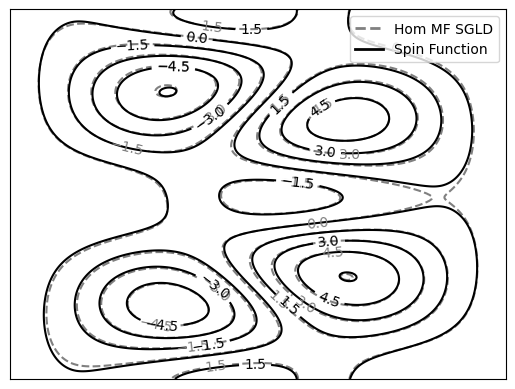

In [826]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

n = 256
x = np.linspace(0, np.pi, n)
y = np.linspace(0, 2 * np.pi, n)
X, Y = np.meshgrid(x, y)

# Assuming vneural_net_slice and vspin_func_slice are defined elsewhere

# Grey, dashed contour for vneural_net_slice
C = plt.contour(X, Y, vneural_net_slice(X, Y, c_hom, z_hom, d=3), 8, colors='grey', linestyles='dashed')
plt.clabel(C, inline=True, fontsize=10)

# Black, solid contour for vspin_func_slice
C2 = plt.contour(X, Y, vspin_func_slice(X, Y, a, d=3), 8, colors='black', linestyles='solid')
plt.clabel(C2, inline=True, fontsize=10)

# Create custom legend
custom_lines = [
    Line2D([0], [0], color='grey', lw=2, linestyle='--', label='Hom MF SGLD'),
    Line2D([0], [0], color='black', lw=2, linestyle='-', label='Spin Function')
]
plt.legend(handles=custom_lines, loc='upper right')

# Remove ticks for cleaner appearance
plt.xticks([])
plt.yticks([])
plt.savefig('/Users/pantelistassopoulos/Documents/3d-spin-model-neural-net-plot-d=3.png')

# Display the plot
plt.show()

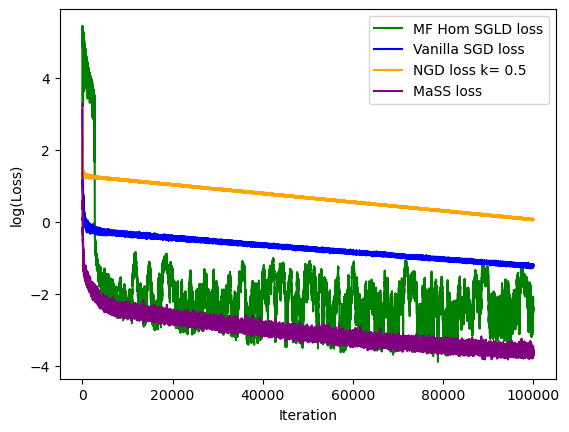

In [835]:
plt.plot(np.log10(losses_hom), label = 'MF Hom SGLD loss', c = 'green' )
plt.plot(np.log10(losses), label = 'Vanilla SGD loss', c = 'blue' )
plt.plot(np.log10(Nesterov_losses_2), label = 'NGD loss k= 0.5', c = 'orange')
plt.plot(np.log10(losses_mass), label = 'MaSS loss', c = 'purple')
plt.xlabel('Iteration')
plt.ylabel('log(Loss)')
plt.legend()
plt.savefig('/Users/pantelistassopoulos/Documents/texfiles/Summer-Research-2023/images/3d-spin-model-neural-net-loss-d=3.png')

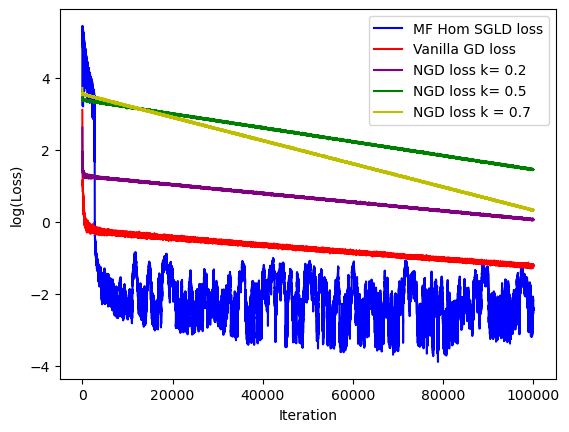

In [834]:
plt.plot(np.log10(losses_hom), label = 'MF Hom SGLD loss', c = 'b' )
plt.plot(np.log10(losses), label = 'Vanilla GD loss', c = 'r' )
plt.plot(np.log10(Nesterov_losses_2), label = 'NGD loss k= 0.2', c = 'purple')
plt.plot(np.log10(Nesterov_losses_5), label = 'NGD loss k= 0.5', c = 'g')
plt.plot(np.log10(Nesterov_losses_7), label = 'NGD loss k = 0.7', c = 'y')
plt.xlabel('Iteration')
plt.ylabel('log(Loss)')
plt.legend()
plt.savefig('/Users/pantelistassopoulos/Documents/texfiles/Summer-Research-2023/images/3d-spin-model-neural-net-loss-d=3.png')

In [821]:
#Training with Nesterov accelerated gd
def nesterov_train_stochastic(d = 5, n = 16, Dt = 1e3, r = 3, k=1,  steps = int(2*1e5)):
    """
    Train a neural network with symmetric architecture on a given spin system using Nesterov's accelerated gradient descent.

    Parameters:
    d (int): The dimensionality of the spin system (default is 5).
    n (int): The number of neural network units (default is 16).
    Dt (float): Time step for training (default is 1e3).
    r (int): The number of steps for Nesterov's acceleration (default is 3).
    steps (int): The number of training steps (default is 200,000).

    Returns:
    tuple: A tuple containing the trained neural network coefficients 'c', the weight matrix 'z',
           and an array of loss values during training.
    """
    
    #initialise parameters
    c = np.random.uniform(-40*d**2, 40*d**2, n).reshape(1,n)
    z = sample_uniform_sphere(np.sqrt(d), d, n).reshape(n,d)
    c_change = c
    z_change = z
    
    
    losses = np.zeros(steps)
    #update step
    for step in trange(steps):
        grad = grad_spin_func(z_change,a)
        exp = np.exp(-z_change@z_change.T)
        #sample points on sphere
        P = int(1e2)
        x = sample_uniform_sphere(np.sqrt(d), d, P).reshape(P,d)
        exp_x = np.exp(-x@z_change.T)
        
        loss = 0.5*np.mean((spin_func(x,a)-neural_net_symm(x,c,z))**2)    
        
        c1 = c
        z1 = z
        
        c_next = c_change + (spin_func(x, a)@exp_x-1/n*c_change@exp_x.T@exp_x)*Dt/P
        z_next = z_change + (-(c_change.T*exp_x.T)@(spin_func(x, a).T*x)+1/n*(c_change.T*exp_x.T@((exp_x@c_change.T)*x)))*Dt/P
        #z_next = z_change + ((c_change.T*exp_x.T)@(spin_func(x, a).T*x)\
        #                     -1/n*(c_change.T*exp_x.T@((exp_x@c_change.T)*x)))*Dt/P
        z_next = z_next*np.sqrt(d)/(np.linalg.norm(z_next, axis = 1).reshape(n,1)+1e-100)
                
        
        c_change = c_next + k*(c_next-c1)
        z_change = z_next + k*(z_next-z1)
        z = z_next
        c = c_next
        
        
        losses[step] = loss
        print('loss: {}'.format(loss))
        z = z_next
        c = c_next
        
        
    return c,z, losses

In [601]:
#Training with Nesterov accelerated gd
def nesterov_train_deterministic(d = 5, n = 16, Dt = 1e3, r = 3, steps = int(2*1e5)):
    """
    Train a neural network with symmetric architecture on a given spin system using Nesterov's accelerated gradient descent.

    Parameters:
    d (int): The dimensionality of the spin system (default is 5).
    n (int): The number of neural network units (default is 16).
    Dt (float): Time step for training (default is 1e3).
    r (int): The number of steps for Nesterov's acceleration (default is 3).
    steps (int): The number of training steps (default is 200,000).

    Returns:
    tuple: A tuple containing the trained neural network coefficients 'c', the weight matrix 'z',
           and an array of loss values during training.
    """
    #initialise parameters
    c = np.random.uniform(-40*d**2, 40*d**2, n).reshape(1,n)
    z = sample_uniform_sphere(np.sqrt(d), d, n).reshape(n,d)
    c_change = c
    z_change = z

    losses = np.zeros(steps)
    #update step
    for step in trange(1,steps+1):
        grad = grad_spin_func(z_change,a)
        exp = np.exp(-z_change@z_change.T)
        #sample points on sphere
        P = int(1e3)
        x = sample_uniform_sphere(np.sqrt(d), d, P).reshape(P,d)

        loss = 0.5*np.mean((spin_func(x,a)-neural_net_symm(x,c,z))**2)

        c1 = c
        z1 = z
        
        c_next = c_change + (spin_func(z_change, a)@exp-1/n*c@exp.T@exp)*Dt/P
        z_next = z_change + ((c_change.T*exp.T)@(spin_func(z_change, a).T*z_change)\
                      -1/n*(c_change.T*exp.T@((exp@c_change.T)*z_change)))*Dt/P
        z_next = z_next*np.sqrt(d)/(np.linalg.norm(z_next, axis = 1).reshape(n,1)+1e-100)

        c_change = c_next + 0.5*(c_next-c1)
        z_change = z_next + 0.5*(z_next-z1)
        z = z_next
        c = c_next

        losses[step-1] = loss
        print('loss: {}'.format(loss))
            
    return c,z, losses

In [ ]:
c_2,z_2, Nesterov_losses_2 = nesterov_train_stochastic(d=3, n = 256, k = 0.2, steps = int(1*1e5), Dt = 1e-6)
c_5,z_5, Nesterov_losses_5 = nesterov_train_stochastic(d=3, n = 256, k = 0.5, steps = int(1*1e5), Dt = 1e-6)
c_5,z_7, Nesterov_losses_7 = nesterov_train_stochastic(d=3, n = 256, k = 0.7, steps = int(1*1e5), Dt = 1e-6)

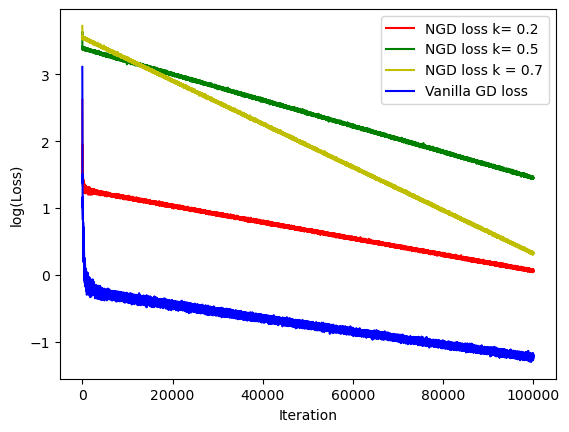

In [718]:
plt.plot(np.log10(Nesterov_losses_2), label = 'NGD loss k= 0.2', c = 'r')
plt.plot(np.log10(Nesterov_losses_5), label = 'NGD loss k= 0.5', c = 'g')
plt.plot(np.log10(Nesterov_losses_7), label = 'NGD loss k = 0.7', c = 'y')

plt.plot(np.log10(losses), label = 'Vanilla GD loss', c = 'b' )
plt.xlabel('Iteration')
plt.ylabel('log(Loss)')
plt.savefig('/Users/pantelistassopoulos/Documents/3d-spin-model-neural-net-loss-d=3.png')
plt.legend()

## General Observations

- In the deterministic gradient flow (with random initialization), the Nesterov accelerated loss (green) decreases towards a minimum much faster than regular gradient descent (blue), as expected.
- In the stochastic gradient flow (with random initialization), the Nesterov accelerated loss (green) decreases  towards a minimum faster than regular gradient descent (blue), though the losses stay closer together
